<a href="https://colab.research.google.com/github/uosstat98/project1/blob/main/LSTF_%EC%9D%91%EC%9A%A9%ED%8E%B8(%EC%8B%A4%EC%A0%84).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

## 모델 class 설정

In [ ]:
class LTSF_Linear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, individual, feature_size):
        super(LTSF_Linear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(torch.nn.Linear(self.window_size, self.forcast_size))
        else:
            self.Linear = torch.nn.Linear(self.window_size, self.forcast_size)

    def forward(self, x):
        if self.individual:
            output = torch.zeros([x.size(0), self.forcast_size, x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        return x

In [ ]:
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual

class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forcast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forcast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forcast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forcast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])
        else:
            trend_output = self.Linear_Trend(trend_init)
            seasonal_output = self.Linear_Seasonal(seasonal_init)
        x = seasonal_output + trend_output
        return x.permute(0,2,1)

In [ ]:
class LTSF_NLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, individual, feature_size):
        super(LTSF_NLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(torch.nn.Linear(self.window_size, self.forcast_size))
        else:
            self.Linear = torch.nn.Linear(self.window_size, self.forcast_size)

    def forward(self, x):
        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        if self.individual:
            output = torch.zeros([x.size(0), self.forcast_size, x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        x = x + seq_last
        return x

In [ ]:
def standardization(train_df, test_df, not_col, target):
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]

        # 모든 컬럼에 대해 평균과 표준편차를 한 번에 계산
    stats = train_df_[col].agg(["mean", "std"])

    for x in col:
        mean = stats.loc["mean", x]
        std = stats.loc["std", x]
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        test_df_.loc[:, x] = (test_df_[x] - mean) / std

    # target에 대한 평균과 표준편차 반환
    target_mean = stats.loc["mean", target]
    target_std = stats.loc["std", target]

    return train_df_, test_df_, target_mean, target_std

In [ ]:
from torch.utils.data import DataLoader, Dataset
class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
import numpy as np

def time_slide_df(df, window_size, forcast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0] - window_size - forcast_size + 1):
        x = df_.iloc[idx:idx + window_size][target].values
        y = df_.iloc[idx + window_size:idx + window_size + forcast_size][target].values
        date_ = df_.iloc[idx + window_size:idx + window_size + forcast_size][date].values

        # x 또는 y가 비어있지 않은 경우에만 리스트에 추가
        if x.size > 0 and y.size > 0:
            data_list.append(x.reshape(window_size, 1))
            dap_list.append(y)
            date_list.append(date_)

    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

##전처리

In [ ]:
path='/content/drive/MyDrive/BITamin'
df=pd.read_csv(path + '/Stock_log.csv').iloc[:,:2]
df.rename(columns ={'Unnamed: 0' : 'Date'}, inplace=True)
df.head()

,Date,005930
0,0,10.494048
1,1,10.504519
2,2,10.495709
3,3,10.478977
4,4,10.496814


In [ ]:
df.shape

(1776, 2)

In [ ]:
#train vs validation vs test 6:3:1

import math
train_len=math.ceil(len(df)*0.9)

train_df=df.iloc[:train_len,:]
test_df=df.iloc[train_len:,:]

In [ ]:
window_size = 10
forcast_size= 5
batch_size = 32
targets='005930'
date = 'Date'

In [ ]:
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, 'Date', targets)
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forcast_size, date, targets)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forcast_size, date, targets)

In [ ]:
valid_len=math.ceil(len(train_x)*(2/3)) #train vs validation 6:3

train_ds = Data(train_x[:valid_len], train_y[:valid_len])
valid_ds = Data(train_x[valid_len:], train_y[valid_len:])
test_ds = Data(test_x, test_y)

In [ ]:
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False,)
valid_dl = DataLoader(valid_ds, batch_size = train_x[valid_len:].shape[0], shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = test_x.shape[0], shuffle=False)

In [ ]:
for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    DLinear_model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = DLinear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)

        for data, target in test_dl:
            output = DLinear_model(data)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss < max_loss:
        torch.save(DLinear_model, 'DLinear_model.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())
        dlinear_best_test_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

In [ ]:
# 예측 결과 딕셔너리를 DataFrame으로 변환
final_output=output.reshape(-1,1)
final_date=test_date.reshape(-1,1)

In [ ]:
final= pd.DataFrame(zip(final_date,final_output), columns=['date','005930'])
final.head()

,date,005930
0,[1609],[tensor(1.2450)]
1,[1610],[tensor(1.2587)]
2,[1611],[tensor(1.2483)]
3,[1612],[tensor(1.2436)]
4,[1613],[tensor(1.2355)]


# 연습장 하나 더

In [ ]:
path='/content/drive/MyDrive/BITamin'
df=pd.read_csv(path + '/Stock_log.csv').iloc[:,:100]
df.rename(columns ={'Unnamed: 0' : 'Date'}, inplace=True)
df.head()

,Date,005930,000660,373220,207940,005935,005380,000270,068270,005490,...,011790,005940,128940,348370,036570,021240,307950,011780,071050,180640
0,0,10.494048,10.732039,13.132314,11.949036,10.268131,11.918391,10.584056,11.490281,12.470358,...,10.422281,9.176784,12.360269,11.289782,12.421184,11.386228,11.393015,11.355101,10.638256,9.595603
1,1,10.504519,10.763208,13.132314,11.958579,10.267436,11.938193,10.615211,11.475390,12.452933,...,10.431170,9.182969,12.369024,11.289782,12.464583,11.391887,11.393015,11.352757,10.633449,9.585346
2,2,10.495709,10.747208,13.132314,11.936178,10.268131,11.944708,10.628618,11.470686,12.447056,...,10.392068,9.205328,12.401582,11.289782,12.468437,11.398636,11.393015,11.333799,10.659610,9.598998
3,3,10.478977,10.756838,13.132314,11.955410,10.249910,11.941456,10.623763,11.473509,12.419166,...,10.390533,9.210340,12.404952,11.289782,12.472276,11.424094,11.393015,11.324183,10.680516,9.629051
4,4,10.496814,10.778956,13.132314,11.955410,10.261861,11.925035,10.615211,11.463126,12.429216,...,10.388995,9.215328,12.386292,11.289782,12.470358,11.429544,11.393015,11.324183,10.691945,9.648595


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.iloc[:,1:])
df1=pd.DataFrame(X_scaled,columns=df.columns[1:])

df=pd.concat([df.iloc[:,0],df1], axis=1)
df.head()

,Date,005930,000660,373220,207940,005935,005380,000270,068270,005490,...,011790,005940,128940,348370,036570,021240,307950,011780,071050,180640
0,0,-2.107299,-2.569473,0.224231,-2.575426,-2.025401,-0.268020,-0.682806,-1.943845,-0.422434,...,-1.251501,-1.104138,-1.375437,0.059715,-1.638362,0.779472,-0.087771,-0.773262,-2.235067,-2.017066
1,1,-2.059658,-2.450970,0.224231,-2.555622,-2.028080,-0.186726,-0.608987,-1.990214,-0.488929,...,-1.235817,-1.067808,-1.333552,0.059715,-1.526720,0.803395,-0.087771,-0.779767,-2.257639,-2.037837
2,2,-2.099743,-2.511803,0.224231,-2.602112,-2.025401,-0.159981,-0.577221,-2.004862,-0.511354,...,-1.304812,-0.936488,-1.177803,0.059715,-1.516807,0.831925,-0.087771,-0.832358,-2.134814,-2.010189
3,3,-2.175868,-2.475187,0.224231,-2.562198,-2.095659,-0.173332,-0.588723,-1.996072,-0.617783,...,-1.307520,-0.907048,-1.161680,0.059715,-1.506932,0.939541,-0.087771,-0.859033,-2.036657,-1.949328
4,4,-2.094713,-2.391095,0.224231,-2.562198,-2.049576,-0.240742,-0.608987,-2.028403,-0.579431,...,-1.310232,-0.877755,-1.250947,0.059715,-1.511865,0.962578,-0.087771,-0.859033,-1.982999,-1.909747


In [ ]:
#train vs validation vs test 6:3:1

import math
train_len=math.ceil(len(df)*0.9)

train_df=df.iloc[:train_len,:]
test_df=df.iloc[train_len:,:]

In [ ]:
ex=pd.DataFrame(list(range(1609,1776)),columns=['date'])

window_size = 10
forcast_size= 5
batch_size = 32
date = 'Date'

In [ ]:
for col in df.columns[1:]:

  targets = col

  train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forcast_size, date, targets)
  test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forcast_size, date, targets)

  valid_len=math.ceil(len(train_x)*(2/3)) #train vs validation 6:3

  train_ds = Data(train_x[:valid_len], train_y[:valid_len])
  valid_ds = Data(train_x[valid_len:], train_y[valid_len:])
  test_ds = Data(test_x, test_y)

  train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False,)
  valid_dl = DataLoader(valid_ds, batch_size = train_x[valid_len:].shape[0], shuffle=False)
  test_dl  = DataLoader(test_ds,  batch_size = test_x.shape[0], shuffle=False)

  train_loss_list = []
  valid_loss_list = []
  test_loss_list = []
  epoch = 30
  lr = 0.001
  DLinear_model = LTSF_DLinear(
                              window_size=window_size,
                              forcast_size=forcast_size,
                              kernel_size=25,
                              individual=False,
                              feature_size=1,
                              )
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
  max_loss = 999999999

  for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    DLinear_model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = DLinear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)

        for data, target in test_dl:
            output = DLinear_model(data)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss < max_loss:
        torch.save(DLinear_model, 'DLinear_model.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())
        dlinear_best_test_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

  final_output=output.reshape(-1,1)
  final=pd.DataFrame(final_output, columns = [col])
  ex=pd.concat([ex, final], axis=1)

  7%|▋         | 2/30 [00:00<00:02, 13.25it/s]

valid_loss=0.075, test_los0.073, Model Save
epoch = 1, train_loss : 0.055, valid_loss : 0.075, test_loss : 0.073
valid_loss=0.036, test_los0.031, Model Save
epoch = 2, train_loss : 0.038, valid_loss : 0.036, test_loss : 0.031
valid_loss=0.025, test_los0.020, Model Save
epoch = 3, train_loss : 0.033, valid_loss : 0.025, test_loss : 0.020


 20%|██        | 6/30 [00:00<00:01, 13.95it/s]

valid_loss=0.020, test_los0.016, Model Save
epoch = 4, train_loss : 0.029, valid_loss : 0.020, test_loss : 0.016
valid_loss=0.017, test_los0.013, Model Save
epoch = 5, train_loss : 0.027, valid_loss : 0.017, test_loss : 0.013
valid_loss=0.015, test_los0.012, Model Save
epoch = 6, train_loss : 0.025, valid_loss : 0.015, test_loss : 0.012


 27%|██▋       | 8/30 [00:00<00:01, 13.70it/s]

valid_loss=0.015, test_los0.011, Model Save
epoch = 7, train_loss : 0.024, valid_loss : 0.015, test_loss : 0.011
valid_loss=0.014, test_los0.011, Model Save
epoch = 8, train_loss : 0.023, valid_loss : 0.014, test_loss : 0.011
valid_loss=0.014, test_los0.011, Model Save
epoch = 9, train_loss : 0.023, valid_loss : 0.014, test_loss : 0.011


 40%|████      | 12/30 [00:00<00:01, 13.48it/s]

valid_loss=0.013, test_los0.011, Model Save
epoch = 10, train_loss : 0.022, valid_loss : 0.013, test_loss : 0.011
valid_loss=0.013, test_los0.011, Model Save
epoch = 11, train_loss : 0.022, valid_loss : 0.013, test_loss : 0.011
valid_loss=0.013, test_los0.011, Model Save
epoch = 12, train_loss : 0.022, valid_loss : 0.013, test_loss : 0.011


 47%|████▋     | 14/30 [00:01<00:01, 13.54it/s]

valid_loss=0.013, test_los0.011, Model Save
epoch = 13, train_loss : 0.021, valid_loss : 0.013, test_loss : 0.011
valid_loss=0.013, test_los0.011, Model Save
epoch = 14, train_loss : 0.021, valid_loss : 0.013, test_loss : 0.011
valid_loss=0.012, test_los0.011, Model Save
epoch = 15, train_loss : 0.021, valid_loss : 0.012, test_loss : 0.011


 60%|██████    | 18/30 [00:01<00:00, 13.19it/s]

valid_loss=0.012, test_los0.011, Model Save
epoch = 16, train_loss : 0.021, valid_loss : 0.012, test_loss : 0.011
valid_loss=0.012, test_los0.010, Model Save
epoch = 17, train_loss : 0.021, valid_loss : 0.012, test_loss : 0.010
valid_loss=0.012, test_los0.010, Model Save
epoch = 18, train_loss : 0.020, valid_loss : 0.012, test_loss : 0.010


 67%|██████▋   | 20/30 [00:01<00:00, 13.15it/s]

valid_loss=0.012, test_los0.010, Model Save
epoch = 19, train_loss : 0.020, valid_loss : 0.012, test_loss : 0.010
valid_loss=0.012, test_los0.010, Model Save
epoch = 20, train_loss : 0.020, valid_loss : 0.012, test_loss : 0.010
valid_loss=0.012, test_los0.010, Model Save
epoch = 21, train_loss : 0.020, valid_loss : 0.012, test_loss : 0.010


 80%|████████  | 24/30 [00:01<00:00, 13.12it/s]

valid_loss=0.012, test_los0.010, Model Save
epoch = 22, train_loss : 0.020, valid_loss : 0.012, test_loss : 0.010
valid_loss=0.012, test_los0.010, Model Save
epoch = 23, train_loss : 0.020, valid_loss : 0.012, test_loss : 0.010
valid_loss=0.012, test_los0.010, Model Save
epoch = 24, train_loss : 0.020, valid_loss : 0.012, test_loss : 0.010


 87%|████████▋ | 26/30 [00:01<00:00, 12.77it/s]

valid_loss=0.012, test_los0.010, Model Save
epoch = 25, train_loss : 0.020, valid_loss : 0.012, test_loss : 0.010
valid_loss=0.012, test_los0.010, Model Save
epoch = 26, train_loss : 0.020, valid_loss : 0.012, test_loss : 0.010


 93%|█████████▎| 28/30 [00:02<00:00, 10.97it/s]

valid_loss=0.012, test_los0.010, Model Save
epoch = 27, train_loss : 0.020, valid_loss : 0.012, test_loss : 0.010
valid_loss=0.012, test_los0.010, Model Save
epoch = 28, train_loss : 0.019, valid_loss : 0.012, test_loss : 0.010


100%|██████████| 30/30 [00:02<00:00, 12.22it/s]

valid_loss=0.011, test_los0.010, Model Save
epoch = 29, train_loss : 0.019, valid_loss : 0.011, test_loss : 0.010
valid_loss=0.011, test_los0.010, Model Save
epoch = 30, train_loss : 0.019, valid_loss : 0.011, test_loss : 0.010



  7%|▋         | 2/30 [00:00<00:03,  9.16it/s]

valid_loss=0.091, test_los0.125, Model Save
epoch = 1, train_loss : 0.084, valid_loss : 0.091, test_loss : 0.125
valid_loss=0.054, test_los0.057, Model Save
epoch = 2, train_loss : 0.058, valid_loss : 0.054, test_loss : 0.057


 13%|█▎        | 4/30 [00:00<00:03,  7.87it/s]

valid_loss=0.042, test_los0.041, Model Save
epoch = 3, train_loss : 0.049, valid_loss : 0.042, test_loss : 0.041
valid_loss=0.036, test_los0.035, Model Save
epoch = 4, train_loss : 0.043, valid_loss : 0.036, test_loss : 0.035


 20%|██        | 6/30 [00:00<00:02,  8.30it/s]

valid_loss=0.033, test_los0.032, Model Save
epoch = 5, train_loss : 0.039, valid_loss : 0.033, test_loss : 0.032
valid_loss=0.031, test_los0.031, Model Save
epoch = 6, train_loss : 0.037, valid_loss : 0.031, test_loss : 0.031


 23%|██▎       | 7/30 [00:00<00:02,  8.33it/s]

valid_loss=0.030, test_los0.030, Model Save
epoch = 7, train_loss : 0.035, valid_loss : 0.030, test_loss : 0.030
valid_loss=0.029, test_los0.030, Model Save
epoch = 8, train_loss : 0.034, valid_loss : 0.029, test_loss : 0.030
valid_loss=0.028, test_los0.030, Model Save


 30%|███       | 9/30 [00:01<00:02,  9.05it/s]

epoch = 9, train_loss : 0.033, valid_loss : 0.028, test_loss : 0.030
valid_loss=0.028, test_los0.030, Model Save
epoch = 10, train_loss : 0.033, valid_loss : 0.028, test_loss : 0.030


 40%|████      | 12/30 [00:01<00:01,  9.28it/s]

valid_loss=0.028, test_los0.030, Model Save
epoch = 11, train_loss : 0.032, valid_loss : 0.028, test_loss : 0.030
valid_loss=0.027, test_los0.030, Model Save
epoch = 12, train_loss : 0.032, valid_loss : 0.027, test_loss : 0.030


 47%|████▋     | 14/30 [00:01<00:01,  9.17it/s]

valid_loss=0.027, test_los0.030, Model Save
epoch = 13, train_loss : 0.031, valid_loss : 0.027, test_loss : 0.030
valid_loss=0.027, test_los0.030, Model Save
epoch = 14, train_loss : 0.031, valid_loss : 0.027, test_loss : 0.030


 53%|█████▎    | 16/30 [00:01<00:01,  8.42it/s]

valid_loss=0.027, test_los0.030, Model Save
epoch = 15, train_loss : 0.030, valid_loss : 0.027, test_loss : 0.030
valid_loss=0.026, test_los0.030, Model Save
epoch = 16, train_loss : 0.030, valid_loss : 0.026, test_loss : 0.030


 60%|██████    | 18/30 [00:02<00:01,  8.47it/s]

valid_loss=0.026, test_los0.030, Model Save
epoch = 17, train_loss : 0.030, valid_loss : 0.026, test_loss : 0.030
valid_loss=0.026, test_los0.029, Model Save
epoch = 18, train_loss : 0.030, valid_loss : 0.026, test_loss : 0.029


 67%|██████▋   | 20/30 [00:02<00:01,  8.46it/s]

valid_loss=0.026, test_los0.029, Model Save
epoch = 19, train_loss : 0.029, valid_loss : 0.026, test_loss : 0.029
valid_loss=0.026, test_los0.029, Model Save
epoch = 20, train_loss : 0.029, valid_loss : 0.026, test_loss : 0.029


 73%|███████▎  | 22/30 [00:02<00:01,  7.97it/s]

valid_loss=0.025, test_los0.029, Model Save
epoch = 21, train_loss : 0.029, valid_loss : 0.025, test_loss : 0.029
valid_loss=0.025, test_los0.029, Model Save
epoch = 22, train_loss : 0.029, valid_loss : 0.025, test_loss : 0.029


 83%|████████▎ | 25/30 [00:02<00:00, 10.19it/s]

valid_loss=0.025, test_los0.029, Model Save
epoch = 23, train_loss : 0.029, valid_loss : 0.025, test_loss : 0.029
valid_loss=0.025, test_los0.029, Model Save
epoch = 24, train_loss : 0.029, valid_loss : 0.025, test_loss : 0.029
valid_loss=0.025, test_los0.029, Model Save
epoch = 25, train_loss : 0.028, valid_loss : 0.025, test_loss : 0.029


 90%|█████████ | 27/30 [00:02<00:00, 11.11it/s]

valid_loss=0.025, test_los0.029, Model Save
epoch = 26, train_loss : 0.028, valid_loss : 0.025, test_loss : 0.029
valid_loss=0.025, test_los0.029, Model Save
epoch = 27, train_loss : 0.028, valid_loss : 0.025, test_loss : 0.029
valid_loss=0.025, test_los0.029, Model Save
epoch = 28, train_loss : 0.028, valid_loss : 0.025, test_loss : 0.029


100%|██████████| 30/30 [00:03<00:00,  9.35it/s]

valid_loss=0.025, test_los0.028, Model Save
epoch = 29, train_loss : 0.028, valid_loss : 0.025, test_loss : 0.028
valid_loss=0.025, test_los0.028, Model Save
epoch = 30, train_loss : 0.028, valid_loss : 0.025, test_loss : 0.028



  7%|▋         | 2/30 [00:00<00:02, 13.51it/s]

valid_loss=0.796, test_los0.987, Model Save
epoch = 1, train_loss : 0.048, valid_loss : 0.796, test_loss : 0.987
epoch = 2, train_loss : 0.026, valid_loss : 1.071, test_loss : 1.559
epoch = 3, train_loss : 0.014, valid_loss : 1.306, test_loss : 2.021


 20%|██        | 6/30 [00:00<00:01, 13.33it/s]

epoch = 4, train_loss : 0.008, valid_loss : 1.527, test_loss : 2.451
epoch = 5, train_loss : 0.004, valid_loss : 1.731, test_loss : 2.843
epoch = 6, train_loss : 0.002, valid_loss : 1.899, test_loss : 3.163


 27%|██▋       | 8/30 [00:00<00:01, 12.77it/s]

epoch = 7, train_loss : 0.001, valid_loss : 2.023, test_loss : 3.401
epoch = 8, train_loss : 0.000, valid_loss : 2.110, test_loss : 3.565
epoch = 9, train_loss : 0.000, valid_loss : 2.165, test_loss : 3.670


 40%|████      | 12/30 [00:00<00:01, 13.77it/s]

epoch = 10, train_loss : 0.000, valid_loss : 2.198, test_loss : 3.733
epoch = 11, train_loss : 0.000, valid_loss : 2.217, test_loss : 3.769
epoch = 12, train_loss : 0.000, valid_loss : 2.227, test_loss : 3.788


 53%|█████▎    | 16/30 [00:01<00:01, 13.90it/s]

epoch = 13, train_loss : 0.000, valid_loss : 2.232, test_loss : 3.797
epoch = 14, train_loss : 0.000, valid_loss : 2.235, test_loss : 3.802
epoch = 15, train_loss : 0.000, valid_loss : 2.236, test_loss : 3.804
epoch = 16, train_loss : 0.000, valid_loss : 2.236, test_loss : 3.805


 60%|██████    | 18/30 [00:01<00:00, 13.94it/s]

epoch = 17, train_loss : 0.000, valid_loss : 2.236, test_loss : 3.805
epoch = 18, train_loss : 0.000, valid_loss : 2.237, test_loss : 3.805
epoch = 19, train_loss : 0.000, valid_loss : 2.237, test_loss : 3.805


 73%|███████▎  | 22/30 [00:01<00:00, 14.13it/s]

epoch = 20, train_loss : 0.000, valid_loss : 2.237, test_loss : 3.805
epoch = 21, train_loss : 0.000, valid_loss : 2.237, test_loss : 3.805
epoch = 22, train_loss : 0.000, valid_loss : 2.237, test_loss : 3.805
epoch = 23, train_loss : 0.000, valid_loss : 2.237, test_loss : 3.805


 87%|████████▋ | 26/30 [00:01<00:00, 14.48it/s]

epoch = 24, train_loss : 0.000, valid_loss : 2.237, test_loss : 3.805
epoch = 25, train_loss : 0.000, valid_loss : 2.237, test_loss : 3.805
epoch = 26, train_loss : 0.000, valid_loss : 2.237, test_loss : 3.805


 93%|█████████▎| 28/30 [00:02<00:00, 12.49it/s]

epoch = 27, train_loss : 0.000, valid_loss : 2.237, test_loss : 3.805
epoch = 28, train_loss : 0.000, valid_loss : 2.237, test_loss : 3.805
epoch = 29, train_loss : 0.000, valid_loss : 2.237, test_loss : 3.805


100%|██████████| 30/30 [00:02<00:00, 13.18it/s]


epoch = 30, train_loss : 0.000, valid_loss : 2.237, test_loss : 3.805


  7%|▋         | 2/30 [00:00<00:02, 12.32it/s]

valid_loss=0.103, test_los0.092, Model Save
epoch = 1, train_loss : 0.077, valid_loss : 0.103, test_loss : 0.092
valid_loss=0.080, test_los0.071, Model Save
epoch = 2, train_loss : 0.050, valid_loss : 0.080, test_loss : 0.071
valid_loss=0.057, test_los0.051, Model Save
epoch = 3, train_loss : 0.039, valid_loss : 0.057, test_loss : 0.051


 20%|██        | 6/30 [00:00<00:02, 11.04it/s]

valid_loss=0.039, test_los0.035, Model Save
epoch = 4, train_loss : 0.031, valid_loss : 0.039, test_loss : 0.035
valid_loss=0.026, test_los0.024, Model Save
epoch = 5, train_loss : 0.025, valid_loss : 0.026, test_loss : 0.024
valid_loss=0.018, test_los0.016, Model Save
epoch = 6, train_loss : 0.021, valid_loss : 0.018, test_loss : 0.016


 27%|██▋       | 8/30 [00:00<00:01, 11.07it/s]

valid_loss=0.012, test_los0.011, Model Save
epoch = 7, train_loss : 0.018, valid_loss : 0.012, test_loss : 0.011
valid_loss=0.009, test_los0.008, Model Save
epoch = 8, train_loss : 0.016, valid_loss : 0.009, test_loss : 0.008
valid_loss=0.006, test_los0.006, Model Save
epoch = 9, train_loss : 0.015, valid_loss : 0.006, test_loss : 0.006


 40%|████      | 12/30 [00:01<00:01, 11.22it/s]

valid_loss=0.005, test_los0.005, Model Save
epoch = 10, train_loss : 0.014, valid_loss : 0.005, test_loss : 0.005
valid_loss=0.004, test_los0.004, Model Save
epoch = 11, train_loss : 0.014, valid_loss : 0.004, test_loss : 0.004
valid_loss=0.004, test_los0.004, Model Save
epoch = 12, train_loss : 0.013, valid_loss : 0.004, test_loss : 0.004


 47%|████▋     | 14/30 [00:01<00:01, 11.30it/s]

valid_loss=0.004, test_los0.004, Model Save
epoch = 13, train_loss : 0.013, valid_loss : 0.004, test_loss : 0.004
valid_loss=0.004, test_los0.003, Model Save
epoch = 14, train_loss : 0.013, valid_loss : 0.004, test_loss : 0.003
valid_loss=0.004, test_los0.003, Model Save
epoch = 15, train_loss : 0.013, valid_loss : 0.004, test_loss : 0.003


 60%|██████    | 18/30 [00:01<00:01, 11.09it/s]

valid_loss=0.004, test_los0.003, Model Save
epoch = 16, train_loss : 0.013, valid_loss : 0.004, test_loss : 0.003
valid_loss=0.004, test_los0.003, Model Save
epoch = 17, train_loss : 0.012, valid_loss : 0.004, test_loss : 0.003
valid_loss=0.004, test_los0.003, Model Save
epoch = 18, train_loss : 0.012, valid_loss : 0.004, test_loss : 0.003


 67%|██████▋   | 20/30 [00:01<00:00, 10.87it/s]

valid_loss=0.003, test_los0.003, Model Save
epoch = 19, train_loss : 0.012, valid_loss : 0.003, test_loss : 0.003
valid_loss=0.003, test_los0.003, Model Save
epoch = 20, train_loss : 0.012, valid_loss : 0.003, test_loss : 0.003
valid_loss=0.003, test_los0.003, Model Save
epoch = 21, train_loss : 0.012, valid_loss : 0.003, test_loss : 0.003


 80%|████████  | 24/30 [00:02<00:00, 11.26it/s]

valid_loss=0.003, test_los0.003, Model Save
epoch = 22, train_loss : 0.012, valid_loss : 0.003, test_loss : 0.003
valid_loss=0.003, test_los0.003, Model Save
epoch = 23, train_loss : 0.012, valid_loss : 0.003, test_loss : 0.003
valid_loss=0.003, test_los0.003, Model Save
epoch = 24, train_loss : 0.012, valid_loss : 0.003, test_loss : 0.003


 87%|████████▋ | 26/30 [00:02<00:00, 11.14it/s]

valid_loss=0.003, test_los0.003, Model Save
epoch = 25, train_loss : 0.012, valid_loss : 0.003, test_loss : 0.003
valid_loss=0.003, test_los0.003, Model Save
epoch = 26, train_loss : 0.012, valid_loss : 0.003, test_loss : 0.003
valid_loss=0.003, test_los0.003, Model Save
epoch = 27, train_loss : 0.012, valid_loss : 0.003, test_loss : 0.003


100%|██████████| 30/30 [00:02<00:00, 11.10it/s]

valid_loss=0.003, test_los0.003, Model Save
epoch = 28, train_loss : 0.012, valid_loss : 0.003, test_loss : 0.003
valid_loss=0.003, test_los0.003, Model Save
epoch = 29, train_loss : 0.012, valid_loss : 0.003, test_loss : 0.003
valid_loss=0.003, test_los0.003, Model Save
epoch = 30, train_loss : 0.012, valid_loss : 0.003, test_loss : 0.003



  7%|▋         | 2/30 [00:00<00:02, 12.42it/s]

valid_loss=0.127, test_los0.107, Model Save
epoch = 1, train_loss : 0.086, valid_loss : 0.127, test_loss : 0.107
valid_loss=0.076, test_los0.066, Model Save
epoch = 2, train_loss : 0.052, valid_loss : 0.076, test_loss : 0.066
valid_loss=0.050, test_los0.044, Model Save
epoch = 3, train_loss : 0.041, valid_loss : 0.050, test_loss : 0.044


 13%|█▎        | 4/30 [00:00<00:02, 11.48it/s]

valid_loss=0.034, test_los0.030, Model Save
epoch = 4, train_loss : 0.032, valid_loss : 0.034, test_loss : 0.030
valid_loss=0.024, test_los0.021, Model Save
epoch = 5, train_loss : 0.027, valid_loss : 0.024, test_loss : 0.021


 27%|██▋       | 8/30 [00:00<00:02, 10.62it/s]

valid_loss=0.018, test_los0.015, Model Save
epoch = 6, train_loss : 0.023, valid_loss : 0.018, test_loss : 0.015
valid_loss=0.014, test_los0.011, Model Save
epoch = 7, train_loss : 0.020, valid_loss : 0.014, test_loss : 0.011
valid_loss=0.012, test_los0.009, Model Save
epoch = 8, train_loss : 0.019, valid_loss : 0.012, test_loss : 0.009


 33%|███▎      | 10/30 [00:00<00:01, 11.17it/s]

valid_loss=0.011, test_los0.008, Model Save
epoch = 9, train_loss : 0.017, valid_loss : 0.011, test_loss : 0.008
valid_loss=0.010, test_los0.007, Model Save
epoch = 10, train_loss : 0.017, valid_loss : 0.010, test_loss : 0.007
valid_loss=0.009, test_los0.007, Model Save
epoch = 11, train_loss : 0.016, valid_loss : 0.009, test_loss : 0.007


 40%|████      | 12/30 [00:01<00:01,  9.81it/s]

valid_loss=0.009, test_los0.007, Model Save
epoch = 12, train_loss : 0.016, valid_loss : 0.009, test_loss : 0.007
valid_loss=0.009, test_los0.007, Model Save
epoch = 13, train_loss : 0.016, valid_loss : 0.009, test_loss : 0.007


 50%|█████     | 15/30 [00:01<00:01,  7.90it/s]

valid_loss=0.009, test_los0.007, Model Save
epoch = 14, train_loss : 0.015, valid_loss : 0.009, test_loss : 0.007
valid_loss=0.009, test_los0.006, Model Save
epoch = 15, train_loss : 0.015, valid_loss : 0.009, test_loss : 0.006


 60%|██████    | 18/30 [00:01<00:01,  8.81it/s]

valid_loss=0.009, test_los0.006, Model Save
epoch = 16, train_loss : 0.015, valid_loss : 0.009, test_loss : 0.006
valid_loss=0.009, test_los0.006, Model Save
epoch = 17, train_loss : 0.015, valid_loss : 0.009, test_loss : 0.006
valid_loss=0.009, test_los0.006, Model Save
epoch = 18, train_loss : 0.015, valid_loss : 0.009, test_loss : 0.006


 67%|██████▋   | 20/30 [00:02<00:01,  9.50it/s]

valid_loss=0.009, test_los0.006, Model Save
epoch = 19, train_loss : 0.015, valid_loss : 0.009, test_loss : 0.006
valid_loss=0.009, test_los0.006, Model Save
epoch = 20, train_loss : 0.015, valid_loss : 0.009, test_loss : 0.006
valid_loss=0.009, test_los0.006, Model Save
epoch = 21, train_loss : 0.015, valid_loss : 0.009, test_loss : 0.006


 73%|███████▎  | 22/30 [00:02<00:00,  9.66it/s]

valid_loss=0.009, test_los0.006, Model Save
epoch = 22, train_loss : 0.014, valid_loss : 0.009, test_loss : 0.006
valid_loss=0.008, test_los0.006, Model Save
epoch = 23, train_loss : 0.014, valid_loss : 0.008, test_loss : 0.006


 83%|████████▎ | 25/30 [00:02<00:00,  8.77it/s]

valid_loss=0.008, test_los0.006, Model Save
epoch = 24, train_loss : 0.014, valid_loss : 0.008, test_loss : 0.006
valid_loss=0.008, test_los0.006, Model Save
epoch = 25, train_loss : 0.014, valid_loss : 0.008, test_loss : 0.006


 90%|█████████ | 27/30 [00:02<00:00,  8.36it/s]

valid_loss=0.008, test_los0.006, Model Save
epoch = 26, train_loss : 0.014, valid_loss : 0.008, test_loss : 0.006
valid_loss=0.008, test_los0.006, Model Save
epoch = 27, train_loss : 0.014, valid_loss : 0.008, test_loss : 0.006


 97%|█████████▋| 29/30 [00:03<00:00,  8.43it/s]

valid_loss=0.008, test_los0.006, Model Save
epoch = 28, train_loss : 0.014, valid_loss : 0.008, test_loss : 0.006
valid_loss=0.008, test_los0.006, Model Save
epoch = 29, train_loss : 0.014, valid_loss : 0.008, test_loss : 0.006


100%|██████████| 30/30 [00:03<00:00,  9.04it/s]


valid_loss=0.008, test_los0.006, Model Save
epoch = 30, train_loss : 0.014, valid_loss : 0.008, test_loss : 0.006


  3%|▎         | 1/30 [00:00<00:06,  4.63it/s]

valid_loss=0.121, test_los0.163, Model Save
epoch = 1, train_loss : 0.116, valid_loss : 0.121, test_loss : 0.163


 10%|█         | 3/30 [00:00<00:05,  4.83it/s]

valid_loss=0.078, test_los0.114, Model Save
epoch = 2, train_loss : 0.089, valid_loss : 0.078, test_loss : 0.114
valid_loss=0.054, test_los0.086, Model Save
epoch = 3, train_loss : 0.075, valid_loss : 0.054, test_loss : 0.086


 17%|█▋        | 5/30 [00:00<00:04,  5.94it/s]

valid_loss=0.039, test_los0.068, Model Save
epoch = 4, train_loss : 0.064, valid_loss : 0.039, test_loss : 0.068
valid_loss=0.029, test_los0.057, Model Save
epoch = 5, train_loss : 0.057, valid_loss : 0.029, test_loss : 0.057


 23%|██▎       | 7/30 [00:01<00:03,  6.98it/s]

valid_loss=0.023, test_los0.048, Model Save
epoch = 6, train_loss : 0.052, valid_loss : 0.023, test_loss : 0.048
valid_loss=0.019, test_los0.043, Model Save
epoch = 7, train_loss : 0.048, valid_loss : 0.019, test_loss : 0.043


 30%|███       | 9/30 [00:01<00:02,  7.74it/s]

valid_loss=0.017, test_los0.039, Model Save
epoch = 8, train_loss : 0.045, valid_loss : 0.017, test_loss : 0.039
valid_loss=0.015, test_los0.036, Model Save
epoch = 9, train_loss : 0.043, valid_loss : 0.015, test_loss : 0.036


 37%|███▋      | 11/30 [00:01<00:02,  8.59it/s]

valid_loss=0.014, test_los0.034, Model Save
epoch = 10, train_loss : 0.042, valid_loss : 0.014, test_loss : 0.034
valid_loss=0.014, test_los0.033, Model Save
epoch = 11, train_loss : 0.041, valid_loss : 0.014, test_loss : 0.033


 43%|████▎     | 13/30 [00:01<00:01,  9.07it/s]

valid_loss=0.013, test_los0.032, Model Save
epoch = 12, train_loss : 0.040, valid_loss : 0.013, test_loss : 0.032
valid_loss=0.013, test_los0.031, Model Save
epoch = 13, train_loss : 0.039, valid_loss : 0.013, test_loss : 0.031


 50%|█████     | 15/30 [00:02<00:01,  8.41it/s]

valid_loss=0.013, test_los0.030, Model Save
epoch = 14, train_loss : 0.038, valid_loss : 0.013, test_loss : 0.030
valid_loss=0.013, test_los0.029, Model Save
epoch = 15, train_loss : 0.038, valid_loss : 0.013, test_loss : 0.029


 57%|█████▋    | 17/30 [00:02<00:01,  7.58it/s]

valid_loss=0.012, test_los0.029, Model Save
epoch = 16, train_loss : 0.037, valid_loss : 0.012, test_loss : 0.029
valid_loss=0.012, test_los0.028, Model Save
epoch = 17, train_loss : 0.037, valid_loss : 0.012, test_loss : 0.028


 63%|██████▎   | 19/30 [00:02<00:01,  7.50it/s]

valid_loss=0.012, test_los0.028, Model Save
epoch = 18, train_loss : 0.036, valid_loss : 0.012, test_loss : 0.028
valid_loss=0.012, test_los0.027, Model Save
epoch = 19, train_loss : 0.036, valid_loss : 0.012, test_loss : 0.027


 70%|███████   | 21/30 [00:02<00:01,  8.02it/s]

valid_loss=0.012, test_los0.027, Model Save
epoch = 20, train_loss : 0.036, valid_loss : 0.012, test_loss : 0.027
valid_loss=0.012, test_los0.027, Model Save
epoch = 21, train_loss : 0.035, valid_loss : 0.012, test_loss : 0.027


 77%|███████▋  | 23/30 [00:03<00:00,  8.10it/s]

valid_loss=0.012, test_los0.026, Model Save
epoch = 22, train_loss : 0.035, valid_loss : 0.012, test_loss : 0.026
valid_loss=0.012, test_los0.026, Model Save
epoch = 23, train_loss : 0.035, valid_loss : 0.012, test_loss : 0.026


 83%|████████▎ | 25/30 [00:03<00:00,  8.34it/s]

valid_loss=0.012, test_los0.026, Model Save
epoch = 24, train_loss : 0.035, valid_loss : 0.012, test_loss : 0.026
valid_loss=0.012, test_los0.026, Model Save
epoch = 25, train_loss : 0.034, valid_loss : 0.012, test_loss : 0.026


 90%|█████████ | 27/30 [00:03<00:00,  8.25it/s]

valid_loss=0.012, test_los0.025, Model Save
epoch = 26, train_loss : 0.034, valid_loss : 0.012, test_loss : 0.025
valid_loss=0.012, test_los0.025, Model Save
epoch = 27, train_loss : 0.034, valid_loss : 0.012, test_loss : 0.025


 97%|█████████▋| 29/30 [00:03<00:00,  8.14it/s]

valid_loss=0.012, test_los0.025, Model Save
epoch = 28, train_loss : 0.034, valid_loss : 0.012, test_loss : 0.025
valid_loss=0.012, test_los0.025, Model Save
epoch = 29, train_loss : 0.034, valid_loss : 0.012, test_loss : 0.025


100%|██████████| 30/30 [00:04<00:00,  7.50it/s]


valid_loss=0.012, test_los0.025, Model Save
epoch = 30, train_loss : 0.033, valid_loss : 0.012, test_loss : 0.025


  7%|▋         | 2/30 [00:00<00:02, 13.65it/s]

valid_loss=0.208, test_los0.268, Model Save
epoch = 1, train_loss : 0.090, valid_loss : 0.208, test_loss : 0.268
valid_loss=0.184, test_los0.239, Model Save
epoch = 2, train_loss : 0.057, valid_loss : 0.184, test_loss : 0.239
valid_loss=0.148, test_los0.193, Model Save
epoch = 3, train_loss : 0.047, valid_loss : 0.148, test_loss : 0.193


 20%|██        | 6/30 [00:00<00:01, 13.00it/s]

valid_loss=0.115, test_los0.151, Model Save
epoch = 4, train_loss : 0.039, valid_loss : 0.115, test_loss : 0.151
valid_loss=0.088, test_los0.117, Model Save
epoch = 5, train_loss : 0.033, valid_loss : 0.088, test_loss : 0.117
valid_loss=0.067, test_los0.089, Model Save
epoch = 6, train_loss : 0.028, valid_loss : 0.067, test_loss : 0.089


 27%|██▋       | 8/30 [00:00<00:01, 12.24it/s]

valid_loss=0.050, test_los0.068, Model Save
epoch = 7, train_loss : 0.025, valid_loss : 0.050, test_loss : 0.068
valid_loss=0.037, test_los0.052, Model Save
epoch = 8, train_loss : 0.021, valid_loss : 0.037, test_loss : 0.052
valid_loss=0.028, test_los0.040, Model Save
epoch = 9, train_loss : 0.019, valid_loss : 0.028, test_loss : 0.040


 40%|████      | 12/30 [00:00<00:01, 13.04it/s]

valid_loss=0.021, test_los0.031, Model Save
epoch = 10, train_loss : 0.017, valid_loss : 0.021, test_loss : 0.031
valid_loss=0.016, test_los0.025, Model Save
epoch = 11, train_loss : 0.016, valid_loss : 0.016, test_loss : 0.025
valid_loss=0.012, test_los0.020, Model Save
epoch = 12, train_loss : 0.015, valid_loss : 0.012, test_loss : 0.020


 47%|████▋     | 14/30 [00:01<00:01, 13.32it/s]

valid_loss=0.010, test_los0.017, Model Save
epoch = 13, train_loss : 0.014, valid_loss : 0.010, test_loss : 0.017
valid_loss=0.008, test_los0.015, Model Save
epoch = 14, train_loss : 0.014, valid_loss : 0.008, test_loss : 0.015
valid_loss=0.007, test_los0.014, Model Save
epoch = 15, train_loss : 0.013, valid_loss : 0.007, test_loss : 0.014


 60%|██████    | 18/30 [00:01<00:00, 13.11it/s]

valid_loss=0.006, test_los0.013, Model Save
epoch = 16, train_loss : 0.013, valid_loss : 0.006, test_loss : 0.013
valid_loss=0.006, test_los0.012, Model Save
epoch = 17, train_loss : 0.013, valid_loss : 0.006, test_loss : 0.012
valid_loss=0.006, test_los0.012, Model Save
epoch = 18, train_loss : 0.012, valid_loss : 0.006, test_loss : 0.012


 67%|██████▋   | 20/30 [00:01<00:00, 13.08it/s]

valid_loss=0.005, test_los0.011, Model Save
epoch = 19, train_loss : 0.012, valid_loss : 0.005, test_loss : 0.011
valid_loss=0.005, test_los0.011, Model Save
epoch = 20, train_loss : 0.012, valid_loss : 0.005, test_loss : 0.011
valid_loss=0.005, test_los0.011, Model Save
epoch = 21, train_loss : 0.012, valid_loss : 0.005, test_loss : 0.011


 80%|████████  | 24/30 [00:01<00:00, 12.89it/s]

valid_loss=0.005, test_los0.011, Model Save
epoch = 22, train_loss : 0.012, valid_loss : 0.005, test_loss : 0.011
valid_loss=0.005, test_los0.011, Model Save
epoch = 23, train_loss : 0.012, valid_loss : 0.005, test_loss : 0.011
valid_loss=0.005, test_los0.011, Model Save
epoch = 24, train_loss : 0.012, valid_loss : 0.005, test_loss : 0.011


 87%|████████▋ | 26/30 [00:02<00:00, 12.64it/s]

valid_loss=0.005, test_los0.011, Model Save
epoch = 25, train_loss : 0.012, valid_loss : 0.005, test_loss : 0.011
valid_loss=0.005, test_los0.011, Model Save
epoch = 26, train_loss : 0.012, valid_loss : 0.005, test_loss : 0.011
valid_loss=0.005, test_los0.011, Model Save
epoch = 27, train_loss : 0.011, valid_loss : 0.005, test_loss : 0.011


100%|██████████| 30/30 [00:02<00:00, 12.73it/s]

valid_loss=0.005, test_los0.011, Model Save
epoch = 28, train_loss : 0.011, valid_loss : 0.005, test_loss : 0.011
valid_loss=0.005, test_los0.010, Model Save
epoch = 29, train_loss : 0.011, valid_loss : 0.005, test_loss : 0.010
valid_loss=0.005, test_los0.010, Model Save
epoch = 30, train_loss : 0.011, valid_loss : 0.005, test_loss : 0.010



  7%|▋         | 2/30 [00:00<00:02, 13.04it/s]

valid_loss=0.031, test_los0.032, Model Save
epoch = 1, train_loss : 0.058, valid_loss : 0.031, test_loss : 0.032
valid_loss=0.027, test_los0.029, Model Save
epoch = 2, train_loss : 0.047, valid_loss : 0.027, test_loss : 0.029
valid_loss=0.024, test_los0.026, Model Save
epoch = 3, train_loss : 0.043, valid_loss : 0.024, test_loss : 0.026


 20%|██        | 6/30 [00:00<00:01, 12.86it/s]

valid_loss=0.023, test_los0.024, Model Save
epoch = 4, train_loss : 0.039, valid_loss : 0.023, test_loss : 0.024
valid_loss=0.022, test_los0.023, Model Save
epoch = 5, train_loss : 0.037, valid_loss : 0.022, test_loss : 0.023
valid_loss=0.021, test_los0.022, Model Save
epoch = 6, train_loss : 0.036, valid_loss : 0.021, test_loss : 0.022


 27%|██▋       | 8/30 [00:00<00:01, 11.58it/s]

valid_loss=0.021, test_los0.021, Model Save
epoch = 7, train_loss : 0.034, valid_loss : 0.021, test_loss : 0.021
valid_loss=0.020, test_los0.021, Model Save
epoch = 8, train_loss : 0.033, valid_loss : 0.020, test_loss : 0.021
valid_loss=0.020, test_los0.020, Model Save
epoch = 9, train_loss : 0.032, valid_loss : 0.020, test_loss : 0.020


 40%|████      | 12/30 [00:00<00:01, 12.54it/s]

valid_loss=0.019, test_los0.020, Model Save
epoch = 10, train_loss : 0.032, valid_loss : 0.019, test_loss : 0.020
valid_loss=0.019, test_los0.020, Model Save
epoch = 11, train_loss : 0.031, valid_loss : 0.019, test_loss : 0.020
valid_loss=0.019, test_los0.019, Model Save
epoch = 12, train_loss : 0.031, valid_loss : 0.019, test_loss : 0.019


 47%|████▋     | 14/30 [00:01<00:01, 12.47it/s]

valid_loss=0.019, test_los0.019, Model Save
epoch = 13, train_loss : 0.030, valid_loss : 0.019, test_loss : 0.019
valid_loss=0.018, test_los0.019, Model Save
epoch = 14, train_loss : 0.030, valid_loss : 0.018, test_loss : 0.019
valid_loss=0.018, test_los0.019, Model Save
epoch = 15, train_loss : 0.030, valid_loss : 0.018, test_loss : 0.019


 60%|██████    | 18/30 [00:01<00:00, 13.03it/s]

valid_loss=0.018, test_los0.019, Model Save
epoch = 16, train_loss : 0.029, valid_loss : 0.018, test_loss : 0.019
valid_loss=0.018, test_los0.019, Model Save
epoch = 17, train_loss : 0.029, valid_loss : 0.018, test_loss : 0.019
valid_loss=0.018, test_los0.018, Model Save
epoch = 18, train_loss : 0.029, valid_loss : 0.018, test_loss : 0.018


 67%|██████▋   | 20/30 [00:01<00:00, 12.42it/s]

valid_loss=0.018, test_los0.018, Model Save
epoch = 19, train_loss : 0.029, valid_loss : 0.018, test_loss : 0.018
valid_loss=0.018, test_los0.018, Model Save
epoch = 20, train_loss : 0.029, valid_loss : 0.018, test_loss : 0.018
valid_loss=0.017, test_los0.018, Model Save
epoch = 21, train_loss : 0.028, valid_loss : 0.017, test_loss : 0.018


 80%|████████  | 24/30 [00:01<00:00, 11.82it/s]

valid_loss=0.017, test_los0.018, Model Save
epoch = 22, train_loss : 0.028, valid_loss : 0.017, test_loss : 0.018
valid_loss=0.017, test_los0.018, Model Save
epoch = 23, train_loss : 0.028, valid_loss : 0.017, test_loss : 0.018
valid_loss=0.017, test_los0.018, Model Save
epoch = 24, train_loss : 0.028, valid_loss : 0.017, test_loss : 0.018


 87%|████████▋ | 26/30 [00:02<00:00, 11.72it/s]

valid_loss=0.017, test_los0.018, Model Save
epoch = 25, train_loss : 0.028, valid_loss : 0.017, test_loss : 0.018
valid_loss=0.017, test_los0.018, Model Save
epoch = 26, train_loss : 0.028, valid_loss : 0.017, test_loss : 0.018
valid_loss=0.017, test_los0.018, Model Save
epoch = 27, train_loss : 0.028, valid_loss : 0.017, test_loss : 0.018


100%|██████████| 30/30 [00:02<00:00, 12.13it/s]

valid_loss=0.017, test_los0.018, Model Save
epoch = 28, train_loss : 0.028, valid_loss : 0.017, test_loss : 0.018
valid_loss=0.017, test_los0.018, Model Save
epoch = 29, train_loss : 0.027, valid_loss : 0.017, test_loss : 0.018
valid_loss=0.017, test_los0.018, Model Save
epoch = 30, train_loss : 0.027, valid_loss : 0.017, test_loss : 0.018



  7%|▋         | 2/30 [00:00<00:01, 14.20it/s]

valid_loss=0.100, test_los0.199, Model Save
epoch = 1, train_loss : 0.125, valid_loss : 0.100, test_loss : 0.199
valid_loss=0.089, test_los0.215, Model Save
epoch = 2, train_loss : 0.092, valid_loss : 0.089, test_loss : 0.215
valid_loss=0.076, test_los0.201, Model Save
epoch = 3, train_loss : 0.077, valid_loss : 0.076, test_loss : 0.201


 20%|██        | 6/30 [00:00<00:01, 13.00it/s]

valid_loss=0.065, test_los0.177, Model Save
epoch = 4, train_loss : 0.066, valid_loss : 0.065, test_loss : 0.177
valid_loss=0.057, test_los0.155, Model Save
epoch = 5, train_loss : 0.057, valid_loss : 0.057, test_loss : 0.155
valid_loss=0.051, test_los0.138, Model Save
epoch = 6, train_loss : 0.051, valid_loss : 0.051, test_loss : 0.138


 27%|██▋       | 8/30 [00:00<00:01, 12.37it/s]

valid_loss=0.046, test_los0.125, Model Save
epoch = 7, train_loss : 0.046, valid_loss : 0.046, test_loss : 0.125
valid_loss=0.043, test_los0.116, Model Save
epoch = 8, train_loss : 0.043, valid_loss : 0.043, test_loss : 0.116
valid_loss=0.040, test_los0.109, Model Save
epoch = 9, train_loss : 0.040, valid_loss : 0.040, test_loss : 0.109


 40%|████      | 12/30 [00:00<00:01, 11.59it/s]

valid_loss=0.039, test_los0.104, Model Save
epoch = 10, train_loss : 0.038, valid_loss : 0.039, test_loss : 0.104
valid_loss=0.038, test_los0.100, Model Save
epoch = 11, train_loss : 0.037, valid_loss : 0.038, test_loss : 0.100
valid_loss=0.037, test_los0.096, Model Save
epoch = 12, train_loss : 0.036, valid_loss : 0.037, test_loss : 0.096


 47%|████▋     | 14/30 [00:01<00:01, 12.10it/s]

valid_loss=0.036, test_los0.094, Model Save
epoch = 13, train_loss : 0.035, valid_loss : 0.036, test_loss : 0.094
valid_loss=0.035, test_los0.092, Model Save
epoch = 14, train_loss : 0.035, valid_loss : 0.035, test_loss : 0.092
valid_loss=0.035, test_los0.090, Model Save
epoch = 15, train_loss : 0.034, valid_loss : 0.035, test_loss : 0.090


 60%|██████    | 18/30 [00:01<00:00, 12.89it/s]

valid_loss=0.034, test_los0.089, Model Save
epoch = 16, train_loss : 0.034, valid_loss : 0.034, test_loss : 0.089
valid_loss=0.034, test_los0.087, Model Save
epoch = 17, train_loss : 0.033, valid_loss : 0.034, test_loss : 0.087
valid_loss=0.034, test_los0.086, Model Save
epoch = 18, train_loss : 0.033, valid_loss : 0.034, test_loss : 0.086


 67%|██████▋   | 20/30 [00:01<00:00, 13.27it/s]

valid_loss=0.033, test_los0.085, Model Save
epoch = 19, train_loss : 0.033, valid_loss : 0.033, test_loss : 0.085
valid_loss=0.033, test_los0.084, Model Save
epoch = 20, train_loss : 0.032, valid_loss : 0.033, test_loss : 0.084
valid_loss=0.033, test_los0.084, Model Save
epoch = 21, train_loss : 0.032, valid_loss : 0.033, test_loss : 0.084


 80%|████████  | 24/30 [00:01<00:00, 13.00it/s]

valid_loss=0.033, test_los0.083, Model Save
epoch = 22, train_loss : 0.032, valid_loss : 0.033, test_loss : 0.083
valid_loss=0.032, test_los0.083, Model Save
epoch = 23, train_loss : 0.032, valid_loss : 0.032, test_loss : 0.083
valid_loss=0.032, test_los0.082, Model Save
epoch = 24, train_loss : 0.031, valid_loss : 0.032, test_loss : 0.082


 87%|████████▋ | 26/30 [00:02<00:00, 12.96it/s]

valid_loss=0.032, test_los0.082, Model Save
epoch = 25, train_loss : 0.031, valid_loss : 0.032, test_loss : 0.082
valid_loss=0.032, test_los0.081, Model Save
epoch = 26, train_loss : 0.031, valid_loss : 0.032, test_loss : 0.081
valid_loss=0.032, test_los0.081, Model Save
epoch = 27, train_loss : 0.031, valid_loss : 0.032, test_loss : 0.081


100%|██████████| 30/30 [00:02<00:00, 12.77it/s]

valid_loss=0.032, test_los0.080, Model Save
epoch = 28, train_loss : 0.031, valid_loss : 0.032, test_loss : 0.080
valid_loss=0.032, test_los0.080, Model Save
epoch = 29, train_loss : 0.031, valid_loss : 0.032, test_loss : 0.080
valid_loss=0.032, test_los0.080, Model Save
epoch = 30, train_loss : 0.030, valid_loss : 0.032, test_loss : 0.080



  7%|▋         | 2/30 [00:00<00:02, 13.38it/s]

valid_loss=0.183, test_los0.124, Model Save
epoch = 1, train_loss : 0.086, valid_loss : 0.183, test_loss : 0.124
valid_loss=0.145, test_los0.097, Model Save
epoch = 2, train_loss : 0.050, valid_loss : 0.145, test_loss : 0.097
valid_loss=0.112, test_los0.075, Model Save
epoch = 3, train_loss : 0.038, valid_loss : 0.112, test_loss : 0.075


 20%|██        | 6/30 [00:00<00:01, 14.53it/s]

valid_loss=0.083, test_los0.057, Model Save
epoch = 4, train_loss : 0.030, valid_loss : 0.083, test_loss : 0.057
valid_loss=0.061, test_los0.043, Model Save
epoch = 5, train_loss : 0.024, valid_loss : 0.061, test_loss : 0.043
valid_loss=0.045, test_los0.033, Model Save
epoch = 6, train_loss : 0.019, valid_loss : 0.045, test_loss : 0.033
valid_loss=0.033, test_los0.025, Model Save
epoch = 7, train_loss : 0.016, valid_loss : 0.033, test_loss : 0.025


 33%|███▎      | 10/30 [00:00<00:01, 14.35it/s]

valid_loss=0.024, test_los0.020, Model Save
epoch = 8, train_loss : 0.013, valid_loss : 0.024, test_loss : 0.020
valid_loss=0.018, test_los0.016, Model Save
epoch = 9, train_loss : 0.011, valid_loss : 0.018, test_loss : 0.016
valid_loss=0.014, test_los0.014, Model Save
epoch = 10, train_loss : 0.010, valid_loss : 0.014, test_loss : 0.014


 47%|████▋     | 14/30 [00:00<00:01, 14.41it/s]

valid_loss=0.011, test_los0.012, Model Save
epoch = 11, train_loss : 0.009, valid_loss : 0.011, test_loss : 0.012
valid_loss=0.009, test_los0.011, Model Save
epoch = 12, train_loss : 0.009, valid_loss : 0.009, test_loss : 0.011
valid_loss=0.007, test_los0.010, Model Save
epoch = 13, train_loss : 0.008, valid_loss : 0.007, test_loss : 0.010
valid_loss=0.007, test_los0.009, Model Save
epoch = 14, train_loss : 0.008, valid_loss : 0.007, test_loss : 0.009


 53%|█████▎    | 16/30 [00:01<00:01, 13.90it/s]

valid_loss=0.006, test_los0.009, Model Save
epoch = 15, train_loss : 0.008, valid_loss : 0.006, test_loss : 0.009
valid_loss=0.006, test_los0.009, Model Save
epoch = 16, train_loss : 0.008, valid_loss : 0.006, test_loss : 0.009
valid_loss=0.006, test_los0.009, Model Save
epoch = 17, train_loss : 0.007, valid_loss : 0.006, test_loss : 0.009


 60%|██████    | 18/30 [00:01<00:01, 11.96it/s]

valid_loss=0.005, test_los0.009, Model Save
epoch = 18, train_loss : 0.007, valid_loss : 0.005, test_loss : 0.009
valid_loss=0.005, test_los0.009, Model Save
epoch = 19, train_loss : 0.007, valid_loss : 0.005, test_loss : 0.009


 67%|██████▋   | 20/30 [00:01<00:00, 10.26it/s]

valid_loss=0.005, test_los0.009, Model Save
epoch = 20, train_loss : 0.007, valid_loss : 0.005, test_loss : 0.009
valid_loss=0.005, test_los0.009, Model Save
epoch = 21, train_loss : 0.007, valid_loss : 0.005, test_loss : 0.009


 73%|███████▎  | 22/30 [00:01<00:00,  9.79it/s]

valid_loss=0.005, test_los0.009, Model Save
epoch = 22, train_loss : 0.007, valid_loss : 0.005, test_loss : 0.009
valid_loss=0.005, test_los0.009, Model Save
epoch = 23, train_loss : 0.007, valid_loss : 0.005, test_loss : 0.009


 83%|████████▎ | 25/30 [00:02<00:00,  9.00it/s]

valid_loss=0.005, test_los0.008, Model Save
epoch = 24, train_loss : 0.007, valid_loss : 0.005, test_loss : 0.008
valid_loss=0.005, test_los0.008, Model Save
epoch = 25, train_loss : 0.007, valid_loss : 0.005, test_loss : 0.008


 90%|█████████ | 27/30 [00:02<00:00,  8.35it/s]

valid_loss=0.005, test_los0.008, Model Save
epoch = 26, train_loss : 0.007, valid_loss : 0.005, test_loss : 0.008
valid_loss=0.005, test_los0.008, Model Save
epoch = 27, train_loss : 0.007, valid_loss : 0.005, test_loss : 0.008


 97%|█████████▋| 29/30 [00:02<00:00,  7.76it/s]

valid_loss=0.005, test_los0.008, Model Save
epoch = 28, train_loss : 0.007, valid_loss : 0.005, test_loss : 0.008
valid_loss=0.005, test_los0.008, Model Save
epoch = 29, train_loss : 0.007, valid_loss : 0.005, test_loss : 0.008


100%|██████████| 30/30 [00:02<00:00, 10.42it/s]


valid_loss=0.005, test_los0.008, Model Save
epoch = 30, train_loss : 0.007, valid_loss : 0.005, test_loss : 0.008


  7%|▋         | 2/30 [00:00<00:03,  8.61it/s]

valid_loss=0.157, test_los0.104, Model Save
epoch = 1, train_loss : 0.099, valid_loss : 0.157, test_loss : 0.104
valid_loss=0.108, test_los0.079, Model Save
epoch = 2, train_loss : 0.062, valid_loss : 0.108, test_loss : 0.079


 13%|█▎        | 4/30 [00:00<00:03,  8.38it/s]

valid_loss=0.079, test_los0.063, Model Save
epoch = 3, train_loss : 0.048, valid_loss : 0.079, test_loss : 0.063
valid_loss=0.059, test_los0.051, Model Save
epoch = 4, train_loss : 0.039, valid_loss : 0.059, test_loss : 0.051


 20%|██        | 6/30 [00:00<00:02,  8.07it/s]

valid_loss=0.046, test_los0.043, Model Save
epoch = 5, train_loss : 0.032, valid_loss : 0.046, test_loss : 0.043
valid_loss=0.037, test_los0.037, Model Save
epoch = 6, train_loss : 0.027, valid_loss : 0.037, test_loss : 0.037


 27%|██▋       | 8/30 [00:01<00:02,  7.61it/s]

valid_loss=0.031, test_los0.032, Model Save
epoch = 7, train_loss : 0.023, valid_loss : 0.031, test_loss : 0.032
valid_loss=0.026, test_los0.029, Model Save
epoch = 8, train_loss : 0.021, valid_loss : 0.026, test_loss : 0.029


 33%|███▎      | 10/30 [00:01<00:02,  7.54it/s]

valid_loss=0.023, test_los0.026, Model Save
epoch = 9, train_loss : 0.019, valid_loss : 0.023, test_loss : 0.026
valid_loss=0.021, test_los0.024, Model Save
epoch = 10, train_loss : 0.018, valid_loss : 0.021, test_loss : 0.024


 40%|████      | 12/30 [00:01<00:02,  7.43it/s]

valid_loss=0.020, test_los0.023, Model Save
epoch = 11, train_loss : 0.017, valid_loss : 0.020, test_loss : 0.023
valid_loss=0.019, test_los0.022, Model Save
epoch = 12, train_loss : 0.016, valid_loss : 0.019, test_loss : 0.022


 50%|█████     | 15/30 [00:01<00:01,  9.20it/s]

valid_loss=0.018, test_los0.021, Model Save
epoch = 13, train_loss : 0.016, valid_loss : 0.018, test_loss : 0.021
valid_loss=0.018, test_los0.021, Model Save
epoch = 14, train_loss : 0.016, valid_loss : 0.018, test_loss : 0.021
valid_loss=0.017, test_los0.020, Model Save
epoch = 15, train_loss : 0.015, valid_loss : 0.017, test_loss : 0.020


 57%|█████▋    | 17/30 [00:01<00:01, 10.57it/s]

valid_loss=0.017, test_los0.020, Model Save
epoch = 16, train_loss : 0.015, valid_loss : 0.017, test_loss : 0.020
valid_loss=0.017, test_los0.019, Model Save
epoch = 17, train_loss : 0.015, valid_loss : 0.017, test_loss : 0.019
valid_loss=0.017, test_los0.019, Model Save
epoch = 18, train_loss : 0.015, valid_loss : 0.017, test_loss : 0.019


 70%|███████   | 21/30 [00:02<00:00, 11.75it/s]

valid_loss=0.017, test_los0.019, Model Save
epoch = 19, train_loss : 0.015, valid_loss : 0.017, test_loss : 0.019
valid_loss=0.016, test_los0.018, Model Save
epoch = 20, train_loss : 0.015, valid_loss : 0.016, test_loss : 0.018
valid_loss=0.016, test_los0.018, Model Save
epoch = 21, train_loss : 0.015, valid_loss : 0.016, test_loss : 0.018


 77%|███████▋  | 23/30 [00:02<00:00, 12.16it/s]

valid_loss=0.016, test_los0.018, Model Save
epoch = 22, train_loss : 0.014, valid_loss : 0.016, test_loss : 0.018
valid_loss=0.016, test_los0.018, Model Save
epoch = 23, train_loss : 0.014, valid_loss : 0.016, test_loss : 0.018
valid_loss=0.016, test_los0.018, Model Save
epoch = 24, train_loss : 0.014, valid_loss : 0.016, test_loss : 0.018


 90%|█████████ | 27/30 [00:02<00:00, 12.53it/s]

valid_loss=0.016, test_los0.018, Model Save
epoch = 25, train_loss : 0.014, valid_loss : 0.016, test_loss : 0.018
valid_loss=0.016, test_los0.018, Model Save
epoch = 26, train_loss : 0.014, valid_loss : 0.016, test_loss : 0.018
valid_loss=0.016, test_los0.017, Model Save
epoch = 27, train_loss : 0.014, valid_loss : 0.016, test_loss : 0.017


100%|██████████| 30/30 [00:02<00:00, 10.04it/s]

valid_loss=0.016, test_los0.017, Model Save
epoch = 28, train_loss : 0.014, valid_loss : 0.016, test_loss : 0.017
valid_loss=0.016, test_los0.017, Model Save
epoch = 29, train_loss : 0.014, valid_loss : 0.016, test_loss : 0.017
valid_loss=0.015, test_los0.017, Model Save
epoch = 30, train_loss : 0.014, valid_loss : 0.015, test_loss : 0.017



  7%|▋         | 2/30 [00:00<00:01, 15.28it/s]

valid_loss=0.144, test_los0.066, Model Save
epoch = 1, train_loss : 0.077, valid_loss : 0.144, test_loss : 0.066
valid_loss=0.094, test_los0.049, Model Save
epoch = 2, train_loss : 0.046, valid_loss : 0.094, test_loss : 0.049
valid_loss=0.066, test_los0.037, Model Save
epoch = 3, train_loss : 0.035, valid_loss : 0.066, test_loss : 0.037


 20%|██        | 6/30 [00:00<00:01, 13.23it/s]

valid_loss=0.048, test_los0.028, Model Save
epoch = 4, train_loss : 0.027, valid_loss : 0.048, test_loss : 0.028
valid_loss=0.036, test_los0.022, Model Save
epoch = 5, train_loss : 0.022, valid_loss : 0.036, test_loss : 0.022
valid_loss=0.029, test_los0.018, Model Save
epoch = 6, train_loss : 0.018, valid_loss : 0.029, test_loss : 0.018


 27%|██▋       | 8/30 [00:00<00:01, 12.82it/s]

valid_loss=0.023, test_los0.015, Model Save
epoch = 7, train_loss : 0.015, valid_loss : 0.023, test_loss : 0.015
valid_loss=0.020, test_los0.014, Model Save
epoch = 8, train_loss : 0.013, valid_loss : 0.020, test_loss : 0.014
valid_loss=0.017, test_los0.012, Model Save
epoch = 9, train_loss : 0.012, valid_loss : 0.017, test_loss : 0.012


 40%|████      | 12/30 [00:00<00:01, 12.49it/s]

valid_loss=0.015, test_los0.011, Model Save
epoch = 10, train_loss : 0.011, valid_loss : 0.015, test_loss : 0.011
valid_loss=0.014, test_los0.011, Model Save
epoch = 11, train_loss : 0.011, valid_loss : 0.014, test_loss : 0.011
valid_loss=0.014, test_los0.010, Model Save
epoch = 12, train_loss : 0.010, valid_loss : 0.014, test_loss : 0.010


 47%|████▋     | 14/30 [00:01<00:01, 12.95it/s]

valid_loss=0.013, test_los0.010, Model Save
epoch = 13, train_loss : 0.010, valid_loss : 0.013, test_loss : 0.010
valid_loss=0.013, test_los0.010, Model Save
epoch = 14, train_loss : 0.010, valid_loss : 0.013, test_loss : 0.010
valid_loss=0.012, test_los0.010, Model Save
epoch = 15, train_loss : 0.010, valid_loss : 0.012, test_loss : 0.010


 60%|██████    | 18/30 [00:01<00:00, 12.97it/s]

valid_loss=0.012, test_los0.009, Model Save
epoch = 16, train_loss : 0.010, valid_loss : 0.012, test_loss : 0.009
valid_loss=0.012, test_los0.009, Model Save
epoch = 17, train_loss : 0.010, valid_loss : 0.012, test_loss : 0.009
valid_loss=0.012, test_los0.009, Model Save
epoch = 18, train_loss : 0.009, valid_loss : 0.012, test_loss : 0.009


 67%|██████▋   | 20/30 [00:01<00:00, 13.03it/s]

valid_loss=0.012, test_los0.009, Model Save
epoch = 19, train_loss : 0.009, valid_loss : 0.012, test_loss : 0.009
valid_loss=0.011, test_los0.009, Model Save
epoch = 20, train_loss : 0.009, valid_loss : 0.011, test_loss : 0.009
valid_loss=0.011, test_los0.009, Model Save
epoch = 21, train_loss : 0.009, valid_loss : 0.011, test_loss : 0.009


 80%|████████  | 24/30 [00:01<00:00, 12.76it/s]

valid_loss=0.011, test_los0.009, Model Save
epoch = 22, train_loss : 0.009, valid_loss : 0.011, test_loss : 0.009
valid_loss=0.011, test_los0.009, Model Save
epoch = 23, train_loss : 0.009, valid_loss : 0.011, test_loss : 0.009
valid_loss=0.011, test_los0.009, Model Save
epoch = 24, train_loss : 0.009, valid_loss : 0.011, test_loss : 0.009


 87%|████████▋ | 26/30 [00:02<00:00, 12.99it/s]

valid_loss=0.011, test_los0.009, Model Save
epoch = 25, train_loss : 0.009, valid_loss : 0.011, test_loss : 0.009
valid_loss=0.011, test_los0.009, Model Save
epoch = 26, train_loss : 0.009, valid_loss : 0.011, test_loss : 0.009
valid_loss=0.011, test_los0.009, Model Save
epoch = 27, train_loss : 0.009, valid_loss : 0.011, test_loss : 0.009


100%|██████████| 30/30 [00:02<00:00, 13.05it/s]

valid_loss=0.011, test_los0.009, Model Save
epoch = 28, train_loss : 0.009, valid_loss : 0.011, test_loss : 0.009
valid_loss=0.011, test_los0.009, Model Save
epoch = 29, train_loss : 0.009, valid_loss : 0.011, test_loss : 0.009
valid_loss=0.011, test_los0.009, Model Save
epoch = 30, train_loss : 0.009, valid_loss : 0.011, test_loss : 0.009



  7%|▋         | 2/30 [00:00<00:02, 11.69it/s]

valid_loss=0.076, test_los0.162, Model Save
epoch = 1, train_loss : 0.109, valid_loss : 0.076, test_loss : 0.162
valid_loss=0.067, test_los0.146, Model Save
epoch = 2, train_loss : 0.085, valid_loss : 0.067, test_loss : 0.146
valid_loss=0.059, test_los0.128, Model Save
epoch = 3, train_loss : 0.076, valid_loss : 0.059, test_loss : 0.128


 20%|██        | 6/30 [00:00<00:01, 13.40it/s]

valid_loss=0.054, test_los0.114, Model Save
epoch = 4, train_loss : 0.068, valid_loss : 0.054, test_loss : 0.114
valid_loss=0.051, test_los0.104, Model Save
epoch = 5, train_loss : 0.064, valid_loss : 0.051, test_loss : 0.104
valid_loss=0.049, test_los0.096, Model Save
epoch = 6, train_loss : 0.060, valid_loss : 0.049, test_loss : 0.096


 27%|██▋       | 8/30 [00:00<00:01, 13.06it/s]

valid_loss=0.047, test_los0.090, Model Save
epoch = 7, train_loss : 0.058, valid_loss : 0.047, test_loss : 0.090
valid_loss=0.046, test_los0.086, Model Save
epoch = 8, train_loss : 0.056, valid_loss : 0.046, test_loss : 0.086
valid_loss=0.045, test_los0.083, Model Save
epoch = 9, train_loss : 0.055, valid_loss : 0.045, test_loss : 0.083


 40%|████      | 12/30 [00:00<00:01, 13.21it/s]

valid_loss=0.044, test_los0.080, Model Save
epoch = 10, train_loss : 0.054, valid_loss : 0.044, test_loss : 0.080
valid_loss=0.044, test_los0.078, Model Save
epoch = 11, train_loss : 0.053, valid_loss : 0.044, test_loss : 0.078
valid_loss=0.043, test_los0.076, Model Save
epoch = 12, train_loss : 0.052, valid_loss : 0.043, test_loss : 0.076


 47%|████▋     | 14/30 [00:01<00:01, 13.34it/s]

valid_loss=0.042, test_los0.074, Model Save
epoch = 13, train_loss : 0.051, valid_loss : 0.042, test_loss : 0.074
valid_loss=0.042, test_los0.073, Model Save
epoch = 14, train_loss : 0.051, valid_loss : 0.042, test_loss : 0.073
valid_loss=0.042, test_los0.072, Model Save
epoch = 15, train_loss : 0.050, valid_loss : 0.042, test_loss : 0.072


 60%|██████    | 18/30 [00:01<00:00, 13.26it/s]

valid_loss=0.041, test_los0.071, Model Save
epoch = 16, train_loss : 0.050, valid_loss : 0.041, test_loss : 0.071
valid_loss=0.041, test_los0.070, Model Save
epoch = 17, train_loss : 0.049, valid_loss : 0.041, test_loss : 0.070
valid_loss=0.041, test_los0.069, Model Save
epoch = 18, train_loss : 0.049, valid_loss : 0.041, test_loss : 0.069


 67%|██████▋   | 20/30 [00:01<00:00, 13.20it/s]

valid_loss=0.040, test_los0.069, Model Save
epoch = 19, train_loss : 0.049, valid_loss : 0.040, test_loss : 0.069
valid_loss=0.040, test_los0.068, Model Save
epoch = 20, train_loss : 0.048, valid_loss : 0.040, test_loss : 0.068
valid_loss=0.040, test_los0.068, Model Save
epoch = 21, train_loss : 0.048, valid_loss : 0.040, test_loss : 0.068


 80%|████████  | 24/30 [00:01<00:00, 13.55it/s]

valid_loss=0.040, test_los0.067, Model Save
epoch = 22, train_loss : 0.048, valid_loss : 0.040, test_loss : 0.067
valid_loss=0.039, test_los0.067, Model Save
epoch = 23, train_loss : 0.047, valid_loss : 0.039, test_loss : 0.067
valid_loss=0.039, test_los0.067, Model Save
epoch = 24, train_loss : 0.047, valid_loss : 0.039, test_loss : 0.067


 87%|████████▋ | 26/30 [00:01<00:00, 13.42it/s]

valid_loss=0.039, test_los0.066, Model Save
epoch = 25, train_loss : 0.047, valid_loss : 0.039, test_loss : 0.066
valid_loss=0.039, test_los0.066, Model Save
epoch = 26, train_loss : 0.047, valid_loss : 0.039, test_loss : 0.066
valid_loss=0.039, test_los0.066, Model Save
epoch = 27, train_loss : 0.046, valid_loss : 0.039, test_loss : 0.066


100%|██████████| 30/30 [00:02<00:00, 13.26it/s]

valid_loss=0.039, test_los0.066, Model Save
epoch = 28, train_loss : 0.046, valid_loss : 0.039, test_loss : 0.066
valid_loss=0.039, test_los0.065, Model Save
epoch = 29, train_loss : 0.046, valid_loss : 0.039, test_loss : 0.065
valid_loss=0.039, test_los0.065, Model Save
epoch = 30, train_loss : 0.046, valid_loss : 0.039, test_loss : 0.065



  7%|▋         | 2/30 [00:00<00:01, 14.58it/s]

valid_loss=0.122, test_los0.246, Model Save
epoch = 1, train_loss : 0.210, valid_loss : 0.122, test_loss : 0.246
valid_loss=0.103, test_los0.218, Model Save
epoch = 2, train_loss : 0.170, valid_loss : 0.103, test_loss : 0.218
valid_loss=0.088, test_los0.195, Model Save
epoch = 3, train_loss : 0.149, valid_loss : 0.088, test_loss : 0.195


 20%|██        | 6/30 [00:00<00:01, 13.55it/s]

valid_loss=0.076, test_los0.177, Model Save
epoch = 4, train_loss : 0.132, valid_loss : 0.076, test_loss : 0.177
valid_loss=0.068, test_los0.163, Model Save
epoch = 5, train_loss : 0.119, valid_loss : 0.068, test_loss : 0.163
valid_loss=0.061, test_los0.152, Model Save
epoch = 6, train_loss : 0.109, valid_loss : 0.061, test_loss : 0.152


 27%|██▋       | 8/30 [00:00<00:01, 12.93it/s]

valid_loss=0.056, test_los0.144, Model Save
epoch = 7, train_loss : 0.101, valid_loss : 0.056, test_loss : 0.144
valid_loss=0.052, test_los0.137, Model Save
epoch = 8, train_loss : 0.096, valid_loss : 0.052, test_loss : 0.137
valid_loss=0.050, test_los0.132, Model Save
epoch = 9, train_loss : 0.091, valid_loss : 0.050, test_loss : 0.132


 40%|████      | 12/30 [00:00<00:01, 13.27it/s]

valid_loss=0.048, test_los0.128, Model Save
epoch = 10, train_loss : 0.088, valid_loss : 0.048, test_loss : 0.128
valid_loss=0.046, test_los0.125, Model Save
epoch = 11, train_loss : 0.085, valid_loss : 0.046, test_loss : 0.125
valid_loss=0.045, test_los0.122, Model Save
epoch = 12, train_loss : 0.083, valid_loss : 0.045, test_loss : 0.122


 47%|████▋     | 14/30 [00:01<00:01, 13.70it/s]

valid_loss=0.044, test_los0.120, Model Save
epoch = 13, train_loss : 0.081, valid_loss : 0.044, test_loss : 0.120
valid_loss=0.043, test_los0.118, Model Save
epoch = 14, train_loss : 0.080, valid_loss : 0.043, test_loss : 0.118
valid_loss=0.043, test_los0.116, Model Save
epoch = 15, train_loss : 0.079, valid_loss : 0.043, test_loss : 0.116


 60%|██████    | 18/30 [00:01<00:00, 13.84it/s]

valid_loss=0.043, test_los0.115, Model Save
epoch = 16, train_loss : 0.078, valid_loss : 0.043, test_loss : 0.115
valid_loss=0.042, test_los0.113, Model Save
epoch = 17, train_loss : 0.077, valid_loss : 0.042, test_loss : 0.113
valid_loss=0.042, test_los0.112, Model Save
epoch = 18, train_loss : 0.077, valid_loss : 0.042, test_loss : 0.112


 73%|███████▎  | 22/30 [00:01<00:00, 14.22it/s]

valid_loss=0.042, test_los0.111, Model Save
epoch = 19, train_loss : 0.076, valid_loss : 0.042, test_loss : 0.111
valid_loss=0.042, test_los0.110, Model Save
epoch = 20, train_loss : 0.076, valid_loss : 0.042, test_loss : 0.110
valid_loss=0.042, test_los0.109, Model Save
epoch = 21, train_loss : 0.075, valid_loss : 0.042, test_loss : 0.109
valid_loss=0.041, test_los0.108, Model Save
epoch = 22, train_loss : 0.075, valid_loss : 0.041, test_loss : 0.108


 80%|████████  | 24/30 [00:01<00:00, 13.60it/s]

valid_loss=0.041, test_los0.108, Model Save
epoch = 23, train_loss : 0.074, valid_loss : 0.041, test_loss : 0.108
valid_loss=0.041, test_los0.107, Model Save
epoch = 24, train_loss : 0.074, valid_loss : 0.041, test_loss : 0.107
valid_loss=0.041, test_los0.106, Model Save
epoch = 25, train_loss : 0.074, valid_loss : 0.041, test_loss : 0.106


 93%|█████████▎| 28/30 [00:02<00:00, 13.44it/s]

valid_loss=0.041, test_los0.106, Model Save
epoch = 26, train_loss : 0.073, valid_loss : 0.041, test_loss : 0.106
valid_loss=0.041, test_los0.105, Model Save
epoch = 27, train_loss : 0.073, valid_loss : 0.041, test_loss : 0.105
valid_loss=0.041, test_los0.104, Model Save
epoch = 28, train_loss : 0.073, valid_loss : 0.041, test_loss : 0.104


100%|██████████| 30/30 [00:02<00:00, 13.50it/s]


valid_loss=0.041, test_los0.104, Model Save
epoch = 29, train_loss : 0.072, valid_loss : 0.041, test_loss : 0.104
valid_loss=0.040, test_los0.103, Model Save
epoch = 30, train_loss : 0.072, valid_loss : 0.040, test_loss : 0.103


  7%|▋         | 2/30 [00:00<00:01, 14.36it/s]

valid_loss=0.160, test_los0.318, Model Save
epoch = 1, train_loss : 0.020, valid_loss : 0.160, test_loss : 0.318
valid_loss=0.107, test_los0.201, Model Save
epoch = 2, train_loss : 0.010, valid_loss : 0.107, test_loss : 0.201
valid_loss=0.079, test_los0.148, Model Save
epoch = 3, train_loss : 0.008, valid_loss : 0.079, test_loss : 0.148


 20%|██        | 6/30 [00:00<00:01, 13.67it/s]

valid_loss=0.056, test_los0.103, Model Save
epoch = 4, train_loss : 0.007, valid_loss : 0.056, test_loss : 0.103
valid_loss=0.041, test_los0.073, Model Save
epoch = 5, train_loss : 0.006, valid_loss : 0.041, test_loss : 0.073
valid_loss=0.030, test_los0.051, Model Save
epoch = 6, train_loss : 0.005, valid_loss : 0.030, test_loss : 0.051


 27%|██▋       | 8/30 [00:00<00:01, 11.53it/s]

valid_loss=0.022, test_los0.037, Model Save
epoch = 7, train_loss : 0.004, valid_loss : 0.022, test_loss : 0.037
valid_loss=0.017, test_los0.028, Model Save
epoch = 8, train_loss : 0.004, valid_loss : 0.017, test_loss : 0.028


 33%|███▎      | 10/30 [00:00<00:01, 10.26it/s]

valid_loss=0.014, test_los0.022, Model Save
epoch = 9, train_loss : 0.004, valid_loss : 0.014, test_loss : 0.022
valid_loss=0.012, test_los0.018, Model Save
epoch = 10, train_loss : 0.004, valid_loss : 0.012, test_loss : 0.018


 40%|████      | 12/30 [00:01<00:01,  9.75it/s]

valid_loss=0.011, test_los0.016, Model Save
epoch = 11, train_loss : 0.003, valid_loss : 0.011, test_loss : 0.016
valid_loss=0.010, test_los0.015, Model Save
epoch = 12, train_loss : 0.003, valid_loss : 0.010, test_loss : 0.015


 47%|████▋     | 14/30 [00:01<00:01,  9.42it/s]

valid_loss=0.009, test_los0.014, Model Save
epoch = 13, train_loss : 0.003, valid_loss : 0.009, test_loss : 0.014
valid_loss=0.009, test_los0.013, Model Save
epoch = 14, train_loss : 0.003, valid_loss : 0.009, test_loss : 0.013


 53%|█████▎    | 16/30 [00:01<00:01,  8.93it/s]

valid_loss=0.008, test_los0.013, Model Save
epoch = 15, train_loss : 0.003, valid_loss : 0.008, test_loss : 0.013
valid_loss=0.008, test_los0.013, Model Save
epoch = 16, train_loss : 0.003, valid_loss : 0.008, test_loss : 0.013


 63%|██████▎   | 19/30 [00:01<00:01,  9.39it/s]

valid_loss=0.008, test_los0.013, Model Save
epoch = 17, train_loss : 0.003, valid_loss : 0.008, test_loss : 0.013
valid_loss=0.008, test_los0.013, Model Save
epoch = 18, train_loss : 0.003, valid_loss : 0.008, test_loss : 0.013
valid_loss=0.008, test_los0.013, Model Save
epoch = 19, train_loss : 0.003, valid_loss : 0.008, test_loss : 0.013


 70%|███████   | 21/30 [00:02<00:00,  9.02it/s]

valid_loss=0.008, test_los0.013, Model Save
epoch = 20, train_loss : 0.003, valid_loss : 0.008, test_loss : 0.013
valid_loss=0.008, test_los0.013, Model Save
epoch = 21, train_loss : 0.003, valid_loss : 0.008, test_loss : 0.013


 77%|███████▋  | 23/30 [00:02<00:00,  8.70it/s]

valid_loss=0.008, test_los0.013, Model Save
epoch = 22, train_loss : 0.003, valid_loss : 0.008, test_loss : 0.013
valid_loss=0.008, test_los0.013, Model Save
epoch = 23, train_loss : 0.003, valid_loss : 0.008, test_loss : 0.013


 83%|████████▎ | 25/30 [00:02<00:00,  8.75it/s]

valid_loss=0.008, test_los0.013, Model Save
epoch = 24, train_loss : 0.003, valid_loss : 0.008, test_loss : 0.013
valid_loss=0.007, test_los0.013, Model Save
epoch = 25, train_loss : 0.003, valid_loss : 0.007, test_loss : 0.013


 90%|█████████ | 27/30 [00:02<00:00,  8.60it/s]

valid_loss=0.007, test_los0.013, Model Save
epoch = 26, train_loss : 0.003, valid_loss : 0.007, test_loss : 0.013
valid_loss=0.007, test_los0.013, Model Save
epoch = 27, train_loss : 0.003, valid_loss : 0.007, test_loss : 0.013


 97%|█████████▋| 29/30 [00:03<00:00,  8.85it/s]

epoch = 28, train_loss : 0.003, valid_loss : 0.007, test_loss : 0.013
epoch = 29, train_loss : 0.003, valid_loss : 0.007, test_loss : 0.013


100%|██████████| 30/30 [00:03<00:00,  9.44it/s]


epoch = 30, train_loss : 0.003, valid_loss : 0.007, test_loss : 0.013


  7%|▋         | 2/30 [00:00<00:03,  7.81it/s]

valid_loss=0.070, test_los0.093, Model Save
epoch = 1, train_loss : 0.107, valid_loss : 0.070, test_loss : 0.093
valid_loss=0.055, test_los0.073, Model Save
epoch = 2, train_loss : 0.076, valid_loss : 0.055, test_loss : 0.073


 13%|█▎        | 4/30 [00:00<00:03,  8.48it/s]

valid_loss=0.047, test_los0.063, Model Save
epoch = 3, train_loss : 0.068, valid_loss : 0.047, test_loss : 0.063
valid_loss=0.043, test_los0.058, Model Save
epoch = 4, train_loss : 0.062, valid_loss : 0.043, test_loss : 0.058


 20%|██        | 6/30 [00:00<00:02,  9.99it/s]

valid_loss=0.040, test_los0.054, Model Save
epoch = 5, train_loss : 0.058, valid_loss : 0.040, test_loss : 0.054
valid_loss=0.037, test_los0.051, Model Save
epoch = 6, train_loss : 0.055, valid_loss : 0.037, test_loss : 0.051
valid_loss=0.036, test_los0.050, Model Save
epoch = 7, train_loss : 0.052, valid_loss : 0.036, test_loss : 0.050


 33%|███▎      | 10/30 [00:00<00:01, 12.04it/s]

valid_loss=0.034, test_los0.048, Model Save
epoch = 8, train_loss : 0.050, valid_loss : 0.034, test_loss : 0.048
valid_loss=0.033, test_los0.047, Model Save
epoch = 9, train_loss : 0.049, valid_loss : 0.033, test_loss : 0.047
valid_loss=0.033, test_los0.046, Model Save
epoch = 10, train_loss : 0.048, valid_loss : 0.033, test_loss : 0.046


 40%|████      | 12/30 [00:01<00:01, 12.47it/s]

valid_loss=0.032, test_los0.045, Model Save
epoch = 11, train_loss : 0.047, valid_loss : 0.032, test_loss : 0.045
valid_loss=0.032, test_los0.044, Model Save
epoch = 12, train_loss : 0.046, valid_loss : 0.032, test_loss : 0.044
valid_loss=0.031, test_los0.043, Model Save
epoch = 13, train_loss : 0.045, valid_loss : 0.031, test_loss : 0.043


 53%|█████▎    | 16/30 [00:01<00:01, 13.52it/s]

valid_loss=0.031, test_los0.043, Model Save
epoch = 14, train_loss : 0.045, valid_loss : 0.031, test_loss : 0.043
valid_loss=0.031, test_los0.042, Model Save
epoch = 15, train_loss : 0.044, valid_loss : 0.031, test_loss : 0.042
valid_loss=0.030, test_los0.042, Model Save
epoch = 16, train_loss : 0.044, valid_loss : 0.030, test_loss : 0.042


 60%|██████    | 18/30 [00:01<00:00, 12.98it/s]

valid_loss=0.030, test_los0.041, Model Save
epoch = 17, train_loss : 0.043, valid_loss : 0.030, test_loss : 0.041
valid_loss=0.030, test_los0.041, Model Save
epoch = 18, train_loss : 0.043, valid_loss : 0.030, test_loss : 0.041
valid_loss=0.030, test_los0.041, Model Save
epoch = 19, train_loss : 0.042, valid_loss : 0.030, test_loss : 0.041


 73%|███████▎  | 22/30 [00:01<00:00, 13.09it/s]

valid_loss=0.029, test_los0.040, Model Save
epoch = 20, train_loss : 0.042, valid_loss : 0.029, test_loss : 0.040
valid_loss=0.029, test_los0.040, Model Save
epoch = 21, train_loss : 0.042, valid_loss : 0.029, test_loss : 0.040
valid_loss=0.029, test_los0.040, Model Save
epoch = 22, train_loss : 0.041, valid_loss : 0.029, test_loss : 0.040


 80%|████████  | 24/30 [00:01<00:00, 13.16it/s]

valid_loss=0.029, test_los0.039, Model Save
epoch = 23, train_loss : 0.041, valid_loss : 0.029, test_loss : 0.039
valid_loss=0.029, test_los0.039, Model Save
epoch = 24, train_loss : 0.041, valid_loss : 0.029, test_loss : 0.039
valid_loss=0.029, test_los0.039, Model Save
epoch = 25, train_loss : 0.040, valid_loss : 0.029, test_loss : 0.039


 93%|█████████▎| 28/30 [00:02<00:00, 13.61it/s]

valid_loss=0.029, test_los0.039, Model Save
epoch = 26, train_loss : 0.040, valid_loss : 0.029, test_loss : 0.039
valid_loss=0.028, test_los0.039, Model Save
epoch = 27, train_loss : 0.040, valid_loss : 0.028, test_loss : 0.039
valid_loss=0.028, test_los0.039, Model Save
epoch = 28, train_loss : 0.040, valid_loss : 0.028, test_loss : 0.039


100%|██████████| 30/30 [00:02<00:00, 12.33it/s]


valid_loss=0.028, test_los0.038, Model Save
epoch = 29, train_loss : 0.039, valid_loss : 0.028, test_loss : 0.038
valid_loss=0.028, test_los0.038, Model Save
epoch = 30, train_loss : 0.039, valid_loss : 0.028, test_loss : 0.038


  7%|▋         | 2/30 [00:00<00:02, 13.96it/s]

valid_loss=0.222, test_los0.383, Model Save
epoch = 1, train_loss : 0.104, valid_loss : 0.222, test_loss : 0.383
valid_loss=0.186, test_los0.325, Model Save
epoch = 2, train_loss : 0.063, valid_loss : 0.186, test_loss : 0.325
valid_loss=0.146, test_los0.260, Model Save
epoch = 3, train_loss : 0.046, valid_loss : 0.146, test_loss : 0.260


 20%|██        | 6/30 [00:00<00:01, 13.07it/s]

valid_loss=0.109, test_los0.191, Model Save
epoch = 4, train_loss : 0.035, valid_loss : 0.109, test_loss : 0.191
valid_loss=0.080, test_los0.140, Model Save
epoch = 5, train_loss : 0.027, valid_loss : 0.080, test_loss : 0.140
valid_loss=0.059, test_los0.101, Model Save
epoch = 6, train_loss : 0.021, valid_loss : 0.059, test_loss : 0.101


 27%|██▋       | 8/30 [00:00<00:01, 13.21it/s]

valid_loss=0.043, test_los0.074, Model Save
epoch = 7, train_loss : 0.017, valid_loss : 0.043, test_loss : 0.074
valid_loss=0.031, test_los0.053, Model Save
epoch = 8, train_loss : 0.013, valid_loss : 0.031, test_loss : 0.053
valid_loss=0.023, test_los0.039, Model Save
epoch = 9, train_loss : 0.011, valid_loss : 0.023, test_loss : 0.039


 40%|████      | 12/30 [00:00<00:01, 12.94it/s]

valid_loss=0.017, test_los0.030, Model Save
epoch = 10, train_loss : 0.009, valid_loss : 0.017, test_loss : 0.030
valid_loss=0.013, test_los0.023, Model Save
epoch = 11, train_loss : 0.008, valid_loss : 0.013, test_loss : 0.023
valid_loss=0.011, test_los0.018, Model Save
epoch = 12, train_loss : 0.007, valid_loss : 0.011, test_loss : 0.018


 47%|████▋     | 14/30 [00:01<00:01, 12.28it/s]

valid_loss=0.009, test_los0.015, Model Save
epoch = 13, train_loss : 0.007, valid_loss : 0.009, test_loss : 0.015
valid_loss=0.008, test_los0.013, Model Save
epoch = 14, train_loss : 0.006, valid_loss : 0.008, test_loss : 0.013
valid_loss=0.007, test_los0.012, Model Save
epoch = 15, train_loss : 0.006, valid_loss : 0.007, test_loss : 0.012


 60%|██████    | 18/30 [00:01<00:01, 11.86it/s]

valid_loss=0.006, test_los0.011, Model Save
epoch = 16, train_loss : 0.006, valid_loss : 0.006, test_loss : 0.011
valid_loss=0.006, test_los0.011, Model Save
epoch = 17, train_loss : 0.006, valid_loss : 0.006, test_loss : 0.011
valid_loss=0.006, test_los0.010, Model Save
epoch = 18, train_loss : 0.005, valid_loss : 0.006, test_loss : 0.010


 67%|██████▋   | 20/30 [00:01<00:00, 12.16it/s]

valid_loss=0.005, test_los0.010, Model Save
epoch = 19, train_loss : 0.005, valid_loss : 0.005, test_loss : 0.010
valid_loss=0.005, test_los0.010, Model Save
epoch = 20, train_loss : 0.005, valid_loss : 0.005, test_loss : 0.010
valid_loss=0.005, test_los0.010, Model Save
epoch = 21, train_loss : 0.005, valid_loss : 0.005, test_loss : 0.010


 80%|████████  | 24/30 [00:01<00:00, 12.08it/s]

valid_loss=0.005, test_los0.010, Model Save
epoch = 22, train_loss : 0.005, valid_loss : 0.005, test_loss : 0.010
valid_loss=0.005, test_los0.010, Model Save
epoch = 23, train_loss : 0.005, valid_loss : 0.005, test_loss : 0.010
valid_loss=0.005, test_los0.009, Model Save
epoch = 24, train_loss : 0.005, valid_loss : 0.005, test_loss : 0.009


 87%|████████▋ | 26/30 [00:02<00:00, 12.23it/s]

valid_loss=0.005, test_los0.009, Model Save
epoch = 25, train_loss : 0.005, valid_loss : 0.005, test_loss : 0.009
valid_loss=0.005, test_los0.009, Model Save
epoch = 26, train_loss : 0.005, valid_loss : 0.005, test_loss : 0.009
valid_loss=0.005, test_los0.009, Model Save
epoch = 27, train_loss : 0.005, valid_loss : 0.005, test_loss : 0.009


100%|██████████| 30/30 [00:02<00:00, 12.41it/s]

valid_loss=0.005, test_los0.009, Model Save
epoch = 28, train_loss : 0.005, valid_loss : 0.005, test_loss : 0.009
valid_loss=0.005, test_los0.009, Model Save
epoch = 29, train_loss : 0.005, valid_loss : 0.005, test_loss : 0.009
valid_loss=0.005, test_los0.009, Model Save
epoch = 30, train_loss : 0.005, valid_loss : 0.005, test_loss : 0.009



 10%|█         | 3/30 [00:00<00:02, 12.65it/s]

valid_loss=0.107, test_los0.133, Model Save
epoch = 1, train_loss : 0.226, valid_loss : 0.107, test_loss : 0.133
valid_loss=0.090, test_los0.115, Model Save
epoch = 2, train_loss : 0.195, valid_loss : 0.090, test_loss : 0.115
valid_loss=0.078, test_los0.101, Model Save
epoch = 3, train_loss : 0.175, valid_loss : 0.078, test_loss : 0.101


 17%|█▋        | 5/30 [00:00<00:01, 13.10it/s]

valid_loss=0.069, test_los0.091, Model Save
epoch = 4, train_loss : 0.160, valid_loss : 0.069, test_loss : 0.091
valid_loss=0.063, test_los0.083, Model Save
epoch = 5, train_loss : 0.148, valid_loss : 0.063, test_loss : 0.083
valid_loss=0.058, test_los0.077, Model Save
epoch = 6, train_loss : 0.138, valid_loss : 0.058, test_loss : 0.077


 30%|███       | 9/30 [00:00<00:01, 13.18it/s]

valid_loss=0.055, test_los0.073, Model Save
epoch = 7, train_loss : 0.131, valid_loss : 0.055, test_loss : 0.073
valid_loss=0.052, test_los0.069, Model Save
epoch = 8, train_loss : 0.126, valid_loss : 0.052, test_loss : 0.069
valid_loss=0.050, test_los0.067, Model Save
epoch = 9, train_loss : 0.121, valid_loss : 0.050, test_loss : 0.067


 37%|███▋      | 11/30 [00:00<00:01, 13.25it/s]

valid_loss=0.049, test_los0.064, Model Save
epoch = 10, train_loss : 0.118, valid_loss : 0.049, test_loss : 0.064
valid_loss=0.048, test_los0.063, Model Save
epoch = 11, train_loss : 0.115, valid_loss : 0.048, test_loss : 0.063
valid_loss=0.047, test_los0.061, Model Save
epoch = 12, train_loss : 0.112, valid_loss : 0.047, test_loss : 0.061


 50%|█████     | 15/30 [00:01<00:01, 12.42it/s]

valid_loss=0.047, test_los0.060, Model Save
epoch = 13, train_loss : 0.111, valid_loss : 0.047, test_loss : 0.060
valid_loss=0.046, test_los0.059, Model Save
epoch = 14, train_loss : 0.109, valid_loss : 0.046, test_loss : 0.059
valid_loss=0.046, test_los0.059, Model Save
epoch = 15, train_loss : 0.108, valid_loss : 0.046, test_loss : 0.059


 57%|█████▋    | 17/30 [00:01<00:01, 12.76it/s]

valid_loss=0.046, test_los0.058, Model Save
epoch = 16, train_loss : 0.107, valid_loss : 0.046, test_loss : 0.058
valid_loss=0.045, test_los0.057, Model Save
epoch = 17, train_loss : 0.106, valid_loss : 0.045, test_loss : 0.057
valid_loss=0.045, test_los0.057, Model Save
epoch = 18, train_loss : 0.105, valid_loss : 0.045, test_loss : 0.057


 70%|███████   | 21/30 [00:01<00:00, 13.13it/s]

valid_loss=0.045, test_los0.056, Model Save
epoch = 19, train_loss : 0.104, valid_loss : 0.045, test_loss : 0.056
valid_loss=0.045, test_los0.056, Model Save
epoch = 20, train_loss : 0.103, valid_loss : 0.045, test_loss : 0.056
valid_loss=0.045, test_los0.055, Model Save
epoch = 21, train_loss : 0.103, valid_loss : 0.045, test_loss : 0.055


 77%|███████▋  | 23/30 [00:01<00:00, 12.78it/s]

valid_loss=0.044, test_los0.055, Model Save
epoch = 22, train_loss : 0.102, valid_loss : 0.044, test_loss : 0.055
valid_loss=0.044, test_los0.055, Model Save
epoch = 23, train_loss : 0.102, valid_loss : 0.044, test_loss : 0.055
valid_loss=0.044, test_los0.054, Model Save
epoch = 24, train_loss : 0.101, valid_loss : 0.044, test_loss : 0.054


 90%|█████████ | 27/30 [00:02<00:00, 12.85it/s]

valid_loss=0.044, test_los0.054, Model Save
epoch = 25, train_loss : 0.101, valid_loss : 0.044, test_loss : 0.054
valid_loss=0.044, test_los0.054, Model Save
epoch = 26, train_loss : 0.100, valid_loss : 0.044, test_loss : 0.054
valid_loss=0.044, test_los0.054, Model Save
epoch = 27, train_loss : 0.100, valid_loss : 0.044, test_loss : 0.054


100%|██████████| 30/30 [00:02<00:00, 12.87it/s]

valid_loss=0.043, test_los0.053, Model Save
epoch = 28, train_loss : 0.099, valid_loss : 0.043, test_loss : 0.053
valid_loss=0.043, test_los0.053, Model Save
epoch = 29, train_loss : 0.099, valid_loss : 0.043, test_loss : 0.053
valid_loss=0.043, test_los0.053, Model Save
epoch = 30, train_loss : 0.098, valid_loss : 0.043, test_loss : 0.053



  7%|▋         | 2/30 [00:00<00:02, 11.44it/s]

valid_loss=0.045, test_los0.020, Model Save
epoch = 1, train_loss : 0.020, valid_loss : 0.045, test_loss : 0.020
valid_loss=0.017, test_los0.011, Model Save
epoch = 2, train_loss : 0.010, valid_loss : 0.017, test_loss : 0.011
valid_loss=0.012, test_los0.009, Model Save
epoch = 3, train_loss : 0.008, valid_loss : 0.012, test_loss : 0.009


 20%|██        | 6/30 [00:00<00:02, 11.09it/s]

valid_loss=0.009, test_los0.007, Model Save
epoch = 4, train_loss : 0.007, valid_loss : 0.009, test_loss : 0.007
valid_loss=0.008, test_los0.007, Model Save
epoch = 5, train_loss : 0.006, valid_loss : 0.008, test_loss : 0.007
valid_loss=0.008, test_los0.006, Model Save
epoch = 6, train_loss : 0.005, valid_loss : 0.008, test_loss : 0.006


 27%|██▋       | 8/30 [00:00<00:01, 11.99it/s]

valid_loss=0.007, test_los0.006, Model Save
epoch = 7, train_loss : 0.005, valid_loss : 0.007, test_loss : 0.006
valid_loss=0.007, test_los0.006, Model Save
epoch = 8, train_loss : 0.005, valid_loss : 0.007, test_loss : 0.006
valid_loss=0.007, test_los0.006, Model Save
epoch = 9, train_loss : 0.005, valid_loss : 0.007, test_loss : 0.006


 40%|████      | 12/30 [00:00<00:01, 12.85it/s]

valid_loss=0.007, test_los0.006, Model Save
epoch = 10, train_loss : 0.005, valid_loss : 0.007, test_loss : 0.006
valid_loss=0.007, test_los0.005, Model Save
epoch = 11, train_loss : 0.005, valid_loss : 0.007, test_loss : 0.005
valid_loss=0.006, test_los0.005, Model Save
epoch = 12, train_loss : 0.005, valid_loss : 0.006, test_loss : 0.005


 47%|████▋     | 14/30 [00:01<00:01, 12.65it/s]

valid_loss=0.006, test_los0.005, Model Save
epoch = 13, train_loss : 0.005, valid_loss : 0.006, test_loss : 0.005
valid_loss=0.006, test_los0.005, Model Save
epoch = 14, train_loss : 0.005, valid_loss : 0.006, test_loss : 0.005
valid_loss=0.006, test_los0.005, Model Save
epoch = 15, train_loss : 0.004, valid_loss : 0.006, test_loss : 0.005


 60%|██████    | 18/30 [00:01<00:00, 13.45it/s]

valid_loss=0.006, test_los0.005, Model Save
epoch = 16, train_loss : 0.004, valid_loss : 0.006, test_loss : 0.005
valid_loss=0.006, test_los0.005, Model Save
epoch = 17, train_loss : 0.004, valid_loss : 0.006, test_loss : 0.005
valid_loss=0.006, test_los0.005, Model Save
epoch = 18, train_loss : 0.004, valid_loss : 0.006, test_loss : 0.005


 67%|██████▋   | 20/30 [00:01<00:00, 13.18it/s]

valid_loss=0.006, test_los0.005, Model Save
epoch = 19, train_loss : 0.004, valid_loss : 0.006, test_loss : 0.005
valid_loss=0.006, test_los0.005, Model Save
epoch = 20, train_loss : 0.004, valid_loss : 0.006, test_loss : 0.005
valid_loss=0.005, test_los0.005, Model Save
epoch = 21, train_loss : 0.004, valid_loss : 0.005, test_loss : 0.005


 80%|████████  | 24/30 [00:01<00:00, 12.33it/s]

valid_loss=0.005, test_los0.005, Model Save
epoch = 22, train_loss : 0.004, valid_loss : 0.005, test_loss : 0.005
valid_loss=0.005, test_los0.005, Model Save
epoch = 23, train_loss : 0.004, valid_loss : 0.005, test_loss : 0.005
valid_loss=0.005, test_los0.005, Model Save
epoch = 24, train_loss : 0.004, valid_loss : 0.005, test_loss : 0.005


 87%|████████▋ | 26/30 [00:02<00:00, 12.43it/s]

valid_loss=0.005, test_los0.005, Model Save
epoch = 25, train_loss : 0.004, valid_loss : 0.005, test_loss : 0.005
valid_loss=0.005, test_los0.005, Model Save
epoch = 26, train_loss : 0.004, valid_loss : 0.005, test_loss : 0.005
valid_loss=0.005, test_los0.005, Model Save
epoch = 27, train_loss : 0.004, valid_loss : 0.005, test_loss : 0.005


 93%|█████████▎| 28/30 [00:02<00:00, 11.26it/s]

valid_loss=0.005, test_los0.005, Model Save
epoch = 28, train_loss : 0.004, valid_loss : 0.005, test_loss : 0.005
valid_loss=0.005, test_los0.005, Model Save
epoch = 29, train_loss : 0.004, valid_loss : 0.005, test_loss : 0.005


100%|██████████| 30/30 [00:02<00:00, 11.65it/s]

valid_loss=0.005, test_los0.005, Model Save
epoch = 30, train_loss : 0.004, valid_loss : 0.005, test_loss : 0.005



  7%|▋         | 2/30 [00:00<00:03,  8.78it/s]

valid_loss=0.092, test_los0.143, Model Save
epoch = 1, train_loss : 0.124, valid_loss : 0.092, test_loss : 0.143
valid_loss=0.055, test_los0.108, Model Save
epoch = 2, train_loss : 0.077, valid_loss : 0.055, test_loss : 0.108


 13%|█▎        | 4/30 [00:00<00:03,  8.46it/s]

valid_loss=0.036, test_los0.086, Model Save
epoch = 3, train_loss : 0.061, valid_loss : 0.036, test_loss : 0.086
valid_loss=0.024, test_los0.071, Model Save
epoch = 4, train_loss : 0.049, valid_loss : 0.024, test_loss : 0.071


 20%|██        | 6/30 [00:00<00:03,  7.78it/s]

valid_loss=0.017, test_los0.061, Model Save
epoch = 5, train_loss : 0.041, valid_loss : 0.017, test_loss : 0.061
valid_loss=0.013, test_los0.054, Model Save
epoch = 6, train_loss : 0.036, valid_loss : 0.013, test_loss : 0.054


 27%|██▋       | 8/30 [00:00<00:02,  8.12it/s]

valid_loss=0.011, test_los0.048, Model Save
epoch = 7, train_loss : 0.032, valid_loss : 0.011, test_loss : 0.048
valid_loss=0.010, test_los0.045, Model Save
epoch = 8, train_loss : 0.029, valid_loss : 0.010, test_loss : 0.045


 33%|███▎      | 10/30 [00:01<00:02,  8.49it/s]

valid_loss=0.009, test_los0.042, Model Save
epoch = 9, train_loss : 0.028, valid_loss : 0.009, test_loss : 0.042
valid_loss=0.009, test_los0.040, Model Save
epoch = 10, train_loss : 0.027, valid_loss : 0.009, test_loss : 0.040


 40%|████      | 12/30 [00:01<00:02,  7.92it/s]

valid_loss=0.009, test_los0.038, Model Save
epoch = 11, train_loss : 0.026, valid_loss : 0.009, test_loss : 0.038
valid_loss=0.008, test_los0.036, Model Save
epoch = 12, train_loss : 0.025, valid_loss : 0.008, test_loss : 0.036


 47%|████▋     | 14/30 [00:01<00:01,  8.15it/s]

valid_loss=0.008, test_los0.035, Model Save
epoch = 13, train_loss : 0.025, valid_loss : 0.008, test_loss : 0.035
valid_loss=0.008, test_los0.034, Model Save
epoch = 14, train_loss : 0.025, valid_loss : 0.008, test_loss : 0.034


 53%|█████▎    | 16/30 [00:01<00:01,  8.55it/s]

valid_loss=0.008, test_los0.033, Model Save
epoch = 15, train_loss : 0.024, valid_loss : 0.008, test_loss : 0.033
valid_loss=0.008, test_los0.033, Model Save
epoch = 16, train_loss : 0.024, valid_loss : 0.008, test_loss : 0.033


 60%|██████    | 18/30 [00:02<00:01,  8.64it/s]

valid_loss=0.008, test_los0.032, Model Save
epoch = 17, train_loss : 0.024, valid_loss : 0.008, test_loss : 0.032
valid_loss=0.008, test_los0.031, Model Save
epoch = 18, train_loss : 0.023, valid_loss : 0.008, test_loss : 0.031


 67%|██████▋   | 20/30 [00:02<00:01,  8.25it/s]

valid_loss=0.008, test_los0.031, Model Save
epoch = 19, train_loss : 0.023, valid_loss : 0.008, test_loss : 0.031
valid_loss=0.008, test_los0.030, Model Save
epoch = 20, train_loss : 0.023, valid_loss : 0.008, test_loss : 0.030


 73%|███████▎  | 22/30 [00:02<00:00,  8.07it/s]

valid_loss=0.008, test_los0.030, Model Save
epoch = 21, train_loss : 0.023, valid_loss : 0.008, test_loss : 0.030
valid_loss=0.008, test_los0.029, Model Save
epoch = 22, train_loss : 0.022, valid_loss : 0.008, test_loss : 0.029


 80%|████████  | 24/30 [00:02<00:00,  7.86it/s]

valid_loss=0.008, test_los0.029, Model Save
epoch = 23, train_loss : 0.022, valid_loss : 0.008, test_loss : 0.029
valid_loss=0.008, test_los0.028, Model Save
epoch = 24, train_loss : 0.022, valid_loss : 0.008, test_loss : 0.028
valid_loss=0.008, test_los0.028, Model Save
epoch = 25, train_loss : 0.022, valid_loss : 0.008, test_loss : 0.028


 93%|█████████▎| 28/30 [00:03<00:00, 10.83it/s]

valid_loss=0.008, test_los0.028, Model Save
epoch = 26, train_loss : 0.022, valid_loss : 0.008, test_loss : 0.028
valid_loss=0.008, test_los0.027, Model Save
epoch = 27, train_loss : 0.022, valid_loss : 0.008, test_loss : 0.027
valid_loss=0.008, test_los0.027, Model Save
epoch = 28, train_loss : 0.022, valid_loss : 0.008, test_loss : 0.027


100%|██████████| 30/30 [00:03<00:00,  8.79it/s]


valid_loss=0.008, test_los0.027, Model Save
epoch = 29, train_loss : 0.021, valid_loss : 0.008, test_loss : 0.027
valid_loss=0.008, test_los0.027, Model Save
epoch = 30, train_loss : 0.021, valid_loss : 0.008, test_loss : 0.027


  7%|▋         | 2/30 [00:00<00:01, 14.49it/s]

valid_loss=0.133, test_los0.193, Model Save
epoch = 1, train_loss : 0.197, valid_loss : 0.133, test_loss : 0.193
valid_loss=0.120, test_los0.176, Model Save
epoch = 2, train_loss : 0.150, valid_loss : 0.120, test_loss : 0.176
valid_loss=0.103, test_los0.159, Model Save
epoch = 3, train_loss : 0.128, valid_loss : 0.103, test_loss : 0.159


 20%|██        | 6/30 [00:00<00:01, 13.80it/s]

valid_loss=0.088, test_los0.142, Model Save
epoch = 4, train_loss : 0.112, valid_loss : 0.088, test_loss : 0.142
valid_loss=0.076, test_los0.126, Model Save
epoch = 5, train_loss : 0.099, valid_loss : 0.076, test_loss : 0.126
valid_loss=0.066, test_los0.114, Model Save
epoch = 6, train_loss : 0.089, valid_loss : 0.066, test_loss : 0.114


 27%|██▋       | 8/30 [00:00<00:01, 13.56it/s]

valid_loss=0.059, test_los0.103, Model Save
epoch = 7, train_loss : 0.081, valid_loss : 0.059, test_loss : 0.103
valid_loss=0.053, test_los0.094, Model Save
epoch = 8, train_loss : 0.075, valid_loss : 0.053, test_loss : 0.094
valid_loss=0.049, test_los0.087, Model Save
epoch = 9, train_loss : 0.070, valid_loss : 0.049, test_loss : 0.087


 40%|████      | 12/30 [00:00<00:01, 13.17it/s]

valid_loss=0.045, test_los0.082, Model Save
epoch = 10, train_loss : 0.066, valid_loss : 0.045, test_loss : 0.082
valid_loss=0.043, test_los0.077, Model Save
epoch = 11, train_loss : 0.063, valid_loss : 0.043, test_loss : 0.077
valid_loss=0.041, test_los0.073, Model Save
epoch = 12, train_loss : 0.060, valid_loss : 0.041, test_loss : 0.073


 47%|████▋     | 14/30 [00:01<00:01, 13.22it/s]

valid_loss=0.040, test_los0.070, Model Save
epoch = 13, train_loss : 0.059, valid_loss : 0.040, test_loss : 0.070
valid_loss=0.039, test_los0.067, Model Save
epoch = 14, train_loss : 0.057, valid_loss : 0.039, test_loss : 0.067
valid_loss=0.038, test_los0.065, Model Save
epoch = 15, train_loss : 0.056, valid_loss : 0.038, test_loss : 0.065


 60%|██████    | 18/30 [00:01<00:00, 13.70it/s]

valid_loss=0.038, test_los0.063, Model Save
epoch = 16, train_loss : 0.055, valid_loss : 0.038, test_loss : 0.063
valid_loss=0.037, test_los0.062, Model Save
epoch = 17, train_loss : 0.054, valid_loss : 0.037, test_loss : 0.062
valid_loss=0.037, test_los0.060, Model Save
epoch = 18, train_loss : 0.053, valid_loss : 0.037, test_loss : 0.060


 67%|██████▋   | 20/30 [00:01<00:00, 13.39it/s]

valid_loss=0.037, test_los0.059, Model Save
epoch = 19, train_loss : 0.053, valid_loss : 0.037, test_loss : 0.059
valid_loss=0.036, test_los0.058, Model Save
epoch = 20, train_loss : 0.052, valid_loss : 0.036, test_loss : 0.058
valid_loss=0.036, test_los0.058, Model Save
epoch = 21, train_loss : 0.052, valid_loss : 0.036, test_loss : 0.058


 80%|████████  | 24/30 [00:01<00:00, 13.67it/s]

valid_loss=0.036, test_los0.057, Model Save
epoch = 22, train_loss : 0.051, valid_loss : 0.036, test_loss : 0.057
valid_loss=0.036, test_los0.056, Model Save
epoch = 23, train_loss : 0.051, valid_loss : 0.036, test_loss : 0.056
valid_loss=0.036, test_los0.056, Model Save
epoch = 24, train_loss : 0.050, valid_loss : 0.036, test_loss : 0.056


 87%|████████▋ | 26/30 [00:01<00:00, 13.62it/s]

valid_loss=0.035, test_los0.055, Model Save
epoch = 25, train_loss : 0.050, valid_loss : 0.035, test_loss : 0.055
valid_loss=0.035, test_los0.055, Model Save
epoch = 26, train_loss : 0.050, valid_loss : 0.035, test_loss : 0.055
valid_loss=0.035, test_los0.055, Model Save
epoch = 27, train_loss : 0.050, valid_loss : 0.035, test_loss : 0.055


100%|██████████| 30/30 [00:02<00:00, 13.49it/s]

valid_loss=0.035, test_los0.054, Model Save
epoch = 28, train_loss : 0.049, valid_loss : 0.035, test_loss : 0.054
valid_loss=0.035, test_los0.054, Model Save
epoch = 29, train_loss : 0.049, valid_loss : 0.035, test_loss : 0.054
valid_loss=0.035, test_los0.054, Model Save
epoch = 30, train_loss : 0.049, valid_loss : 0.035, test_loss : 0.054



 13%|█▎        | 4/30 [00:00<00:01, 14.97it/s]

valid_loss=0.397, test_los0.737, Model Save
epoch = 1, train_loss : 0.068, valid_loss : 0.397, test_loss : 0.737
epoch = 2, train_loss : 0.033, valid_loss : 0.476, test_loss : 0.971
epoch = 3, train_loss : 0.027, valid_loss : 0.398, test_loss : 0.795
valid_loss=0.339, test_los0.668, Model Save
epoch = 4, train_loss : 0.025, valid_loss : 0.339, test_loss : 0.668


 20%|██        | 6/30 [00:00<00:01, 14.07it/s]

valid_loss=0.289, test_los0.561, Model Save
epoch = 5, train_loss : 0.023, valid_loss : 0.289, test_loss : 0.561
valid_loss=0.244, test_los0.466, Model Save
epoch = 6, train_loss : 0.020, valid_loss : 0.244, test_loss : 0.466
valid_loss=0.205, test_los0.384, Model Save
epoch = 7, train_loss : 0.018, valid_loss : 0.205, test_loss : 0.384


 33%|███▎      | 10/30 [00:00<00:01, 13.57it/s]

valid_loss=0.172, test_los0.314, Model Save
epoch = 8, train_loss : 0.017, valid_loss : 0.172, test_loss : 0.314
valid_loss=0.143, test_los0.254, Model Save
epoch = 9, train_loss : 0.015, valid_loss : 0.143, test_loss : 0.254
valid_loss=0.119, test_los0.205, Model Save
epoch = 10, train_loss : 0.014, valid_loss : 0.119, test_loss : 0.205


 40%|████      | 12/30 [00:00<00:01, 13.55it/s]

valid_loss=0.099, test_los0.163, Model Save
epoch = 11, train_loss : 0.013, valid_loss : 0.099, test_loss : 0.163
valid_loss=0.083, test_los0.130, Model Save
epoch = 12, train_loss : 0.012, valid_loss : 0.083, test_loss : 0.130
valid_loss=0.070, test_los0.103, Model Save
epoch = 13, train_loss : 0.011, valid_loss : 0.070, test_loss : 0.103


 53%|█████▎    | 16/30 [00:01<00:01, 13.52it/s]

valid_loss=0.059, test_los0.081, Model Save
epoch = 14, train_loss : 0.010, valid_loss : 0.059, test_loss : 0.081
valid_loss=0.050, test_los0.063, Model Save
epoch = 15, train_loss : 0.009, valid_loss : 0.050, test_loss : 0.063
valid_loss=0.043, test_los0.049, Model Save
epoch = 16, train_loss : 0.009, valid_loss : 0.043, test_loss : 0.049


 60%|██████    | 18/30 [00:01<00:00, 13.38it/s]

valid_loss=0.037, test_los0.039, Model Save
epoch = 17, train_loss : 0.009, valid_loss : 0.037, test_loss : 0.039
valid_loss=0.033, test_los0.030, Model Save
epoch = 18, train_loss : 0.008, valid_loss : 0.033, test_loss : 0.030
valid_loss=0.029, test_los0.024, Model Save
epoch = 19, train_loss : 0.008, valid_loss : 0.029, test_loss : 0.024


 73%|███████▎  | 22/30 [00:01<00:00, 13.44it/s]

valid_loss=0.027, test_los0.019, Model Save
epoch = 20, train_loss : 0.008, valid_loss : 0.027, test_loss : 0.019
valid_loss=0.024, test_los0.016, Model Save
epoch = 21, train_loss : 0.007, valid_loss : 0.024, test_loss : 0.016
valid_loss=0.023, test_los0.013, Model Save
epoch = 22, train_loss : 0.007, valid_loss : 0.023, test_loss : 0.013


 80%|████████  | 24/30 [00:01<00:00, 13.32it/s]

valid_loss=0.021, test_los0.011, Model Save
epoch = 23, train_loss : 0.007, valid_loss : 0.021, test_loss : 0.011
valid_loss=0.020, test_los0.009, Model Save
epoch = 24, train_loss : 0.007, valid_loss : 0.020, test_loss : 0.009
valid_loss=0.020, test_los0.008, Model Save
epoch = 25, train_loss : 0.007, valid_loss : 0.020, test_loss : 0.008


 93%|█████████▎| 28/30 [00:02<00:00, 12.48it/s]

valid_loss=0.019, test_los0.007, Model Save
epoch = 26, train_loss : 0.007, valid_loss : 0.019, test_loss : 0.007
valid_loss=0.019, test_los0.007, Model Save
epoch = 27, train_loss : 0.007, valid_loss : 0.019, test_loss : 0.007
valid_loss=0.018, test_los0.006, Model Save
epoch = 28, train_loss : 0.007, valid_loss : 0.018, test_loss : 0.006


100%|██████████| 30/30 [00:02<00:00, 13.14it/s]


valid_loss=0.018, test_los0.006, Model Save
epoch = 29, train_loss : 0.007, valid_loss : 0.018, test_loss : 0.006
valid_loss=0.018, test_los0.006, Model Save
epoch = 30, train_loss : 0.007, valid_loss : 0.018, test_loss : 0.006


  7%|▋         | 2/30 [00:00<00:01, 14.35it/s]

valid_loss=0.286, test_los0.704, Model Save
epoch = 1, train_loss : 0.070, valid_loss : 0.286, test_loss : 0.704
epoch = 2, train_loss : 0.030, valid_loss : 0.351, test_loss : 1.039
epoch = 3, train_loss : 0.023, valid_loss : 0.323, test_loss : 0.993


 20%|██        | 6/30 [00:00<00:01, 13.20it/s]

valid_loss=0.272, test_los0.839, Model Save
epoch = 4, train_loss : 0.020, valid_loss : 0.272, test_loss : 0.839
valid_loss=0.226, test_los0.691, Model Save
epoch = 5, train_loss : 0.017, valid_loss : 0.226, test_loss : 0.691
valid_loss=0.186, test_los0.565, Model Save
epoch = 6, train_loss : 0.015, valid_loss : 0.186, test_loss : 0.565


 27%|██▋       | 8/30 [00:00<00:01, 13.59it/s]

valid_loss=0.152, test_los0.459, Model Save
epoch = 7, train_loss : 0.013, valid_loss : 0.152, test_loss : 0.459
valid_loss=0.124, test_los0.371, Model Save
epoch = 8, train_loss : 0.011, valid_loss : 0.124, test_loss : 0.371
valid_loss=0.101, test_los0.298, Model Save
epoch = 9, train_loss : 0.010, valid_loss : 0.101, test_loss : 0.298


 40%|████      | 12/30 [00:00<00:01, 13.53it/s]

valid_loss=0.082, test_los0.238, Model Save
epoch = 10, train_loss : 0.008, valid_loss : 0.082, test_loss : 0.238
valid_loss=0.067, test_los0.189, Model Save
epoch = 11, train_loss : 0.007, valid_loss : 0.067, test_loss : 0.189
valid_loss=0.054, test_los0.149, Model Save
epoch = 12, train_loss : 0.007, valid_loss : 0.054, test_loss : 0.149


 47%|████▋     | 14/30 [00:01<00:01, 13.65it/s]

valid_loss=0.044, test_los0.117, Model Save
epoch = 13, train_loss : 0.006, valid_loss : 0.044, test_loss : 0.117
valid_loss=0.036, test_los0.092, Model Save
epoch = 14, train_loss : 0.005, valid_loss : 0.036, test_loss : 0.092
valid_loss=0.030, test_los0.072, Model Save
epoch = 15, train_loss : 0.005, valid_loss : 0.030, test_loss : 0.072


 60%|██████    | 18/30 [00:01<00:00, 13.13it/s]

valid_loss=0.025, test_los0.057, Model Save
epoch = 16, train_loss : 0.005, valid_loss : 0.025, test_loss : 0.057
valid_loss=0.021, test_los0.044, Model Save
epoch = 17, train_loss : 0.004, valid_loss : 0.021, test_loss : 0.044
valid_loss=0.018, test_los0.035, Model Save
epoch = 18, train_loss : 0.004, valid_loss : 0.018, test_loss : 0.035


 67%|██████▋   | 20/30 [00:01<00:00, 13.09it/s]

valid_loss=0.016, test_los0.028, Model Save
epoch = 19, train_loss : 0.004, valid_loss : 0.016, test_loss : 0.028
valid_loss=0.014, test_los0.022, Model Save
epoch = 20, train_loss : 0.004, valid_loss : 0.014, test_loss : 0.022
valid_loss=0.013, test_los0.018, Model Save
epoch = 21, train_loss : 0.004, valid_loss : 0.013, test_loss : 0.018


 80%|████████  | 24/30 [00:01<00:00, 13.42it/s]

valid_loss=0.012, test_los0.015, Model Save
epoch = 22, train_loss : 0.004, valid_loss : 0.012, test_loss : 0.015
valid_loss=0.011, test_los0.013, Model Save
epoch = 23, train_loss : 0.004, valid_loss : 0.011, test_loss : 0.013
valid_loss=0.011, test_los0.011, Model Save
epoch = 24, train_loss : 0.004, valid_loss : 0.011, test_loss : 0.011


 87%|████████▋ | 26/30 [00:01<00:00, 13.09it/s]

valid_loss=0.010, test_los0.010, Model Save
epoch = 25, train_loss : 0.004, valid_loss : 0.010, test_loss : 0.010
valid_loss=0.010, test_los0.009, Model Save
epoch = 26, train_loss : 0.004, valid_loss : 0.010, test_loss : 0.009
valid_loss=0.010, test_los0.008, Model Save
epoch = 27, train_loss : 0.004, valid_loss : 0.010, test_loss : 0.008


100%|██████████| 30/30 [00:02<00:00, 13.23it/s]

valid_loss=0.010, test_los0.008, Model Save
epoch = 28, train_loss : 0.003, valid_loss : 0.010, test_loss : 0.008
valid_loss=0.009, test_los0.007, Model Save
epoch = 29, train_loss : 0.003, valid_loss : 0.009, test_loss : 0.007
valid_loss=0.009, test_los0.007, Model Save
epoch = 30, train_loss : 0.003, valid_loss : 0.009, test_loss : 0.007



  7%|▋         | 2/30 [00:00<00:02, 12.92it/s]

valid_loss=0.111, test_los0.084, Model Save
epoch = 1, train_loss : 0.087, valid_loss : 0.111, test_loss : 0.084
valid_loss=0.071, test_los0.057, Model Save
epoch = 2, train_loss : 0.063, valid_loss : 0.071, test_loss : 0.057
valid_loss=0.050, test_los0.042, Model Save
epoch = 3, train_loss : 0.052, valid_loss : 0.050, test_loss : 0.042


 20%|██        | 6/30 [00:00<00:01, 12.65it/s]

valid_loss=0.038, test_los0.032, Model Save
epoch = 4, train_loss : 0.044, valid_loss : 0.038, test_loss : 0.032
valid_loss=0.030, test_los0.026, Model Save
epoch = 5, train_loss : 0.039, valid_loss : 0.030, test_loss : 0.026
valid_loss=0.025, test_los0.022, Model Save
epoch = 6, train_loss : 0.035, valid_loss : 0.025, test_loss : 0.022


 27%|██▋       | 8/30 [00:00<00:01, 12.65it/s]

valid_loss=0.022, test_los0.018, Model Save
epoch = 7, train_loss : 0.032, valid_loss : 0.022, test_loss : 0.018
valid_loss=0.020, test_los0.016, Model Save
epoch = 8, train_loss : 0.030, valid_loss : 0.020, test_loss : 0.016
valid_loss=0.018, test_los0.015, Model Save
epoch = 9, train_loss : 0.029, valid_loss : 0.018, test_loss : 0.015


 40%|████      | 12/30 [00:00<00:01, 13.12it/s]

valid_loss=0.017, test_los0.014, Model Save
epoch = 10, train_loss : 0.028, valid_loss : 0.017, test_loss : 0.014
valid_loss=0.016, test_los0.013, Model Save
epoch = 11, train_loss : 0.027, valid_loss : 0.016, test_loss : 0.013
valid_loss=0.016, test_los0.013, Model Save
epoch = 12, train_loss : 0.026, valid_loss : 0.016, test_loss : 0.013


 47%|████▋     | 14/30 [00:01<00:01, 13.11it/s]

valid_loss=0.015, test_los0.012, Model Save
epoch = 13, train_loss : 0.026, valid_loss : 0.015, test_loss : 0.012
valid_loss=0.015, test_los0.012, Model Save
epoch = 14, train_loss : 0.025, valid_loss : 0.015, test_loss : 0.012
valid_loss=0.015, test_los0.012, Model Save
epoch = 15, train_loss : 0.025, valid_loss : 0.015, test_loss : 0.012


 53%|█████▎    | 16/30 [00:01<00:01, 13.57it/s]

valid_loss=0.015, test_los0.011, Model Save
epoch = 16, train_loss : 0.024, valid_loss : 0.015, test_loss : 0.011
valid_loss=0.015, test_los0.011, Model Save
epoch = 17, train_loss : 0.024, valid_loss : 0.015, test_loss : 0.011


 60%|██████    | 18/30 [00:01<00:01, 11.11it/s]

valid_loss=0.014, test_los0.011, Model Save
epoch = 18, train_loss : 0.024, valid_loss : 0.014, test_loss : 0.011
valid_loss=0.014, test_los0.011, Model Save
epoch = 19, train_loss : 0.024, valid_loss : 0.014, test_loss : 0.011


 67%|██████▋   | 20/30 [00:01<00:01,  9.76it/s]

valid_loss=0.014, test_los0.011, Model Save
epoch = 20, train_loss : 0.024, valid_loss : 0.014, test_loss : 0.011
valid_loss=0.014, test_los0.011, Model Save
epoch = 21, train_loss : 0.023, valid_loss : 0.014, test_loss : 0.011


 73%|███████▎  | 22/30 [00:01<00:00,  9.48it/s]

valid_loss=0.014, test_los0.011, Model Save
epoch = 22, train_loss : 0.023, valid_loss : 0.014, test_loss : 0.011
valid_loss=0.014, test_los0.011, Model Save
epoch = 23, train_loss : 0.023, valid_loss : 0.014, test_loss : 0.011


 83%|████████▎ | 25/30 [00:02<00:00,  9.35it/s]

valid_loss=0.014, test_los0.010, Model Save
epoch = 24, train_loss : 0.023, valid_loss : 0.014, test_loss : 0.010
valid_loss=0.014, test_los0.010, Model Save
epoch = 25, train_loss : 0.023, valid_loss : 0.014, test_loss : 0.010


 90%|█████████ | 27/30 [00:02<00:00,  9.19it/s]

valid_loss=0.014, test_los0.010, Model Save
epoch = 26, train_loss : 0.023, valid_loss : 0.014, test_loss : 0.010
valid_loss=0.014, test_los0.010, Model Save
epoch = 27, train_loss : 0.023, valid_loss : 0.014, test_loss : 0.010


 97%|█████████▋| 29/30 [00:02<00:00,  8.70it/s]

valid_loss=0.014, test_los0.010, Model Save
epoch = 28, train_loss : 0.023, valid_loss : 0.014, test_loss : 0.010
valid_loss=0.014, test_los0.010, Model Save
epoch = 29, train_loss : 0.022, valid_loss : 0.014, test_loss : 0.010


100%|██████████| 30/30 [00:02<00:00, 10.43it/s]


valid_loss=0.014, test_los0.010, Model Save
epoch = 30, train_loss : 0.022, valid_loss : 0.014, test_loss : 0.010


  7%|▋         | 2/30 [00:00<00:03,  8.23it/s]

valid_loss=0.090, test_los0.118, Model Save
epoch = 1, train_loss : 0.113, valid_loss : 0.090, test_loss : 0.118
valid_loss=0.069, test_los0.110, Model Save
epoch = 2, train_loss : 0.086, valid_loss : 0.069, test_loss : 0.110


 13%|█▎        | 4/30 [00:00<00:03,  8.60it/s]

valid_loss=0.056, test_los0.101, Model Save
epoch = 3, train_loss : 0.075, valid_loss : 0.056, test_loss : 0.101
valid_loss=0.048, test_los0.093, Model Save
epoch = 4, train_loss : 0.068, valid_loss : 0.048, test_loss : 0.093


 20%|██        | 6/30 [00:00<00:02,  8.77it/s]

valid_loss=0.043, test_los0.086, Model Save
epoch = 5, train_loss : 0.062, valid_loss : 0.043, test_loss : 0.086
valid_loss=0.039, test_los0.081, Model Save
epoch = 6, train_loss : 0.057, valid_loss : 0.039, test_loss : 0.081


 27%|██▋       | 8/30 [00:00<00:02,  9.20it/s]

valid_loss=0.036, test_los0.077, Model Save
epoch = 7, train_loss : 0.053, valid_loss : 0.036, test_loss : 0.077
valid_loss=0.034, test_los0.073, Model Save
epoch = 8, train_loss : 0.051, valid_loss : 0.034, test_loss : 0.073


 33%|███▎      | 10/30 [00:01<00:02,  8.41it/s]

valid_loss=0.033, test_los0.071, Model Save
epoch = 9, train_loss : 0.049, valid_loss : 0.033, test_loss : 0.071
valid_loss=0.032, test_los0.068, Model Save
epoch = 10, train_loss : 0.047, valid_loss : 0.032, test_loss : 0.068


 40%|████      | 12/30 [00:01<00:02,  7.56it/s]

valid_loss=0.031, test_los0.067, Model Save
epoch = 11, train_loss : 0.046, valid_loss : 0.031, test_loss : 0.067
valid_loss=0.030, test_los0.065, Model Save
epoch = 12, train_loss : 0.045, valid_loss : 0.030, test_loss : 0.065


 47%|████▋     | 14/30 [00:01<00:02,  7.97it/s]

valid_loss=0.030, test_los0.064, Model Save
epoch = 13, train_loss : 0.044, valid_loss : 0.030, test_loss : 0.064
valid_loss=0.030, test_los0.062, Model Save
epoch = 14, train_loss : 0.043, valid_loss : 0.030, test_loss : 0.062


 57%|█████▋    | 17/30 [00:02<00:01,  9.40it/s]

valid_loss=0.029, test_los0.061, Model Save
epoch = 15, train_loss : 0.042, valid_loss : 0.029, test_loss : 0.061
valid_loss=0.029, test_los0.060, Model Save
epoch = 16, train_loss : 0.042, valid_loss : 0.029, test_loss : 0.060
valid_loss=0.029, test_los0.060, Model Save
epoch = 17, train_loss : 0.041, valid_loss : 0.029, test_loss : 0.060


 63%|██████▎   | 19/30 [00:02<00:01, 10.79it/s]

valid_loss=0.029, test_los0.059, Model Save
epoch = 18, train_loss : 0.041, valid_loss : 0.029, test_loss : 0.059
valid_loss=0.028, test_los0.058, Model Save
epoch = 19, train_loss : 0.040, valid_loss : 0.028, test_loss : 0.058
valid_loss=0.028, test_los0.058, Model Save
epoch = 20, train_loss : 0.040, valid_loss : 0.028, test_loss : 0.058


 77%|███████▋  | 23/30 [00:02<00:00, 11.92it/s]

valid_loss=0.028, test_los0.057, Model Save
epoch = 21, train_loss : 0.040, valid_loss : 0.028, test_loss : 0.057
valid_loss=0.028, test_los0.057, Model Save
epoch = 22, train_loss : 0.039, valid_loss : 0.028, test_loss : 0.057
valid_loss=0.028, test_los0.056, Model Save
epoch = 23, train_loss : 0.039, valid_loss : 0.028, test_loss : 0.056


 83%|████████▎ | 25/30 [00:02<00:00, 12.06it/s]

valid_loss=0.028, test_los0.056, Model Save
epoch = 24, train_loss : 0.039, valid_loss : 0.028, test_loss : 0.056
valid_loss=0.027, test_los0.056, Model Save
epoch = 25, train_loss : 0.039, valid_loss : 0.027, test_loss : 0.056
valid_loss=0.027, test_los0.055, Model Save
epoch = 26, train_loss : 0.038, valid_loss : 0.027, test_loss : 0.055


 97%|█████████▋| 29/30 [00:02<00:00, 12.90it/s]

valid_loss=0.027, test_los0.055, Model Save
epoch = 27, train_loss : 0.038, valid_loss : 0.027, test_loss : 0.055
valid_loss=0.027, test_los0.055, Model Save
epoch = 28, train_loss : 0.038, valid_loss : 0.027, test_loss : 0.055
valid_loss=0.027, test_los0.055, Model Save
epoch = 29, train_loss : 0.038, valid_loss : 0.027, test_loss : 0.055


100%|██████████| 30/30 [00:03<00:00,  9.97it/s]


valid_loss=0.027, test_los0.054, Model Save
epoch = 30, train_loss : 0.037, valid_loss : 0.027, test_loss : 0.054


  7%|▋         | 2/30 [00:00<00:02, 13.69it/s]

valid_loss=0.119, test_los0.144, Model Save
epoch = 1, train_loss : 0.095, valid_loss : 0.119, test_loss : 0.144
valid_loss=0.086, test_los0.101, Model Save
epoch = 2, train_loss : 0.064, valid_loss : 0.086, test_loss : 0.101
valid_loss=0.068, test_los0.081, Model Save
epoch = 3, train_loss : 0.051, valid_loss : 0.068, test_loss : 0.081


 20%|██        | 6/30 [00:00<00:01, 13.84it/s]

valid_loss=0.052, test_los0.062, Model Save
epoch = 4, train_loss : 0.041, valid_loss : 0.052, test_loss : 0.062
valid_loss=0.041, test_los0.049, Model Save
epoch = 5, train_loss : 0.035, valid_loss : 0.041, test_loss : 0.049
valid_loss=0.033, test_los0.039, Model Save
epoch = 6, train_loss : 0.030, valid_loss : 0.033, test_loss : 0.039


 27%|██▋       | 8/30 [00:00<00:01, 13.66it/s]

valid_loss=0.027, test_los0.032, Model Save
epoch = 7, train_loss : 0.027, valid_loss : 0.027, test_loss : 0.032
valid_loss=0.023, test_los0.027, Model Save
epoch = 8, train_loss : 0.024, valid_loss : 0.023, test_loss : 0.027
valid_loss=0.020, test_los0.023, Model Save
epoch = 9, train_loss : 0.022, valid_loss : 0.020, test_loss : 0.023


 40%|████      | 12/30 [00:00<00:01, 12.83it/s]

valid_loss=0.018, test_los0.021, Model Save
epoch = 10, train_loss : 0.021, valid_loss : 0.018, test_loss : 0.021
valid_loss=0.017, test_los0.019, Model Save
epoch = 11, train_loss : 0.020, valid_loss : 0.017, test_loss : 0.019
valid_loss=0.016, test_los0.018, Model Save
epoch = 12, train_loss : 0.019, valid_loss : 0.016, test_loss : 0.018


 47%|████▋     | 14/30 [00:01<00:01, 12.83it/s]

valid_loss=0.015, test_los0.017, Model Save
epoch = 13, train_loss : 0.018, valid_loss : 0.015, test_loss : 0.017
valid_loss=0.014, test_los0.016, Model Save
epoch = 14, train_loss : 0.018, valid_loss : 0.014, test_loss : 0.016
valid_loss=0.014, test_los0.016, Model Save
epoch = 15, train_loss : 0.018, valid_loss : 0.014, test_loss : 0.016


 60%|██████    | 18/30 [00:01<00:00, 12.88it/s]

valid_loss=0.014, test_los0.016, Model Save
epoch = 16, train_loss : 0.017, valid_loss : 0.014, test_loss : 0.016
valid_loss=0.014, test_los0.015, Model Save
epoch = 17, train_loss : 0.017, valid_loss : 0.014, test_loss : 0.015
valid_loss=0.014, test_los0.015, Model Save
epoch = 18, train_loss : 0.017, valid_loss : 0.014, test_loss : 0.015


 67%|██████▋   | 20/30 [00:01<00:00, 13.03it/s]

valid_loss=0.014, test_los0.015, Model Save
epoch = 19, train_loss : 0.017, valid_loss : 0.014, test_loss : 0.015
valid_loss=0.013, test_los0.015, Model Save
epoch = 20, train_loss : 0.017, valid_loss : 0.013, test_loss : 0.015
valid_loss=0.013, test_los0.015, Model Save
epoch = 21, train_loss : 0.017, valid_loss : 0.013, test_loss : 0.015


 80%|████████  | 24/30 [00:01<00:00, 12.48it/s]

valid_loss=0.013, test_los0.015, Model Save
epoch = 22, train_loss : 0.017, valid_loss : 0.013, test_loss : 0.015
valid_loss=0.013, test_los0.015, Model Save
epoch = 23, train_loss : 0.017, valid_loss : 0.013, test_loss : 0.015
valid_loss=0.013, test_los0.015, Model Save
epoch = 24, train_loss : 0.016, valid_loss : 0.013, test_loss : 0.015


 87%|████████▋ | 26/30 [00:02<00:00, 12.65it/s]

valid_loss=0.013, test_los0.014, Model Save
epoch = 25, train_loss : 0.016, valid_loss : 0.013, test_loss : 0.014
valid_loss=0.013, test_los0.014, Model Save
epoch = 26, train_loss : 0.016, valid_loss : 0.013, test_loss : 0.014
valid_loss=0.013, test_los0.014, Model Save
epoch = 27, train_loss : 0.016, valid_loss : 0.013, test_loss : 0.014


100%|██████████| 30/30 [00:02<00:00, 12.95it/s]

valid_loss=0.013, test_los0.014, Model Save
epoch = 28, train_loss : 0.016, valid_loss : 0.013, test_loss : 0.014
valid_loss=0.013, test_los0.014, Model Save
epoch = 29, train_loss : 0.016, valid_loss : 0.013, test_loss : 0.014
valid_loss=0.013, test_los0.014, Model Save
epoch = 30, train_loss : 0.016, valid_loss : 0.013, test_loss : 0.014



  7%|▋         | 2/30 [00:00<00:02, 12.05it/s]

valid_loss=0.057, test_los0.084, Model Save
epoch = 1, train_loss : 0.089, valid_loss : 0.057, test_loss : 0.084
valid_loss=0.039, test_los0.053, Model Save
epoch = 2, train_loss : 0.066, valid_loss : 0.039, test_loss : 0.053
valid_loss=0.030, test_los0.046, Model Save
epoch = 3, train_loss : 0.055, valid_loss : 0.030, test_loss : 0.046


 20%|██        | 6/30 [00:00<00:01, 12.42it/s]

valid_loss=0.024, test_los0.036, Model Save
epoch = 4, train_loss : 0.047, valid_loss : 0.024, test_loss : 0.036
valid_loss=0.020, test_los0.033, Model Save
epoch = 5, train_loss : 0.041, valid_loss : 0.020, test_loss : 0.033
valid_loss=0.018, test_los0.028, Model Save
epoch = 6, train_loss : 0.038, valid_loss : 0.018, test_loss : 0.028


 27%|██▋       | 8/30 [00:00<00:01, 12.48it/s]

valid_loss=0.016, test_los0.027, Model Save
epoch = 7, train_loss : 0.035, valid_loss : 0.016, test_loss : 0.027
valid_loss=0.015, test_los0.025, Model Save
epoch = 8, train_loss : 0.033, valid_loss : 0.015, test_loss : 0.025
valid_loss=0.014, test_los0.025, Model Save
epoch = 9, train_loss : 0.031, valid_loss : 0.014, test_loss : 0.025


 40%|████      | 12/30 [00:00<00:01, 12.37it/s]

valid_loss=0.014, test_los0.024, Model Save
epoch = 10, train_loss : 0.030, valid_loss : 0.014, test_loss : 0.024
valid_loss=0.013, test_los0.023, Model Save
epoch = 11, train_loss : 0.029, valid_loss : 0.013, test_loss : 0.023
valid_loss=0.013, test_los0.022, Model Save
epoch = 12, train_loss : 0.028, valid_loss : 0.013, test_loss : 0.022


 47%|████▋     | 14/30 [00:01<00:01, 11.98it/s]

valid_loss=0.013, test_los0.022, Model Save
epoch = 13, train_loss : 0.028, valid_loss : 0.013, test_loss : 0.022
valid_loss=0.012, test_los0.021, Model Save
epoch = 14, train_loss : 0.027, valid_loss : 0.012, test_loss : 0.021
valid_loss=0.012, test_los0.021, Model Save
epoch = 15, train_loss : 0.026, valid_loss : 0.012, test_loss : 0.021


 60%|██████    | 18/30 [00:01<00:00, 12.50it/s]

valid_loss=0.012, test_los0.020, Model Save
epoch = 16, train_loss : 0.026, valid_loss : 0.012, test_loss : 0.020
valid_loss=0.012, test_los0.020, Model Save
epoch = 17, train_loss : 0.026, valid_loss : 0.012, test_loss : 0.020
valid_loss=0.012, test_los0.020, Model Save
epoch = 18, train_loss : 0.025, valid_loss : 0.012, test_loss : 0.020


 67%|██████▋   | 20/30 [00:01<00:00, 12.62it/s]

valid_loss=0.012, test_los0.019, Model Save
epoch = 19, train_loss : 0.025, valid_loss : 0.012, test_loss : 0.019
valid_loss=0.011, test_los0.019, Model Save
epoch = 20, train_loss : 0.025, valid_loss : 0.011, test_loss : 0.019
valid_loss=0.011, test_los0.019, Model Save
epoch = 21, train_loss : 0.024, valid_loss : 0.011, test_loss : 0.019


 80%|████████  | 24/30 [00:01<00:00, 12.14it/s]

valid_loss=0.011, test_los0.019, Model Save
epoch = 22, train_loss : 0.024, valid_loss : 0.011, test_loss : 0.019
valid_loss=0.011, test_los0.018, Model Save
epoch = 23, train_loss : 0.024, valid_loss : 0.011, test_loss : 0.018
valid_loss=0.011, test_los0.018, Model Save
epoch = 24, train_loss : 0.024, valid_loss : 0.011, test_loss : 0.018


 87%|████████▋ | 26/30 [00:02<00:00, 11.56it/s]

valid_loss=0.011, test_los0.018, Model Save
epoch = 25, train_loss : 0.024, valid_loss : 0.011, test_loss : 0.018
valid_loss=0.011, test_los0.018, Model Save
epoch = 26, train_loss : 0.023, valid_loss : 0.011, test_loss : 0.018
valid_loss=0.011, test_los0.018, Model Save
epoch = 27, train_loss : 0.023, valid_loss : 0.011, test_loss : 0.018


100%|██████████| 30/30 [00:02<00:00, 11.91it/s]

valid_loss=0.011, test_los0.018, Model Save
epoch = 28, train_loss : 0.023, valid_loss : 0.011, test_loss : 0.018
valid_loss=0.011, test_los0.017, Model Save
epoch = 29, train_loss : 0.023, valid_loss : 0.011, test_loss : 0.017
valid_loss=0.011, test_los0.017, Model Save
epoch = 30, train_loss : 0.023, valid_loss : 0.011, test_loss : 0.017



 10%|█         | 3/30 [00:00<00:02, 11.37it/s]

valid_loss=0.124, test_los0.185, Model Save
epoch = 1, train_loss : 0.136, valid_loss : 0.124, test_loss : 0.185
valid_loss=0.096, test_los0.157, Model Save
epoch = 2, train_loss : 0.116, valid_loss : 0.096, test_loss : 0.157
valid_loss=0.079, test_los0.140, Model Save
epoch = 3, train_loss : 0.104, valid_loss : 0.079, test_loss : 0.140


 17%|█▋        | 5/30 [00:00<00:02, 11.98it/s]

valid_loss=0.068, test_los0.128, Model Save
epoch = 4, train_loss : 0.096, valid_loss : 0.068, test_loss : 0.128
valid_loss=0.060, test_los0.119, Model Save
epoch = 5, train_loss : 0.090, valid_loss : 0.060, test_loss : 0.119
valid_loss=0.055, test_los0.112, Model Save
epoch = 6, train_loss : 0.086, valid_loss : 0.055, test_loss : 0.112


 30%|███       | 9/30 [00:00<00:01, 12.52it/s]

valid_loss=0.051, test_los0.107, Model Save
epoch = 7, train_loss : 0.082, valid_loss : 0.051, test_loss : 0.107
valid_loss=0.048, test_los0.102, Model Save
epoch = 8, train_loss : 0.079, valid_loss : 0.048, test_loss : 0.102
valid_loss=0.046, test_los0.099, Model Save
epoch = 9, train_loss : 0.077, valid_loss : 0.046, test_loss : 0.099


 37%|███▋      | 11/30 [00:00<00:01, 12.65it/s]

valid_loss=0.044, test_los0.096, Model Save
epoch = 10, train_loss : 0.075, valid_loss : 0.044, test_loss : 0.096
valid_loss=0.043, test_los0.093, Model Save
epoch = 11, train_loss : 0.073, valid_loss : 0.043, test_loss : 0.093
valid_loss=0.042, test_los0.091, Model Save
epoch = 12, train_loss : 0.072, valid_loss : 0.042, test_loss : 0.091


 50%|█████     | 15/30 [00:01<00:01, 12.86it/s]

valid_loss=0.041, test_los0.089, Model Save
epoch = 13, train_loss : 0.071, valid_loss : 0.041, test_loss : 0.089
valid_loss=0.040, test_los0.088, Model Save
epoch = 14, train_loss : 0.070, valid_loss : 0.040, test_loss : 0.088
valid_loss=0.040, test_los0.086, Model Save
epoch = 15, train_loss : 0.069, valid_loss : 0.040, test_loss : 0.086


 57%|█████▋    | 17/30 [00:01<00:01, 12.19it/s]

valid_loss=0.039, test_los0.085, Model Save
epoch = 16, train_loss : 0.068, valid_loss : 0.039, test_loss : 0.085
valid_loss=0.039, test_los0.084, Model Save
epoch = 17, train_loss : 0.067, valid_loss : 0.039, test_loss : 0.084
valid_loss=0.039, test_los0.083, Model Save
epoch = 18, train_loss : 0.067, valid_loss : 0.039, test_loss : 0.083


 70%|███████   | 21/30 [00:01<00:00, 12.94it/s]

valid_loss=0.038, test_los0.082, Model Save
epoch = 19, train_loss : 0.066, valid_loss : 0.038, test_loss : 0.082
valid_loss=0.038, test_los0.081, Model Save
epoch = 20, train_loss : 0.066, valid_loss : 0.038, test_loss : 0.081
valid_loss=0.038, test_los0.081, Model Save
epoch = 21, train_loss : 0.065, valid_loss : 0.038, test_loss : 0.081


 77%|███████▋  | 23/30 [00:01<00:00, 12.41it/s]

valid_loss=0.038, test_los0.080, Model Save
epoch = 22, train_loss : 0.065, valid_loss : 0.038, test_loss : 0.080
valid_loss=0.037, test_los0.079, Model Save
epoch = 23, train_loss : 0.064, valid_loss : 0.037, test_loss : 0.079
valid_loss=0.037, test_los0.079, Model Save
epoch = 24, train_loss : 0.064, valid_loss : 0.037, test_loss : 0.079


 90%|█████████ | 27/30 [00:02<00:00, 12.51it/s]

valid_loss=0.037, test_los0.078, Model Save
epoch = 25, train_loss : 0.063, valid_loss : 0.037, test_loss : 0.078
valid_loss=0.037, test_los0.078, Model Save
epoch = 26, train_loss : 0.063, valid_loss : 0.037, test_loss : 0.078
valid_loss=0.037, test_los0.077, Model Save
epoch = 27, train_loss : 0.062, valid_loss : 0.037, test_loss : 0.077


100%|██████████| 30/30 [00:02<00:00, 12.37it/s]

valid_loss=0.037, test_los0.077, Model Save
epoch = 28, train_loss : 0.062, valid_loss : 0.037, test_loss : 0.077
valid_loss=0.036, test_los0.076, Model Save
epoch = 29, train_loss : 0.062, valid_loss : 0.036, test_loss : 0.076
valid_loss=0.036, test_los0.076, Model Save
epoch = 30, train_loss : 0.062, valid_loss : 0.036, test_loss : 0.076



  7%|▋         | 2/30 [00:00<00:03,  7.75it/s]

valid_loss=0.059, test_los0.155, Model Save
epoch = 1, train_loss : 0.159, valid_loss : 0.059, test_loss : 0.155
valid_loss=0.053, test_los0.118, Model Save
epoch = 2, train_loss : 0.137, valid_loss : 0.053, test_loss : 0.118


 13%|█▎        | 4/30 [00:00<00:03,  7.59it/s]

valid_loss=0.050, test_los0.106, Model Save
epoch = 3, train_loss : 0.126, valid_loss : 0.050, test_loss : 0.106
valid_loss=0.048, test_los0.100, Model Save
epoch = 4, train_loss : 0.118, valid_loss : 0.048, test_loss : 0.100


 20%|██        | 6/30 [00:00<00:03,  7.71it/s]

valid_loss=0.047, test_los0.097, Model Save
epoch = 5, train_loss : 0.111, valid_loss : 0.047, test_loss : 0.097
valid_loss=0.046, test_los0.096, Model Save
epoch = 6, train_loss : 0.105, valid_loss : 0.046, test_loss : 0.096


 27%|██▋       | 8/30 [00:01<00:02,  8.19it/s]

valid_loss=0.046, test_los0.094, Model Save
epoch = 7, train_loss : 0.101, valid_loss : 0.046, test_loss : 0.094
valid_loss=0.045, test_los0.093, Model Save
epoch = 8, train_loss : 0.097, valid_loss : 0.045, test_loss : 0.093


 33%|███▎      | 10/30 [00:01<00:02,  7.58it/s]

valid_loss=0.045, test_los0.092, Model Save
epoch = 9, train_loss : 0.093, valid_loss : 0.045, test_loss : 0.092
valid_loss=0.044, test_los0.091, Model Save
epoch = 10, train_loss : 0.090, valid_loss : 0.044, test_loss : 0.091


 40%|████      | 12/30 [00:01<00:02,  7.93it/s]

valid_loss=0.043, test_los0.090, Model Save
epoch = 11, train_loss : 0.088, valid_loss : 0.043, test_loss : 0.090
valid_loss=0.043, test_los0.089, Model Save
epoch = 12, train_loss : 0.085, valid_loss : 0.043, test_loss : 0.089


 47%|████▋     | 14/30 [00:01<00:02,  7.95it/s]

valid_loss=0.042, test_los0.089, Model Save
epoch = 13, train_loss : 0.083, valid_loss : 0.042, test_loss : 0.089
valid_loss=0.042, test_los0.088, Model Save
epoch = 14, train_loss : 0.082, valid_loss : 0.042, test_loss : 0.088


 53%|█████▎    | 16/30 [00:02<00:01,  8.57it/s]

valid_loss=0.041, test_los0.087, Model Save
epoch = 15, train_loss : 0.080, valid_loss : 0.041, test_loss : 0.087
valid_loss=0.041, test_los0.087, Model Save
epoch = 16, train_loss : 0.079, valid_loss : 0.041, test_loss : 0.087


 60%|██████    | 18/30 [00:02<00:01,  8.34it/s]

valid_loss=0.041, test_los0.087, Model Save
epoch = 17, train_loss : 0.078, valid_loss : 0.041, test_loss : 0.087
valid_loss=0.040, test_los0.086, Model Save
epoch = 18, train_loss : 0.077, valid_loss : 0.040, test_loss : 0.086


 67%|██████▋   | 20/30 [00:02<00:01,  8.39it/s]

valid_loss=0.040, test_los0.086, Model Save
epoch = 19, train_loss : 0.076, valid_loss : 0.040, test_loss : 0.086
valid_loss=0.040, test_los0.086, Model Save
epoch = 20, train_loss : 0.075, valid_loss : 0.040, test_loss : 0.086


 70%|███████   | 21/30 [00:02<00:01,  8.10it/s]

valid_loss=0.040, test_los0.085, Model Save
epoch = 21, train_loss : 0.074, valid_loss : 0.040, test_loss : 0.085
valid_loss=0.039, test_los0.085, Model Save
epoch = 22, train_loss : 0.074, valid_loss : 0.039, test_loss : 0.085


 80%|████████  | 24/30 [00:02<00:00,  8.72it/s]

valid_loss=0.039, test_los0.085, Model Save
epoch = 23, train_loss : 0.073, valid_loss : 0.039, test_loss : 0.085
valid_loss=0.039, test_los0.085, Model Save
epoch = 24, train_loss : 0.073, valid_loss : 0.039, test_loss : 0.085


 87%|████████▋ | 26/30 [00:03<00:00,  8.31it/s]

valid_loss=0.039, test_los0.085, Model Save
epoch = 25, train_loss : 0.072, valid_loss : 0.039, test_loss : 0.085
valid_loss=0.039, test_los0.084, Model Save
epoch = 26, train_loss : 0.072, valid_loss : 0.039, test_loss : 0.084


 93%|█████████▎| 28/30 [00:03<00:00,  8.20it/s]

valid_loss=0.039, test_los0.084, Model Save
epoch = 27, train_loss : 0.071, valid_loss : 0.039, test_loss : 0.084
valid_loss=0.039, test_los0.084, Model Save
epoch = 28, train_loss : 0.071, valid_loss : 0.039, test_loss : 0.084


100%|██████████| 30/30 [00:03<00:00,  8.01it/s]

valid_loss=0.038, test_los0.084, Model Save
epoch = 29, train_loss : 0.071, valid_loss : 0.038, test_loss : 0.084
valid_loss=0.038, test_los0.084, Model Save
epoch = 30, train_loss : 0.070, valid_loss : 0.038, test_loss : 0.084



  7%|▋         | 2/30 [00:00<00:02, 13.56it/s]

valid_loss=0.390, test_los0.711, Model Save
epoch = 1, train_loss : 0.035, valid_loss : 0.390, test_loss : 0.711
epoch = 2, train_loss : 0.003, valid_loss : 0.543, test_loss : 1.021
epoch = 3, train_loss : 0.000, valid_loss : 0.581, test_loss : 1.098


 20%|██        | 6/30 [00:00<00:01, 13.67it/s]

epoch = 4, train_loss : 0.000, valid_loss : 0.581, test_loss : 1.097
epoch = 5, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095
epoch = 6, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095


 27%|██▋       | 8/30 [00:00<00:01, 13.32it/s]

epoch = 7, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095
epoch = 8, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095
epoch = 9, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095


 40%|████      | 12/30 [00:00<00:01, 13.59it/s]

epoch = 10, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095
epoch = 11, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095
epoch = 12, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095


 47%|████▋     | 14/30 [00:01<00:01, 13.14it/s]

epoch = 13, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095
epoch = 14, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095
epoch = 15, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095


 60%|██████    | 18/30 [00:01<00:00, 12.69it/s]

epoch = 16, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095
epoch = 17, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095
epoch = 18, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095


 67%|██████▋   | 20/30 [00:01<00:00, 12.62it/s]

epoch = 19, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095
epoch = 20, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095
epoch = 21, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095


 80%|████████  | 24/30 [00:01<00:00, 12.92it/s]

epoch = 22, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095
epoch = 23, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095
epoch = 24, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095


 87%|████████▋ | 26/30 [00:02<00:00, 12.82it/s]

epoch = 25, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095
epoch = 26, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095
epoch = 27, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095


100%|██████████| 30/30 [00:02<00:00, 12.98it/s]

epoch = 28, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095
epoch = 29, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095
epoch = 30, train_loss : 0.000, valid_loss : 0.580, test_loss : 1.095



  7%|▋         | 2/30 [00:00<00:02, 13.64it/s]

valid_loss=0.092, test_los0.114, Model Save
epoch = 1, train_loss : 0.103, valid_loss : 0.092, test_loss : 0.114
epoch = 2, train_loss : 0.073, valid_loss : 0.093, test_loss : 0.108
valid_loss=0.079, test_los0.094, Model Save
epoch = 3, train_loss : 0.063, valid_loss : 0.079, test_loss : 0.094


 20%|██        | 6/30 [00:00<00:01, 13.18it/s]

valid_loss=0.064, test_los0.079, Model Save
epoch = 4, train_loss : 0.056, valid_loss : 0.064, test_loss : 0.079
valid_loss=0.051, test_los0.066, Model Save
epoch = 5, train_loss : 0.050, valid_loss : 0.051, test_loss : 0.066
valid_loss=0.040, test_los0.056, Model Save
epoch = 6, train_loss : 0.046, valid_loss : 0.040, test_loss : 0.056


 27%|██▋       | 8/30 [00:00<00:01, 13.39it/s]

valid_loss=0.033, test_los0.048, Model Save
epoch = 7, train_loss : 0.042, valid_loss : 0.033, test_loss : 0.048
valid_loss=0.027, test_los0.042, Model Save
epoch = 8, train_loss : 0.039, valid_loss : 0.027, test_loss : 0.042
valid_loss=0.023, test_los0.038, Model Save
epoch = 9, train_loss : 0.037, valid_loss : 0.023, test_loss : 0.038


 40%|████      | 12/30 [00:00<00:01, 13.67it/s]

valid_loss=0.021, test_los0.035, Model Save
epoch = 10, train_loss : 0.035, valid_loss : 0.021, test_loss : 0.035
valid_loss=0.019, test_los0.032, Model Save
epoch = 11, train_loss : 0.034, valid_loss : 0.019, test_loss : 0.032
valid_loss=0.018, test_los0.031, Model Save
epoch = 12, train_loss : 0.033, valid_loss : 0.018, test_loss : 0.031


 47%|████▋     | 14/30 [00:01<00:01, 13.13it/s]

valid_loss=0.017, test_los0.029, Model Save
epoch = 13, train_loss : 0.032, valid_loss : 0.017, test_loss : 0.029
valid_loss=0.017, test_los0.029, Model Save
epoch = 14, train_loss : 0.032, valid_loss : 0.017, test_loss : 0.029
valid_loss=0.017, test_los0.028, Model Save
epoch = 15, train_loss : 0.031, valid_loss : 0.017, test_loss : 0.028


 60%|██████    | 18/30 [00:01<00:00, 13.62it/s]

valid_loss=0.017, test_los0.028, Model Save
epoch = 16, train_loss : 0.031, valid_loss : 0.017, test_loss : 0.028
epoch = 17, train_loss : 0.031, valid_loss : 0.017, test_loss : 0.027
epoch = 18, train_loss : 0.030, valid_loss : 0.017, test_loss : 0.027


 67%|██████▋   | 20/30 [00:01<00:00, 13.46it/s]

epoch = 19, train_loss : 0.030, valid_loss : 0.017, test_loss : 0.027
epoch = 20, train_loss : 0.030, valid_loss : 0.017, test_loss : 0.027
epoch = 21, train_loss : 0.030, valid_loss : 0.017, test_loss : 0.027


 80%|████████  | 24/30 [00:01<00:00, 13.63it/s]

epoch = 22, train_loss : 0.030, valid_loss : 0.017, test_loss : 0.027
epoch = 23, train_loss : 0.030, valid_loss : 0.017, test_loss : 0.027
epoch = 24, train_loss : 0.029, valid_loss : 0.017, test_loss : 0.027


 87%|████████▋ | 26/30 [00:01<00:00, 13.42it/s]

epoch = 25, train_loss : 0.029, valid_loss : 0.017, test_loss : 0.027
epoch = 26, train_loss : 0.029, valid_loss : 0.017, test_loss : 0.027
epoch = 27, train_loss : 0.029, valid_loss : 0.017, test_loss : 0.026


100%|██████████| 30/30 [00:02<00:00, 13.25it/s]

epoch = 28, train_loss : 0.029, valid_loss : 0.017, test_loss : 0.026
epoch = 29, train_loss : 0.029, valid_loss : 0.017, test_loss : 0.026
epoch = 30, train_loss : 0.029, valid_loss : 0.017, test_loss : 0.026



  7%|▋         | 2/30 [00:00<00:01, 14.33it/s]

valid_loss=0.046, test_los0.049, Model Save
epoch = 1, train_loss : 0.076, valid_loss : 0.046, test_loss : 0.049
valid_loss=0.029, test_los0.040, Model Save
epoch = 2, train_loss : 0.049, valid_loss : 0.029, test_loss : 0.040
valid_loss=0.022, test_los0.032, Model Save
epoch = 3, train_loss : 0.043, valid_loss : 0.022, test_loss : 0.032


 20%|██        | 6/30 [00:00<00:01, 12.82it/s]

valid_loss=0.018, test_los0.027, Model Save
epoch = 4, train_loss : 0.038, valid_loss : 0.018, test_loss : 0.027
valid_loss=0.016, test_los0.023, Model Save
epoch = 5, train_loss : 0.035, valid_loss : 0.016, test_loss : 0.023
valid_loss=0.015, test_los0.021, Model Save
epoch = 6, train_loss : 0.032, valid_loss : 0.015, test_loss : 0.021


 27%|██▋       | 8/30 [00:00<00:01, 12.85it/s]

valid_loss=0.014, test_los0.019, Model Save
epoch = 7, train_loss : 0.030, valid_loss : 0.014, test_loss : 0.019
valid_loss=0.014, test_los0.018, Model Save
epoch = 8, train_loss : 0.029, valid_loss : 0.014, test_loss : 0.018
valid_loss=0.013, test_los0.017, Model Save
epoch = 9, train_loss : 0.028, valid_loss : 0.013, test_loss : 0.017


 40%|████      | 12/30 [00:00<00:01, 12.90it/s]

valid_loss=0.013, test_los0.017, Model Save
epoch = 10, train_loss : 0.027, valid_loss : 0.013, test_loss : 0.017
valid_loss=0.013, test_los0.016, Model Save
epoch = 11, train_loss : 0.027, valid_loss : 0.013, test_loss : 0.016
valid_loss=0.013, test_los0.016, Model Save
epoch = 12, train_loss : 0.026, valid_loss : 0.013, test_loss : 0.016


 47%|████▋     | 14/30 [00:01<00:01, 13.00it/s]

valid_loss=0.012, test_los0.015, Model Save
epoch = 13, train_loss : 0.025, valid_loss : 0.012, test_loss : 0.015
valid_loss=0.012, test_los0.015, Model Save
epoch = 14, train_loss : 0.025, valid_loss : 0.012, test_loss : 0.015
valid_loss=0.012, test_los0.015, Model Save
epoch = 15, train_loss : 0.025, valid_loss : 0.012, test_loss : 0.015


 60%|██████    | 18/30 [00:01<00:00, 12.83it/s]

valid_loss=0.012, test_los0.015, Model Save
epoch = 16, train_loss : 0.024, valid_loss : 0.012, test_loss : 0.015
valid_loss=0.012, test_los0.014, Model Save
epoch = 17, train_loss : 0.024, valid_loss : 0.012, test_loss : 0.014
valid_loss=0.012, test_los0.014, Model Save
epoch = 18, train_loss : 0.023, valid_loss : 0.012, test_loss : 0.014


 67%|██████▋   | 20/30 [00:01<00:00, 12.78it/s]

valid_loss=0.012, test_los0.014, Model Save
epoch = 19, train_loss : 0.023, valid_loss : 0.012, test_loss : 0.014
valid_loss=0.012, test_los0.014, Model Save
epoch = 20, train_loss : 0.023, valid_loss : 0.012, test_loss : 0.014
valid_loss=0.012, test_los0.014, Model Save
epoch = 21, train_loss : 0.023, valid_loss : 0.012, test_loss : 0.014


 80%|████████  | 24/30 [00:01<00:00, 12.42it/s]

valid_loss=0.012, test_los0.014, Model Save
epoch = 22, train_loss : 0.023, valid_loss : 0.012, test_loss : 0.014
valid_loss=0.011, test_los0.013, Model Save
epoch = 23, train_loss : 0.022, valid_loss : 0.011, test_loss : 0.013
valid_loss=0.011, test_los0.013, Model Save
epoch = 24, train_loss : 0.022, valid_loss : 0.011, test_loss : 0.013


 87%|████████▋ | 26/30 [00:02<00:00, 12.41it/s]

valid_loss=0.011, test_los0.013, Model Save
epoch = 25, train_loss : 0.022, valid_loss : 0.011, test_loss : 0.013
valid_loss=0.011, test_los0.013, Model Save
epoch = 26, train_loss : 0.022, valid_loss : 0.011, test_loss : 0.013
valid_loss=0.011, test_los0.013, Model Save
epoch = 27, train_loss : 0.022, valid_loss : 0.011, test_loss : 0.013


100%|██████████| 30/30 [00:02<00:00, 12.69it/s]

valid_loss=0.011, test_los0.013, Model Save
epoch = 28, train_loss : 0.022, valid_loss : 0.011, test_loss : 0.013
valid_loss=0.011, test_los0.013, Model Save
epoch = 29, train_loss : 0.021, valid_loss : 0.011, test_loss : 0.013
valid_loss=0.011, test_los0.013, Model Save
epoch = 30, train_loss : 0.021, valid_loss : 0.011, test_loss : 0.013



  7%|▋         | 2/30 [00:00<00:02, 13.91it/s]

valid_loss=0.093, test_los0.077, Model Save
epoch = 1, train_loss : 0.108, valid_loss : 0.093, test_loss : 0.077
valid_loss=0.061, test_los0.055, Model Save
epoch = 2, train_loss : 0.079, valid_loss : 0.061, test_loss : 0.055
valid_loss=0.045, test_los0.043, Model Save
epoch = 3, train_loss : 0.068, valid_loss : 0.045, test_loss : 0.043


 20%|██        | 6/30 [00:00<00:01, 13.38it/s]

valid_loss=0.036, test_los0.036, Model Save
epoch = 4, train_loss : 0.060, valid_loss : 0.036, test_loss : 0.036
valid_loss=0.030, test_los0.031, Model Save
epoch = 5, train_loss : 0.054, valid_loss : 0.030, test_loss : 0.031
valid_loss=0.026, test_los0.029, Model Save
epoch = 6, train_loss : 0.051, valid_loss : 0.026, test_loss : 0.029


 27%|██▋       | 8/30 [00:00<00:01, 13.10it/s]

valid_loss=0.023, test_los0.027, Model Save
epoch = 7, train_loss : 0.048, valid_loss : 0.023, test_loss : 0.027
valid_loss=0.022, test_los0.026, Model Save
epoch = 8, train_loss : 0.046, valid_loss : 0.022, test_loss : 0.026
valid_loss=0.021, test_los0.025, Model Save
epoch = 9, train_loss : 0.045, valid_loss : 0.021, test_loss : 0.025


 40%|████      | 12/30 [00:00<00:01, 12.85it/s]

valid_loss=0.020, test_los0.025, Model Save
epoch = 10, train_loss : 0.044, valid_loss : 0.020, test_loss : 0.025
valid_loss=0.020, test_los0.025, Model Save
epoch = 11, train_loss : 0.043, valid_loss : 0.020, test_loss : 0.025
valid_loss=0.019, test_los0.025, Model Save
epoch = 12, train_loss : 0.042, valid_loss : 0.019, test_loss : 0.025


 47%|████▋     | 14/30 [00:01<00:01, 12.27it/s]

valid_loss=0.019, test_los0.025, Model Save
epoch = 13, train_loss : 0.042, valid_loss : 0.019, test_loss : 0.025
valid_loss=0.019, test_los0.024, Model Save
epoch = 14, train_loss : 0.041, valid_loss : 0.019, test_loss : 0.024
valid_loss=0.019, test_los0.024, Model Save
epoch = 15, train_loss : 0.041, valid_loss : 0.019, test_loss : 0.024


 60%|██████    | 18/30 [00:01<00:00, 13.19it/s]

valid_loss=0.019, test_los0.024, Model Save
epoch = 16, train_loss : 0.041, valid_loss : 0.019, test_loss : 0.024
valid_loss=0.018, test_los0.024, Model Save
epoch = 17, train_loss : 0.040, valid_loss : 0.018, test_loss : 0.024
valid_loss=0.018, test_los0.024, Model Save
epoch = 18, train_loss : 0.040, valid_loss : 0.018, test_loss : 0.024


 67%|██████▋   | 20/30 [00:01<00:00, 12.46it/s]

valid_loss=0.018, test_los0.024, Model Save
epoch = 19, train_loss : 0.040, valid_loss : 0.018, test_loss : 0.024
valid_loss=0.018, test_los0.024, Model Save
epoch = 20, train_loss : 0.039, valid_loss : 0.018, test_loss : 0.024


 73%|███████▎  | 22/30 [00:01<00:00, 11.02it/s]

valid_loss=0.018, test_los0.024, Model Save
epoch = 21, train_loss : 0.039, valid_loss : 0.018, test_loss : 0.024
valid_loss=0.018, test_los0.024, Model Save
epoch = 22, train_loss : 0.039, valid_loss : 0.018, test_loss : 0.024


 80%|████████  | 24/30 [00:02<00:00,  9.87it/s]

valid_loss=0.018, test_los0.024, Model Save
epoch = 23, train_loss : 0.039, valid_loss : 0.018, test_loss : 0.024
valid_loss=0.018, test_los0.024, Model Save
epoch = 24, train_loss : 0.039, valid_loss : 0.018, test_loss : 0.024


 87%|████████▋ | 26/30 [00:02<00:00,  9.63it/s]

valid_loss=0.018, test_los0.024, Model Save
epoch = 25, train_loss : 0.038, valid_loss : 0.018, test_loss : 0.024
valid_loss=0.017, test_los0.024, Model Save
epoch = 26, train_loss : 0.038, valid_loss : 0.017, test_loss : 0.024


 93%|█████████▎| 28/30 [00:02<00:00,  9.28it/s]

valid_loss=0.017, test_los0.024, Model Save
epoch = 27, train_loss : 0.038, valid_loss : 0.017, test_loss : 0.024
valid_loss=0.017, test_los0.024, Model Save
epoch = 28, train_loss : 0.038, valid_loss : 0.017, test_loss : 0.024


100%|██████████| 30/30 [00:02<00:00, 11.03it/s]

valid_loss=0.017, test_los0.024, Model Save
epoch = 29, train_loss : 0.038, valid_loss : 0.017, test_loss : 0.024
valid_loss=0.017, test_los0.024, Model Save
epoch = 30, train_loss : 0.038, valid_loss : 0.017, test_loss : 0.024



  7%|▋         | 2/30 [00:00<00:03,  8.60it/s]

valid_loss=0.174, test_los0.165, Model Save
epoch = 1, train_loss : 0.183, valid_loss : 0.174, test_loss : 0.165
valid_loss=0.144, test_los0.140, Model Save
epoch = 2, train_loss : 0.149, valid_loss : 0.144, test_loss : 0.140


 13%|█▎        | 4/30 [00:00<00:03,  7.69it/s]

valid_loss=0.119, test_los0.123, Model Save
epoch = 3, train_loss : 0.126, valid_loss : 0.119, test_loss : 0.123
valid_loss=0.100, test_los0.110, Model Save
epoch = 4, train_loss : 0.110, valid_loss : 0.100, test_loss : 0.110


 20%|██        | 6/30 [00:00<00:02,  8.29it/s]

valid_loss=0.085, test_los0.099, Model Save
epoch = 5, train_loss : 0.097, valid_loss : 0.085, test_loss : 0.099
valid_loss=0.075, test_los0.091, Model Save
epoch = 6, train_loss : 0.088, valid_loss : 0.075, test_loss : 0.091


 27%|██▋       | 8/30 [00:00<00:02,  8.10it/s]

valid_loss=0.067, test_los0.084, Model Save
epoch = 7, train_loss : 0.081, valid_loss : 0.067, test_loss : 0.084
valid_loss=0.061, test_los0.079, Model Save
epoch = 8, train_loss : 0.076, valid_loss : 0.061, test_loss : 0.079


 33%|███▎      | 10/30 [00:01<00:02,  7.47it/s]

valid_loss=0.057, test_los0.075, Model Save
epoch = 9, train_loss : 0.072, valid_loss : 0.057, test_loss : 0.075
valid_loss=0.054, test_los0.072, Model Save
epoch = 10, train_loss : 0.069, valid_loss : 0.054, test_loss : 0.072


 40%|████      | 12/30 [00:01<00:02,  7.19it/s]

valid_loss=0.052, test_los0.069, Model Save
epoch = 11, train_loss : 0.066, valid_loss : 0.052, test_loss : 0.069
valid_loss=0.050, test_los0.067, Model Save
epoch = 12, train_loss : 0.065, valid_loss : 0.050, test_loss : 0.067


 47%|████▋     | 14/30 [00:01<00:02,  7.31it/s]

valid_loss=0.048, test_los0.066, Model Save
epoch = 13, train_loss : 0.063, valid_loss : 0.048, test_loss : 0.066
valid_loss=0.047, test_los0.064, Model Save
epoch = 14, train_loss : 0.062, valid_loss : 0.047, test_loss : 0.064


 53%|█████▎    | 16/30 [00:01<00:01,  9.08it/s]

valid_loss=0.046, test_los0.063, Model Save
epoch = 15, train_loss : 0.061, valid_loss : 0.046, test_loss : 0.063
valid_loss=0.046, test_los0.063, Model Save
epoch = 16, train_loss : 0.060, valid_loss : 0.046, test_loss : 0.063
valid_loss=0.045, test_los0.062, Model Save
epoch = 17, train_loss : 0.060, valid_loss : 0.045, test_loss : 0.062


 67%|██████▋   | 20/30 [00:02<00:00, 11.29it/s]

valid_loss=0.044, test_los0.061, Model Save
epoch = 18, train_loss : 0.059, valid_loss : 0.044, test_loss : 0.061
valid_loss=0.044, test_los0.061, Model Save
epoch = 19, train_loss : 0.058, valid_loss : 0.044, test_loss : 0.061
valid_loss=0.044, test_los0.060, Model Save
epoch = 20, train_loss : 0.058, valid_loss : 0.044, test_loss : 0.060


 73%|███████▎  | 22/30 [00:02<00:00, 11.76it/s]

valid_loss=0.043, test_los0.060, Model Save
epoch = 21, train_loss : 0.058, valid_loss : 0.043, test_loss : 0.060
valid_loss=0.043, test_los0.059, Model Save
epoch = 22, train_loss : 0.057, valid_loss : 0.043, test_loss : 0.059
valid_loss=0.043, test_los0.059, Model Save
epoch = 23, train_loss : 0.057, valid_loss : 0.043, test_loss : 0.059


 87%|████████▋ | 26/30 [00:02<00:00, 12.02it/s]

valid_loss=0.042, test_los0.059, Model Save
epoch = 24, train_loss : 0.056, valid_loss : 0.042, test_loss : 0.059
valid_loss=0.042, test_los0.059, Model Save
epoch = 25, train_loss : 0.056, valid_loss : 0.042, test_loss : 0.059
valid_loss=0.042, test_los0.058, Model Save
epoch = 26, train_loss : 0.056, valid_loss : 0.042, test_loss : 0.058


 93%|█████████▎| 28/30 [00:02<00:00, 12.42it/s]

valid_loss=0.042, test_los0.058, Model Save
epoch = 27, train_loss : 0.056, valid_loss : 0.042, test_loss : 0.058
valid_loss=0.041, test_los0.058, Model Save
epoch = 28, train_loss : 0.055, valid_loss : 0.041, test_loss : 0.058
valid_loss=0.041, test_los0.058, Model Save
epoch = 29, train_loss : 0.055, valid_loss : 0.041, test_loss : 0.058


100%|██████████| 30/30 [00:03<00:00,  9.76it/s]


valid_loss=0.041, test_los0.058, Model Save
epoch = 30, train_loss : 0.055, valid_loss : 0.041, test_loss : 0.058


  7%|▋         | 2/30 [00:00<00:02, 12.77it/s]

valid_loss=0.092, test_los0.064, Model Save
epoch = 1, train_loss : 0.106, valid_loss : 0.092, test_loss : 0.064
valid_loss=0.091, test_los0.057, Model Save
epoch = 2, train_loss : 0.063, valid_loss : 0.091, test_loss : 0.057
valid_loss=0.075, test_los0.044, Model Save
epoch = 3, train_loss : 0.051, valid_loss : 0.075, test_loss : 0.044


 20%|██        | 6/30 [00:00<00:01, 12.81it/s]

valid_loss=0.060, test_los0.032, Model Save
epoch = 4, train_loss : 0.043, valid_loss : 0.060, test_loss : 0.032
valid_loss=0.048, test_los0.024, Model Save
epoch = 5, train_loss : 0.036, valid_loss : 0.048, test_loss : 0.024
valid_loss=0.040, test_los0.018, Model Save
epoch = 6, train_loss : 0.032, valid_loss : 0.040, test_loss : 0.018


 27%|██▋       | 8/30 [00:00<00:01, 12.79it/s]

valid_loss=0.034, test_los0.014, Model Save
epoch = 7, train_loss : 0.028, valid_loss : 0.034, test_loss : 0.014
valid_loss=0.030, test_los0.011, Model Save
epoch = 8, train_loss : 0.026, valid_loss : 0.030, test_loss : 0.011
valid_loss=0.027, test_los0.009, Model Save
epoch = 9, train_loss : 0.024, valid_loss : 0.027, test_loss : 0.009


 40%|████      | 12/30 [00:00<00:01, 12.96it/s]

valid_loss=0.024, test_los0.008, Model Save
epoch = 10, train_loss : 0.022, valid_loss : 0.024, test_loss : 0.008
valid_loss=0.023, test_los0.007, Model Save
epoch = 11, train_loss : 0.021, valid_loss : 0.023, test_loss : 0.007
valid_loss=0.022, test_los0.006, Model Save
epoch = 12, train_loss : 0.020, valid_loss : 0.022, test_loss : 0.006


 47%|████▋     | 14/30 [00:01<00:01, 12.85it/s]

valid_loss=0.021, test_los0.006, Model Save
epoch = 13, train_loss : 0.020, valid_loss : 0.021, test_loss : 0.006
valid_loss=0.020, test_los0.006, Model Save
epoch = 14, train_loss : 0.019, valid_loss : 0.020, test_loss : 0.006
valid_loss=0.019, test_los0.006, Model Save
epoch = 15, train_loss : 0.019, valid_loss : 0.019, test_loss : 0.006


 60%|██████    | 18/30 [00:01<00:00, 12.98it/s]

valid_loss=0.019, test_los0.005, Model Save
epoch = 16, train_loss : 0.018, valid_loss : 0.019, test_loss : 0.005
valid_loss=0.019, test_los0.005, Model Save
epoch = 17, train_loss : 0.018, valid_loss : 0.019, test_loss : 0.005
valid_loss=0.018, test_los0.005, Model Save
epoch = 18, train_loss : 0.018, valid_loss : 0.018, test_loss : 0.005


 67%|██████▋   | 20/30 [00:01<00:00, 12.93it/s]

valid_loss=0.018, test_los0.005, Model Save
epoch = 19, train_loss : 0.017, valid_loss : 0.018, test_loss : 0.005
valid_loss=0.018, test_los0.005, Model Save
epoch = 20, train_loss : 0.017, valid_loss : 0.018, test_loss : 0.005
valid_loss=0.017, test_los0.005, Model Save
epoch = 21, train_loss : 0.017, valid_loss : 0.017, test_loss : 0.005


 73%|███████▎  | 22/30 [00:01<00:00, 12.54it/s]

valid_loss=0.017, test_los0.005, Model Save
epoch = 22, train_loss : 0.017, valid_loss : 0.017, test_loss : 0.005
valid_loss=0.017, test_los0.005, Model Save
epoch = 23, train_loss : 0.017, valid_loss : 0.017, test_loss : 0.005
valid_loss=0.017, test_los0.005, Model Save

 87%|████████▋ | 26/30 [00:02<00:00, 11.95it/s]


epoch = 24, train_loss : 0.017, valid_loss : 0.017, test_loss : 0.005
valid_loss=0.017, test_los0.005, Model Save
epoch = 25, train_loss : 0.016, valid_loss : 0.017, test_loss : 0.005
valid_loss=0.017, test_los0.005, Model Save
epoch = 26, train_loss : 0.016, valid_loss : 0.017, test_loss : 0.005


 93%|█████████▎| 28/30 [00:02<00:00, 12.00it/s]

valid_loss=0.016, test_los0.005, Model Save
epoch = 27, train_loss : 0.016, valid_loss : 0.016, test_loss : 0.005
valid_loss=0.016, test_los0.005, Model Save
epoch = 28, train_loss : 0.016, valid_loss : 0.016, test_loss : 0.005
valid_loss=0.016, test_los0.005, Model Save
epoch = 29, train_loss : 0.016, valid_loss : 0.016, test_loss : 0.005


100%|██████████| 30/30 [00:02<00:00, 12.51it/s]


valid_loss=0.016, test_los0.005, Model Save
epoch = 30, train_loss : 0.016, valid_loss : 0.016, test_loss : 0.005


  7%|▋         | 2/30 [00:00<00:02, 13.68it/s]

valid_loss=0.074, test_los0.056, Model Save
epoch = 1, train_loss : 0.106, valid_loss : 0.074, test_loss : 0.056
valid_loss=0.058, test_los0.044, Model Save
epoch = 2, train_loss : 0.059, valid_loss : 0.058, test_loss : 0.044
valid_loss=0.048, test_los0.036, Model Save
epoch = 3, train_loss : 0.047, valid_loss : 0.048, test_loss : 0.036


 20%|██        | 6/30 [00:00<00:01, 12.98it/s]

valid_loss=0.042, test_los0.030, Model Save
epoch = 4, train_loss : 0.040, valid_loss : 0.042, test_loss : 0.030
valid_loss=0.037, test_los0.026, Model Save
epoch = 5, train_loss : 0.034, valid_loss : 0.037, test_loss : 0.026
valid_loss=0.034, test_los0.023, Model Save
epoch = 6, train_loss : 0.031, valid_loss : 0.034, test_loss : 0.023


 27%|██▋       | 8/30 [00:00<00:01, 12.58it/s]

valid_loss=0.032, test_los0.022, Model Save
epoch = 7, train_loss : 0.028, valid_loss : 0.032, test_loss : 0.022
valid_loss=0.031, test_los0.020, Model Save
epoch = 8, train_loss : 0.026, valid_loss : 0.031, test_loss : 0.020
valid_loss=0.030, test_los0.020, Model Save
epoch = 9, train_loss : 0.025, valid_loss : 0.030, test_loss : 0.020


 40%|████      | 12/30 [00:00<00:01, 12.85it/s]

valid_loss=0.029, test_los0.019, Model Save
epoch = 10, train_loss : 0.024, valid_loss : 0.029, test_loss : 0.019
valid_loss=0.029, test_los0.018, Model Save
epoch = 11, train_loss : 0.023, valid_loss : 0.029, test_loss : 0.018
valid_loss=0.028, test_los0.018, Model Save
epoch = 12, train_loss : 0.023, valid_loss : 0.028, test_loss : 0.018


 47%|████▋     | 14/30 [00:01<00:01, 11.96it/s]

valid_loss=0.028, test_los0.018, Model Save
epoch = 13, train_loss : 0.022, valid_loss : 0.028, test_loss : 0.018
valid_loss=0.028, test_los0.017, Model Save
epoch = 14, train_loss : 0.022, valid_loss : 0.028, test_loss : 0.017
valid_loss=0.027, test_los0.017, Model Save
epoch = 15, train_loss : 0.021, valid_loss : 0.027, test_loss : 0.017


 60%|██████    | 18/30 [00:01<00:01, 11.90it/s]

valid_loss=0.027, test_los0.017, Model Save
epoch = 16, train_loss : 0.021, valid_loss : 0.027, test_loss : 0.017
valid_loss=0.027, test_los0.016, Model Save
epoch = 17, train_loss : 0.021, valid_loss : 0.027, test_loss : 0.016
valid_loss=0.026, test_los0.016, Model Save
epoch = 18, train_loss : 0.020, valid_loss : 0.026, test_loss : 0.016


 67%|██████▋   | 20/30 [00:01<00:00, 11.68it/s]

valid_loss=0.026, test_los0.016, Model Save
epoch = 19, train_loss : 0.020, valid_loss : 0.026, test_loss : 0.016
valid_loss=0.026, test_los0.016, Model Save
epoch = 20, train_loss : 0.020, valid_loss : 0.026, test_loss : 0.016
valid_loss=0.026, test_los0.016, Model Save
epoch = 21, train_loss : 0.019, valid_loss : 0.026, test_loss : 0.016


 80%|████████  | 24/30 [00:01<00:00, 12.36it/s]

valid_loss=0.026, test_los0.016, Model Save
epoch = 22, train_loss : 0.019, valid_loss : 0.026, test_loss : 0.016
valid_loss=0.026, test_los0.015, Model Save
epoch = 23, train_loss : 0.019, valid_loss : 0.026, test_loss : 0.015
valid_loss=0.025, test_los0.015, Model Save
epoch = 24, train_loss : 0.019, valid_loss : 0.025, test_loss : 0.015


 87%|████████▋ | 26/30 [00:02<00:00, 12.39it/s]

valid_loss=0.025, test_los0.015, Model Save
epoch = 25, train_loss : 0.019, valid_loss : 0.025, test_loss : 0.015
valid_loss=0.025, test_los0.015, Model Save
epoch = 26, train_loss : 0.019, valid_loss : 0.025, test_loss : 0.015
valid_loss=0.025, test_los0.015, Model Save
epoch = 27, train_loss : 0.018, valid_loss : 0.025, test_loss : 0.015


100%|██████████| 30/30 [00:02<00:00, 12.40it/s]

valid_loss=0.025, test_los0.015, Model Save
epoch = 28, train_loss : 0.018, valid_loss : 0.025, test_loss : 0.015
valid_loss=0.025, test_los0.015, Model Save
epoch = 29, train_loss : 0.018, valid_loss : 0.025, test_loss : 0.015
valid_loss=0.025, test_los0.015, Model Save
epoch = 30, train_loss : 0.018, valid_loss : 0.025, test_loss : 0.015



  7%|▋         | 2/30 [00:00<00:02, 13.62it/s]

valid_loss=0.120, test_los0.064, Model Save
epoch = 1, train_loss : 0.092, valid_loss : 0.120, test_loss : 0.064
valid_loss=0.104, test_los0.052, Model Save
epoch = 2, train_loss : 0.078, valid_loss : 0.104, test_loss : 0.052
valid_loss=0.082, test_los0.041, Model Save
epoch = 3, train_loss : 0.070, valid_loss : 0.082, test_loss : 0.041


 20%|██        | 6/30 [00:00<00:01, 13.05it/s]

valid_loss=0.067, test_los0.033, Model Save
epoch = 4, train_loss : 0.065, valid_loss : 0.067, test_loss : 0.033
valid_loss=0.057, test_los0.027, Model Save
epoch = 5, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.027
valid_loss=0.049, test_los0.023, Model Save
epoch = 6, train_loss : 0.057, valid_loss : 0.049, test_loss : 0.023


 27%|██▋       | 8/30 [00:00<00:01, 12.95it/s]

valid_loss=0.044, test_los0.021, Model Save
epoch = 7, train_loss : 0.055, valid_loss : 0.044, test_loss : 0.021
valid_loss=0.040, test_los0.019, Model Save
epoch = 8, train_loss : 0.053, valid_loss : 0.040, test_loss : 0.019
valid_loss=0.037, test_los0.018, Model Save
epoch = 9, train_loss : 0.051, valid_loss : 0.037, test_loss : 0.018


 40%|████      | 12/30 [00:00<00:01, 13.01it/s]

valid_loss=0.035, test_los0.017, Model Save
epoch = 10, train_loss : 0.050, valid_loss : 0.035, test_loss : 0.017
valid_loss=0.034, test_los0.017, Model Save
epoch = 11, train_loss : 0.049, valid_loss : 0.034, test_loss : 0.017
valid_loss=0.033, test_los0.017, Model Save
epoch = 12, train_loss : 0.048, valid_loss : 0.033, test_loss : 0.017


 47%|████▋     | 14/30 [00:01<00:01, 12.83it/s]

valid_loss=0.032, test_los0.016, Model Save
epoch = 13, train_loss : 0.047, valid_loss : 0.032, test_loss : 0.016
valid_loss=0.032, test_los0.016, Model Save
epoch = 14, train_loss : 0.047, valid_loss : 0.032, test_loss : 0.016
valid_loss=0.031, test_los0.016, Model Save
epoch = 15, train_loss : 0.046, valid_loss : 0.031, test_loss : 0.016


 60%|██████    | 18/30 [00:01<00:00, 13.08it/s]

valid_loss=0.031, test_los0.016, Model Save
epoch = 16, train_loss : 0.046, valid_loss : 0.031, test_loss : 0.016
valid_loss=0.031, test_los0.016, Model Save
epoch = 17, train_loss : 0.045, valid_loss : 0.031, test_loss : 0.016
valid_loss=0.030, test_los0.016, Model Save
epoch = 18, train_loss : 0.045, valid_loss : 0.030, test_loss : 0.016


 67%|██████▋   | 20/30 [00:01<00:00, 13.06it/s]

valid_loss=0.030, test_los0.016, Model Save
epoch = 19, train_loss : 0.045, valid_loss : 0.030, test_loss : 0.016
valid_loss=0.030, test_los0.015, Model Save
epoch = 20, train_loss : 0.044, valid_loss : 0.030, test_loss : 0.015
valid_loss=0.030, test_los0.015, Model Save
epoch = 21, train_loss : 0.044, valid_loss : 0.030, test_loss : 0.015


 80%|████████  | 24/30 [00:01<00:00, 12.98it/s]

valid_loss=0.030, test_los0.015, Model Save
epoch = 22, train_loss : 0.044, valid_loss : 0.030, test_loss : 0.015
valid_loss=0.030, test_los0.015, Model Save
epoch = 23, train_loss : 0.043, valid_loss : 0.030, test_loss : 0.015
valid_loss=0.030, test_los0.015, Model Save
epoch = 24, train_loss : 0.043, valid_loss : 0.030, test_loss : 0.015


 87%|████████▋ | 26/30 [00:02<00:00, 12.46it/s]

valid_loss=0.030, test_los0.015, Model Save
epoch = 25, train_loss : 0.043, valid_loss : 0.030, test_loss : 0.015
valid_loss=0.030, test_los0.015, Model Save
epoch = 26, train_loss : 0.043, valid_loss : 0.030, test_loss : 0.015
valid_loss=0.030, test_los0.015, Model Save
epoch = 27, train_loss : 0.042, valid_loss : 0.030, test_loss : 0.015


100%|██████████| 30/30 [00:02<00:00, 12.88it/s]

valid_loss=0.030, test_los0.015, Model Save
epoch = 28, train_loss : 0.042, valid_loss : 0.030, test_loss : 0.015
valid_loss=0.030, test_los0.015, Model Save
epoch = 29, train_loss : 0.042, valid_loss : 0.030, test_loss : 0.015
valid_loss=0.030, test_los0.015, Model Save
epoch = 30, train_loss : 0.042, valid_loss : 0.030, test_loss : 0.015



  7%|▋         | 2/30 [00:00<00:01, 14.22it/s]

valid_loss=0.337, test_los0.639, Model Save
epoch = 1, train_loss : 0.033, valid_loss : 0.337, test_loss : 0.639
epoch = 2, train_loss : 0.005, valid_loss : 0.473, test_loss : 0.950
epoch = 3, train_loss : 0.001, valid_loss : 0.523, test_loss : 1.063


 13%|█▎        | 4/30 [00:00<00:02, 12.23it/s]

epoch = 4, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.102
epoch = 5, train_loss : 0.000, valid_loss : 0.542, test_loss : 1.105


 20%|██        | 6/30 [00:00<00:02, 10.32it/s]

epoch = 6, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104
epoch = 7, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104


 30%|███       | 9/30 [00:00<00:02,  9.63it/s]

epoch = 8, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104
epoch = 9, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104


 37%|███▋      | 11/30 [00:01<00:01,  9.53it/s]

epoch = 10, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104
epoch = 11, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104


 43%|████▎     | 13/30 [00:01<00:01,  9.23it/s]

epoch = 12, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104
epoch = 13, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104


 53%|█████▎    | 16/30 [00:01<00:01,  9.63it/s]

epoch = 14, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104
epoch = 15, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104
epoch = 16, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104


 60%|██████    | 18/30 [00:01<00:01,  9.15it/s]

epoch = 17, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104
epoch = 18, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104


 67%|██████▋   | 20/30 [00:02<00:01,  8.32it/s]

epoch = 19, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104
epoch = 20, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104


 73%|███████▎  | 22/30 [00:02<00:00,  8.14it/s]

epoch = 21, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104
epoch = 22, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104


 80%|████████  | 24/30 [00:02<00:00,  8.18it/s]

epoch = 23, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104
epoch = 24, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104


 87%|████████▋ | 26/30 [00:02<00:00,  8.12it/s]

epoch = 25, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104
epoch = 26, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104


 93%|█████████▎| 28/30 [00:03<00:00,  8.40it/s]

epoch = 27, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104
epoch = 28, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104


100%|██████████| 30/30 [00:03<00:00,  8.95it/s]

epoch = 29, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104
epoch = 30, train_loss : 0.000, valid_loss : 0.541, test_loss : 1.104



  7%|▋         | 2/30 [00:00<00:03,  7.65it/s]

valid_loss=0.265, test_los0.308, Model Save
epoch = 1, train_loss : 0.024, valid_loss : 0.265, test_loss : 0.308
epoch = 2, train_loss : 0.002, valid_loss : 0.386, test_loss : 0.416


 13%|█▎        | 4/30 [00:00<00:03,  7.88it/s]

epoch = 3, train_loss : 0.000, valid_loss : 0.405, test_loss : 0.432
epoch = 4, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.428


 23%|██▎       | 7/30 [00:00<00:02,  9.95it/s]

epoch = 5, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.428
epoch = 6, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429
epoch = 7, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429


 30%|███       | 9/30 [00:00<00:01, 11.26it/s]

epoch = 8, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429
epoch = 9, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429
epoch = 10, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429


 43%|████▎     | 13/30 [00:01<00:01, 11.60it/s]

epoch = 11, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429
epoch = 12, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429
epoch = 13, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429


 50%|█████     | 15/30 [00:01<00:01, 11.96it/s]

epoch = 14, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429
epoch = 15, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429
epoch = 16, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429


 63%|██████▎   | 19/30 [00:01<00:00, 13.03it/s]

epoch = 17, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429
epoch = 18, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429
epoch = 19, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429


 70%|███████   | 21/30 [00:01<00:00, 12.65it/s]

epoch = 20, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429
epoch = 21, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429
epoch = 22, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429


 83%|████████▎ | 25/30 [00:02<00:00, 13.17it/s]

epoch = 23, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429
epoch = 24, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429
epoch = 25, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429


 90%|█████████ | 27/30 [00:02<00:00, 13.35it/s]

epoch = 26, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429
epoch = 27, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429
epoch = 28, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429
epoch = 29, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429

100%|██████████| 30/30 [00:02<00:00, 11.85it/s]


epoch = 30, train_loss : 0.000, valid_loss : 0.401, test_loss : 0.429



  7%|▋         | 2/30 [00:00<00:01, 14.38it/s]

valid_loss=1.210, test_los0.993, Model Save
epoch = 1, train_loss : 0.096, valid_loss : 1.210, test_loss : 0.993
epoch = 2, train_loss : 0.049, valid_loss : 1.629, test_loss : 1.588
epoch = 3, train_loss : 0.023, valid_loss : 2.133, test_loss : 2.253


 20%|██        | 6/30 [00:00<00:01, 13.92it/s]

epoch = 4, train_loss : 0.010, valid_loss : 2.586, test_loss : 2.835
epoch = 5, train_loss : 0.004, valid_loss : 2.934, test_loss : 3.279
epoch = 6, train_loss : 0.001, valid_loss : 3.176, test_loss : 3.585


 33%|███▎      | 10/30 [00:00<00:01, 14.22it/s]

epoch = 7, train_loss : 0.000, valid_loss : 3.329, test_loss : 3.778
epoch = 8, train_loss : 0.000, valid_loss : 3.417, test_loss : 3.891
epoch = 9, train_loss : 0.000, valid_loss : 3.465, test_loss : 3.952
epoch = 10, train_loss : 0.000, valid_loss : 3.489, test_loss : 3.982


 40%|████      | 12/30 [00:00<00:01, 14.30it/s]

epoch = 11, train_loss : 0.000, valid_loss : 3.500, test_loss : 3.997
epoch = 12, train_loss : 0.000, valid_loss : 3.505, test_loss : 4.003
epoch = 13, train_loss : 0.000, valid_loss : 3.507, test_loss : 4.006


 53%|█████▎    | 16/30 [00:01<00:01, 13.28it/s]

epoch = 14, train_loss : 0.000, valid_loss : 3.508, test_loss : 4.007
epoch = 15, train_loss : 0.000, valid_loss : 3.509, test_loss : 4.007
epoch = 16, train_loss : 0.000, valid_loss : 3.509, test_loss : 4.007


 67%|██████▋   | 20/30 [00:01<00:00, 13.72it/s]

epoch = 17, train_loss : 0.000, valid_loss : 3.509, test_loss : 4.007
epoch = 18, train_loss : 0.000, valid_loss : 3.509, test_loss : 4.007
epoch = 19, train_loss : 0.000, valid_loss : 3.509, test_loss : 4.007
epoch = 20, train_loss : 0.000, valid_loss : 3.509, test_loss : 4.007


 80%|████████  | 24/30 [00:01<00:00, 13.92it/s]

epoch = 21, train_loss : 0.000, valid_loss : 3.509, test_loss : 4.007
epoch = 22, train_loss : 0.000, valid_loss : 3.509, test_loss : 4.007
epoch = 23, train_loss : 0.000, valid_loss : 3.509, test_loss : 4.007
epoch = 24, train_loss : 0.000, valid_loss : 3.509, test_loss : 4.007


 87%|████████▋ | 26/30 [00:01<00:00, 13.20it/s]

epoch = 25, train_loss : 0.000, valid_loss : 3.509, test_loss : 4.007
epoch = 26, train_loss : 0.000, valid_loss : 3.509, test_loss : 4.007
epoch = 27, train_loss : 0.000, valid_loss : 3.509, test_loss : 4.007


100%|██████████| 30/30 [00:02<00:00, 13.56it/s]

epoch = 28, train_loss : 0.000, valid_loss : 3.509, test_loss : 4.007
epoch = 29, train_loss : 0.000, valid_loss : 3.509, test_loss : 4.007
epoch = 30, train_loss : 0.000, valid_loss : 3.509, test_loss : 4.007



  7%|▋         | 2/30 [00:00<00:01, 14.12it/s]

valid_loss=0.201, test_los0.161, Model Save
epoch = 1, train_loss : 0.163, valid_loss : 0.201, test_loss : 0.161
valid_loss=0.131, test_los0.111, Model Save
epoch = 2, train_loss : 0.115, valid_loss : 0.131, test_loss : 0.111
valid_loss=0.096, test_los0.082, Model Save
epoch = 3, train_loss : 0.091, valid_loss : 0.096, test_loss : 0.082


 20%|██        | 6/30 [00:00<00:01, 12.45it/s]

valid_loss=0.072, test_los0.062, Model Save
epoch = 4, train_loss : 0.073, valid_loss : 0.072, test_loss : 0.062
valid_loss=0.056, test_los0.047, Model Save
epoch = 5, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.047
valid_loss=0.044, test_los0.037, Model Save
epoch = 6, train_loss : 0.051, valid_loss : 0.044, test_loss : 0.037


 27%|██▋       | 8/30 [00:00<00:01, 12.53it/s]

valid_loss=0.035, test_los0.030, Model Save
epoch = 7, train_loss : 0.044, valid_loss : 0.035, test_loss : 0.030
valid_loss=0.029, test_los0.025, Model Save
epoch = 8, train_loss : 0.039, valid_loss : 0.029, test_loss : 0.025
valid_loss=0.025, test_los0.022, Model Save
epoch = 9, train_loss : 0.036, valid_loss : 0.025, test_loss : 0.022


 40%|████      | 12/30 [00:00<00:01, 13.03it/s]

valid_loss=0.022, test_los0.020, Model Save
epoch = 10, train_loss : 0.033, valid_loss : 0.022, test_loss : 0.020
valid_loss=0.020, test_los0.018, Model Save
epoch = 11, train_loss : 0.031, valid_loss : 0.020, test_loss : 0.018
valid_loss=0.019, test_los0.017, Model Save
epoch = 12, train_loss : 0.030, valid_loss : 0.019, test_loss : 0.017


 47%|████▋     | 14/30 [00:01<00:01, 12.85it/s]

valid_loss=0.018, test_los0.016, Model Save
epoch = 13, train_loss : 0.029, valid_loss : 0.018, test_loss : 0.016
valid_loss=0.017, test_los0.016, Model Save
epoch = 14, train_loss : 0.028, valid_loss : 0.017, test_loss : 0.016
valid_loss=0.017, test_los0.016, Model Save
epoch = 15, train_loss : 0.028, valid_loss : 0.017, test_loss : 0.016


 60%|██████    | 18/30 [00:01<00:00, 12.69it/s]

valid_loss=0.016, test_los0.015, Model Save
epoch = 16, train_loss : 0.027, valid_loss : 0.016, test_loss : 0.015
valid_loss=0.016, test_los0.015, Model Save
epoch = 17, train_loss : 0.027, valid_loss : 0.016, test_loss : 0.015
valid_loss=0.016, test_los0.015, Model Save
epoch = 18, train_loss : 0.027, valid_loss : 0.016, test_loss : 0.015


 67%|██████▋   | 20/30 [00:01<00:00, 12.52it/s]

valid_loss=0.015, test_los0.015, Model Save
epoch = 19, train_loss : 0.026, valid_loss : 0.015, test_loss : 0.015
valid_loss=0.015, test_los0.015, Model Save
epoch = 20, train_loss : 0.026, valid_loss : 0.015, test_loss : 0.015
valid_loss=0.015, test_los0.015, Model Save
epoch = 21, train_loss : 0.026, valid_loss : 0.015, test_loss : 0.015


 80%|████████  | 24/30 [00:01<00:00, 12.62it/s]

valid_loss=0.015, test_los0.015, Model Save
epoch = 22, train_loss : 0.026, valid_loss : 0.015, test_loss : 0.015
valid_loss=0.015, test_los0.015, Model Save
epoch = 23, train_loss : 0.026, valid_loss : 0.015, test_loss : 0.015
valid_loss=0.015, test_los0.015, Model Save
epoch = 24, train_loss : 0.025, valid_loss : 0.015, test_loss : 0.015


 87%|████████▋ | 26/30 [00:02<00:00, 12.26it/s]

valid_loss=0.015, test_los0.015, Model Save
epoch = 25, train_loss : 0.025, valid_loss : 0.015, test_loss : 0.015
valid_loss=0.015, test_los0.015, Model Save
epoch = 26, train_loss : 0.025, valid_loss : 0.015, test_loss : 0.015
valid_loss=0.015, test_los0.015, Model Save
epoch = 27, train_loss : 0.025, valid_loss : 0.015, test_loss : 0.015


100%|██████████| 30/30 [00:02<00:00, 12.37it/s]

valid_loss=0.015, test_los0.015, Model Save
epoch = 28, train_loss : 0.025, valid_loss : 0.015, test_loss : 0.015
valid_loss=0.015, test_los0.015, Model Save
epoch = 29, train_loss : 0.025, valid_loss : 0.015, test_loss : 0.015
valid_loss=0.015, test_los0.015, Model Save
epoch = 30, train_loss : 0.025, valid_loss : 0.015, test_loss : 0.015



  7%|▋         | 2/30 [00:00<00:02, 13.07it/s]

valid_loss=0.066, test_los0.070, Model Save
epoch = 1, train_loss : 0.050, valid_loss : 0.066, test_loss : 0.070
valid_loss=0.026, test_los0.032, Model Save
epoch = 2, train_loss : 0.021, valid_loss : 0.026, test_loss : 0.032
valid_loss=0.016, test_los0.024, Model Save
epoch = 3, train_loss : 0.016, valid_loss : 0.016, test_loss : 0.024


 20%|██        | 6/30 [00:00<00:01, 12.49it/s]

valid_loss=0.010, test_los0.020, Model Save
epoch = 4, train_loss : 0.011, valid_loss : 0.010, test_loss : 0.020
valid_loss=0.007, test_los0.019, Model Save
epoch = 5, train_loss : 0.009, valid_loss : 0.007, test_loss : 0.019
valid_loss=0.006, test_los0.018, Model Save
epoch = 6, train_loss : 0.008, valid_loss : 0.006, test_loss : 0.018


 27%|██▋       | 8/30 [00:00<00:01, 12.63it/s]

valid_loss=0.005, test_los0.017, Model Save
epoch = 7, train_loss : 0.008, valid_loss : 0.005, test_loss : 0.017
valid_loss=0.005, test_los0.017, Model Save
epoch = 8, train_loss : 0.007, valid_loss : 0.005, test_loss : 0.017
valid_loss=0.005, test_los0.016, Model Save
epoch = 9, train_loss : 0.007, valid_loss : 0.005, test_loss : 0.016


 40%|████      | 12/30 [00:00<00:01, 12.89it/s]

valid_loss=0.004, test_los0.016, Model Save
epoch = 10, train_loss : 0.007, valid_loss : 0.004, test_loss : 0.016
valid_loss=0.004, test_los0.015, Model Save
epoch = 11, train_loss : 0.007, valid_loss : 0.004, test_loss : 0.015
valid_loss=0.004, test_los0.015, Model Save
epoch = 12, train_loss : 0.006, valid_loss : 0.004, test_loss : 0.015


 47%|████▋     | 14/30 [00:01<00:01, 12.48it/s]

valid_loss=0.004, test_los0.015, Model Save
epoch = 13, train_loss : 0.006, valid_loss : 0.004, test_loss : 0.015
valid_loss=0.004, test_los0.014, Model Save
epoch = 14, train_loss : 0.006, valid_loss : 0.004, test_loss : 0.014
valid_loss=0.004, test_los0.014, Model Save
epoch = 15, train_loss : 0.006, valid_loss : 0.004, test_loss : 0.014


 60%|██████    | 18/30 [00:01<00:01, 11.62it/s]

valid_loss=0.004, test_los0.014, Model Save
epoch = 16, train_loss : 0.006, valid_loss : 0.004, test_loss : 0.014
valid_loss=0.004, test_los0.014, Model Save
epoch = 17, train_loss : 0.006, valid_loss : 0.004, test_loss : 0.014
valid_loss=0.004, test_los0.013, Model Save
epoch = 18, train_loss : 0.006, valid_loss : 0.004, test_loss : 0.013


 67%|██████▋   | 20/30 [00:01<00:00, 11.79it/s]

valid_loss=0.004, test_los0.013, Model Save
epoch = 19, train_loss : 0.006, valid_loss : 0.004, test_loss : 0.013
valid_loss=0.004, test_los0.013, Model Save
epoch = 20, train_loss : 0.006, valid_loss : 0.004, test_loss : 0.013
valid_loss=0.004, test_los0.013, Model Save
epoch = 21, train_loss : 0.006, valid_loss : 0.004, test_loss : 0.013


 80%|████████  | 24/30 [00:01<00:00, 12.26it/s]

valid_loss=0.004, test_los0.013, Model Save
epoch = 22, train_loss : 0.006, valid_loss : 0.004, test_loss : 0.013
valid_loss=0.004, test_los0.013, Model Save
epoch = 23, train_loss : 0.006, valid_loss : 0.004, test_loss : 0.013
valid_loss=0.004, test_los0.013, Model Save
epoch = 24, train_loss : 0.006, valid_loss : 0.004, test_loss : 0.013


 87%|████████▋ | 26/30 [00:02<00:00, 10.23it/s]

valid_loss=0.004, test_los0.012, Model Save
epoch = 25, train_loss : 0.006, valid_loss : 0.004, test_loss : 0.012
valid_loss=0.004, test_los0.012, Model Save
epoch = 26, train_loss : 0.006, valid_loss : 0.004, test_loss : 0.012


 93%|█████████▎| 28/30 [00:02<00:00,  9.35it/s]

valid_loss=0.004, test_los0.012, Model Save
epoch = 27, train_loss : 0.006, valid_loss : 0.004, test_loss : 0.012
valid_loss=0.004, test_los0.012, Model Save
epoch = 28, train_loss : 0.006, valid_loss : 0.004, test_loss : 0.012


100%|██████████| 30/30 [00:02<00:00, 11.01it/s]

valid_loss=0.004, test_los0.012, Model Save
epoch = 29, train_loss : 0.006, valid_loss : 0.004, test_loss : 0.012
valid_loss=0.004, test_los0.012, Model Save
epoch = 30, train_loss : 0.006, valid_loss : 0.004, test_loss : 0.012



  7%|▋         | 2/30 [00:00<00:03,  8.06it/s]

valid_loss=0.137, test_los0.083, Model Save
epoch = 1, train_loss : 0.048, valid_loss : 0.137, test_loss : 0.083
valid_loss=0.091, test_los0.058, Model Save
epoch = 2, train_loss : 0.030, valid_loss : 0.091, test_loss : 0.058


 13%|█▎        | 4/30 [00:00<00:03,  7.96it/s]

valid_loss=0.061, test_los0.040, Model Save
epoch = 3, train_loss : 0.024, valid_loss : 0.061, test_loss : 0.040
valid_loss=0.043, test_los0.029, Model Save
epoch = 4, train_loss : 0.019, valid_loss : 0.043, test_loss : 0.029


 20%|██        | 6/30 [00:00<00:02,  8.67it/s]

valid_loss=0.030, test_los0.021, Model Save
epoch = 5, train_loss : 0.015, valid_loss : 0.030, test_loss : 0.021
valid_loss=0.021, test_los0.015, Model Save
epoch = 6, train_loss : 0.013, valid_loss : 0.021, test_loss : 0.015


 27%|██▋       | 8/30 [00:00<00:02,  8.40it/s]

valid_loss=0.016, test_los0.012, Model Save
epoch = 7, train_loss : 0.011, valid_loss : 0.016, test_loss : 0.012
valid_loss=0.012, test_los0.010, Model Save
epoch = 8, train_loss : 0.009, valid_loss : 0.012, test_loss : 0.010


 37%|███▋      | 11/30 [00:01<00:02,  8.96it/s]

valid_loss=0.011, test_los0.009, Model Save
epoch = 9, train_loss : 0.008, valid_loss : 0.011, test_loss : 0.009
valid_loss=0.010, test_los0.008, Model Save
epoch = 10, train_loss : 0.008, valid_loss : 0.010, test_loss : 0.008
valid_loss=0.010, test_los0.008, Model Save
epoch = 11, train_loss : 0.007, valid_loss : 0.010, test_loss : 0.008


 43%|████▎     | 13/30 [00:01<00:02,  8.44it/s]

epoch = 12, train_loss : 0.007, valid_loss : 0.010, test_loss : 0.008
epoch = 13, train_loss : 0.007, valid_loss : 0.011, test_loss : 0.009


 47%|████▋     | 14/30 [00:01<00:01,  8.52it/s]

epoch = 14, train_loss : 0.006, valid_loss : 0.011, test_loss : 0.009
epoch = 15, train_loss : 0.006, valid_loss : 0.011, test_loss : 0.009
epoch = 16, train_loss : 0.006, valid_loss : 0.011, test_loss : 0.009


 60%|██████    | 18/30 [00:02<00:01,  8.89it/s]

epoch = 17, train_loss : 0.006, valid_loss : 0.011, test_loss : 0.009
epoch = 18, train_loss : 0.006, valid_loss : 0.011, test_loss : 0.009


 67%|██████▋   | 20/30 [00:02<00:01,  8.64it/s]

epoch = 19, train_loss : 0.006, valid_loss : 0.011, test_loss : 0.009
epoch = 20, train_loss : 0.006, valid_loss : 0.011, test_loss : 0.009


 73%|███████▎  | 22/30 [00:02<00:00,  8.18it/s]

epoch = 21, train_loss : 0.006, valid_loss : 0.011, test_loss : 0.009
epoch = 22, train_loss : 0.006, valid_loss : 0.011, test_loss : 0.009


 83%|████████▎ | 25/30 [00:02<00:00, 10.06it/s]

epoch = 23, train_loss : 0.006, valid_loss : 0.011, test_loss : 0.009
epoch = 24, train_loss : 0.006, valid_loss : 0.011, test_loss : 0.009
epoch = 25, train_loss : 0.006, valid_loss : 0.011, test_loss : 0.009


 90%|█████████ | 27/30 [00:03<00:00, 10.95it/s]

epoch = 26, train_loss : 0.006, valid_loss : 0.010, test_loss : 0.009
epoch = 27, train_loss : 0.006, valid_loss : 0.010, test_loss : 0.008
epoch = 28, train_loss : 0.006, valid_loss : 0.010, test_loss : 0.008


100%|██████████| 30/30 [00:03<00:00,  9.27it/s]

valid_loss=0.010, test_los0.008, Model Save
epoch = 29, train_loss : 0.006, valid_loss : 0.010, test_loss : 0.008
valid_loss=0.010, test_los0.008, Model Save
epoch = 30, train_loss : 0.005, valid_loss : 0.010, test_loss : 0.008



  7%|▋         | 2/30 [00:00<00:01, 14.60it/s]

valid_loss=0.002, test_los1292716023287417504621524766687232.000, Model Save
epoch = 1, train_loss : 0.023, valid_loss : 0.002, test_loss : 1292716023287417504621524766687232.000
valid_loss=0.000, test_los1374645293596150086638631424884736.000, Model Save
epoch = 2, train_loss : 0.000, valid_loss : 0.000, test_loss : 1374645293596150086638631424884736.000
valid_loss=0.000, test_los1356829170035764715067351953833984.000, Model Save
epoch = 3, train_loss : 0.000, valid_loss : 0.000, test_loss : 1356829170035764715067351953833984.000


 20%|██        | 6/30 [00:00<00:01, 13.55it/s]

valid_loss=0.000, test_los1356994125545999491988982262136832.000, Model Save
epoch = 4, train_loss : 0.000, valid_loss : 0.000, test_loss : 1356994125545999491988982262136832.000
valid_loss=0.000, test_los1357460674198305169680084869578752.000, Model Save
epoch = 5, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357460674198305169680084869578752.000
valid_loss=0.000, test_los1357367054982834212796795623309312.000, Model Save
epoch = 6, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357367054982834212796795623309312.000


 27%|██▋       | 8/30 [00:00<00:01, 13.28it/s]

valid_loss=0.000, test_los1357374327880565014405910655664128.000, Model Save
epoch = 7, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357374327880565014405910655664128.000
valid_loss=0.000, test_los1357374792108079746423513742835712.000, Model Save
epoch = 8, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357374792108079746423513742835712.000
valid_loss=0.000, test_los1357374792108079746423513742835712.000, Model Save
epoch = 9, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357374792108079746423513742835712.000


 40%|████      | 12/30 [00:00<00:01, 12.62it/s]

epoch = 10, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357374792108079746423513742835712.000
epoch = 11, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357374792108079746423513742835712.000
valid_loss=0.000, test_los1357374792108079746423513742835712.000, Model Save
epoch = 12, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357374792108079746423513742835712.000


 47%|████▋     | 14/30 [00:01<00:01, 12.49it/s]

epoch = 13, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357374792108079746423513742835712.000
epoch = 14, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357374792108079746423513742835712.000
epoch = 15, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357374792108079746423513742835712.000


 60%|██████    | 18/30 [00:01<00:00, 12.57it/s]

epoch = 16, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357374792108079746423513742835712.000
epoch = 17, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357374792108079746423513742835712.000
valid_loss=0.000, test_los1357375101593089567768582467616768.000, Model Save
epoch = 18, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357375101593089567768582467616768.000


 67%|██████▋   | 20/30 [00:01<00:00, 12.77it/s]

valid_loss=0.000, test_los1357375101593089567768582467616768.000, Model Save
epoch = 19, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357375101593089567768582467616768.000
epoch = 20, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357375101593089567768582467616768.000
epoch = 21, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357375101593089567768582467616768.000


 80%|████████  | 24/30 [00:01<00:00, 12.94it/s]

epoch = 22, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357375101593089567768582467616768.000
valid_loss=0.000, test_los1357375101593089567768582467616768.000, Model Save
epoch = 23, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357375101593089567768582467616768.000
epoch = 24, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357375101593089567768582467616768.000


 87%|████████▋ | 26/30 [00:02<00:00, 12.63it/s]

epoch = 25, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357375101593089567768582467616768.000
epoch = 26, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357375101593089567768582467616768.000
epoch = 27, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357375101593089567768582467616768.000


100%|██████████| 30/30 [00:02<00:00, 12.87it/s]

epoch = 28, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357375101593089567768582467616768.000
epoch = 29, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357375101593089567768582467616768.000
epoch = 30, train_loss : 0.000, valid_loss : 0.000, test_loss : 1357375101593089567768582467616768.000



  7%|▋         | 2/30 [00:00<00:02, 13.19it/s]

valid_loss=0.146, test_los0.298, Model Save
epoch = 1, train_loss : 0.093, valid_loss : 0.146, test_loss : 0.298
epoch = 2, train_loss : 0.059, valid_loss : 0.174, test_loss : 0.450
epoch = 3, train_loss : 0.049, valid_loss : 0.170, test_loss : 0.473


 20%|██        | 6/30 [00:00<00:01, 13.41it/s]

epoch = 4, train_loss : 0.044, valid_loss : 0.151, test_loss : 0.426
valid_loss=0.129, test_los0.357, Model Save
epoch = 5, train_loss : 0.040, valid_loss : 0.129, test_loss : 0.357
valid_loss=0.108, test_los0.293, Model Save
epoch = 6, train_loss : 0.036, valid_loss : 0.108, test_loss : 0.293


 27%|██▋       | 8/30 [00:00<00:01, 13.43it/s]

valid_loss=0.091, test_los0.239, Model Save
epoch = 7, train_loss : 0.033, valid_loss : 0.091, test_loss : 0.239
valid_loss=0.077, test_los0.194, Model Save
epoch = 8, train_loss : 0.030, valid_loss : 0.077, test_loss : 0.194
valid_loss=0.065, test_los0.157, Model Save
epoch = 9, train_loss : 0.028, valid_loss : 0.065, test_loss : 0.157


 40%|████      | 12/30 [00:00<00:01, 13.02it/s]

valid_loss=0.055, test_los0.126, Model Save
epoch = 10, train_loss : 0.026, valid_loss : 0.055, test_loss : 0.126
valid_loss=0.048, test_los0.102, Model Save
epoch = 11, train_loss : 0.024, valid_loss : 0.048, test_loss : 0.102
valid_loss=0.042, test_los0.083, Model Save
epoch = 12, train_loss : 0.023, valid_loss : 0.042, test_loss : 0.083


 47%|████▋     | 14/30 [00:01<00:01, 12.85it/s]

valid_loss=0.037, test_los0.068, Model Save
epoch = 13, train_loss : 0.022, valid_loss : 0.037, test_loss : 0.068
valid_loss=0.033, test_los0.056, Model Save
epoch = 14, train_loss : 0.021, valid_loss : 0.033, test_loss : 0.056
valid_loss=0.030, test_los0.048, Model Save
epoch = 15, train_loss : 0.020, valid_loss : 0.030, test_loss : 0.048


 60%|██████    | 18/30 [00:01<00:00, 13.26it/s]

valid_loss=0.028, test_los0.041, Model Save
epoch = 16, train_loss : 0.020, valid_loss : 0.028, test_loss : 0.041
valid_loss=0.027, test_los0.037, Model Save
epoch = 17, train_loss : 0.019, valid_loss : 0.027, test_loss : 0.037
valid_loss=0.026, test_los0.033, Model Save
epoch = 18, train_loss : 0.019, valid_loss : 0.026, test_loss : 0.033


 67%|██████▋   | 20/30 [00:01<00:00, 12.51it/s]

valid_loss=0.025, test_los0.031, Model Save
epoch = 19, train_loss : 0.018, valid_loss : 0.025, test_loss : 0.031
valid_loss=0.024, test_los0.030, Model Save
epoch = 20, train_loss : 0.018, valid_loss : 0.024, test_loss : 0.030
valid_loss=0.024, test_los0.029, Model Save
epoch = 21, train_loss : 0.018, valid_loss : 0.024, test_loss : 0.029


 80%|████████  | 24/30 [00:01<00:00, 12.38it/s]

valid_loss=0.024, test_los0.029, Model Save
epoch = 22, train_loss : 0.018, valid_loss : 0.024, test_loss : 0.029
valid_loss=0.024, test_los0.029, Model Save
epoch = 23, train_loss : 0.017, valid_loss : 0.024, test_loss : 0.029
valid_loss=0.024, test_los0.029, Model Save
epoch = 24, train_loss : 0.017, valid_loss : 0.024, test_loss : 0.029


 87%|████████▋ | 26/30 [00:02<00:00, 12.38it/s]

valid_loss=0.024, test_los0.029, Model Save
epoch = 25, train_loss : 0.017, valid_loss : 0.024, test_loss : 0.029
epoch = 26, train_loss : 0.017, valid_loss : 0.024, test_loss : 0.029
epoch = 27, train_loss : 0.017, valid_loss : 0.024, test_loss : 0.030


100%|██████████| 30/30 [00:02<00:00, 12.90it/s]

epoch = 28, train_loss : 0.017, valid_loss : 0.024, test_loss : 0.030
epoch = 29, train_loss : 0.017, valid_loss : 0.024, test_loss : 0.030
epoch = 30, train_loss : 0.017, valid_loss : 0.024, test_loss : 0.030



  7%|▋         | 2/30 [00:00<00:02, 13.00it/s]

valid_loss=0.058, test_los0.090, Model Save
epoch = 1, train_loss : 0.064, valid_loss : 0.058, test_loss : 0.090
valid_loss=0.058, test_los0.090, Model Save
epoch = 2, train_loss : 0.053, valid_loss : 0.058, test_loss : 0.090
valid_loss=0.051, test_los0.081, Model Save
epoch = 3, train_loss : 0.049, valid_loss : 0.051, test_loss : 0.081


 20%|██        | 6/30 [00:00<00:01, 13.51it/s]

valid_loss=0.045, test_los0.073, Model Save
epoch = 4, train_loss : 0.046, valid_loss : 0.045, test_loss : 0.073
valid_loss=0.041, test_los0.068, Model Save
epoch = 5, train_loss : 0.044, valid_loss : 0.041, test_loss : 0.068
valid_loss=0.039, test_los0.063, Model Save
epoch = 6, train_loss : 0.042, valid_loss : 0.039, test_loss : 0.063


 27%|██▋       | 8/30 [00:00<00:01, 12.86it/s]

valid_loss=0.037, test_los0.060, Model Save
epoch = 7, train_loss : 0.041, valid_loss : 0.037, test_loss : 0.060
valid_loss=0.035, test_los0.057, Model Save
epoch = 8, train_loss : 0.040, valid_loss : 0.035, test_loss : 0.057
valid_loss=0.034, test_los0.055, Model Save
epoch = 9, train_loss : 0.039, valid_loss : 0.034, test_loss : 0.055


 40%|████      | 12/30 [00:00<00:01, 12.76it/s]

valid_loss=0.033, test_los0.053, Model Save
epoch = 10, train_loss : 0.038, valid_loss : 0.033, test_loss : 0.053
valid_loss=0.032, test_los0.051, Model Save
epoch = 11, train_loss : 0.037, valid_loss : 0.032, test_loss : 0.051
valid_loss=0.032, test_los0.050, Model Save
epoch = 12, train_loss : 0.037, valid_loss : 0.032, test_loss : 0.050


 47%|████▋     | 14/30 [00:01<00:01, 12.39it/s]

valid_loss=0.031, test_los0.049, Model Save
epoch = 13, train_loss : 0.036, valid_loss : 0.031, test_loss : 0.049
valid_loss=0.031, test_los0.048, Model Save
epoch = 14, train_loss : 0.036, valid_loss : 0.031, test_loss : 0.048
valid_loss=0.030, test_los0.047, Model Save
epoch = 15, train_loss : 0.035, valid_loss : 0.030, test_loss : 0.047


 60%|██████    | 18/30 [00:01<00:00, 12.45it/s]

valid_loss=0.030, test_los0.046, Model Save
epoch = 16, train_loss : 0.035, valid_loss : 0.030, test_loss : 0.046
valid_loss=0.030, test_los0.046, Model Save
epoch = 17, train_loss : 0.034, valid_loss : 0.030, test_loss : 0.046
valid_loss=0.030, test_los0.045, Model Save
epoch = 18, train_loss : 0.034, valid_loss : 0.030, test_loss : 0.045


 67%|██████▋   | 20/30 [00:01<00:00, 12.26it/s]

valid_loss=0.029, test_los0.044, Model Save
epoch = 19, train_loss : 0.034, valid_loss : 0.029, test_loss : 0.044
valid_loss=0.029, test_los0.044, Model Save
epoch = 20, train_loss : 0.033, valid_loss : 0.029, test_loss : 0.044
valid_loss=0.029, test_los0.043, Model Save
epoch = 21, train_loss : 0.033, valid_loss : 0.029, test_loss : 0.043


 80%|████████  | 24/30 [00:01<00:00, 11.77it/s]

valid_loss=0.029, test_los0.043, Model Save
epoch = 22, train_loss : 0.033, valid_loss : 0.029, test_loss : 0.043
valid_loss=0.029, test_los0.043, Model Save
epoch = 23, train_loss : 0.032, valid_loss : 0.029, test_loss : 0.043
valid_loss=0.028, test_los0.042, Model Save
epoch = 24, train_loss : 0.032, valid_loss : 0.028, test_loss : 0.042


 87%|████████▋ | 26/30 [00:02<00:00, 11.98it/s]

valid_loss=0.028, test_los0.042, Model Save
epoch = 25, train_loss : 0.032, valid_loss : 0.028, test_loss : 0.042
valid_loss=0.028, test_los0.042, Model Save
epoch = 26, train_loss : 0.032, valid_loss : 0.028, test_loss : 0.042
valid_loss=0.028, test_los0.041, Model Save
epoch = 27, train_loss : 0.032, valid_loss : 0.028, test_loss : 0.041


100%|██████████| 30/30 [00:02<00:00, 12.40it/s]

valid_loss=0.028, test_los0.041, Model Save
epoch = 28, train_loss : 0.031, valid_loss : 0.028, test_loss : 0.041
valid_loss=0.028, test_los0.041, Model Save
epoch = 29, train_loss : 0.031, valid_loss : 0.028, test_loss : 0.041
valid_loss=0.028, test_los0.041, Model Save
epoch = 30, train_loss : 0.031, valid_loss : 0.028, test_loss : 0.041



 10%|█         | 3/30 [00:00<00:02, 12.50it/s]

valid_loss=0.160, test_los0.442, Model Save
epoch = 1, train_loss : 0.157, valid_loss : 0.160, test_loss : 0.442
valid_loss=0.152, test_los0.531, Model Save
epoch = 2, train_loss : 0.125, valid_loss : 0.152, test_loss : 0.531
valid_loss=0.139, test_los0.511, Model Save
epoch = 3, train_loss : 0.112, valid_loss : 0.139, test_loss : 0.511


 17%|█▋        | 5/30 [00:00<00:01, 12.59it/s]

valid_loss=0.126, test_los0.467, Model Save
epoch = 4, train_loss : 0.101, valid_loss : 0.126, test_loss : 0.467
valid_loss=0.115, test_los0.409, Model Save
epoch = 5, train_loss : 0.092, valid_loss : 0.115, test_loss : 0.409
valid_loss=0.107, test_los0.364, Model Save
epoch = 6, train_loss : 0.085, valid_loss : 0.107, test_loss : 0.364


 30%|███       | 9/30 [00:00<00:01, 13.06it/s]

valid_loss=0.100, test_los0.326, Model Save
epoch = 7, train_loss : 0.079, valid_loss : 0.100, test_loss : 0.326
valid_loss=0.094, test_los0.301, Model Save
epoch = 8, train_loss : 0.073, valid_loss : 0.094, test_loss : 0.301
valid_loss=0.090, test_los0.281, Model Save
epoch = 9, train_loss : 0.069, valid_loss : 0.090, test_loss : 0.281


 37%|███▋      | 11/30 [00:00<00:01, 12.77it/s]

valid_loss=0.087, test_los0.268, Model Save
epoch = 10, train_loss : 0.066, valid_loss : 0.087, test_loss : 0.268
valid_loss=0.084, test_los0.259, Model Save
epoch = 11, train_loss : 0.063, valid_loss : 0.084, test_loss : 0.259
valid_loss=0.082, test_los0.253, Model Save
epoch = 12, train_loss : 0.061, valid_loss : 0.082, test_loss : 0.253


 43%|████▎     | 13/30 [00:01<00:01, 10.49it/s]

valid_loss=0.081, test_los0.249, Model Save
epoch = 13, train_loss : 0.059, valid_loss : 0.081, test_loss : 0.249
valid_loss=0.080, test_los0.246, Model Save
epoch = 14, train_loss : 0.058, valid_loss : 0.080, test_loss : 0.246


 50%|█████     | 15/30 [00:01<00:01,  9.58it/s]

valid_loss=0.079, test_los0.244, Model Save
epoch = 15, train_loss : 0.057, valid_loss : 0.079, test_loss : 0.244
valid_loss=0.078, test_los0.243, Model Save
epoch = 16, train_loss : 0.056, valid_loss : 0.078, test_loss : 0.243


 60%|██████    | 18/30 [00:01<00:01,  9.02it/s]

valid_loss=0.077, test_los0.242, Model Save
epoch = 17, train_loss : 0.055, valid_loss : 0.077, test_loss : 0.242
valid_loss=0.077, test_los0.241, Model Save
epoch = 18, train_loss : 0.054, valid_loss : 0.077, test_loss : 0.241


 67%|██████▋   | 20/30 [00:01<00:01,  8.61it/s]

valid_loss=0.076, test_los0.240, Model Save
epoch = 19, train_loss : 0.054, valid_loss : 0.076, test_loss : 0.240
valid_loss=0.076, test_los0.239, Model Save
epoch = 20, train_loss : 0.053, valid_loss : 0.076, test_loss : 0.239


 73%|███████▎  | 22/30 [00:02<00:01,  7.83it/s]

valid_loss=0.075, test_los0.238, Model Save
epoch = 21, train_loss : 0.052, valid_loss : 0.075, test_loss : 0.238
valid_loss=0.075, test_los0.237, Model Save
epoch = 22, train_loss : 0.052, valid_loss : 0.075, test_loss : 0.237


 80%|████████  | 24/30 [00:02<00:00,  7.82it/s]

valid_loss=0.074, test_los0.235, Model Save
epoch = 23, train_loss : 0.052, valid_loss : 0.074, test_loss : 0.235
valid_loss=0.074, test_los0.234, Model Save
epoch = 24, train_loss : 0.051, valid_loss : 0.074, test_loss : 0.234


 87%|████████▋ | 26/30 [00:02<00:00,  7.47it/s]

valid_loss=0.073, test_los0.233, Model Save
epoch = 25, train_loss : 0.051, valid_loss : 0.073, test_loss : 0.233
valid_loss=0.073, test_los0.232, Model Save
epoch = 26, train_loss : 0.051, valid_loss : 0.073, test_loss : 0.232


 93%|█████████▎| 28/30 [00:03<00:00,  8.00it/s]

valid_loss=0.073, test_los0.230, Model Save
epoch = 27, train_loss : 0.050, valid_loss : 0.073, test_loss : 0.230
valid_loss=0.072, test_los0.229, Model Save
epoch = 28, train_loss : 0.050, valid_loss : 0.072, test_loss : 0.229


100%|██████████| 30/30 [00:03<00:00,  9.11it/s]

valid_loss=0.072, test_los0.228, Model Save
epoch = 29, train_loss : 0.050, valid_loss : 0.072, test_loss : 0.228
valid_loss=0.072, test_los0.227, Model Save
epoch = 30, train_loss : 0.050, valid_loss : 0.072, test_loss : 0.227



  7%|▋         | 2/30 [00:00<00:03,  8.99it/s]

valid_loss=0.146, test_los0.133, Model Save
epoch = 1, train_loss : 0.424, valid_loss : 0.146, test_loss : 0.133
valid_loss=0.128, test_los0.111, Model Save
epoch = 2, train_loss : 0.367, valid_loss : 0.128, test_loss : 0.111


 13%|█▎        | 4/30 [00:00<00:03,  8.04it/s]

valid_loss=0.115, test_los0.096, Model Save
epoch = 3, train_loss : 0.329, valid_loss : 0.115, test_loss : 0.096
valid_loss=0.107, test_los0.087, Model Save
epoch = 4, train_loss : 0.297, valid_loss : 0.107, test_loss : 0.087


 20%|██        | 6/30 [00:00<00:03,  7.69it/s]

valid_loss=0.101, test_los0.082, Model Save
epoch = 5, train_loss : 0.271, valid_loss : 0.101, test_loss : 0.082
valid_loss=0.098, test_los0.079, Model Save
epoch = 6, train_loss : 0.251, valid_loss : 0.098, test_loss : 0.079


 27%|██▋       | 8/30 [00:01<00:02,  7.52it/s]

valid_loss=0.095, test_los0.078, Model Save
epoch = 7, train_loss : 0.235, valid_loss : 0.095, test_loss : 0.078
valid_loss=0.094, test_los0.077, Model Save
epoch = 8, train_loss : 0.222, valid_loss : 0.094, test_loss : 0.077


 33%|███▎      | 10/30 [00:01<00:02,  7.32it/s]

valid_loss=0.092, test_los0.077, Model Save
epoch = 9, train_loss : 0.211, valid_loss : 0.092, test_loss : 0.077
valid_loss=0.092, test_los0.077, Model Save
epoch = 10, train_loss : 0.202, valid_loss : 0.092, test_loss : 0.077


 43%|████▎     | 13/30 [00:01<00:01,  9.70it/s]

valid_loss=0.091, test_los0.077, Model Save
epoch = 11, train_loss : 0.195, valid_loss : 0.091, test_loss : 0.077
valid_loss=0.090, test_los0.077, Model Save
epoch = 12, train_loss : 0.188, valid_loss : 0.090, test_loss : 0.077
valid_loss=0.089, test_los0.077, Model Save
epoch = 13, train_loss : 0.182, valid_loss : 0.089, test_loss : 0.077


 53%|█████▎    | 16/30 [00:01<00:01, 10.66it/s]

valid_loss=0.088, test_los0.077, Model Save
epoch = 14, train_loss : 0.177, valid_loss : 0.088, test_loss : 0.077
valid_loss=0.087, test_los0.076, Model Save
epoch = 15, train_loss : 0.173, valid_loss : 0.087, test_loss : 0.076
valid_loss=0.085, test_los0.075, Model Save
epoch = 16, train_loss : 0.168, valid_loss : 0.085, test_loss : 0.075


 60%|██████    | 18/30 [00:01<00:01, 11.20it/s]

valid_loss=0.084, test_los0.075, Model Save
epoch = 17, train_loss : 0.164, valid_loss : 0.084, test_loss : 0.075
valid_loss=0.083, test_los0.074, Model Save
epoch = 18, train_loss : 0.161, valid_loss : 0.083, test_loss : 0.074
valid_loss=0.082, test_los0.073, Model Save
epoch = 19, train_loss : 0.157, valid_loss : 0.082, test_loss : 0.073


 73%|███████▎  | 22/30 [00:02<00:00, 12.33it/s]

valid_loss=0.080, test_los0.073, Model Save
epoch = 20, train_loss : 0.154, valid_loss : 0.080, test_loss : 0.073
valid_loss=0.079, test_los0.072, Model Save
epoch = 21, train_loss : 0.151, valid_loss : 0.079, test_loss : 0.072
valid_loss=0.078, test_los0.071, Model Save
epoch = 22, train_loss : 0.148, valid_loss : 0.078, test_loss : 0.071


 80%|████████  | 24/30 [00:02<00:00, 12.20it/s]

valid_loss=0.077, test_los0.070, Model Save
epoch = 23, train_loss : 0.146, valid_loss : 0.077, test_loss : 0.070
valid_loss=0.075, test_los0.070, Model Save
epoch = 24, train_loss : 0.143, valid_loss : 0.075, test_loss : 0.070
valid_loss=0.074, test_los0.069, Model Save
epoch = 25, train_loss : 0.141, valid_loss : 0.074, test_loss : 0.069


 93%|█████████▎| 28/30 [00:02<00:00, 12.00it/s]

valid_loss=0.073, test_los0.068, Model Save
epoch = 26, train_loss : 0.139, valid_loss : 0.073, test_loss : 0.068
valid_loss=0.072, test_los0.068, Model Save
epoch = 27, train_loss : 0.137, valid_loss : 0.072, test_loss : 0.068
valid_loss=0.071, test_los0.067, Model Save
epoch = 28, train_loss : 0.135, valid_loss : 0.071, test_loss : 0.067


100%|██████████| 30/30 [00:02<00:00, 10.14it/s]


valid_loss=0.070, test_los0.067, Model Save
epoch = 29, train_loss : 0.133, valid_loss : 0.070, test_loss : 0.067
valid_loss=0.069, test_los0.066, Model Save
epoch = 30, train_loss : 0.131, valid_loss : 0.069, test_loss : 0.066


  7%|▋         | 2/30 [00:00<00:02, 13.18it/s]

valid_loss=0.287, test_los0.175, Model Save
epoch = 1, train_loss : 0.165, valid_loss : 0.287, test_loss : 0.175
epoch = 2, train_loss : 0.124, valid_loss : 0.302, test_loss : 0.160
valid_loss=0.267, test_los0.139, Model Save
epoch = 3, train_loss : 0.109, valid_loss : 0.267, test_loss : 0.139


 20%|██        | 6/30 [00:00<00:01, 12.46it/s]

valid_loss=0.228, test_los0.120, Model Save
epoch = 4, train_loss : 0.099, valid_loss : 0.228, test_loss : 0.120
valid_loss=0.195, test_los0.105, Model Save
epoch = 5, train_loss : 0.090, valid_loss : 0.195, test_loss : 0.105
valid_loss=0.169, test_los0.093, Model Save
epoch = 6, train_loss : 0.083, valid_loss : 0.169, test_loss : 0.093


 27%|██▋       | 8/30 [00:00<00:01, 12.49it/s]

valid_loss=0.149, test_los0.084, Model Save
epoch = 7, train_loss : 0.077, valid_loss : 0.149, test_loss : 0.084
valid_loss=0.133, test_los0.076, Model Save
epoch = 8, train_loss : 0.073, valid_loss : 0.133, test_loss : 0.076
valid_loss=0.120, test_los0.071, Model Save
epoch = 9, train_loss : 0.070, valid_loss : 0.120, test_loss : 0.071


 40%|████      | 12/30 [00:00<00:01, 12.86it/s]

valid_loss=0.110, test_los0.067, Model Save
epoch = 10, train_loss : 0.067, valid_loss : 0.110, test_loss : 0.067
valid_loss=0.103, test_los0.063, Model Save
epoch = 11, train_loss : 0.065, valid_loss : 0.103, test_loss : 0.063
valid_loss=0.097, test_los0.061, Model Save
epoch = 12, train_loss : 0.063, valid_loss : 0.097, test_loss : 0.061


 47%|████▋     | 14/30 [00:01<00:01, 12.87it/s]

valid_loss=0.092, test_los0.059, Model Save
epoch = 13, train_loss : 0.061, valid_loss : 0.092, test_loss : 0.059
valid_loss=0.089, test_los0.058, Model Save
epoch = 14, train_loss : 0.060, valid_loss : 0.089, test_loss : 0.058
valid_loss=0.086, test_los0.056, Model Save
epoch = 15, train_loss : 0.059, valid_loss : 0.086, test_loss : 0.056


 60%|██████    | 18/30 [00:01<00:00, 12.78it/s]

valid_loss=0.083, test_los0.056, Model Save
epoch = 16, train_loss : 0.058, valid_loss : 0.083, test_loss : 0.056
valid_loss=0.081, test_los0.055, Model Save
epoch = 17, train_loss : 0.058, valid_loss : 0.081, test_loss : 0.055
valid_loss=0.080, test_los0.054, Model Save
epoch = 18, train_loss : 0.057, valid_loss : 0.080, test_loss : 0.054


 67%|██████▋   | 20/30 [00:01<00:00, 13.01it/s]

valid_loss=0.079, test_los0.054, Model Save
epoch = 19, train_loss : 0.057, valid_loss : 0.079, test_loss : 0.054
valid_loss=0.078, test_los0.054, Model Save
epoch = 20, train_loss : 0.056, valid_loss : 0.078, test_loss : 0.054
valid_loss=0.077, test_los0.053, Model Save
epoch = 21, train_loss : 0.056, valid_loss : 0.077, test_loss : 0.053


 80%|████████  | 24/30 [00:01<00:00, 13.26it/s]

valid_loss=0.076, test_los0.053, Model Save
epoch = 22, train_loss : 0.055, valid_loss : 0.076, test_loss : 0.053
valid_loss=0.075, test_los0.053, Model Save
epoch = 23, train_loss : 0.055, valid_loss : 0.075, test_loss : 0.053
valid_loss=0.075, test_los0.053, Model Save
epoch = 24, train_loss : 0.055, valid_loss : 0.075, test_loss : 0.053


 87%|████████▋ | 26/30 [00:02<00:00, 12.99it/s]

valid_loss=0.074, test_los0.052, Model Save
epoch = 25, train_loss : 0.054, valid_loss : 0.074, test_loss : 0.052
valid_loss=0.074, test_los0.052, Model Save
epoch = 26, train_loss : 0.054, valid_loss : 0.074, test_loss : 0.052
valid_loss=0.073, test_los0.052, Model Save
epoch = 27, train_loss : 0.054, valid_loss : 0.073, test_loss : 0.052


100%|██████████| 30/30 [00:02<00:00, 13.00it/s]

valid_loss=0.073, test_los0.052, Model Save
epoch = 28, train_loss : 0.054, valid_loss : 0.073, test_loss : 0.052
valid_loss=0.073, test_los0.052, Model Save
epoch = 29, train_loss : 0.053, valid_loss : 0.073, test_loss : 0.052
valid_loss=0.073, test_los0.052, Model Save
epoch = 30, train_loss : 0.053, valid_loss : 0.073, test_loss : 0.052



  7%|▋         | 2/30 [00:00<00:02, 11.95it/s]

valid_loss=0.174, test_los0.579, Model Save
epoch = 1, train_loss : 0.052, valid_loss : 0.174, test_loss : 0.579
valid_loss=0.145, test_los0.504, Model Save
epoch = 2, train_loss : 0.031, valid_loss : 0.145, test_loss : 0.504
valid_loss=0.111, test_los0.387, Model Save
epoch = 3, train_loss : 0.025, valid_loss : 0.111, test_loss : 0.387


 20%|██        | 6/30 [00:00<00:01, 12.05it/s]

valid_loss=0.083, test_los0.289, Model Save
epoch = 4, train_loss : 0.021, valid_loss : 0.083, test_loss : 0.289
valid_loss=0.063, test_los0.216, Model Save
epoch = 5, train_loss : 0.018, valid_loss : 0.063, test_loss : 0.216
valid_loss=0.047, test_los0.161, Model Save
epoch = 6, train_loss : 0.016, valid_loss : 0.047, test_loss : 0.161


 27%|██▋       | 8/30 [00:00<00:01, 11.49it/s]

valid_loss=0.036, test_los0.121, Model Save
epoch = 7, train_loss : 0.014, valid_loss : 0.036, test_loss : 0.121
valid_loss=0.028, test_los0.091, Model Save
epoch = 8, train_loss : 0.013, valid_loss : 0.028, test_loss : 0.091
valid_loss=0.022, test_los0.069, Model Save
epoch = 9, train_loss : 0.012, valid_loss : 0.022, test_loss : 0.069


 40%|████      | 12/30 [00:01<00:01, 11.78it/s]

valid_loss=0.017, test_los0.054, Model Save
epoch = 10, train_loss : 0.011, valid_loss : 0.017, test_loss : 0.054
valid_loss=0.014, test_los0.042, Model Save
epoch = 11, train_loss : 0.010, valid_loss : 0.014, test_loss : 0.042
valid_loss=0.012, test_los0.034, Model Save
epoch = 12, train_loss : 0.010, valid_loss : 0.012, test_loss : 0.034


 47%|████▋     | 14/30 [00:01<00:01, 11.98it/s]

valid_loss=0.010, test_los0.028, Model Save
epoch = 13, train_loss : 0.009, valid_loss : 0.010, test_loss : 0.028
valid_loss=0.009, test_los0.024, Model Save
epoch = 14, train_loss : 0.009, valid_loss : 0.009, test_loss : 0.024
valid_loss=0.008, test_los0.021, Model Save
epoch = 15, train_loss : 0.009, valid_loss : 0.008, test_loss : 0.021


 60%|██████    | 18/30 [00:01<00:01, 11.98it/s]

valid_loss=0.008, test_los0.019, Model Save
epoch = 16, train_loss : 0.009, valid_loss : 0.008, test_loss : 0.019
valid_loss=0.008, test_los0.017, Model Save
epoch = 17, train_loss : 0.009, valid_loss : 0.008, test_loss : 0.017
valid_loss=0.007, test_los0.016, Model Save
epoch = 18, train_loss : 0.009, valid_loss : 0.007, test_loss : 0.016


 67%|██████▋   | 20/30 [00:01<00:00, 12.12it/s]

valid_loss=0.007, test_los0.016, Model Save
epoch = 19, train_loss : 0.008, valid_loss : 0.007, test_loss : 0.016
valid_loss=0.007, test_los0.015, Model Save
epoch = 20, train_loss : 0.008, valid_loss : 0.007, test_loss : 0.015
valid_loss=0.007, test_los0.015, Model Save
epoch = 21, train_loss : 0.008, valid_loss : 0.007, test_loss : 0.015


 80%|████████  | 24/30 [00:01<00:00, 12.61it/s]

valid_loss=0.007, test_los0.015, Model Save
epoch = 22, train_loss : 0.008, valid_loss : 0.007, test_loss : 0.015
valid_loss=0.007, test_los0.014, Model Save
epoch = 23, train_loss : 0.008, valid_loss : 0.007, test_loss : 0.014
valid_loss=0.007, test_los0.014, Model Save
epoch = 24, train_loss : 0.008, valid_loss : 0.007, test_loss : 0.014


 87%|████████▋ | 26/30 [00:02<00:00, 12.73it/s]

valid_loss=0.007, test_los0.014, Model Save
epoch = 25, train_loss : 0.008, valid_loss : 0.007, test_loss : 0.014
valid_loss=0.007, test_los0.014, Model Save
epoch = 26, train_loss : 0.008, valid_loss : 0.007, test_loss : 0.014
valid_loss=0.007, test_los0.014, Model Save
epoch = 27, train_loss : 0.008, valid_loss : 0.007, test_loss : 0.014


100%|██████████| 30/30 [00:02<00:00, 12.16it/s]

valid_loss=0.007, test_los0.014, Model Save
epoch = 28, train_loss : 0.008, valid_loss : 0.007, test_loss : 0.014
valid_loss=0.007, test_los0.014, Model Save
epoch = 29, train_loss : 0.008, valid_loss : 0.007, test_loss : 0.014
valid_loss=0.007, test_los0.014, Model Save
epoch = 30, train_loss : 0.008, valid_loss : 0.007, test_loss : 0.014



  7%|▋         | 2/30 [00:00<00:02, 13.66it/s]

valid_loss=0.083, test_los0.064, Model Save
epoch = 1, train_loss : 0.097, valid_loss : 0.083, test_loss : 0.064
valid_loss=0.070, test_los0.057, Model Save
epoch = 2, train_loss : 0.081, valid_loss : 0.070, test_loss : 0.057
valid_loss=0.060, test_los0.051, Model Save
epoch = 3, train_loss : 0.073, valid_loss : 0.060, test_loss : 0.051


 20%|██        | 6/30 [00:00<00:01, 12.99it/s]

valid_loss=0.053, test_los0.047, Model Save
epoch = 4, train_loss : 0.067, valid_loss : 0.053, test_loss : 0.047
valid_loss=0.048, test_los0.044, Model Save
epoch = 5, train_loss : 0.062, valid_loss : 0.048, test_loss : 0.044
valid_loss=0.044, test_los0.041, Model Save
epoch = 6, train_loss : 0.059, valid_loss : 0.044, test_loss : 0.041


 27%|██▋       | 8/30 [00:00<00:01, 12.86it/s]

valid_loss=0.042, test_los0.040, Model Save
epoch = 7, train_loss : 0.056, valid_loss : 0.042, test_loss : 0.040
valid_loss=0.040, test_los0.039, Model Save
epoch = 8, train_loss : 0.054, valid_loss : 0.040, test_loss : 0.039
valid_loss=0.039, test_los0.038, Model Save
epoch = 9, train_loss : 0.053, valid_loss : 0.039, test_loss : 0.038


 40%|████      | 12/30 [00:00<00:01, 12.94it/s]

valid_loss=0.038, test_los0.037, Model Save
epoch = 10, train_loss : 0.052, valid_loss : 0.038, test_loss : 0.037
valid_loss=0.037, test_los0.037, Model Save
epoch = 11, train_loss : 0.051, valid_loss : 0.037, test_loss : 0.037
valid_loss=0.036, test_los0.036, Model Save
epoch = 12, train_loss : 0.050, valid_loss : 0.036, test_loss : 0.036


 47%|████▋     | 14/30 [00:01<00:01, 12.72it/s]

valid_loss=0.036, test_los0.036, Model Save
epoch = 13, train_loss : 0.049, valid_loss : 0.036, test_loss : 0.036
valid_loss=0.035, test_los0.035, Model Save
epoch = 14, train_loss : 0.049, valid_loss : 0.035, test_loss : 0.035
valid_loss=0.035, test_los0.035, Model Save
epoch = 15, train_loss : 0.048, valid_loss : 0.035, test_loss : 0.035


 60%|██████    | 18/30 [00:01<00:00, 12.57it/s]

valid_loss=0.035, test_los0.035, Model Save
epoch = 16, train_loss : 0.048, valid_loss : 0.035, test_loss : 0.035
valid_loss=0.034, test_los0.035, Model Save
epoch = 17, train_loss : 0.048, valid_loss : 0.034, test_loss : 0.035
valid_loss=0.034, test_los0.034, Model Save
epoch = 18, train_loss : 0.047, valid_loss : 0.034, test_loss : 0.034


 67%|██████▋   | 20/30 [00:01<00:00, 12.68it/s]

valid_loss=0.034, test_los0.034, Model Save
epoch = 19, train_loss : 0.047, valid_loss : 0.034, test_loss : 0.034
valid_loss=0.034, test_los0.034, Model Save
epoch = 20, train_loss : 0.047, valid_loss : 0.034, test_loss : 0.034
valid_loss=0.033, test_los0.034, Model Save
epoch = 21, train_loss : 0.046, valid_loss : 0.033, test_loss : 0.034


 80%|████████  | 24/30 [00:01<00:00, 13.23it/s]

valid_loss=0.033, test_los0.034, Model Save
epoch = 22, train_loss : 0.046, valid_loss : 0.033, test_loss : 0.034
valid_loss=0.033, test_los0.033, Model Save
epoch = 23, train_loss : 0.046, valid_loss : 0.033, test_loss : 0.033
valid_loss=0.033, test_los0.033, Model Save
epoch = 24, train_loss : 0.046, valid_loss : 0.033, test_loss : 0.033


 87%|████████▋ | 26/30 [00:02<00:00, 13.01it/s]

valid_loss=0.033, test_los0.033, Model Save
epoch = 25, train_loss : 0.046, valid_loss : 0.033, test_loss : 0.033
valid_loss=0.033, test_los0.033, Model Save
epoch = 26, train_loss : 0.045, valid_loss : 0.033, test_loss : 0.033
valid_loss=0.032, test_los0.033, Model Save
epoch = 27, train_loss : 0.045, valid_loss : 0.032, test_loss : 0.033


100%|██████████| 30/30 [00:02<00:00, 12.85it/s]

valid_loss=0.032, test_los0.033, Model Save
epoch = 28, train_loss : 0.045, valid_loss : 0.032, test_loss : 0.033
valid_loss=0.032, test_los0.033, Model Save
epoch = 29, train_loss : 0.045, valid_loss : 0.032, test_loss : 0.033
valid_loss=0.032, test_los0.033, Model Save
epoch = 30, train_loss : 0.045, valid_loss : 0.032, test_loss : 0.033



  7%|▋         | 2/30 [00:00<00:03,  9.25it/s]

valid_loss=0.091, test_los0.085, Model Save
epoch = 1, train_loss : 0.121, valid_loss : 0.091, test_loss : 0.085
valid_loss=0.076, test_los0.052, Model Save
epoch = 2, train_loss : 0.087, valid_loss : 0.076, test_loss : 0.052


 13%|█▎        | 4/30 [00:00<00:03,  7.95it/s]

valid_loss=0.066, test_los0.040, Model Save
epoch = 3, train_loss : 0.075, valid_loss : 0.066, test_loss : 0.040
valid_loss=0.059, test_los0.034, Model Save
epoch = 4, train_loss : 0.066, valid_loss : 0.059, test_loss : 0.034


 20%|██        | 6/30 [00:00<00:03,  7.92it/s]

valid_loss=0.054, test_los0.030, Model Save
epoch = 5, train_loss : 0.059, valid_loss : 0.054, test_loss : 0.030
valid_loss=0.051, test_los0.028, Model Save
epoch = 6, train_loss : 0.054, valid_loss : 0.051, test_loss : 0.028


 27%|██▋       | 8/30 [00:01<00:02,  8.00it/s]

valid_loss=0.048, test_los0.026, Model Save
epoch = 7, train_loss : 0.051, valid_loss : 0.048, test_loss : 0.026
valid_loss=0.047, test_los0.024, Model Save
epoch = 8, train_loss : 0.048, valid_loss : 0.047, test_loss : 0.024


 33%|███▎      | 10/30 [00:01<00:02,  7.59it/s]

valid_loss=0.045, test_los0.023, Model Save
epoch = 9, train_loss : 0.046, valid_loss : 0.045, test_loss : 0.023
valid_loss=0.044, test_los0.022, Model Save
epoch = 10, train_loss : 0.045, valid_loss : 0.044, test_loss : 0.022


 40%|████      | 12/30 [00:01<00:02,  7.59it/s]

valid_loss=0.043, test_los0.022, Model Save
epoch = 11, train_loss : 0.043, valid_loss : 0.043, test_loss : 0.022
valid_loss=0.042, test_los0.021, Model Save
epoch = 12, train_loss : 0.042, valid_loss : 0.042, test_loss : 0.021


 47%|████▋     | 14/30 [00:01<00:02,  7.82it/s]

valid_loss=0.042, test_los0.020, Model Save
epoch = 13, train_loss : 0.041, valid_loss : 0.042, test_loss : 0.020
valid_loss=0.041, test_los0.020, Model Save
epoch = 14, train_loss : 0.041, valid_loss : 0.041, test_loss : 0.020


 53%|█████▎    | 16/30 [00:02<00:01,  7.89it/s]

valid_loss=0.041, test_los0.020, Model Save
epoch = 15, train_loss : 0.040, valid_loss : 0.041, test_loss : 0.020
valid_loss=0.040, test_los0.019, Model Save
epoch = 16, train_loss : 0.039, valid_loss : 0.040, test_loss : 0.019


 60%|██████    | 18/30 [00:02<00:01,  8.21it/s]

valid_loss=0.040, test_los0.019, Model Save
epoch = 17, train_loss : 0.039, valid_loss : 0.040, test_loss : 0.019
valid_loss=0.040, test_los0.019, Model Save
epoch = 18, train_loss : 0.038, valid_loss : 0.040, test_loss : 0.019


 67%|██████▋   | 20/30 [00:02<00:01,  7.83it/s]

valid_loss=0.039, test_los0.018, Model Save
epoch = 19, train_loss : 0.038, valid_loss : 0.039, test_loss : 0.018
valid_loss=0.039, test_los0.018, Model Save
epoch = 20, train_loss : 0.038, valid_loss : 0.039, test_loss : 0.018


 73%|███████▎  | 22/30 [00:02<00:00,  8.15it/s]

valid_loss=0.039, test_los0.018, Model Save
epoch = 21, train_loss : 0.037, valid_loss : 0.039, test_loss : 0.018
valid_loss=0.039, test_los0.018, Model Save
epoch = 22, train_loss : 0.037, valid_loss : 0.039, test_loss : 0.018


 80%|████████  | 24/30 [00:03<00:00,  8.29it/s]

valid_loss=0.039, test_los0.018, Model Save
epoch = 23, train_loss : 0.037, valid_loss : 0.039, test_loss : 0.018
valid_loss=0.038, test_los0.018, Model Save
epoch = 24, train_loss : 0.036, valid_loss : 0.038, test_loss : 0.018


 87%|████████▋ | 26/30 [00:03<00:00,  8.56it/s]

valid_loss=0.038, test_los0.018, Model Save
epoch = 25, train_loss : 0.036, valid_loss : 0.038, test_loss : 0.018
valid_loss=0.038, test_los0.017, Model Save
epoch = 26, train_loss : 0.036, valid_loss : 0.038, test_loss : 0.017


 93%|█████████▎| 28/30 [00:03<00:00,  7.86it/s]

valid_loss=0.038, test_los0.017, Model Save
epoch = 27, train_loss : 0.036, valid_loss : 0.038, test_loss : 0.017
valid_loss=0.038, test_los0.017, Model Save
epoch = 28, train_loss : 0.036, valid_loss : 0.038, test_loss : 0.017


100%|██████████| 30/30 [00:03<00:00,  8.03it/s]

valid_loss=0.038, test_los0.017, Model Save
epoch = 29, train_loss : 0.035, valid_loss : 0.038, test_loss : 0.017
valid_loss=0.037, test_los0.017, Model Save
epoch = 30, train_loss : 0.035, valid_loss : 0.037, test_loss : 0.017



  7%|▋         | 2/30 [00:00<00:02, 13.55it/s]

valid_loss=0.287, test_los0.115, Model Save
epoch = 1, train_loss : 0.092, valid_loss : 0.287, test_loss : 0.115
valid_loss=0.234, test_los0.098, Model Save
epoch = 2, train_loss : 0.069, valid_loss : 0.234, test_loss : 0.098
valid_loss=0.200, test_los0.086, Model Save
epoch = 3, train_loss : 0.059, valid_loss : 0.200, test_loss : 0.086


 20%|██        | 6/30 [00:00<00:01, 13.12it/s]

valid_loss=0.177, test_los0.078, Model Save
epoch = 4, train_loss : 0.052, valid_loss : 0.177, test_loss : 0.078
valid_loss=0.161, test_los0.072, Model Save
epoch = 5, train_loss : 0.047, valid_loss : 0.161, test_loss : 0.072
valid_loss=0.150, test_los0.069, Model Save
epoch = 6, train_loss : 0.043, valid_loss : 0.150, test_loss : 0.069


 27%|██▋       | 8/30 [00:00<00:01, 12.84it/s]

valid_loss=0.143, test_los0.067, Model Save
epoch = 7, train_loss : 0.041, valid_loss : 0.143, test_loss : 0.067
valid_loss=0.137, test_los0.065, Model Save
epoch = 8, train_loss : 0.038, valid_loss : 0.137, test_loss : 0.065
valid_loss=0.132, test_los0.064, Model Save
epoch = 9, train_loss : 0.037, valid_loss : 0.132, test_loss : 0.064


 40%|████      | 12/30 [00:00<00:01, 13.25it/s]

valid_loss=0.129, test_los0.063, Model Save
epoch = 10, train_loss : 0.035, valid_loss : 0.129, test_loss : 0.063
valid_loss=0.126, test_los0.062, Model Save
epoch = 11, train_loss : 0.034, valid_loss : 0.126, test_loss : 0.062
valid_loss=0.123, test_los0.062, Model Save
epoch = 12, train_loss : 0.033, valid_loss : 0.123, test_loss : 0.062


 47%|████▋     | 14/30 [00:01<00:01, 12.97it/s]

valid_loss=0.121, test_los0.061, Model Save
epoch = 13, train_loss : 0.032, valid_loss : 0.121, test_loss : 0.061
valid_loss=0.119, test_los0.061, Model Save
epoch = 14, train_loss : 0.032, valid_loss : 0.119, test_loss : 0.061
valid_loss=0.117, test_los0.061, Model Save
epoch = 15, train_loss : 0.031, valid_loss : 0.117, test_loss : 0.061


 60%|██████    | 18/30 [00:01<00:01, 11.70it/s]

valid_loss=0.115, test_los0.060, Model Save
epoch = 16, train_loss : 0.030, valid_loss : 0.115, test_loss : 0.060
valid_loss=0.113, test_los0.060, Model Save
epoch = 17, train_loss : 0.030, valid_loss : 0.113, test_loss : 0.060
valid_loss=0.111, test_los0.059, Model Save
epoch = 18, train_loss : 0.029, valid_loss : 0.111, test_loss : 0.059


 67%|██████▋   | 20/30 [00:01<00:00, 12.08it/s]

valid_loss=0.109, test_los0.059, Model Save
epoch = 19, train_loss : 0.028, valid_loss : 0.109, test_loss : 0.059
valid_loss=0.108, test_los0.059, Model Save
epoch = 20, train_loss : 0.028, valid_loss : 0.108, test_loss : 0.059
valid_loss=0.106, test_los0.059, Model Save
epoch = 21, train_loss : 0.027, valid_loss : 0.106, test_loss : 0.059


 80%|████████  | 24/30 [00:01<00:00, 12.46it/s]

valid_loss=0.105, test_los0.058, Model Save
epoch = 22, train_loss : 0.027, valid_loss : 0.105, test_loss : 0.058
valid_loss=0.103, test_los0.058, Model Save
epoch = 23, train_loss : 0.026, valid_loss : 0.103, test_loss : 0.058
valid_loss=0.102, test_los0.058, Model Save
epoch = 24, train_loss : 0.026, valid_loss : 0.102, test_loss : 0.058


 87%|████████▋ | 26/30 [00:02<00:00, 12.50it/s]

valid_loss=0.101, test_los0.058, Model Save
epoch = 25, train_loss : 0.026, valid_loss : 0.101, test_loss : 0.058
valid_loss=0.100, test_los0.058, Model Save
epoch = 26, train_loss : 0.025, valid_loss : 0.100, test_loss : 0.058
valid_loss=0.099, test_los0.058, Model Save
epoch = 27, train_loss : 0.025, valid_loss : 0.099, test_loss : 0.058


100%|██████████| 30/30 [00:02<00:00, 12.42it/s]

valid_loss=0.098, test_los0.058, Model Save
epoch = 28, train_loss : 0.025, valid_loss : 0.098, test_loss : 0.058
valid_loss=0.097, test_los0.058, Model Save
epoch = 29, train_loss : 0.024, valid_loss : 0.097, test_loss : 0.058
valid_loss=0.096, test_los0.058, Model Save
epoch = 30, train_loss : 0.024, valid_loss : 0.096, test_loss : 0.058



  7%|▋         | 2/30 [00:00<00:01, 14.39it/s]

valid_loss=0.141, test_los0.737, Model Save
epoch = 1, train_loss : 0.083, valid_loss : 0.141, test_loss : 0.737
valid_loss=0.126, test_los0.664, Model Save
epoch = 2, train_loss : 0.066, valid_loss : 0.126, test_loss : 0.664
valid_loss=0.114, test_los0.509, Model Save
epoch = 3, train_loss : 0.059, valid_loss : 0.114, test_loss : 0.509


 20%|██        | 6/30 [00:00<00:01, 13.55it/s]

valid_loss=0.106, test_los0.435, Model Save
epoch = 4, train_loss : 0.054, valid_loss : 0.106, test_loss : 0.435
valid_loss=0.101, test_los0.395, Model Save
epoch = 5, train_loss : 0.051, valid_loss : 0.101, test_loss : 0.395
valid_loss=0.097, test_los0.369, Model Save
epoch = 6, train_loss : 0.050, valid_loss : 0.097, test_loss : 0.369


 27%|██▋       | 8/30 [00:00<00:01, 12.25it/s]

valid_loss=0.093, test_los0.351, Model Save
epoch = 7, train_loss : 0.048, valid_loss : 0.093, test_loss : 0.351
valid_loss=0.091, test_los0.337, Model Save
epoch = 8, train_loss : 0.047, valid_loss : 0.091, test_loss : 0.337
valid_loss=0.088, test_los0.326, Model Save
epoch = 9, train_loss : 0.046, valid_loss : 0.088, test_loss : 0.326


 40%|████      | 12/30 [00:00<00:01, 12.64it/s]

valid_loss=0.086, test_los0.315, Model Save
epoch = 10, train_loss : 0.045, valid_loss : 0.086, test_loss : 0.315
valid_loss=0.084, test_los0.307, Model Save
epoch = 11, train_loss : 0.044, valid_loss : 0.084, test_loss : 0.307
valid_loss=0.082, test_los0.299, Model Save
epoch = 12, train_loss : 0.044, valid_loss : 0.082, test_loss : 0.299


 47%|████▋     | 14/30 [00:01<00:01, 12.57it/s]

valid_loss=0.081, test_los0.292, Model Save
epoch = 13, train_loss : 0.043, valid_loss : 0.081, test_loss : 0.292
valid_loss=0.080, test_los0.285, Model Save
epoch = 14, train_loss : 0.043, valid_loss : 0.080, test_loss : 0.285
valid_loss=0.078, test_los0.280, Model Save
epoch = 15, train_loss : 0.042, valid_loss : 0.078, test_loss : 0.280


 60%|██████    | 18/30 [00:01<00:00, 12.09it/s]

valid_loss=0.077, test_los0.274, Model Save
epoch = 16, train_loss : 0.042, valid_loss : 0.077, test_loss : 0.274
valid_loss=0.076, test_los0.270, Model Save
epoch = 17, train_loss : 0.041, valid_loss : 0.076, test_loss : 0.270
valid_loss=0.075, test_los0.266, Model Save
epoch = 18, train_loss : 0.041, valid_loss : 0.075, test_loss : 0.266


 67%|██████▋   | 20/30 [00:01<00:00, 11.41it/s]

valid_loss=0.074, test_los0.262, Model Save
epoch = 19, train_loss : 0.041, valid_loss : 0.074, test_loss : 0.262
valid_loss=0.074, test_los0.258, Model Save
epoch = 20, train_loss : 0.041, valid_loss : 0.074, test_loss : 0.258
valid_loss=0.073, test_los0.255, Model Save
epoch = 21, train_loss : 0.040, valid_loss : 0.073, test_loss : 0.255


 80%|████████  | 24/30 [00:01<00:00, 12.71it/s]

valid_loss=0.072, test_los0.253, Model Save
epoch = 22, train_loss : 0.040, valid_loss : 0.072, test_loss : 0.253
valid_loss=0.072, test_los0.250, Model Save
epoch = 23, train_loss : 0.040, valid_loss : 0.072, test_loss : 0.250
valid_loss=0.071, test_los0.248, Model Save
epoch = 24, train_loss : 0.040, valid_loss : 0.071, test_loss : 0.248


 87%|████████▋ | 26/30 [00:02<00:00, 12.88it/s]

valid_loss=0.070, test_los0.246, Model Save
epoch = 25, train_loss : 0.040, valid_loss : 0.070, test_loss : 0.246
valid_loss=0.070, test_los0.244, Model Save
epoch = 26, train_loss : 0.039, valid_loss : 0.070, test_loss : 0.244
valid_loss=0.069, test_los0.242, Model Save
epoch = 27, train_loss : 0.039, valid_loss : 0.069, test_loss : 0.242


100%|██████████| 30/30 [00:02<00:00, 12.61it/s]

valid_loss=0.069, test_los0.240, Model Save
epoch = 28, train_loss : 0.039, valid_loss : 0.069, test_loss : 0.240
valid_loss=0.068, test_los0.239, Model Save
epoch = 29, train_loss : 0.039, valid_loss : 0.068, test_loss : 0.239
valid_loss=0.068, test_los0.238, Model Save
epoch = 30, train_loss : 0.039, valid_loss : 0.068, test_loss : 0.238



  7%|▋         | 2/30 [00:00<00:02, 12.50it/s]

valid_loss=0.059, test_los0.029, Model Save
epoch = 1, train_loss : 0.082, valid_loss : 0.059, test_loss : 0.029
valid_loss=0.042, test_los0.022, Model Save
epoch = 2, train_loss : 0.068, valid_loss : 0.042, test_loss : 0.022
valid_loss=0.032, test_los0.019, Model Save
epoch = 3, train_loss : 0.061, valid_loss : 0.032, test_loss : 0.019


 20%|██        | 6/30 [00:00<00:01, 13.20it/s]

valid_loss=0.027, test_los0.016, Model Save
epoch = 4, train_loss : 0.055, valid_loss : 0.027, test_loss : 0.016
valid_loss=0.023, test_los0.015, Model Save
epoch = 5, train_loss : 0.051, valid_loss : 0.023, test_loss : 0.015
valid_loss=0.022, test_los0.015, Model Save
epoch = 6, train_loss : 0.049, valid_loss : 0.022, test_loss : 0.015


 27%|██▋       | 8/30 [00:00<00:01, 13.17it/s]

valid_loss=0.021, test_los0.014, Model Save
epoch = 7, train_loss : 0.047, valid_loss : 0.021, test_loss : 0.014
valid_loss=0.020, test_los0.014, Model Save
epoch = 8, train_loss : 0.045, valid_loss : 0.020, test_loss : 0.014
valid_loss=0.019, test_los0.014, Model Save
epoch = 9, train_loss : 0.044, valid_loss : 0.019, test_loss : 0.014


 40%|████      | 12/30 [00:00<00:01, 12.71it/s]

valid_loss=0.019, test_los0.014, Model Save
epoch = 10, train_loss : 0.043, valid_loss : 0.019, test_loss : 0.014
valid_loss=0.019, test_los0.014, Model Save
epoch = 11, train_loss : 0.042, valid_loss : 0.019, test_loss : 0.014
valid_loss=0.019, test_los0.013, Model Save
epoch = 12, train_loss : 0.041, valid_loss : 0.019, test_loss : 0.013


 47%|████▋     | 14/30 [00:01<00:01, 12.79it/s]

valid_loss=0.018, test_los0.013, Model Save
epoch = 13, train_loss : 0.041, valid_loss : 0.018, test_loss : 0.013
valid_loss=0.018, test_los0.013, Model Save
epoch = 14, train_loss : 0.040, valid_loss : 0.018, test_loss : 0.013
valid_loss=0.018, test_los0.013, Model Save
epoch = 15, train_loss : 0.040, valid_loss : 0.018, test_loss : 0.013


 60%|██████    | 18/30 [00:01<00:00, 13.09it/s]

valid_loss=0.018, test_los0.013, Model Save
epoch = 16, train_loss : 0.039, valid_loss : 0.018, test_loss : 0.013
valid_loss=0.018, test_los0.012, Model Save
epoch = 17, train_loss : 0.039, valid_loss : 0.018, test_loss : 0.012
valid_loss=0.018, test_los0.012, Model Save
epoch = 18, train_loss : 0.039, valid_loss : 0.018, test_loss : 0.012


 67%|██████▋   | 20/30 [00:01<00:00, 13.07it/s]

valid_loss=0.017, test_los0.012, Model Save
epoch = 19, train_loss : 0.039, valid_loss : 0.017, test_loss : 0.012
valid_loss=0.017, test_los0.012, Model Save
epoch = 20, train_loss : 0.038, valid_loss : 0.017, test_loss : 0.012
valid_loss=0.017, test_los0.012, Model Save
epoch = 21, train_loss : 0.038, valid_loss : 0.017, test_loss : 0.012


 80%|████████  | 24/30 [00:01<00:00, 12.84it/s]

valid_loss=0.017, test_los0.012, Model Save
epoch = 22, train_loss : 0.038, valid_loss : 0.017, test_loss : 0.012
valid_loss=0.017, test_los0.012, Model Save
epoch = 23, train_loss : 0.038, valid_loss : 0.017, test_loss : 0.012
valid_loss=0.017, test_los0.011, Model Save
epoch = 24, train_loss : 0.037, valid_loss : 0.017, test_loss : 0.011


 87%|████████▋ | 26/30 [00:02<00:00, 12.37it/s]

valid_loss=0.017, test_los0.011, Model Save
epoch = 25, train_loss : 0.037, valid_loss : 0.017, test_loss : 0.011
valid_loss=0.017, test_los0.011, Model Save
epoch = 26, train_loss : 0.037, valid_loss : 0.017, test_loss : 0.011
valid_loss=0.017, test_los0.011, Model Save
epoch = 27, train_loss : 0.037, valid_loss : 0.017, test_loss : 0.011


100%|██████████| 30/30 [00:02<00:00, 12.90it/s]

valid_loss=0.017, test_los0.011, Model Save
epoch = 28, train_loss : 0.037, valid_loss : 0.017, test_loss : 0.011
valid_loss=0.017, test_los0.011, Model Save
epoch = 29, train_loss : 0.036, valid_loss : 0.017, test_loss : 0.011
valid_loss=0.016, test_los0.011, Model Save
epoch = 30, train_loss : 0.036, valid_loss : 0.016, test_loss : 0.011



  7%|▋         | 2/30 [00:00<00:02, 13.76it/s]

valid_loss=0.084, test_los0.056, Model Save
epoch = 1, train_loss : 0.179, valid_loss : 0.084, test_loss : 0.056
valid_loss=0.066, test_los0.053, Model Save
epoch = 2, train_loss : 0.153, valid_loss : 0.066, test_loss : 0.053
valid_loss=0.055, test_los0.050, Model Save
epoch = 3, train_loss : 0.140, valid_loss : 0.055, test_loss : 0.050


 20%|██        | 6/30 [00:00<00:01, 12.62it/s]

valid_loss=0.049, test_los0.048, Model Save
epoch = 4, train_loss : 0.129, valid_loss : 0.049, test_loss : 0.048
valid_loss=0.044, test_los0.046, Model Save
epoch = 5, train_loss : 0.121, valid_loss : 0.044, test_loss : 0.046
valid_loss=0.040, test_los0.044, Model Save
epoch = 6, train_loss : 0.114, valid_loss : 0.040, test_loss : 0.044


 27%|██▋       | 8/30 [00:00<00:01, 12.52it/s]

valid_loss=0.038, test_los0.043, Model Save
epoch = 7, train_loss : 0.108, valid_loss : 0.038, test_loss : 0.043
valid_loss=0.036, test_los0.043, Model Save
epoch = 8, train_loss : 0.103, valid_loss : 0.036, test_loss : 0.043
valid_loss=0.035, test_los0.042, Model Save
epoch = 9, train_loss : 0.099, valid_loss : 0.035, test_loss : 0.042


 40%|████      | 12/30 [00:00<00:01, 12.79it/s]

valid_loss=0.033, test_los0.041, Model Save
epoch = 10, train_loss : 0.095, valid_loss : 0.033, test_loss : 0.041
valid_loss=0.032, test_los0.041, Model Save
epoch = 11, train_loss : 0.092, valid_loss : 0.032, test_loss : 0.041
valid_loss=0.032, test_los0.040, Model Save
epoch = 12, train_loss : 0.089, valid_loss : 0.032, test_loss : 0.040


 47%|████▋     | 14/30 [00:01<00:01, 12.70it/s]

valid_loss=0.031, test_los0.040, Model Save
epoch = 13, train_loss : 0.086, valid_loss : 0.031, test_loss : 0.040
valid_loss=0.030, test_los0.039, Model Save
epoch = 14, train_loss : 0.084, valid_loss : 0.030, test_loss : 0.039
valid_loss=0.030, test_los0.039, Model Save
epoch = 15, train_loss : 0.081, valid_loss : 0.030, test_loss : 0.039


 53%|█████▎    | 16/30 [00:01<00:01, 10.80it/s]

valid_loss=0.029, test_los0.039, Model Save
epoch = 16, train_loss : 0.079, valid_loss : 0.029, test_loss : 0.039
valid_loss=0.029, test_los0.039, Model Save
epoch = 17, train_loss : 0.078, valid_loss : 0.029, test_loss : 0.039


 60%|██████    | 18/30 [00:01<00:01,  9.64it/s]

valid_loss=0.029, test_los0.038, Model Save
epoch = 18, train_loss : 0.076, valid_loss : 0.029, test_loss : 0.038
valid_loss=0.029, test_los0.038, Model Save
epoch = 19, train_loss : 0.075, valid_loss : 0.029, test_loss : 0.038


 70%|███████   | 21/30 [00:01<00:00,  9.45it/s]

valid_loss=0.028, test_los0.038, Model Save
epoch = 20, train_loss : 0.073, valid_loss : 0.028, test_loss : 0.038
valid_loss=0.028, test_los0.038, Model Save
epoch = 21, train_loss : 0.072, valid_loss : 0.028, test_loss : 0.038


 77%|███████▋  | 23/30 [00:02<00:00,  8.82it/s]

valid_loss=0.028, test_los0.038, Model Save
epoch = 22, train_loss : 0.071, valid_loss : 0.028, test_loss : 0.038
valid_loss=0.028, test_los0.038, Model Save
epoch = 23, train_loss : 0.070, valid_loss : 0.028, test_loss : 0.038


 83%|████████▎ | 25/30 [00:02<00:00,  8.22it/s]

valid_loss=0.028, test_los0.038, Model Save
epoch = 24, train_loss : 0.069, valid_loss : 0.028, test_loss : 0.038
valid_loss=0.028, test_los0.038, Model Save
epoch = 25, train_loss : 0.069, valid_loss : 0.028, test_loss : 0.038


 90%|█████████ | 27/30 [00:02<00:00,  8.23it/s]

valid_loss=0.028, test_los0.038, Model Save
epoch = 26, train_loss : 0.068, valid_loss : 0.028, test_loss : 0.038
valid_loss=0.028, test_los0.038, Model Save
epoch = 27, train_loss : 0.067, valid_loss : 0.028, test_loss : 0.038


 97%|█████████▋| 29/30 [00:02<00:00,  7.91it/s]

valid_loss=0.028, test_los0.038, Model Save
epoch = 28, train_loss : 0.067, valid_loss : 0.028, test_loss : 0.038
valid_loss=0.027, test_los0.038, Model Save
epoch = 29, train_loss : 0.066, valid_loss : 0.027, test_loss : 0.038


100%|██████████| 30/30 [00:03<00:00,  9.72it/s]


valid_loss=0.027, test_los0.038, Model Save
epoch = 30, train_loss : 0.066, valid_loss : 0.027, test_loss : 0.038


  7%|▋         | 2/30 [00:00<00:03,  9.10it/s]

valid_loss=0.327, test_los0.256, Model Save
epoch = 1, train_loss : 0.083, valid_loss : 0.327, test_loss : 0.256
epoch = 2, train_loss : 0.055, valid_loss : 0.375, test_loss : 0.279


 13%|█▎        | 4/30 [00:00<00:03,  7.17it/s]

epoch = 3, train_loss : 0.047, valid_loss : 0.329, test_loss : 0.244
valid_loss=0.281, test_los0.210, Model Save
epoch = 4, train_loss : 0.043, valid_loss : 0.281, test_loss : 0.210


 20%|██        | 6/30 [00:00<00:03,  6.82it/s]

valid_loss=0.240, test_los0.180, Model Save
epoch = 5, train_loss : 0.039, valid_loss : 0.240, test_loss : 0.180
valid_loss=0.204, test_los0.154, Model Save
epoch = 6, train_loss : 0.036, valid_loss : 0.204, test_loss : 0.154


 27%|██▋       | 8/30 [00:01<00:02,  7.37it/s]

valid_loss=0.175, test_los0.133, Model Save
epoch = 7, train_loss : 0.034, valid_loss : 0.175, test_loss : 0.133
valid_loss=0.150, test_los0.115, Model Save
epoch = 8, train_loss : 0.031, valid_loss : 0.150, test_loss : 0.115


 33%|███▎      | 10/30 [00:01<00:02,  7.56it/s]

valid_loss=0.129, test_los0.100, Model Save
epoch = 9, train_loss : 0.030, valid_loss : 0.129, test_loss : 0.100
valid_loss=0.112, test_los0.088, Model Save
epoch = 10, train_loss : 0.028, valid_loss : 0.112, test_loss : 0.088


 40%|████      | 12/30 [00:01<00:02,  7.43it/s]

valid_loss=0.098, test_los0.077, Model Save
epoch = 11, train_loss : 0.027, valid_loss : 0.098, test_loss : 0.077
valid_loss=0.086, test_los0.069, Model Save
epoch = 12, train_loss : 0.025, valid_loss : 0.086, test_loss : 0.069


 50%|█████     | 15/30 [00:01<00:01,  9.26it/s]

valid_loss=0.077, test_los0.062, Model Save
epoch = 13, train_loss : 0.024, valid_loss : 0.077, test_loss : 0.062
valid_loss=0.069, test_los0.056, Model Save
epoch = 14, train_loss : 0.024, valid_loss : 0.069, test_loss : 0.056
valid_loss=0.062, test_los0.052, Model Save
epoch = 15, train_loss : 0.023, valid_loss : 0.062, test_loss : 0.052


 57%|█████▋    | 17/30 [00:02<00:01, 10.49it/s]

valid_loss=0.057, test_los0.048, Model Save
epoch = 16, train_loss : 0.022, valid_loss : 0.057, test_loss : 0.048
valid_loss=0.053, test_los0.045, Model Save
epoch = 17, train_loss : 0.022, valid_loss : 0.053, test_loss : 0.045
valid_loss=0.050, test_los0.043, Model Save
epoch = 18, train_loss : 0.021, valid_loss : 0.050, test_loss : 0.043


 70%|███████   | 21/30 [00:02<00:00, 12.03it/s]

valid_loss=0.047, test_los0.041, Model Save
epoch = 19, train_loss : 0.021, valid_loss : 0.047, test_loss : 0.041
valid_loss=0.045, test_los0.039, Model Save
epoch = 20, train_loss : 0.021, valid_loss : 0.045, test_loss : 0.039
valid_loss=0.043, test_los0.038, Model Save
epoch = 21, train_loss : 0.020, valid_loss : 0.043, test_loss : 0.038


 77%|███████▋  | 23/30 [00:02<00:00, 12.05it/s]

valid_loss=0.041, test_los0.037, Model Save
epoch = 22, train_loss : 0.020, valid_loss : 0.041, test_loss : 0.037
valid_loss=0.040, test_los0.036, Model Save
epoch = 23, train_loss : 0.020, valid_loss : 0.040, test_loss : 0.036
valid_loss=0.039, test_los0.035, Model Save
epoch = 24, train_loss : 0.020, valid_loss : 0.039, test_loss : 0.035


 90%|█████████ | 27/30 [00:02<00:00, 12.16it/s]

valid_loss=0.038, test_los0.035, Model Save
epoch = 25, train_loss : 0.020, valid_loss : 0.038, test_loss : 0.035
valid_loss=0.038, test_los0.034, Model Save
epoch = 26, train_loss : 0.019, valid_loss : 0.038, test_loss : 0.034
valid_loss=0.037, test_los0.034, Model Save
epoch = 27, train_loss : 0.019, valid_loss : 0.037, test_loss : 0.034


100%|██████████| 30/30 [00:03<00:00,  9.71it/s]

valid_loss=0.036, test_los0.034, Model Save
epoch = 28, train_loss : 0.019, valid_loss : 0.036, test_loss : 0.034
valid_loss=0.036, test_los0.033, Model Save
epoch = 29, train_loss : 0.019, valid_loss : 0.036, test_loss : 0.033
valid_loss=0.036, test_los0.033, Model Save
epoch = 30, train_loss : 0.019, valid_loss : 0.036, test_loss : 0.033



  7%|▋         | 2/30 [00:00<00:02, 13.21it/s]

valid_loss=0.098, test_los0.087, Model Save
epoch = 1, train_loss : 0.161, valid_loss : 0.098, test_loss : 0.087
valid_loss=0.087, test_los0.107, Model Save
epoch = 2, train_loss : 0.113, valid_loss : 0.087, test_loss : 0.107
valid_loss=0.077, test_los0.109, Model Save
epoch = 3, train_loss : 0.096, valid_loss : 0.077, test_loss : 0.109


 20%|██        | 6/30 [00:00<00:01, 12.54it/s]

valid_loss=0.067, test_los0.102, Model Save
epoch = 4, train_loss : 0.084, valid_loss : 0.067, test_loss : 0.102
valid_loss=0.060, test_los0.091, Model Save
epoch = 5, train_loss : 0.075, valid_loss : 0.060, test_loss : 0.091
valid_loss=0.054, test_los0.082, Model Save
epoch = 6, train_loss : 0.068, valid_loss : 0.054, test_loss : 0.082


 27%|██▋       | 8/30 [00:00<00:01, 12.15it/s]

valid_loss=0.050, test_los0.074, Model Save
epoch = 7, train_loss : 0.062, valid_loss : 0.050, test_loss : 0.074
valid_loss=0.046, test_los0.068, Model Save
epoch = 8, train_loss : 0.057, valid_loss : 0.046, test_loss : 0.068
valid_loss=0.044, test_los0.063, Model Save
epoch = 9, train_loss : 0.054, valid_loss : 0.044, test_loss : 0.063


 40%|████      | 12/30 [00:00<00:01, 12.47it/s]

valid_loss=0.042, test_los0.060, Model Save
epoch = 10, train_loss : 0.051, valid_loss : 0.042, test_loss : 0.060
valid_loss=0.041, test_los0.057, Model Save
epoch = 11, train_loss : 0.049, valid_loss : 0.041, test_loss : 0.057
valid_loss=0.040, test_los0.055, Model Save
epoch = 12, train_loss : 0.047, valid_loss : 0.040, test_loss : 0.055


 47%|████▋     | 14/30 [00:01<00:01, 12.42it/s]

valid_loss=0.040, test_los0.053, Model Save
epoch = 13, train_loss : 0.046, valid_loss : 0.040, test_loss : 0.053
valid_loss=0.039, test_los0.052, Model Save
epoch = 14, train_loss : 0.045, valid_loss : 0.039, test_loss : 0.052
valid_loss=0.039, test_los0.051, Model Save
epoch = 15, train_loss : 0.044, valid_loss : 0.039, test_loss : 0.051


 60%|██████    | 18/30 [00:01<00:00, 12.75it/s]

valid_loss=0.038, test_los0.050, Model Save
epoch = 16, train_loss : 0.043, valid_loss : 0.038, test_loss : 0.050
valid_loss=0.038, test_los0.049, Model Save
epoch = 17, train_loss : 0.042, valid_loss : 0.038, test_loss : 0.049
valid_loss=0.038, test_los0.049, Model Save
epoch = 18, train_loss : 0.042, valid_loss : 0.038, test_loss : 0.049


 67%|██████▋   | 20/30 [00:01<00:00, 12.83it/s]

valid_loss=0.038, test_los0.048, Model Save
epoch = 19, train_loss : 0.041, valid_loss : 0.038, test_loss : 0.048
valid_loss=0.038, test_los0.048, Model Save
epoch = 20, train_loss : 0.041, valid_loss : 0.038, test_loss : 0.048
valid_loss=0.038, test_los0.047, Model Save
epoch = 21, train_loss : 0.040, valid_loss : 0.038, test_loss : 0.047


 80%|████████  | 24/30 [00:01<00:00, 12.82it/s]

valid_loss=0.038, test_los0.047, Model Save
epoch = 22, train_loss : 0.040, valid_loss : 0.038, test_loss : 0.047
valid_loss=0.038, test_los0.047, Model Save
epoch = 23, train_loss : 0.040, valid_loss : 0.038, test_loss : 0.047
valid_loss=0.038, test_los0.046, Model Save
epoch = 24, train_loss : 0.039, valid_loss : 0.038, test_loss : 0.046


 87%|████████▋ | 26/30 [00:02<00:00, 12.62it/s]

valid_loss=0.038, test_los0.046, Model Save
epoch = 25, train_loss : 0.039, valid_loss : 0.038, test_loss : 0.046
valid_loss=0.038, test_los0.046, Model Save
epoch = 26, train_loss : 0.039, valid_loss : 0.038, test_loss : 0.046
valid_loss=0.038, test_los0.046, Model Save
epoch = 27, train_loss : 0.039, valid_loss : 0.038, test_loss : 0.046


100%|██████████| 30/30 [00:02<00:00, 12.60it/s]

valid_loss=0.038, test_los0.045, Model Save
epoch = 28, train_loss : 0.038, valid_loss : 0.038, test_loss : 0.045
valid_loss=0.038, test_los0.045, Model Save
epoch = 29, train_loss : 0.038, valid_loss : 0.038, test_loss : 0.045
valid_loss=0.038, test_los0.045, Model Save
epoch = 30, train_loss : 0.038, valid_loss : 0.038, test_loss : 0.045



  7%|▋         | 2/30 [00:00<00:02, 13.57it/s]

valid_loss=0.110, test_los0.104, Model Save
epoch = 1, train_loss : 0.140, valid_loss : 0.110, test_loss : 0.104
valid_loss=0.081, test_los0.074, Model Save
epoch = 2, train_loss : 0.116, valid_loss : 0.081, test_loss : 0.074
valid_loss=0.065, test_los0.058, Model Save
epoch = 3, train_loss : 0.102, valid_loss : 0.065, test_loss : 0.058


 20%|██        | 6/30 [00:00<00:01, 13.28it/s]

valid_loss=0.054, test_los0.047, Model Save
epoch = 4, train_loss : 0.092, valid_loss : 0.054, test_loss : 0.047
valid_loss=0.048, test_los0.041, Model Save
epoch = 5, train_loss : 0.085, valid_loss : 0.048, test_loss : 0.041
valid_loss=0.044, test_los0.036, Model Save
epoch = 6, train_loss : 0.080, valid_loss : 0.044, test_loss : 0.036


 27%|██▋       | 8/30 [00:00<00:01, 12.95it/s]

valid_loss=0.041, test_los0.034, Model Save
epoch = 7, train_loss : 0.077, valid_loss : 0.041, test_loss : 0.034
valid_loss=0.039, test_los0.032, Model Save
epoch = 8, train_loss : 0.074, valid_loss : 0.039, test_loss : 0.032
valid_loss=0.038, test_los0.031, Model Save
epoch = 9, train_loss : 0.072, valid_loss : 0.038, test_loss : 0.031


 40%|████      | 12/30 [00:00<00:01, 13.35it/s]

valid_loss=0.037, test_los0.030, Model Save
epoch = 10, train_loss : 0.070, valid_loss : 0.037, test_loss : 0.030
valid_loss=0.036, test_los0.029, Model Save
epoch = 11, train_loss : 0.068, valid_loss : 0.036, test_loss : 0.029
valid_loss=0.036, test_los0.028, Model Save
epoch = 12, train_loss : 0.067, valid_loss : 0.036, test_loss : 0.028


 47%|████▋     | 14/30 [00:01<00:01, 12.71it/s]

valid_loss=0.035, test_los0.028, Model Save
epoch = 13, train_loss : 0.066, valid_loss : 0.035, test_loss : 0.028
valid_loss=0.035, test_los0.027, Model Save
epoch = 14, train_loss : 0.065, valid_loss : 0.035, test_loss : 0.027
valid_loss=0.034, test_los0.027, Model Save
epoch = 15, train_loss : 0.064, valid_loss : 0.034, test_loss : 0.027


 60%|██████    | 18/30 [00:01<00:00, 12.87it/s]

valid_loss=0.034, test_los0.027, Model Save
epoch = 16, train_loss : 0.063, valid_loss : 0.034, test_loss : 0.027
valid_loss=0.034, test_los0.026, Model Save
epoch = 17, train_loss : 0.063, valid_loss : 0.034, test_loss : 0.026
valid_loss=0.034, test_los0.026, Model Save
epoch = 18, train_loss : 0.062, valid_loss : 0.034, test_loss : 0.026


 67%|██████▋   | 20/30 [00:01<00:00, 12.96it/s]

valid_loss=0.034, test_los0.026, Model Save
epoch = 19, train_loss : 0.062, valid_loss : 0.034, test_loss : 0.026
valid_loss=0.033, test_los0.026, Model Save
epoch = 20, train_loss : 0.061, valid_loss : 0.033, test_loss : 0.026
valid_loss=0.033, test_los0.026, Model Save
epoch = 21, train_loss : 0.061, valid_loss : 0.033, test_loss : 0.026


 80%|████████  | 24/30 [00:01<00:00, 13.06it/s]

valid_loss=0.033, test_los0.025, Model Save
epoch = 22, train_loss : 0.060, valid_loss : 0.033, test_loss : 0.025
valid_loss=0.033, test_los0.025, Model Save
epoch = 23, train_loss : 0.060, valid_loss : 0.033, test_loss : 0.025
valid_loss=0.033, test_los0.025, Model Save
epoch = 24, train_loss : 0.060, valid_loss : 0.033, test_loss : 0.025


 87%|████████▋ | 26/30 [00:02<00:00, 12.64it/s]

valid_loss=0.033, test_los0.025, Model Save
epoch = 25, train_loss : 0.059, valid_loss : 0.033, test_loss : 0.025
valid_loss=0.033, test_los0.025, Model Save
epoch = 26, train_loss : 0.059, valid_loss : 0.033, test_loss : 0.025
valid_loss=0.033, test_los0.025, Model Save
epoch = 27, train_loss : 0.059, valid_loss : 0.033, test_loss : 0.025


100%|██████████| 30/30 [00:02<00:00, 12.90it/s]

valid_loss=0.033, test_los0.025, Model Save
epoch = 28, train_loss : 0.058, valid_loss : 0.033, test_loss : 0.025
valid_loss=0.033, test_los0.024, Model Save
epoch = 29, train_loss : 0.058, valid_loss : 0.033, test_loss : 0.024
valid_loss=0.033, test_los0.024, Model Save
epoch = 30, train_loss : 0.058, valid_loss : 0.033, test_loss : 0.024



  7%|▋         | 2/30 [00:00<00:02, 13.65it/s]

valid_loss=0.232, test_los0.963, Model Save
epoch = 1, train_loss : 0.024, valid_loss : 0.232, test_loss : 0.963
valid_loss=0.159, test_los0.615, Model Save
epoch = 2, train_loss : 0.011, valid_loss : 0.159, test_loss : 0.615
valid_loss=0.117, test_los0.434, Model Save
epoch = 3, train_loss : 0.009, valid_loss : 0.117, test_loss : 0.434


 20%|██        | 6/30 [00:00<00:02, 11.89it/s]

valid_loss=0.084, test_los0.290, Model Save
epoch = 4, train_loss : 0.008, valid_loss : 0.084, test_loss : 0.290
valid_loss=0.062, test_los0.194, Model Save
epoch = 5, train_loss : 0.006, valid_loss : 0.062, test_loss : 0.194
valid_loss=0.046, test_los0.130, Model Save
epoch = 6, train_loss : 0.006, valid_loss : 0.046, test_loss : 0.130


 27%|██▋       | 8/30 [00:00<00:01, 11.71it/s]

valid_loss=0.036, test_los0.088, Model Save
epoch = 7, train_loss : 0.005, valid_loss : 0.036, test_loss : 0.088
valid_loss=0.029, test_los0.061, Model Save
epoch = 8, train_loss : 0.005, valid_loss : 0.029, test_loss : 0.061
valid_loss=0.024, test_los0.044, Model Save
epoch = 9, train_loss : 0.004, valid_loss : 0.024, test_loss : 0.044


 40%|████      | 12/30 [00:00<00:01, 12.75it/s]

valid_loss=0.021, test_los0.033, Model Save
epoch = 10, train_loss : 0.004, valid_loss : 0.021, test_loss : 0.033
valid_loss=0.019, test_los0.027, Model Save
epoch = 11, train_loss : 0.004, valid_loss : 0.019, test_loss : 0.027
valid_loss=0.018, test_los0.023, Model Save
epoch = 12, train_loss : 0.004, valid_loss : 0.018, test_loss : 0.023


 47%|████▋     | 14/30 [00:01<00:01, 12.89it/s]

valid_loss=0.017, test_los0.020, Model Save
epoch = 13, train_loss : 0.004, valid_loss : 0.017, test_loss : 0.020
valid_loss=0.016, test_los0.019, Model Save
epoch = 14, train_loss : 0.004, valid_loss : 0.016, test_loss : 0.019
valid_loss=0.016, test_los0.018, Model Save
epoch = 15, train_loss : 0.004, valid_loss : 0.016, test_loss : 0.018


 60%|██████    | 18/30 [00:01<00:00, 13.06it/s]

valid_loss=0.016, test_los0.018, Model Save
epoch = 16, train_loss : 0.004, valid_loss : 0.016, test_loss : 0.018
valid_loss=0.015, test_los0.017, Model Save
epoch = 17, train_loss : 0.004, valid_loss : 0.015, test_loss : 0.017
valid_loss=0.015, test_los0.017, Model Save
epoch = 18, train_loss : 0.004, valid_loss : 0.015, test_loss : 0.017


 67%|██████▋   | 20/30 [00:01<00:00, 13.09it/s]

valid_loss=0.015, test_los0.017, Model Save
epoch = 19, train_loss : 0.004, valid_loss : 0.015, test_loss : 0.017
valid_loss=0.015, test_los0.017, Model Save
epoch = 20, train_loss : 0.004, valid_loss : 0.015, test_loss : 0.017
valid_loss=0.015, test_los0.017, Model Save
epoch = 21, train_loss : 0.004, valid_loss : 0.015, test_loss : 0.017


 80%|████████  | 24/30 [00:01<00:00, 13.37it/s]

valid_loss=0.015, test_los0.018, Model Save
epoch = 22, train_loss : 0.004, valid_loss : 0.015, test_loss : 0.018
valid_loss=0.015, test_los0.018, Model Save
epoch = 23, train_loss : 0.004, valid_loss : 0.015, test_loss : 0.018
valid_loss=0.015, test_los0.018, Model Save
epoch = 24, train_loss : 0.004, valid_loss : 0.015, test_loss : 0.018


 87%|████████▋ | 26/30 [00:02<00:00, 13.21it/s]

valid_loss=0.015, test_los0.018, Model Save
epoch = 25, train_loss : 0.004, valid_loss : 0.015, test_loss : 0.018
valid_loss=0.015, test_los0.018, Model Save
epoch = 26, train_loss : 0.004, valid_loss : 0.015, test_loss : 0.018
valid_loss=0.015, test_los0.019, Model Save
epoch = 27, train_loss : 0.004, valid_loss : 0.015, test_loss : 0.019


100%|██████████| 30/30 [00:02<00:00, 12.97it/s]

valid_loss=0.015, test_los0.019, Model Save
epoch = 28, train_loss : 0.004, valid_loss : 0.015, test_loss : 0.019
valid_loss=0.015, test_los0.019, Model Save
epoch = 29, train_loss : 0.004, valid_loss : 0.015, test_loss : 0.019
valid_loss=0.015, test_los0.019, Model Save
epoch = 30, train_loss : 0.004, valid_loss : 0.015, test_loss : 0.019



  7%|▋         | 2/30 [00:00<00:02, 13.86it/s]

valid_loss=0.222, test_los0.271, Model Save
epoch = 1, train_loss : 0.162, valid_loss : 0.222, test_loss : 0.271
valid_loss=0.199, test_los0.252, Model Save
epoch = 2, train_loss : 0.116, valid_loss : 0.199, test_loss : 0.252
valid_loss=0.166, test_los0.209, Model Save
epoch = 3, train_loss : 0.093, valid_loss : 0.166, test_loss : 0.209


 13%|█▎        | 4/30 [00:00<00:02,  9.61it/s]

valid_loss=0.134, test_los0.166, Model Save
epoch = 4, train_loss : 0.076, valid_loss : 0.134, test_loss : 0.166
valid_loss=0.108, test_los0.131, Model Save
epoch = 5, train_loss : 0.063, valid_loss : 0.108, test_loss : 0.131


 23%|██▎       | 7/30 [00:00<00:02,  7.68it/s]

valid_loss=0.087, test_los0.103, Model Save
epoch = 6, train_loss : 0.053, valid_loss : 0.087, test_loss : 0.103
valid_loss=0.071, test_los0.082, Model Save
epoch = 7, train_loss : 0.046, valid_loss : 0.071, test_loss : 0.082


 30%|███       | 9/30 [00:01<00:02,  7.67it/s]

valid_loss=0.059, test_los0.067, Model Save
epoch = 8, train_loss : 0.040, valid_loss : 0.059, test_loss : 0.067
valid_loss=0.050, test_los0.056, Model Save
epoch = 9, train_loss : 0.036, valid_loss : 0.050, test_loss : 0.056


 37%|███▋      | 11/30 [00:01<00:02,  7.95it/s]

valid_loss=0.043, test_los0.048, Model Save
epoch = 10, train_loss : 0.033, valid_loss : 0.043, test_loss : 0.048
valid_loss=0.038, test_los0.042, Model Save
epoch = 11, train_loss : 0.030, valid_loss : 0.038, test_loss : 0.042


 43%|████▎     | 13/30 [00:01<00:02,  8.06it/s]

valid_loss=0.034, test_los0.037, Model Save
epoch = 12, train_loss : 0.029, valid_loss : 0.034, test_loss : 0.037
valid_loss=0.031, test_los0.034, Model Save
epoch = 13, train_loss : 0.027, valid_loss : 0.031, test_loss : 0.034


 50%|█████     | 15/30 [00:01<00:01,  7.74it/s]

valid_loss=0.028, test_los0.032, Model Save
epoch = 14, train_loss : 0.026, valid_loss : 0.028, test_loss : 0.032
valid_loss=0.027, test_los0.031, Model Save
epoch = 15, train_loss : 0.026, valid_loss : 0.027, test_loss : 0.031


 57%|█████▋    | 17/30 [00:02<00:01,  7.55it/s]

valid_loss=0.025, test_los0.030, Model Save
epoch = 16, train_loss : 0.025, valid_loss : 0.025, test_loss : 0.030
valid_loss=0.024, test_los0.029, Model Save
epoch = 17, train_loss : 0.025, valid_loss : 0.024, test_loss : 0.029


 63%|██████▎   | 19/30 [00:02<00:01,  7.77it/s]

valid_loss=0.024, test_los0.028, Model Save
epoch = 18, train_loss : 0.024, valid_loss : 0.024, test_loss : 0.028
valid_loss=0.023, test_los0.028, Model Save
epoch = 19, train_loss : 0.024, valid_loss : 0.023, test_loss : 0.028


 70%|███████   | 21/30 [00:02<00:01,  8.01it/s]

valid_loss=0.022, test_los0.027, Model Save
epoch = 20, train_loss : 0.024, valid_loss : 0.022, test_loss : 0.027
valid_loss=0.022, test_los0.027, Model Save
epoch = 21, train_loss : 0.024, valid_loss : 0.022, test_loss : 0.027


 77%|███████▋  | 23/30 [00:02<00:00,  7.98it/s]

valid_loss=0.022, test_los0.027, Model Save
epoch = 22, train_loss : 0.023, valid_loss : 0.022, test_loss : 0.027
valid_loss=0.021, test_los0.027, Model Save
epoch = 23, train_loss : 0.023, valid_loss : 0.021, test_loss : 0.027


 83%|████████▎ | 25/30 [00:03<00:00,  7.65it/s]

valid_loss=0.021, test_los0.026, Model Save
epoch = 24, train_loss : 0.023, valid_loss : 0.021, test_loss : 0.026
valid_loss=0.021, test_los0.026, Model Save
epoch = 25, train_loss : 0.023, valid_loss : 0.021, test_loss : 0.026


 90%|█████████ | 27/30 [00:03<00:00,  7.30it/s]

valid_loss=0.021, test_los0.026, Model Save
epoch = 26, train_loss : 0.023, valid_loss : 0.021, test_loss : 0.026
valid_loss=0.021, test_los0.026, Model Save
epoch = 27, train_loss : 0.023, valid_loss : 0.021, test_loss : 0.026


 97%|█████████▋| 29/30 [00:03<00:00,  7.75it/s]

valid_loss=0.020, test_los0.026, Model Save
epoch = 28, train_loss : 0.023, valid_loss : 0.020, test_loss : 0.026
valid_loss=0.020, test_los0.026, Model Save
epoch = 29, train_loss : 0.022, valid_loss : 0.020, test_loss : 0.026


100%|██████████| 30/30 [00:03<00:00,  7.81it/s]


valid_loss=0.020, test_los0.026, Model Save
epoch = 30, train_loss : 0.022, valid_loss : 0.020, test_loss : 0.026


  7%|▋         | 2/30 [00:00<00:01, 14.07it/s]

valid_loss=0.067, test_los0.066, Model Save
epoch = 1, train_loss : 0.105, valid_loss : 0.067, test_loss : 0.066
valid_loss=0.049, test_los0.055, Model Save
epoch = 2, train_loss : 0.068, valid_loss : 0.049, test_loss : 0.055
valid_loss=0.038, test_los0.044, Model Save
epoch = 3, train_loss : 0.056, valid_loss : 0.038, test_loss : 0.044


 20%|██        | 6/30 [00:00<00:01, 13.18it/s]

valid_loss=0.031, test_los0.036, Model Save
epoch = 4, train_loss : 0.047, valid_loss : 0.031, test_loss : 0.036
valid_loss=0.026, test_los0.031, Model Save
epoch = 5, train_loss : 0.040, valid_loss : 0.026, test_loss : 0.031
valid_loss=0.023, test_los0.028, Model Save
epoch = 6, train_loss : 0.036, valid_loss : 0.023, test_loss : 0.028


 27%|██▋       | 8/30 [00:00<00:01, 12.42it/s]

valid_loss=0.022, test_los0.027, Model Save
epoch = 7, train_loss : 0.033, valid_loss : 0.022, test_loss : 0.027
valid_loss=0.020, test_los0.026, Model Save
epoch = 8, train_loss : 0.031, valid_loss : 0.020, test_loss : 0.026
valid_loss=0.019, test_los0.025, Model Save
epoch = 9, train_loss : 0.029, valid_loss : 0.019, test_loss : 0.025


 40%|████      | 12/30 [00:00<00:01, 12.10it/s]

valid_loss=0.019, test_los0.024, Model Save
epoch = 10, train_loss : 0.029, valid_loss : 0.019, test_loss : 0.024
valid_loss=0.018, test_los0.024, Model Save
epoch = 11, train_loss : 0.028, valid_loss : 0.018, test_loss : 0.024
valid_loss=0.018, test_los0.024, Model Save
epoch = 12, train_loss : 0.027, valid_loss : 0.018, test_loss : 0.024


 47%|████▋     | 14/30 [00:01<00:01, 11.89it/s]

valid_loss=0.018, test_los0.023, Model Save
epoch = 13, train_loss : 0.027, valid_loss : 0.018, test_loss : 0.023
valid_loss=0.017, test_los0.023, Model Save
epoch = 14, train_loss : 0.027, valid_loss : 0.017, test_loss : 0.023
valid_loss=0.017, test_los0.023, Model Save
epoch = 15, train_loss : 0.026, valid_loss : 0.017, test_loss : 0.023


 60%|██████    | 18/30 [00:01<00:00, 13.15it/s]

valid_loss=0.017, test_los0.023, Model Save
epoch = 16, train_loss : 0.026, valid_loss : 0.017, test_loss : 0.023
valid_loss=0.017, test_los0.022, Model Save
epoch = 17, train_loss : 0.026, valid_loss : 0.017, test_loss : 0.022
valid_loss=0.017, test_los0.022, Model Save
epoch = 18, train_loss : 0.026, valid_loss : 0.017, test_loss : 0.022


 67%|██████▋   | 20/30 [00:01<00:00, 12.93it/s]

valid_loss=0.017, test_los0.022, Model Save
epoch = 19, train_loss : 0.025, valid_loss : 0.017, test_loss : 0.022
valid_loss=0.016, test_los0.022, Model Save
epoch = 20, train_loss : 0.025, valid_loss : 0.016, test_loss : 0.022
valid_loss=0.016, test_los0.021, Model Save
epoch = 21, train_loss : 0.025, valid_loss : 0.016, test_loss : 0.021


 80%|████████  | 24/30 [00:01<00:00, 13.10it/s]

valid_loss=0.016, test_los0.021, Model Save
epoch = 22, train_loss : 0.025, valid_loss : 0.016, test_loss : 0.021
valid_loss=0.016, test_los0.021, Model Save
epoch = 23, train_loss : 0.025, valid_loss : 0.016, test_loss : 0.021
valid_loss=0.016, test_los0.021, Model Save
epoch = 24, train_loss : 0.024, valid_loss : 0.016, test_loss : 0.021


 87%|████████▋ | 26/30 [00:02<00:00, 12.60it/s]

valid_loss=0.016, test_los0.021, Model Save
epoch = 25, train_loss : 0.024, valid_loss : 0.016, test_loss : 0.021
valid_loss=0.016, test_los0.021, Model Save
epoch = 26, train_loss : 0.024, valid_loss : 0.016, test_loss : 0.021
valid_loss=0.016, test_los0.020, Model Save
epoch = 27, train_loss : 0.024, valid_loss : 0.016, test_loss : 0.020


100%|██████████| 30/30 [00:02<00:00, 12.73it/s]

valid_loss=0.016, test_los0.020, Model Save
epoch = 28, train_loss : 0.024, valid_loss : 0.016, test_loss : 0.020
valid_loss=0.016, test_los0.020, Model Save
epoch = 29, train_loss : 0.024, valid_loss : 0.016, test_loss : 0.020
valid_loss=0.016, test_los0.020, Model Save
epoch = 30, train_loss : 0.024, valid_loss : 0.016, test_loss : 0.020



  7%|▋         | 2/30 [00:00<00:02, 13.76it/s]

valid_loss=0.167, test_los0.176, Model Save
epoch = 1, train_loss : 0.049, valid_loss : 0.167, test_loss : 0.176
epoch = 2, train_loss : 0.025, valid_loss : 0.191, test_loss : 0.197
epoch = 3, train_loss : 0.020, valid_loss : 0.174, test_loss : 0.179


 20%|██        | 6/30 [00:00<00:01, 13.33it/s]

valid_loss=0.147, test_los0.152, Model Save
epoch = 4, train_loss : 0.018, valid_loss : 0.147, test_loss : 0.152
valid_loss=0.121, test_los0.126, Model Save
epoch = 5, train_loss : 0.016, valid_loss : 0.121, test_loss : 0.126
valid_loss=0.099, test_los0.104, Model Save
epoch = 6, train_loss : 0.014, valid_loss : 0.099, test_loss : 0.104


 27%|██▋       | 8/30 [00:00<00:01, 13.26it/s]

valid_loss=0.081, test_los0.086, Model Save
epoch = 7, train_loss : 0.012, valid_loss : 0.081, test_loss : 0.086
valid_loss=0.066, test_los0.070, Model Save
epoch = 8, train_loss : 0.011, valid_loss : 0.066, test_loss : 0.070
valid_loss=0.054, test_los0.058, Model Save
epoch = 9, train_loss : 0.010, valid_loss : 0.054, test_loss : 0.058


 40%|████      | 12/30 [00:00<00:01, 13.19it/s]

valid_loss=0.044, test_los0.048, Model Save
epoch = 10, train_loss : 0.009, valid_loss : 0.044, test_loss : 0.048
valid_loss=0.035, test_los0.039, Model Save
epoch = 11, train_loss : 0.008, valid_loss : 0.035, test_loss : 0.039
valid_loss=0.029, test_los0.032, Model Save
epoch = 12, train_loss : 0.007, valid_loss : 0.029, test_loss : 0.032


 47%|████▋     | 14/30 [00:01<00:01, 12.90it/s]

valid_loss=0.023, test_los0.027, Model Save
epoch = 13, train_loss : 0.007, valid_loss : 0.023, test_loss : 0.027
valid_loss=0.019, test_los0.023, Model Save
epoch = 14, train_loss : 0.006, valid_loss : 0.019, test_loss : 0.023
valid_loss=0.016, test_los0.019, Model Save
epoch = 15, train_loss : 0.006, valid_loss : 0.016, test_loss : 0.019


 60%|██████    | 18/30 [00:01<00:00, 13.21it/s]

valid_loss=0.013, test_los0.016, Model Save
epoch = 16, train_loss : 0.006, valid_loss : 0.013, test_loss : 0.016
valid_loss=0.011, test_los0.014, Model Save
epoch = 17, train_loss : 0.006, valid_loss : 0.011, test_loss : 0.014
valid_loss=0.010, test_los0.012, Model Save
epoch = 18, train_loss : 0.005, valid_loss : 0.010, test_loss : 0.012


 67%|██████▋   | 20/30 [00:01<00:00, 13.21it/s]

valid_loss=0.008, test_los0.011, Model Save
epoch = 19, train_loss : 0.005, valid_loss : 0.008, test_loss : 0.011
valid_loss=0.008, test_los0.010, Model Save
epoch = 20, train_loss : 0.005, valid_loss : 0.008, test_loss : 0.010
valid_loss=0.007, test_los0.009, Model Save
epoch = 21, train_loss : 0.005, valid_loss : 0.007, test_loss : 0.009


 80%|████████  | 24/30 [00:01<00:00, 13.01it/s]

valid_loss=0.006, test_los0.009, Model Save
epoch = 22, train_loss : 0.005, valid_loss : 0.006, test_loss : 0.009
valid_loss=0.006, test_los0.008, Model Save
epoch = 23, train_loss : 0.005, valid_loss : 0.006, test_loss : 0.008
valid_loss=0.006, test_los0.008, Model Save
epoch = 24, train_loss : 0.005, valid_loss : 0.006, test_loss : 0.008


 87%|████████▋ | 26/30 [00:01<00:00, 12.76it/s]

valid_loss=0.006, test_los0.008, Model Save
epoch = 25, train_loss : 0.005, valid_loss : 0.006, test_loss : 0.008
valid_loss=0.006, test_los0.008, Model Save
epoch = 26, train_loss : 0.005, valid_loss : 0.006, test_loss : 0.008
valid_loss=0.006, test_los0.008, Model Save
epoch = 27, train_loss : 0.005, valid_loss : 0.006, test_loss : 0.008


100%|██████████| 30/30 [00:02<00:00, 12.92it/s]

valid_loss=0.005, test_los0.008, Model Save
epoch = 28, train_loss : 0.005, valid_loss : 0.005, test_loss : 0.008
valid_loss=0.005, test_los0.007, Model Save
epoch = 29, train_loss : 0.005, valid_loss : 0.005, test_loss : 0.007
valid_loss=0.005, test_los0.007, Model Save
epoch = 30, train_loss : 0.005, valid_loss : 0.005, test_loss : 0.007



  7%|▋         | 2/30 [00:00<00:02, 12.54it/s]

valid_loss=0.065, test_los0.194, Model Save
epoch = 1, train_loss : 0.066, valid_loss : 0.065, test_loss : 0.194
valid_loss=0.032, test_los0.124, Model Save
epoch = 2, train_loss : 0.049, valid_loss : 0.032, test_loss : 0.124
valid_loss=0.022, test_los0.105, Model Save
epoch = 3, train_loss : 0.043, valid_loss : 0.022, test_loss : 0.105


 20%|██        | 6/30 [00:00<00:01, 12.94it/s]

valid_loss=0.017, test_los0.093, Model Save
epoch = 4, train_loss : 0.039, valid_loss : 0.017, test_loss : 0.093
valid_loss=0.014, test_los0.086, Model Save
epoch = 5, train_loss : 0.037, valid_loss : 0.014, test_loss : 0.086
valid_loss=0.013, test_los0.081, Model Save
epoch = 6, train_loss : 0.035, valid_loss : 0.013, test_loss : 0.081


 27%|██▋       | 8/30 [00:00<00:01, 12.86it/s]

valid_loss=0.012, test_los0.078, Model Save
epoch = 7, train_loss : 0.034, valid_loss : 0.012, test_loss : 0.078
valid_loss=0.012, test_los0.075, Model Save
epoch = 8, train_loss : 0.033, valid_loss : 0.012, test_loss : 0.075
valid_loss=0.011, test_los0.073, Model Save
epoch = 9, train_loss : 0.033, valid_loss : 0.011, test_loss : 0.073


 40%|████      | 12/30 [00:00<00:01, 13.01it/s]

valid_loss=0.011, test_los0.071, Model Save
epoch = 10, train_loss : 0.032, valid_loss : 0.011, test_loss : 0.071
valid_loss=0.011, test_los0.069, Model Save
epoch = 11, train_loss : 0.032, valid_loss : 0.011, test_loss : 0.069
valid_loss=0.011, test_los0.068, Model Save
epoch = 12, train_loss : 0.031, valid_loss : 0.011, test_loss : 0.068


 47%|████▋     | 14/30 [00:01<00:01, 12.42it/s]

valid_loss=0.011, test_los0.067, Model Save
epoch = 13, train_loss : 0.031, valid_loss : 0.011, test_loss : 0.067
valid_loss=0.011, test_los0.066, Model Save
epoch = 14, train_loss : 0.031, valid_loss : 0.011, test_loss : 0.066
valid_loss=0.011, test_los0.065, Model Save
epoch = 15, train_loss : 0.030, valid_loss : 0.011, test_loss : 0.065


 60%|██████    | 18/30 [00:01<00:00, 12.27it/s]

valid_loss=0.010, test_los0.064, Model Save
epoch = 16, train_loss : 0.030, valid_loss : 0.010, test_loss : 0.064
valid_loss=0.010, test_los0.063, Model Save
epoch = 17, train_loss : 0.030, valid_loss : 0.010, test_loss : 0.063
valid_loss=0.010, test_los0.063, Model Save
epoch = 18, train_loss : 0.030, valid_loss : 0.010, test_loss : 0.063


 67%|██████▋   | 20/30 [00:01<00:00, 12.58it/s]

valid_loss=0.010, test_los0.062, Model Save
epoch = 19, train_loss : 0.029, valid_loss : 0.010, test_loss : 0.062
valid_loss=0.010, test_los0.062, Model Save
epoch = 20, train_loss : 0.029, valid_loss : 0.010, test_loss : 0.062
valid_loss=0.010, test_los0.061, Model Save
epoch = 21, train_loss : 0.029, valid_loss : 0.010, test_loss : 0.061


 80%|████████  | 24/30 [00:01<00:00, 12.98it/s]

valid_loss=0.010, test_los0.061, Model Save
epoch = 22, train_loss : 0.029, valid_loss : 0.010, test_loss : 0.061
valid_loss=0.010, test_los0.060, Model Save
epoch = 23, train_loss : 0.029, valid_loss : 0.010, test_loss : 0.060
valid_loss=0.010, test_los0.060, Model Save
epoch = 24, train_loss : 0.029, valid_loss : 0.010, test_loss : 0.060


 87%|████████▋ | 26/30 [00:02<00:00, 12.77it/s]

valid_loss=0.010, test_los0.060, Model Save
epoch = 25, train_loss : 0.029, valid_loss : 0.010, test_loss : 0.060
valid_loss=0.010, test_los0.060, Model Save
epoch = 26, train_loss : 0.029, valid_loss : 0.010, test_loss : 0.060
valid_loss=0.010, test_los0.059, Model Save
epoch = 27, train_loss : 0.028, valid_loss : 0.010, test_loss : 0.059


100%|██████████| 30/30 [00:02<00:00, 12.53it/s]

valid_loss=0.010, test_los0.059, Model Save
epoch = 28, train_loss : 0.028, valid_loss : 0.010, test_loss : 0.059
valid_loss=0.010, test_los0.059, Model Save
epoch = 29, train_loss : 0.028, valid_loss : 0.010, test_loss : 0.059
valid_loss=0.010, test_los0.059, Model Save
epoch = 30, train_loss : 0.028, valid_loss : 0.010, test_loss : 0.059



  7%|▋         | 2/30 [00:00<00:02, 13.42it/s]

valid_loss=0.089, test_los0.055, Model Save
epoch = 1, train_loss : 0.164, valid_loss : 0.089, test_loss : 0.055
valid_loss=0.070, test_los0.090, Model Save
epoch = 2, train_loss : 0.096, valid_loss : 0.070, test_loss : 0.090
valid_loss=0.053, test_los0.082, Model Save
epoch = 3, train_loss : 0.075, valid_loss : 0.053, test_loss : 0.082


 20%|██        | 6/30 [00:00<00:01, 13.02it/s]

valid_loss=0.039, test_los0.062, Model Save
epoch = 4, train_loss : 0.058, valid_loss : 0.039, test_loss : 0.062
valid_loss=0.028, test_los0.045, Model Save
epoch = 5, train_loss : 0.045, valid_loss : 0.028, test_loss : 0.045
valid_loss=0.022, test_los0.033, Model Save
epoch = 6, train_loss : 0.035, valid_loss : 0.022, test_loss : 0.033


 27%|██▋       | 8/30 [00:00<00:01, 12.44it/s]

valid_loss=0.017, test_los0.025, Model Save
epoch = 7, train_loss : 0.029, valid_loss : 0.017, test_loss : 0.025
valid_loss=0.014, test_los0.020, Model Save
epoch = 8, train_loss : 0.024, valid_loss : 0.014, test_loss : 0.020
valid_loss=0.012, test_los0.017, Model Save
epoch = 9, train_loss : 0.021, valid_loss : 0.012, test_loss : 0.017


 40%|████      | 12/30 [00:00<00:01, 11.90it/s]

valid_loss=0.011, test_los0.015, Model Save
epoch = 10, train_loss : 0.018, valid_loss : 0.011, test_loss : 0.015
valid_loss=0.011, test_los0.014, Model Save
epoch = 11, train_loss : 0.017, valid_loss : 0.011, test_loss : 0.014
valid_loss=0.010, test_los0.013, Model Save
epoch = 12, train_loss : 0.016, valid_loss : 0.010, test_loss : 0.013


 47%|████▋     | 14/30 [00:01<00:01, 12.07it/s]

valid_loss=0.010, test_los0.013, Model Save
epoch = 13, train_loss : 0.015, valid_loss : 0.010, test_loss : 0.013
valid_loss=0.010, test_los0.012, Model Save
epoch = 14, train_loss : 0.015, valid_loss : 0.010, test_loss : 0.012
valid_loss=0.010, test_los0.012, Model Save
epoch = 15, train_loss : 0.014, valid_loss : 0.010, test_loss : 0.012


 60%|██████    | 18/30 [00:01<00:00, 12.72it/s]

valid_loss=0.010, test_los0.012, Model Save
epoch = 16, train_loss : 0.014, valid_loss : 0.010, test_loss : 0.012
valid_loss=0.010, test_los0.012, Model Save
epoch = 17, train_loss : 0.014, valid_loss : 0.010, test_loss : 0.012
valid_loss=0.010, test_los0.012, Model Save
epoch = 18, train_loss : 0.013, valid_loss : 0.010, test_loss : 0.012


 67%|██████▋   | 20/30 [00:01<00:00, 11.70it/s]

epoch = 19, train_loss : 0.013, valid_loss : 0.010, test_loss : 0.012
epoch = 20, train_loss : 0.013, valid_loss : 0.010, test_loss : 0.012


 73%|███████▎  | 22/30 [00:01<00:00, 10.56it/s]

epoch = 21, train_loss : 0.013, valid_loss : 0.010, test_loss : 0.012
epoch = 22, train_loss : 0.013, valid_loss : 0.010, test_loss : 0.011


 80%|████████  | 24/30 [00:02<00:00,  9.42it/s]

epoch = 23, train_loss : 0.013, valid_loss : 0.010, test_loss : 0.011
epoch = 24, train_loss : 0.013, valid_loss : 0.010, test_loss : 0.011


 87%|████████▋ | 26/30 [00:02<00:00,  9.11it/s]

epoch = 25, train_loss : 0.012, valid_loss : 0.010, test_loss : 0.011
epoch = 26, train_loss : 0.012, valid_loss : 0.010, test_loss : 0.011


 93%|█████████▎| 28/30 [00:02<00:00,  8.75it/s]

epoch = 27, train_loss : 0.012, valid_loss : 0.010, test_loss : 0.011
epoch = 28, train_loss : 0.012, valid_loss : 0.010, test_loss : 0.011


100%|██████████| 30/30 [00:02<00:00, 10.45it/s]

epoch = 29, train_loss : 0.012, valid_loss : 0.010, test_loss : 0.011
valid_loss=0.010, test_los0.011, Model Save
epoch = 30, train_loss : 0.012, valid_loss : 0.010, test_loss : 0.011



  7%|▋         | 2/30 [00:00<00:03,  7.94it/s]

valid_loss=0.000, test_los2356775236768530632117119545769984.000, Model Save
epoch = 1, train_loss : 0.011, valid_loss : 0.000, test_loss : 2356775236768530632117119545769984.000
valid_loss=0.000, test_los2364771091482274903312692989132800.000, Model Save
epoch = 2, train_loss : 0.000, valid_loss : 0.000, test_loss : 2364771091482274903312692989132800.000


 13%|█▎        | 4/30 [00:00<00:03,  7.63it/s]

valid_loss=0.000, test_los2349435799760617433812311363026944.000, Model Save
epoch = 3, train_loss : 0.000, valid_loss : 0.000, test_loss : 2349435799760617433812311363026944.000
valid_loss=0.000, test_los2352480049059725094580822671884288.000, Model Save
epoch = 4, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352480049059725094580822671884288.000


 20%|██        | 6/30 [00:00<00:03,  7.90it/s]

valid_loss=0.000, test_los2352139306063911793660156687941632.000, Model Save
epoch = 5, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352139306063911793660156687941632.000
valid_loss=0.000, test_los2352178146432644372466281647964160.000, Model Save
epoch = 6, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352178146432644372466281647964160.000


 27%|██▋       | 8/30 [00:01<00:02,  8.19it/s]

valid_loss=0.000, test_los2352179539115188568519090909478912.000, Model Save
epoch = 7, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352179539115188568519090909478912.000
valid_loss=0.000, test_los2352177217977614908431075473620992.000, Model Save
epoch = 8, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177217977614908431075473620992.000


 33%|███▎      | 10/30 [00:01<00:02,  8.41it/s]

valid_loss=0.000, test_los2352177372720119819103609836011520.000, Model Save
epoch = 9, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177372720119819103609836011520.000
epoch = 10, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177527462624729776144198402048.000


 40%|████      | 12/30 [00:01<00:02,  7.78it/s]

epoch = 11, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177372720119819103609836011520.000
epoch = 12, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177372720119819103609836011520.000


 47%|████▋     | 14/30 [00:01<00:01,  8.08it/s]

epoch = 13, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177527462624729776144198402048.000
epoch = 14, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177527462624729776144198402048.000


 53%|█████▎    | 16/30 [00:02<00:01,  7.59it/s]

epoch = 15, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177527462624729776144198402048.000
epoch = 16, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177527462624729776144198402048.000


 60%|██████    | 18/30 [00:02<00:01,  7.93it/s]

epoch = 17, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177527462624729776144198402048.000
epoch = 18, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177372720119819103609836011520.000


 67%|██████▋   | 20/30 [00:02<00:01,  7.71it/s]

epoch = 19, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177372720119819103609836011520.000
epoch = 20, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177527462624729776144198402048.000


 73%|███████▎  | 22/30 [00:02<00:00,  9.15it/s]

epoch = 21, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177372720119819103609836011520.000
epoch = 22, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177372720119819103609836011520.000
epoch = 23, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177527462624729776144198402048.000


 87%|████████▋ | 26/30 [00:03<00:00, 10.72it/s]

epoch = 24, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177372720119819103609836011520.000
epoch = 25, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177372720119819103609836011520.000
valid_loss=0.000, test_los2352177372720119819103609836011520.000, Model Save
epoch = 26, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177372720119819103609836011520.000


 93%|█████████▎| 28/30 [00:03<00:00, 11.26it/s]

epoch = 27, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177527462624729776144198402048.000
epoch = 28, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177527462624729776144198402048.000
epoch = 29, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177527462624729776144198402048.000


100%|██████████| 30/30 [00:03<00:00,  8.90it/s]


epoch = 30, train_loss : 0.000, valid_loss : 0.000, test_loss : 2352177372720119819103609836011520.000


  7%|▋         | 2/30 [00:00<00:02,  9.53it/s]

valid_loss=0.101, test_los0.193, Model Save
epoch = 1, train_loss : 0.063, valid_loss : 0.101, test_loss : 0.193
epoch = 2, train_loss : 0.039, valid_loss : 0.117, test_loss : 0.351
epoch = 3, train_loss : 0.032, valid_loss : 0.112, test_loss : 0.366


 20%|██        | 6/30 [00:00<00:01, 12.31it/s]

valid_loss=0.098, test_los0.321, Model Save
epoch = 4, train_loss : 0.028, valid_loss : 0.098, test_loss : 0.321
valid_loss=0.083, test_los0.260, Model Save
epoch = 5, train_loss : 0.025, valid_loss : 0.083, test_loss : 0.260
valid_loss=0.071, test_los0.208, Model Save
epoch = 6, train_loss : 0.022, valid_loss : 0.071, test_loss : 0.208


 27%|██▋       | 8/30 [00:00<00:01, 12.11it/s]

valid_loss=0.061, test_los0.166, Model Save
epoch = 7, train_loss : 0.020, valid_loss : 0.061, test_loss : 0.166
valid_loss=0.053, test_los0.135, Model Save
epoch = 8, train_loss : 0.018, valid_loss : 0.053, test_loss : 0.135
valid_loss=0.047, test_los0.110, Model Save
epoch = 9, train_loss : 0.017, valid_loss : 0.047, test_loss : 0.110


 40%|████      | 12/30 [00:01<00:01, 12.31it/s]

valid_loss=0.042, test_los0.092, Model Save
epoch = 10, train_loss : 0.016, valid_loss : 0.042, test_loss : 0.092
valid_loss=0.038, test_los0.078, Model Save
epoch = 11, train_loss : 0.016, valid_loss : 0.038, test_loss : 0.078
valid_loss=0.035, test_los0.068, Model Save
epoch = 12, train_loss : 0.015, valid_loss : 0.035, test_loss : 0.068


 47%|████▋     | 14/30 [00:01<00:01, 12.11it/s]

valid_loss=0.033, test_los0.061, Model Save
epoch = 13, train_loss : 0.015, valid_loss : 0.033, test_loss : 0.061
valid_loss=0.032, test_los0.056, Model Save
epoch = 14, train_loss : 0.014, valid_loss : 0.032, test_loss : 0.056
valid_loss=0.030, test_los0.052, Model Save
epoch = 15, train_loss : 0.014, valid_loss : 0.030, test_loss : 0.052


 60%|██████    | 18/30 [00:01<00:00, 12.35it/s]

valid_loss=0.030, test_los0.049, Model Save
epoch = 16, train_loss : 0.014, valid_loss : 0.030, test_loss : 0.049
valid_loss=0.029, test_los0.047, Model Save
epoch = 17, train_loss : 0.014, valid_loss : 0.029, test_loss : 0.047
valid_loss=0.028, test_los0.046, Model Save
epoch = 18, train_loss : 0.014, valid_loss : 0.028, test_loss : 0.046


 67%|██████▋   | 20/30 [00:01<00:00, 11.86it/s]

valid_loss=0.028, test_los0.045, Model Save
epoch = 19, train_loss : 0.013, valid_loss : 0.028, test_loss : 0.045
valid_loss=0.027, test_los0.044, Model Save
epoch = 20, train_loss : 0.013, valid_loss : 0.027, test_loss : 0.044
valid_loss=0.027, test_los0.043, Model Save
epoch = 21, train_loss : 0.013, valid_loss : 0.027, test_loss : 0.043


 80%|████████  | 24/30 [00:02<00:00, 12.04it/s]

valid_loss=0.027, test_los0.043, Model Save
epoch = 22, train_loss : 0.013, valid_loss : 0.027, test_loss : 0.043
valid_loss=0.026, test_los0.043, Model Save
epoch = 23, train_loss : 0.013, valid_loss : 0.026, test_loss : 0.043
valid_loss=0.026, test_los0.042, Model Save
epoch = 24, train_loss : 0.013, valid_loss : 0.026, test_loss : 0.042


 87%|████████▋ | 26/30 [00:02<00:00, 11.86it/s]

valid_loss=0.026, test_los0.042, Model Save
epoch = 25, train_loss : 0.013, valid_loss : 0.026, test_loss : 0.042
valid_loss=0.026, test_los0.042, Model Save
epoch = 26, train_loss : 0.013, valid_loss : 0.026, test_loss : 0.042
valid_loss=0.026, test_los0.041, Model Save
epoch = 27, train_loss : 0.013, valid_loss : 0.026, test_loss : 0.041


100%|██████████| 30/30 [00:02<00:00, 11.93it/s]

valid_loss=0.026, test_los0.041, Model Save
epoch = 28, train_loss : 0.013, valid_loss : 0.026, test_loss : 0.041
valid_loss=0.025, test_los0.041, Model Save
epoch = 29, train_loss : 0.013, valid_loss : 0.025, test_loss : 0.041
valid_loss=0.025, test_los0.041, Model Save
epoch = 30, train_loss : 0.013, valid_loss : 0.025, test_loss : 0.041



  7%|▋         | 2/30 [00:00<00:02, 11.58it/s]

valid_loss=0.054, test_los0.143, Model Save
epoch = 1, train_loss : 0.131, valid_loss : 0.054, test_loss : 0.143
valid_loss=0.048, test_los0.130, Model Save
epoch = 2, train_loss : 0.112, valid_loss : 0.048, test_loss : 0.130
valid_loss=0.043, test_los0.118, Model Save
epoch = 3, train_loss : 0.104, valid_loss : 0.043, test_loss : 0.118


 20%|██        | 6/30 [00:00<00:02, 11.40it/s]

valid_loss=0.040, test_los0.110, Model Save
epoch = 4, train_loss : 0.098, valid_loss : 0.040, test_loss : 0.110
valid_loss=0.037, test_los0.104, Model Save
epoch = 5, train_loss : 0.093, valid_loss : 0.037, test_loss : 0.104
valid_loss=0.036, test_los0.099, Model Save
epoch = 6, train_loss : 0.089, valid_loss : 0.036, test_loss : 0.099


 27%|██▋       | 8/30 [00:00<00:01, 11.90it/s]

valid_loss=0.035, test_los0.094, Model Save
epoch = 7, train_loss : 0.086, valid_loss : 0.035, test_loss : 0.094
valid_loss=0.033, test_los0.090, Model Save
epoch = 8, train_loss : 0.083, valid_loss : 0.033, test_loss : 0.090
valid_loss=0.033, test_los0.087, Model Save
epoch = 9, train_loss : 0.081, valid_loss : 0.033, test_loss : 0.087


 40%|████      | 12/30 [00:00<00:01, 12.59it/s]

valid_loss=0.032, test_los0.084, Model Save
epoch = 10, train_loss : 0.079, valid_loss : 0.032, test_loss : 0.084
valid_loss=0.031, test_los0.081, Model Save
epoch = 11, train_loss : 0.078, valid_loss : 0.031, test_loss : 0.081
valid_loss=0.031, test_los0.079, Model Save
epoch = 12, train_loss : 0.076, valid_loss : 0.031, test_loss : 0.079


 47%|████▋     | 14/30 [00:01<00:01, 12.13it/s]

valid_loss=0.030, test_los0.077, Model Save
epoch = 13, train_loss : 0.075, valid_loss : 0.030, test_loss : 0.077
valid_loss=0.030, test_los0.075, Model Save
epoch = 14, train_loss : 0.074, valid_loss : 0.030, test_loss : 0.075
valid_loss=0.029, test_los0.073, Model Save
epoch = 15, train_loss : 0.073, valid_loss : 0.029, test_loss : 0.073


 60%|██████    | 18/30 [00:01<00:00, 12.34it/s]

valid_loss=0.029, test_los0.072, Model Save
epoch = 16, train_loss : 0.072, valid_loss : 0.029, test_loss : 0.072
valid_loss=0.029, test_los0.070, Model Save
epoch = 17, train_loss : 0.072, valid_loss : 0.029, test_loss : 0.070
valid_loss=0.029, test_los0.069, Model Save
epoch = 18, train_loss : 0.071, valid_loss : 0.029, test_loss : 0.069


 67%|██████▋   | 20/30 [00:01<00:00, 12.27it/s]

valid_loss=0.028, test_los0.068, Model Save
epoch = 19, train_loss : 0.070, valid_loss : 0.028, test_loss : 0.068
valid_loss=0.028, test_los0.067, Model Save
epoch = 20, train_loss : 0.070, valid_loss : 0.028, test_loss : 0.067
valid_loss=0.028, test_los0.066, Model Save
epoch = 21, train_loss : 0.069, valid_loss : 0.028, test_loss : 0.066


 80%|████████  | 24/30 [00:01<00:00, 12.72it/s]

valid_loss=0.028, test_los0.065, Model Save
epoch = 22, train_loss : 0.069, valid_loss : 0.028, test_loss : 0.065
valid_loss=0.028, test_los0.065, Model Save
epoch = 23, train_loss : 0.068, valid_loss : 0.028, test_loss : 0.065
valid_loss=0.027, test_los0.064, Model Save
epoch = 24, train_loss : 0.068, valid_loss : 0.027, test_loss : 0.064


 87%|████████▋ | 26/30 [00:02<00:00, 12.24it/s]

valid_loss=0.027, test_los0.063, Model Save
epoch = 25, train_loss : 0.068, valid_loss : 0.027, test_loss : 0.063
valid_loss=0.027, test_los0.063, Model Save
epoch = 26, train_loss : 0.067, valid_loss : 0.027, test_loss : 0.063
valid_loss=0.027, test_los0.062, Model Save
epoch = 27, train_loss : 0.067, valid_loss : 0.027, test_loss : 0.062


100%|██████████| 30/30 [00:02<00:00, 12.28it/s]

valid_loss=0.027, test_los0.062, Model Save
epoch = 28, train_loss : 0.066, valid_loss : 0.027, test_loss : 0.062
valid_loss=0.027, test_los0.061, Model Save
epoch = 29, train_loss : 0.066, valid_loss : 0.027, test_loss : 0.061
valid_loss=0.027, test_los0.061, Model Save
epoch = 30, train_loss : 0.066, valid_loss : 0.027, test_loss : 0.061



  7%|▋         | 2/30 [00:00<00:02, 13.97it/s]

valid_loss=0.134, test_los0.102, Model Save
epoch = 1, train_loss : 0.064, valid_loss : 0.134, test_loss : 0.102
valid_loss=0.088, test_los0.065, Model Save
epoch = 2, train_loss : 0.036, valid_loss : 0.088, test_loss : 0.065
valid_loss=0.064, test_los0.044, Model Save
epoch = 3, train_loss : 0.027, valid_loss : 0.064, test_loss : 0.044


 20%|██        | 6/30 [00:00<00:01, 12.96it/s]

valid_loss=0.045, test_los0.029, Model Save
epoch = 4, train_loss : 0.020, valid_loss : 0.045, test_loss : 0.029
valid_loss=0.034, test_los0.020, Model Save
epoch = 5, train_loss : 0.016, valid_loss : 0.034, test_loss : 0.020
valid_loss=0.027, test_los0.014, Model Save
epoch = 6, train_loss : 0.013, valid_loss : 0.027, test_loss : 0.014


 27%|██▋       | 8/30 [00:00<00:01, 12.81it/s]

valid_loss=0.022, test_los0.010, Model Save
epoch = 7, train_loss : 0.011, valid_loss : 0.022, test_loss : 0.010
valid_loss=0.019, test_los0.008, Model Save
epoch = 8, train_loss : 0.010, valid_loss : 0.019, test_loss : 0.008
valid_loss=0.017, test_los0.006, Model Save
epoch = 9, train_loss : 0.009, valid_loss : 0.017, test_loss : 0.006


 40%|████      | 12/30 [00:00<00:01, 12.26it/s]

valid_loss=0.016, test_los0.005, Model Save
epoch = 10, train_loss : 0.008, valid_loss : 0.016, test_loss : 0.005
valid_loss=0.015, test_los0.005, Model Save
epoch = 11, train_loss : 0.008, valid_loss : 0.015, test_loss : 0.005
valid_loss=0.015, test_los0.005, Model Save
epoch = 12, train_loss : 0.008, valid_loss : 0.015, test_loss : 0.005


 47%|████▋     | 14/30 [00:01<00:01, 12.23it/s]

valid_loss=0.014, test_los0.004, Model Save
epoch = 13, train_loss : 0.008, valid_loss : 0.014, test_loss : 0.004
valid_loss=0.014, test_los0.004, Model Save
epoch = 14, train_loss : 0.007, valid_loss : 0.014, test_loss : 0.004
valid_loss=0.014, test_los0.004, Model Save
epoch = 15, train_loss : 0.007, valid_loss : 0.014, test_loss : 0.004


 60%|██████    | 18/30 [00:01<00:01, 11.85it/s]

valid_loss=0.014, test_los0.004, Model Save
epoch = 16, train_loss : 0.007, valid_loss : 0.014, test_loss : 0.004
valid_loss=0.014, test_los0.004, Model Save
epoch = 17, train_loss : 0.007, valid_loss : 0.014, test_loss : 0.004
valid_loss=0.014, test_los0.004, Model Save
epoch = 18, train_loss : 0.007, valid_loss : 0.014, test_loss : 0.004


 67%|██████▋   | 20/30 [00:01<00:00, 11.92it/s]

valid_loss=0.013, test_los0.004, Model Save
epoch = 19, train_loss : 0.007, valid_loss : 0.013, test_loss : 0.004
valid_loss=0.013, test_los0.004, Model Save
epoch = 20, train_loss : 0.007, valid_loss : 0.013, test_loss : 0.004
valid_loss=0.013, test_los0.004, Model Save
epoch = 21, train_loss : 0.007, valid_loss : 0.013, test_loss : 0.004


 80%|████████  | 24/30 [00:01<00:00, 11.95it/s]

valid_loss=0.013, test_los0.004, Model Save
epoch = 22, train_loss : 0.007, valid_loss : 0.013, test_loss : 0.004
valid_loss=0.013, test_los0.004, Model Save
epoch = 23, train_loss : 0.007, valid_loss : 0.013, test_loss : 0.004
valid_loss=0.013, test_los0.004, Model Save
epoch = 24, train_loss : 0.007, valid_loss : 0.013, test_loss : 0.004


 87%|████████▋ | 26/30 [00:02<00:00, 12.02it/s]

valid_loss=0.013, test_los0.004, Model Save
epoch = 25, train_loss : 0.007, valid_loss : 0.013, test_loss : 0.004
valid_loss=0.013, test_los0.004, Model Save
epoch = 26, train_loss : 0.007, valid_loss : 0.013, test_loss : 0.004
valid_loss=0.013, test_los0.004, Model Save
epoch = 27, train_loss : 0.006, valid_loss : 0.013, test_loss : 0.004


100%|██████████| 30/30 [00:02<00:00, 12.11it/s]

valid_loss=0.013, test_los0.004, Model Save
epoch = 28, train_loss : 0.006, valid_loss : 0.013, test_loss : 0.004
valid_loss=0.013, test_los0.004, Model Save
epoch = 29, train_loss : 0.006, valid_loss : 0.013, test_loss : 0.004
valid_loss=0.013, test_los0.004, Model Save
epoch = 30, train_loss : 0.006, valid_loss : 0.013, test_loss : 0.004



  7%|▋         | 2/30 [00:00<00:02, 13.55it/s]

valid_loss=0.210, test_los0.413, Model Save
epoch = 1, train_loss : 0.070, valid_loss : 0.210, test_loss : 0.413
epoch = 2, train_loss : 0.038, valid_loss : 0.221, test_loss : 0.489
valid_loss=0.181, test_los0.409, Model Save
epoch = 3, train_loss : 0.032, valid_loss : 0.181, test_loss : 0.409


 13%|█▎        | 4/30 [00:00<00:02, 11.22it/s]

valid_loss=0.140, test_los0.317, Model Save
epoch = 4, train_loss : 0.027, valid_loss : 0.140, test_loss : 0.317
valid_loss=0.107, test_los0.241, Model Save
epoch = 5, train_loss : 0.023, valid_loss : 0.107, test_loss : 0.241


 23%|██▎       | 7/30 [00:00<00:02,  8.40it/s]

valid_loss=0.081, test_los0.181, Model Save
epoch = 6, train_loss : 0.019, valid_loss : 0.081, test_loss : 0.181
valid_loss=0.061, test_los0.135, Model Save
epoch = 7, train_loss : 0.017, valid_loss : 0.061, test_loss : 0.135


 30%|███       | 9/30 [00:01<00:02,  8.49it/s]

valid_loss=0.046, test_los0.100, Model Save
epoch = 8, train_loss : 0.014, valid_loss : 0.046, test_loss : 0.100
valid_loss=0.035, test_los0.074, Model Save
epoch = 9, train_loss : 0.013, valid_loss : 0.035, test_loss : 0.074


 37%|███▋      | 11/30 [00:01<00:02,  8.57it/s]

valid_loss=0.027, test_los0.054, Model Save
epoch = 10, train_loss : 0.011, valid_loss : 0.027, test_loss : 0.054
valid_loss=0.021, test_los0.039, Model Save
epoch = 11, train_loss : 0.010, valid_loss : 0.021, test_loss : 0.039


 43%|████▎     | 13/30 [00:01<00:02,  7.92it/s]

valid_loss=0.017, test_los0.029, Model Save
epoch = 12, train_loss : 0.009, valid_loss : 0.017, test_loss : 0.029
valid_loss=0.014, test_los0.021, Model Save
epoch = 13, train_loss : 0.009, valid_loss : 0.014, test_loss : 0.021


 50%|█████     | 15/30 [00:01<00:01,  7.63it/s]

valid_loss=0.012, test_los0.016, Model Save
epoch = 14, train_loss : 0.008, valid_loss : 0.012, test_loss : 0.016
valid_loss=0.010, test_los0.012, Model Save
epoch = 15, train_loss : 0.008, valid_loss : 0.010, test_loss : 0.012


 57%|█████▋    | 17/30 [00:02<00:01,  7.24it/s]

valid_loss=0.009, test_los0.010, Model Save
epoch = 16, train_loss : 0.008, valid_loss : 0.009, test_loss : 0.010
valid_loss=0.009, test_los0.008, Model Save
epoch = 17, train_loss : 0.007, valid_loss : 0.009, test_loss : 0.008


 63%|██████▎   | 19/30 [00:02<00:01,  7.69it/s]

valid_loss=0.009, test_los0.007, Model Save
epoch = 18, train_loss : 0.007, valid_loss : 0.009, test_loss : 0.007
valid_loss=0.008, test_los0.007, Model Save
epoch = 19, train_loss : 0.007, valid_loss : 0.008, test_loss : 0.007


 70%|███████   | 21/30 [00:02<00:01,  8.16it/s]

valid_loss=0.008, test_los0.006, Model Save
epoch = 20, train_loss : 0.007, valid_loss : 0.008, test_loss : 0.006
valid_loss=0.008, test_los0.006, Model Save
epoch = 21, train_loss : 0.007, valid_loss : 0.008, test_loss : 0.006


 77%|███████▋  | 23/30 [00:02<00:00,  7.82it/s]

valid_loss=0.008, test_los0.006, Model Save
epoch = 22, train_loss : 0.007, valid_loss : 0.008, test_loss : 0.006
valid_loss=0.008, test_los0.006, Model Save
epoch = 23, train_loss : 0.007, valid_loss : 0.008, test_loss : 0.006


 83%|████████▎ | 25/30 [00:03<00:00,  8.01it/s]

valid_loss=0.008, test_los0.006, Model Save
epoch = 24, train_loss : 0.007, valid_loss : 0.008, test_loss : 0.006
valid_loss=0.008, test_los0.006, Model Save
epoch = 25, train_loss : 0.007, valid_loss : 0.008, test_loss : 0.006


 90%|█████████ | 27/30 [00:03<00:00,  8.06it/s]

valid_loss=0.008, test_los0.006, Model Save
epoch = 26, train_loss : 0.007, valid_loss : 0.008, test_loss : 0.006
valid_loss=0.008, test_los0.006, Model Save
epoch = 27, train_loss : 0.007, valid_loss : 0.008, test_loss : 0.006


 97%|█████████▋| 29/30 [00:03<00:00,  7.81it/s]

valid_loss=0.008, test_los0.006, Model Save
epoch = 28, train_loss : 0.006, valid_loss : 0.008, test_loss : 0.006
valid_loss=0.008, test_los0.006, Model Save
epoch = 29, train_loss : 0.006, valid_loss : 0.008, test_loss : 0.006


100%|██████████| 30/30 [00:03<00:00,  8.05it/s]


valid_loss=0.008, test_los0.006, Model Save
epoch = 30, train_loss : 0.006, valid_loss : 0.008, test_loss : 0.006


  7%|▋         | 2/30 [00:00<00:03,  8.33it/s]

valid_loss=0.083, test_los0.077, Model Save
epoch = 1, train_loss : 0.141, valid_loss : 0.083, test_loss : 0.077
valid_loss=0.066, test_los0.066, Model Save
epoch = 2, train_loss : 0.113, valid_loss : 0.066, test_loss : 0.066


 13%|█▎        | 4/30 [00:00<00:03,  8.39it/s]

valid_loss=0.056, test_los0.058, Model Save
epoch = 3, train_loss : 0.102, valid_loss : 0.056, test_loss : 0.058
valid_loss=0.049, test_los0.052, Model Save
epoch = 4, train_loss : 0.094, valid_loss : 0.049, test_loss : 0.052
valid_loss=0.045, test_los0.048, Model Save
epoch = 5, train_loss : 0.087, valid_loss : 0.045, test_loss : 0.048


 27%|██▋       | 8/30 [00:00<00:02, 10.32it/s]

valid_loss=0.041, test_los0.045, Model Save
epoch = 6, train_loss : 0.082, valid_loss : 0.041, test_loss : 0.045
valid_loss=0.038, test_los0.042, Model Save
epoch = 7, train_loss : 0.077, valid_loss : 0.038, test_loss : 0.042
valid_loss=0.037, test_los0.040, Model Save
epoch = 8, train_loss : 0.074, valid_loss : 0.037, test_loss : 0.040


 33%|███▎      | 10/30 [00:00<00:01, 11.24it/s]

valid_loss=0.035, test_los0.039, Model Save
epoch = 9, train_loss : 0.071, valid_loss : 0.035, test_loss : 0.039
valid_loss=0.034, test_los0.038, Model Save
epoch = 10, train_loss : 0.069, valid_loss : 0.034, test_loss : 0.038
valid_loss=0.033, test_los0.037, Model Save
epoch = 11, train_loss : 0.067, valid_loss : 0.033, test_loss : 0.037


 47%|████▋     | 14/30 [00:01<00:01, 12.30it/s]

valid_loss=0.032, test_los0.036, Model Save
epoch = 12, train_loss : 0.066, valid_loss : 0.032, test_loss : 0.036
valid_loss=0.032, test_los0.036, Model Save
epoch = 13, train_loss : 0.064, valid_loss : 0.032, test_loss : 0.036
valid_loss=0.031, test_los0.035, Model Save
epoch = 14, train_loss : 0.063, valid_loss : 0.031, test_loss : 0.035


 53%|█████▎    | 16/30 [00:01<00:01, 12.55it/s]

valid_loss=0.031, test_los0.035, Model Save
epoch = 15, train_loss : 0.062, valid_loss : 0.031, test_loss : 0.035
valid_loss=0.031, test_los0.034, Model Save
epoch = 16, train_loss : 0.061, valid_loss : 0.031, test_loss : 0.034
valid_loss=0.030, test_los0.034, Model Save
epoch = 17, train_loss : 0.060, valid_loss : 0.030, test_loss : 0.034


 67%|██████▋   | 20/30 [00:01<00:00, 12.76it/s]

valid_loss=0.030, test_los0.034, Model Save
epoch = 18, train_loss : 0.059, valid_loss : 0.030, test_loss : 0.034
valid_loss=0.030, test_los0.033, Model Save
epoch = 19, train_loss : 0.059, valid_loss : 0.030, test_loss : 0.033
valid_loss=0.030, test_los0.033, Model Save
epoch = 20, train_loss : 0.058, valid_loss : 0.030, test_loss : 0.033


 73%|███████▎  | 22/30 [00:01<00:00, 12.98it/s]

valid_loss=0.029, test_los0.033, Model Save
epoch = 21, train_loss : 0.057, valid_loss : 0.029, test_loss : 0.033
valid_loss=0.029, test_los0.032, Model Save
epoch = 22, train_loss : 0.057, valid_loss : 0.029, test_loss : 0.032
valid_loss=0.029, test_los0.032, Model Save
epoch = 23, train_loss : 0.056, valid_loss : 0.029, test_loss : 0.032


 87%|████████▋ | 26/30 [00:02<00:00, 13.01it/s]

valid_loss=0.029, test_los0.032, Model Save
epoch = 24, train_loss : 0.056, valid_loss : 0.029, test_loss : 0.032
valid_loss=0.029, test_los0.032, Model Save
epoch = 25, train_loss : 0.055, valid_loss : 0.029, test_loss : 0.032
valid_loss=0.029, test_los0.032, Model Save
epoch = 26, train_loss : 0.055, valid_loss : 0.029, test_loss : 0.032


 93%|█████████▎| 28/30 [00:02<00:00, 12.95it/s]

valid_loss=0.028, test_los0.032, Model Save
epoch = 27, train_loss : 0.054, valid_loss : 0.028, test_loss : 0.032
valid_loss=0.028, test_los0.031, Model Save
epoch = 28, train_loss : 0.054, valid_loss : 0.028, test_loss : 0.031
valid_loss=0.028, test_los0.031, Model Save
epoch = 29, train_loss : 0.054, valid_loss : 0.028, test_loss : 0.031


100%|██████████| 30/30 [00:02<00:00, 11.89it/s]


valid_loss=0.028, test_los0.031, Model Save
epoch = 30, train_loss : 0.053, valid_loss : 0.028, test_loss : 0.031


  7%|▋         | 2/30 [00:00<00:01, 14.32it/s]

valid_loss=0.496, test_los0.726, Model Save
epoch = 1, train_loss : 0.054, valid_loss : 0.496, test_loss : 0.726
epoch = 2, train_loss : 0.010, valid_loss : 0.821, test_loss : 1.212
epoch = 3, train_loss : 0.001, valid_loss : 0.973, test_loss : 1.430


 20%|██        | 6/30 [00:00<00:01, 13.71it/s]

epoch = 4, train_loss : 0.000, valid_loss : 1.014, test_loss : 1.487
epoch = 5, train_loss : 0.000, valid_loss : 1.017, test_loss : 1.492
epoch = 6, train_loss : 0.000, valid_loss : 1.016, test_loss : 1.491


 27%|██▋       | 8/30 [00:00<00:01, 13.39it/s]

epoch = 7, train_loss : 0.000, valid_loss : 1.016, test_loss : 1.490
epoch = 8, train_loss : 0.000, valid_loss : 1.016, test_loss : 1.490
epoch = 9, train_loss : 0.000, valid_loss : 1.015, test_loss : 1.489


 40%|████      | 12/30 [00:00<00:01, 12.27it/s]

epoch = 10, train_loss : 0.000, valid_loss : 1.015, test_loss : 1.489
epoch = 11, train_loss : 0.000, valid_loss : 1.015, test_loss : 1.489
epoch = 12, train_loss : 0.000, valid_loss : 1.015, test_loss : 1.489


 47%|████▋     | 14/30 [00:01<00:01, 12.39it/s]

epoch = 13, train_loss : 0.000, valid_loss : 1.015, test_loss : 1.488
epoch = 14, train_loss : 0.000, valid_loss : 1.015, test_loss : 1.488
epoch = 15, train_loss : 0.000, valid_loss : 1.014, test_loss : 1.488


 60%|██████    | 18/30 [00:01<00:00, 12.70it/s]

epoch = 16, train_loss : 0.000, valid_loss : 1.014, test_loss : 1.488
epoch = 17, train_loss : 0.000, valid_loss : 1.014, test_loss : 1.487
epoch = 18, train_loss : 0.000, valid_loss : 1.014, test_loss : 1.487


 67%|██████▋   | 20/30 [00:01<00:00, 12.92it/s]

epoch = 19, train_loss : 0.000, valid_loss : 1.014, test_loss : 1.487
epoch = 20, train_loss : 0.000, valid_loss : 1.014, test_loss : 1.487
epoch = 21, train_loss : 0.000, valid_loss : 1.014, test_loss : 1.487


 80%|████████  | 24/30 [00:01<00:00, 12.82it/s]

epoch = 22, train_loss : 0.000, valid_loss : 1.014, test_loss : 1.487
epoch = 23, train_loss : 0.000, valid_loss : 1.013, test_loss : 1.486
epoch = 24, train_loss : 0.000, valid_loss : 1.013, test_loss : 1.486


 87%|████████▋ | 26/30 [00:02<00:00, 12.97it/s]

epoch = 25, train_loss : 0.000, valid_loss : 1.013, test_loss : 1.486
epoch = 26, train_loss : 0.000, valid_loss : 1.013, test_loss : 1.486
epoch = 27, train_loss : 0.000, valid_loss : 1.013, test_loss : 1.486


100%|██████████| 30/30 [00:02<00:00, 12.96it/s]

epoch = 28, train_loss : 0.000, valid_loss : 1.013, test_loss : 1.486
epoch = 29, train_loss : 0.000, valid_loss : 1.013, test_loss : 1.486
epoch = 30, train_loss : 0.000, valid_loss : 1.013, test_loss : 1.486



  7%|▋         | 2/30 [00:00<00:01, 14.63it/s]

valid_loss=0.427, test_los0.935, Model Save
epoch = 1, train_loss : 0.052, valid_loss : 0.427, test_loss : 0.935
epoch = 2, train_loss : 0.009, valid_loss : 0.653, test_loss : 1.628
epoch = 3, train_loss : 0.001, valid_loss : 0.755, test_loss : 1.937


 20%|██        | 6/30 [00:00<00:01, 13.72it/s]

epoch = 4, train_loss : 0.000, valid_loss : 0.780, test_loss : 2.014
epoch = 5, train_loss : 0.000, valid_loss : 0.782, test_loss : 2.018
epoch = 6, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016


 27%|██▋       | 8/30 [00:00<00:01, 13.64it/s]

epoch = 7, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016
epoch = 8, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016
epoch = 9, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016


 40%|████      | 12/30 [00:00<00:01, 13.53it/s]

epoch = 10, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016
epoch = 11, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016
epoch = 12, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016


 47%|████▋     | 14/30 [00:01<00:01, 13.26it/s]

epoch = 13, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016
epoch = 14, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016
epoch = 15, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016


 60%|██████    | 18/30 [00:01<00:00, 12.86it/s]

epoch = 16, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016
epoch = 17, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016
epoch = 18, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016


 67%|██████▋   | 20/30 [00:01<00:00, 13.10it/s]

epoch = 19, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016
epoch = 20, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016
epoch = 21, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016


 80%|████████  | 24/30 [00:01<00:00, 13.20it/s]

epoch = 22, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016
epoch = 23, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016
epoch = 24, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016


 87%|████████▋ | 26/30 [00:01<00:00, 13.17it/s]

epoch = 25, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016
epoch = 26, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016
epoch = 27, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016


100%|██████████| 30/30 [00:02<00:00, 13.26it/s]

epoch = 28, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016
epoch = 29, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016
epoch = 30, train_loss : 0.000, valid_loss : 0.781, test_loss : 2.016



 10%|█         | 3/30 [00:00<00:02, 12.09it/s]

valid_loss=0.135, test_los0.187, Model Save
epoch = 1, train_loss : 0.156, valid_loss : 0.135, test_loss : 0.187
valid_loss=0.133, test_los0.212, Model Save
epoch = 2, train_loss : 0.127, valid_loss : 0.133, test_loss : 0.212
valid_loss=0.115, test_los0.179, Model Save
epoch = 3, train_loss : 0.116, valid_loss : 0.115, test_loss : 0.179


 17%|█▋        | 5/30 [00:00<00:02, 12.12it/s]

valid_loss=0.102, test_los0.153, Model Save
epoch = 4, train_loss : 0.109, valid_loss : 0.102, test_loss : 0.153
valid_loss=0.092, test_los0.134, Model Save
epoch = 5, train_loss : 0.102, valid_loss : 0.092, test_loss : 0.134
valid_loss=0.085, test_los0.121, Model Save
epoch = 6, train_loss : 0.098, valid_loss : 0.085, test_loss : 0.121


 30%|███       | 9/30 [00:00<00:01, 12.65it/s]

valid_loss=0.080, test_los0.111, Model Save
epoch = 7, train_loss : 0.094, valid_loss : 0.080, test_loss : 0.111
valid_loss=0.077, test_los0.104, Model Save
epoch = 8, train_loss : 0.091, valid_loss : 0.077, test_loss : 0.104
valid_loss=0.074, test_los0.099, Model Save
epoch = 9, train_loss : 0.089, valid_loss : 0.074, test_loss : 0.099


 37%|███▋      | 11/30 [00:00<00:01, 12.34it/s]

valid_loss=0.072, test_los0.095, Model Save
epoch = 10, train_loss : 0.086, valid_loss : 0.072, test_loss : 0.095
valid_loss=0.070, test_los0.092, Model Save
epoch = 11, train_loss : 0.084, valid_loss : 0.070, test_loss : 0.092
valid_loss=0.068, test_los0.089, Model Save
epoch = 12, train_loss : 0.083, valid_loss : 0.068, test_loss : 0.089


 50%|█████     | 15/30 [00:01<00:01, 12.63it/s]

valid_loss=0.067, test_los0.087, Model Save
epoch = 13, train_loss : 0.081, valid_loss : 0.067, test_loss : 0.087
valid_loss=0.065, test_los0.085, Model Save
epoch = 14, train_loss : 0.079, valid_loss : 0.065, test_loss : 0.085
valid_loss=0.064, test_los0.083, Model Save
epoch = 15, train_loss : 0.078, valid_loss : 0.064, test_loss : 0.083


 57%|█████▋    | 17/30 [00:01<00:01, 12.23it/s]

valid_loss=0.063, test_los0.082, Model Save
epoch = 16, train_loss : 0.077, valid_loss : 0.063, test_loss : 0.082
valid_loss=0.062, test_los0.081, Model Save
epoch = 17, train_loss : 0.076, valid_loss : 0.062, test_loss : 0.081
valid_loss=0.061, test_los0.079, Model Save
epoch = 18, train_loss : 0.074, valid_loss : 0.061, test_loss : 0.079


 70%|███████   | 21/30 [00:01<00:00, 12.73it/s]

valid_loss=0.061, test_los0.078, Model Save
epoch = 19, train_loss : 0.073, valid_loss : 0.061, test_loss : 0.078
valid_loss=0.060, test_los0.077, Model Save
epoch = 20, train_loss : 0.072, valid_loss : 0.060, test_loss : 0.077
valid_loss=0.059, test_los0.076, Model Save
epoch = 21, train_loss : 0.072, valid_loss : 0.059, test_loss : 0.076


 77%|███████▋  | 23/30 [00:01<00:00, 12.02it/s]

valid_loss=0.059, test_los0.076, Model Save
epoch = 22, train_loss : 0.071, valid_loss : 0.059, test_loss : 0.076
valid_loss=0.058, test_los0.075, Model Save
epoch = 23, train_loss : 0.070, valid_loss : 0.058, test_loss : 0.075


 83%|████████▎ | 25/30 [00:02<00:00,  9.91it/s]

valid_loss=0.058, test_los0.074, Model Save
epoch = 24, train_loss : 0.069, valid_loss : 0.058, test_loss : 0.074
valid_loss=0.057, test_los0.074, Model Save
epoch = 25, train_loss : 0.069, valid_loss : 0.057, test_loss : 0.074


 90%|█████████ | 27/30 [00:02<00:00,  8.65it/s]

valid_loss=0.057, test_los0.073, Model Save
epoch = 26, train_loss : 0.068, valid_loss : 0.057, test_loss : 0.073
valid_loss=0.056, test_los0.072, Model Save
epoch = 27, train_loss : 0.067, valid_loss : 0.056, test_loss : 0.072


 97%|█████████▋| 29/30 [00:02<00:00,  7.82it/s]

valid_loss=0.056, test_los0.072, Model Save
epoch = 28, train_loss : 0.067, valid_loss : 0.056, test_loss : 0.072
valid_loss=0.056, test_los0.071, Model Save
epoch = 29, train_loss : 0.066, valid_loss : 0.056, test_loss : 0.071


100%|██████████| 30/30 [00:02<00:00, 10.26it/s]


valid_loss=0.055, test_los0.071, Model Save
epoch = 30, train_loss : 0.066, valid_loss : 0.055, test_loss : 0.071


  7%|▋         | 2/30 [00:00<00:04,  6.17it/s]

valid_loss=0.094, test_los0.176, Model Save
epoch = 1, train_loss : 0.080, valid_loss : 0.094, test_loss : 0.176
valid_loss=0.063, test_los0.113, Model Save
epoch = 2, train_loss : 0.054, valid_loss : 0.063, test_loss : 0.113


 13%|█▎        | 4/30 [00:00<00:03,  7.01it/s]

valid_loss=0.047, test_los0.084, Model Save
epoch = 3, train_loss : 0.044, valid_loss : 0.047, test_loss : 0.084
valid_loss=0.037, test_los0.064, Model Save
epoch = 4, train_loss : 0.037, valid_loss : 0.037, test_loss : 0.064


 20%|██        | 6/30 [00:00<00:03,  7.26it/s]

valid_loss=0.031, test_los0.053, Model Save
epoch = 5, train_loss : 0.032, valid_loss : 0.031, test_loss : 0.053
valid_loss=0.027, test_los0.045, Model Save
epoch = 6, train_loss : 0.029, valid_loss : 0.027, test_loss : 0.045


 27%|██▋       | 8/30 [00:01<00:02,  7.93it/s]

valid_loss=0.024, test_los0.040, Model Save
epoch = 7, train_loss : 0.027, valid_loss : 0.024, test_loss : 0.040
valid_loss=0.022, test_los0.037, Model Save
epoch = 8, train_loss : 0.026, valid_loss : 0.022, test_loss : 0.037


 33%|███▎      | 10/30 [00:01<00:02,  6.97it/s]

valid_loss=0.021, test_los0.035, Model Save
epoch = 9, train_loss : 0.025, valid_loss : 0.021, test_loss : 0.035
valid_loss=0.020, test_los0.033, Model Save
epoch = 10, train_loss : 0.024, valid_loss : 0.020, test_loss : 0.033


 40%|████      | 12/30 [00:01<00:02,  7.38it/s]

valid_loss=0.020, test_los0.032, Model Save
epoch = 11, train_loss : 0.024, valid_loss : 0.020, test_loss : 0.032
valid_loss=0.020, test_los0.031, Model Save
epoch = 12, train_loss : 0.024, valid_loss : 0.020, test_loss : 0.031


 47%|████▋     | 14/30 [00:01<00:02,  7.20it/s]

valid_loss=0.019, test_los0.031, Model Save
epoch = 13, train_loss : 0.023, valid_loss : 0.019, test_loss : 0.031
valid_loss=0.019, test_los0.030, Model Save
epoch = 14, train_loss : 0.023, valid_loss : 0.019, test_loss : 0.030


 53%|█████▎    | 16/30 [00:02<00:02,  6.82it/s]

valid_loss=0.019, test_los0.030, Model Save
epoch = 15, train_loss : 0.023, valid_loss : 0.019, test_loss : 0.030
valid_loss=0.019, test_los0.030, Model Save
epoch = 16, train_loss : 0.023, valid_loss : 0.019, test_loss : 0.030


 60%|██████    | 18/30 [00:02<00:01,  6.71it/s]

valid_loss=0.019, test_los0.029, Model Save
epoch = 17, train_loss : 0.023, valid_loss : 0.019, test_loss : 0.029
valid_loss=0.018, test_los0.029, Model Save
epoch = 18, train_loss : 0.022, valid_loss : 0.018, test_loss : 0.029


 67%|██████▋   | 20/30 [00:02<00:01,  8.30it/s]

valid_loss=0.018, test_los0.029, Model Save
epoch = 19, train_loss : 0.022, valid_loss : 0.018, test_loss : 0.029
valid_loss=0.018, test_los0.029, Model Save
epoch = 20, train_loss : 0.022, valid_loss : 0.018, test_loss : 0.029
valid_loss=0.018, test_los0.028, Model Save
epoch = 21, train_loss : 0.022, valid_loss : 0.018, test_loss : 0.028


 80%|████████  | 24/30 [00:03<00:00, 10.62it/s]

valid_loss=0.018, test_los0.028, Model Save
epoch = 22, train_loss : 0.022, valid_loss : 0.018, test_loss : 0.028
valid_loss=0.018, test_los0.028, Model Save
epoch = 23, train_loss : 0.022, valid_loss : 0.018, test_loss : 0.028
valid_loss=0.018, test_los0.028, Model Save
epoch = 24, train_loss : 0.022, valid_loss : 0.018, test_loss : 0.028


 87%|████████▋ | 26/30 [00:03<00:00, 11.09it/s]

valid_loss=0.018, test_los0.028, Model Save
epoch = 25, train_loss : 0.022, valid_loss : 0.018, test_loss : 0.028
valid_loss=0.018, test_los0.028, Model Save
epoch = 26, train_loss : 0.022, valid_loss : 0.018, test_loss : 0.028
valid_loss=0.018, test_los0.028, Model Save
epoch = 27, train_loss : 0.022, valid_loss : 0.018, test_loss : 0.028


100%|██████████| 30/30 [00:03<00:00,  8.35it/s]

valid_loss=0.018, test_los0.028, Model Save
epoch = 28, train_loss : 0.022, valid_loss : 0.018, test_loss : 0.028
valid_loss=0.018, test_los0.028, Model Save
epoch = 29, train_loss : 0.022, valid_loss : 0.018, test_loss : 0.028
valid_loss=0.018, test_los0.028, Model Save
epoch = 30, train_loss : 0.022, valid_loss : 0.018, test_loss : 0.028



  7%|▋         | 2/30 [00:00<00:02, 12.42it/s]

valid_loss=0.151, test_los0.283, Model Save
epoch = 1, train_loss : 0.088, valid_loss : 0.151, test_loss : 0.283
valid_loss=0.141, test_los0.277, Model Save
epoch = 2, train_loss : 0.060, valid_loss : 0.141, test_loss : 0.277
valid_loss=0.129, test_los0.260, Model Save
epoch = 3, train_loss : 0.048, valid_loss : 0.129, test_loss : 0.260


 20%|██        | 6/30 [00:00<00:02, 11.40it/s]

valid_loss=0.110, test_los0.221, Model Save
epoch = 4, train_loss : 0.041, valid_loss : 0.110, test_loss : 0.221
valid_loss=0.092, test_los0.181, Model Save
epoch = 5, train_loss : 0.036, valid_loss : 0.092, test_loss : 0.181
valid_loss=0.076, test_los0.147, Model Save
epoch = 6, train_loss : 0.032, valid_loss : 0.076, test_loss : 0.147


 27%|██▋       | 8/30 [00:00<00:01, 11.47it/s]

valid_loss=0.064, test_los0.119, Model Save
epoch = 7, train_loss : 0.029, valid_loss : 0.064, test_loss : 0.119
valid_loss=0.054, test_los0.098, Model Save
epoch = 8, train_loss : 0.027, valid_loss : 0.054, test_loss : 0.098
valid_loss=0.047, test_los0.081, Model Save
epoch = 9, train_loss : 0.025, valid_loss : 0.047, test_loss : 0.081


 40%|████      | 12/30 [00:01<00:01, 11.92it/s]

valid_loss=0.041, test_los0.069, Model Save
epoch = 10, train_loss : 0.023, valid_loss : 0.041, test_loss : 0.069
valid_loss=0.036, test_los0.059, Model Save
epoch = 11, train_loss : 0.022, valid_loss : 0.036, test_loss : 0.059
valid_loss=0.032, test_los0.052, Model Save
epoch = 12, train_loss : 0.021, valid_loss : 0.032, test_loss : 0.052


 47%|████▋     | 14/30 [00:01<00:01, 12.03it/s]

valid_loss=0.029, test_los0.046, Model Save
epoch = 13, train_loss : 0.021, valid_loss : 0.029, test_loss : 0.046
valid_loss=0.027, test_los0.042, Model Save
epoch = 14, train_loss : 0.020, valid_loss : 0.027, test_loss : 0.042
valid_loss=0.025, test_los0.039, Model Save
epoch = 15, train_loss : 0.020, valid_loss : 0.025, test_loss : 0.039


 60%|██████    | 18/30 [00:01<00:01, 11.25it/s]

valid_loss=0.024, test_los0.037, Model Save
epoch = 16, train_loss : 0.020, valid_loss : 0.024, test_loss : 0.037
valid_loss=0.023, test_los0.035, Model Save
epoch = 17, train_loss : 0.019, valid_loss : 0.023, test_loss : 0.035
valid_loss=0.022, test_los0.034, Model Save
epoch = 18, train_loss : 0.019, valid_loss : 0.022, test_loss : 0.034


 67%|██████▋   | 20/30 [00:01<00:00, 11.61it/s]

valid_loss=0.022, test_los0.033, Model Save
epoch = 19, train_loss : 0.019, valid_loss : 0.022, test_loss : 0.033
valid_loss=0.021, test_los0.032, Model Save
epoch = 20, train_loss : 0.019, valid_loss : 0.021, test_loss : 0.032
valid_loss=0.021, test_los0.031, Model Save
epoch = 21, train_loss : 0.019, valid_loss : 0.021, test_loss : 0.031


 80%|████████  | 24/30 [00:02<00:00, 12.26it/s]

valid_loss=0.021, test_los0.031, Model Save
epoch = 22, train_loss : 0.019, valid_loss : 0.021, test_loss : 0.031
valid_loss=0.021, test_los0.031, Model Save
epoch = 23, train_loss : 0.019, valid_loss : 0.021, test_loss : 0.031
valid_loss=0.020, test_los0.030, Model Save
epoch = 24, train_loss : 0.018, valid_loss : 0.020, test_loss : 0.030


 87%|████████▋ | 26/30 [00:02<00:00, 12.02it/s]

valid_loss=0.020, test_los0.030, Model Save
epoch = 25, train_loss : 0.018, valid_loss : 0.020, test_loss : 0.030
valid_loss=0.020, test_los0.030, Model Save
epoch = 26, train_loss : 0.018, valid_loss : 0.020, test_loss : 0.030
valid_loss=0.020, test_los0.030, Model Save
epoch = 27, train_loss : 0.018, valid_loss : 0.020, test_loss : 0.030


100%|██████████| 30/30 [00:02<00:00, 11.95it/s]

valid_loss=0.020, test_los0.030, Model Save
epoch = 28, train_loss : 0.018, valid_loss : 0.020, test_loss : 0.030
valid_loss=0.020, test_los0.030, Model Save
epoch = 29, train_loss : 0.018, valid_loss : 0.020, test_loss : 0.030
valid_loss=0.020, test_los0.029, Model Save
epoch = 30, train_loss : 0.018, valid_loss : 0.020, test_loss : 0.029



  7%|▋         | 2/30 [00:00<00:02, 13.94it/s]

valid_loss=0.054, test_los0.156, Model Save
epoch = 1, train_loss : 0.139, valid_loss : 0.054, test_loss : 0.156
valid_loss=0.043, test_los0.132, Model Save
epoch = 2, train_loss : 0.115, valid_loss : 0.043, test_loss : 0.132
valid_loss=0.037, test_los0.117, Model Save
epoch = 3, train_loss : 0.102, valid_loss : 0.037, test_loss : 0.117


 20%|██        | 6/30 [00:00<00:01, 13.48it/s]

valid_loss=0.034, test_los0.107, Model Save
epoch = 4, train_loss : 0.093, valid_loss : 0.034, test_loss : 0.107
valid_loss=0.032, test_los0.099, Model Save
epoch = 5, train_loss : 0.087, valid_loss : 0.032, test_loss : 0.099
valid_loss=0.031, test_los0.093, Model Save
epoch = 6, train_loss : 0.083, valid_loss : 0.031, test_loss : 0.093


 27%|██▋       | 8/30 [00:00<00:01, 12.57it/s]

valid_loss=0.030, test_los0.089, Model Save
epoch = 7, train_loss : 0.079, valid_loss : 0.030, test_loss : 0.089
valid_loss=0.029, test_los0.085, Model Save
epoch = 8, train_loss : 0.077, valid_loss : 0.029, test_loss : 0.085
valid_loss=0.029, test_los0.081, Model Save
epoch = 9, train_loss : 0.074, valid_loss : 0.029, test_loss : 0.081


 40%|████      | 12/30 [00:00<00:01, 12.83it/s]

valid_loss=0.028, test_los0.079, Model Save
epoch = 10, train_loss : 0.073, valid_loss : 0.028, test_loss : 0.079
valid_loss=0.028, test_los0.076, Model Save
epoch = 11, train_loss : 0.071, valid_loss : 0.028, test_loss : 0.076
valid_loss=0.028, test_los0.074, Model Save
epoch = 12, train_loss : 0.070, valid_loss : 0.028, test_loss : 0.074


 47%|████▋     | 14/30 [00:01<00:01, 12.23it/s]

valid_loss=0.027, test_los0.072, Model Save
epoch = 13, train_loss : 0.069, valid_loss : 0.027, test_loss : 0.072
valid_loss=0.027, test_los0.071, Model Save
epoch = 14, train_loss : 0.068, valid_loss : 0.027, test_loss : 0.071
valid_loss=0.027, test_los0.069, Model Save
epoch = 15, train_loss : 0.067, valid_loss : 0.027, test_loss : 0.069


 60%|██████    | 18/30 [00:01<00:00, 12.54it/s]

valid_loss=0.027, test_los0.068, Model Save
epoch = 16, train_loss : 0.067, valid_loss : 0.027, test_loss : 0.068
valid_loss=0.027, test_los0.067, Model Save
epoch = 17, train_loss : 0.066, valid_loss : 0.027, test_loss : 0.067
valid_loss=0.026, test_los0.066, Model Save
epoch = 18, train_loss : 0.066, valid_loss : 0.026, test_loss : 0.066


 67%|██████▋   | 20/30 [00:01<00:00, 12.41it/s]

valid_loss=0.026, test_los0.065, Model Save
epoch = 19, train_loss : 0.065, valid_loss : 0.026, test_loss : 0.065
valid_loss=0.026, test_los0.064, Model Save
epoch = 20, train_loss : 0.065, valid_loss : 0.026, test_loss : 0.064
valid_loss=0.026, test_los0.063, Model Save
epoch = 21, train_loss : 0.064, valid_loss : 0.026, test_loss : 0.063


 80%|████████  | 24/30 [00:01<00:00, 12.39it/s]

valid_loss=0.026, test_los0.063, Model Save
epoch = 22, train_loss : 0.064, valid_loss : 0.026, test_loss : 0.063
valid_loss=0.026, test_los0.062, Model Save
epoch = 23, train_loss : 0.063, valid_loss : 0.026, test_loss : 0.062
valid_loss=0.026, test_los0.062, Model Save
epoch = 24, train_loss : 0.063, valid_loss : 0.026, test_loss : 0.062


 87%|████████▋ | 26/30 [00:02<00:00, 12.43it/s]

valid_loss=0.026, test_los0.061, Model Save
epoch = 25, train_loss : 0.063, valid_loss : 0.026, test_loss : 0.061
valid_loss=0.026, test_los0.061, Model Save
epoch = 26, train_loss : 0.062, valid_loss : 0.026, test_loss : 0.061
valid_loss=0.025, test_los0.060, Model Save
epoch = 27, train_loss : 0.062, valid_loss : 0.025, test_loss : 0.060


100%|██████████| 30/30 [00:02<00:00, 12.54it/s]

valid_loss=0.025, test_los0.060, Model Save
epoch = 28, train_loss : 0.062, valid_loss : 0.025, test_loss : 0.060
valid_loss=0.025, test_los0.059, Model Save
epoch = 29, train_loss : 0.062, valid_loss : 0.025, test_loss : 0.059
valid_loss=0.025, test_los0.059, Model Save
epoch = 30, train_loss : 0.061, valid_loss : 0.025, test_loss : 0.059



  7%|▋         | 2/30 [00:00<00:02, 12.54it/s]

valid_loss=0.055, test_los0.033, Model Save
epoch = 1, train_loss : 0.082, valid_loss : 0.055, test_loss : 0.033
valid_loss=0.048, test_los0.033, Model Save
epoch = 2, train_loss : 0.061, valid_loss : 0.048, test_loss : 0.033
valid_loss=0.042, test_los0.027, Model Save
epoch = 3, train_loss : 0.054, valid_loss : 0.042, test_loss : 0.027


 20%|██        | 6/30 [00:00<00:01, 12.68it/s]

valid_loss=0.037, test_los0.022, Model Save
epoch = 4, train_loss : 0.049, valid_loss : 0.037, test_loss : 0.022
valid_loss=0.035, test_los0.020, Model Save
epoch = 5, train_loss : 0.044, valid_loss : 0.035, test_loss : 0.020
valid_loss=0.032, test_los0.018, Model Save
epoch = 6, train_loss : 0.042, valid_loss : 0.032, test_loss : 0.018


 27%|██▋       | 8/30 [00:00<00:01, 12.31it/s]

valid_loss=0.031, test_los0.017, Model Save
epoch = 7, train_loss : 0.039, valid_loss : 0.031, test_loss : 0.017
valid_loss=0.030, test_los0.016, Model Save
epoch = 8, train_loss : 0.038, valid_loss : 0.030, test_loss : 0.016
valid_loss=0.029, test_los0.016, Model Save
epoch = 9, train_loss : 0.037, valid_loss : 0.029, test_loss : 0.016


 40%|████      | 12/30 [00:00<00:01, 12.77it/s]

valid_loss=0.029, test_los0.015, Model Save
epoch = 10, train_loss : 0.036, valid_loss : 0.029, test_loss : 0.015
valid_loss=0.028, test_los0.015, Model Save
epoch = 11, train_loss : 0.035, valid_loss : 0.028, test_loss : 0.015
valid_loss=0.028, test_los0.015, Model Save
epoch = 12, train_loss : 0.034, valid_loss : 0.028, test_loss : 0.015


 47%|████▋     | 14/30 [00:01<00:01, 12.23it/s]

valid_loss=0.027, test_los0.015, Model Save
epoch = 13, train_loss : 0.034, valid_loss : 0.027, test_loss : 0.015
valid_loss=0.027, test_los0.014, Model Save
epoch = 14, train_loss : 0.033, valid_loss : 0.027, test_loss : 0.014
valid_loss=0.027, test_los0.014, Model Save
epoch = 15, train_loss : 0.033, valid_loss : 0.027, test_loss : 0.014


 60%|██████    | 18/30 [00:01<00:00, 12.58it/s]

valid_loss=0.027, test_los0.014, Model Save
epoch = 16, train_loss : 0.033, valid_loss : 0.027, test_loss : 0.014
valid_loss=0.026, test_los0.014, Model Save
epoch = 17, train_loss : 0.032, valid_loss : 0.026, test_loss : 0.014
valid_loss=0.026, test_los0.014, Model Save
epoch = 18, train_loss : 0.032, valid_loss : 0.026, test_loss : 0.014


 67%|██████▋   | 20/30 [00:01<00:00, 12.53it/s]

valid_loss=0.026, test_los0.014, Model Save
epoch = 19, train_loss : 0.032, valid_loss : 0.026, test_loss : 0.014
valid_loss=0.026, test_los0.014, Model Save
epoch = 20, train_loss : 0.032, valid_loss : 0.026, test_loss : 0.014
valid_loss=0.026, test_los0.014, Model Save
epoch = 21, train_loss : 0.031, valid_loss : 0.026, test_loss : 0.014


 80%|████████  | 24/30 [00:01<00:00, 12.96it/s]

valid_loss=0.026, test_los0.014, Model Save
epoch = 22, train_loss : 0.031, valid_loss : 0.026, test_loss : 0.014
valid_loss=0.026, test_los0.014, Model Save
epoch = 23, train_loss : 0.031, valid_loss : 0.026, test_loss : 0.014
valid_loss=0.025, test_los0.013, Model Save
epoch = 24, train_loss : 0.031, valid_loss : 0.025, test_loss : 0.013


 87%|████████▋ | 26/30 [00:02<00:00, 12.90it/s]

valid_loss=0.025, test_los0.013, Model Save
epoch = 25, train_loss : 0.031, valid_loss : 0.025, test_loss : 0.013
valid_loss=0.025, test_los0.013, Model Save
epoch = 26, train_loss : 0.031, valid_loss : 0.025, test_loss : 0.013
valid_loss=0.025, test_los0.013, Model Save
epoch = 27, train_loss : 0.031, valid_loss : 0.025, test_loss : 0.013


100%|██████████| 30/30 [00:02<00:00, 12.54it/s]

valid_loss=0.025, test_los0.013, Model Save
epoch = 28, train_loss : 0.030, valid_loss : 0.025, test_loss : 0.013
valid_loss=0.025, test_los0.013, Model Save
epoch = 29, train_loss : 0.030, valid_loss : 0.025, test_loss : 0.013
valid_loss=0.025, test_los0.013, Model Save
epoch = 30, train_loss : 0.030, valid_loss : 0.025, test_loss : 0.013



  7%|▋         | 2/30 [00:00<00:02, 11.76it/s]

valid_loss=0.398, test_los0.857, Model Save
epoch = 1, train_loss : 0.062, valid_loss : 0.398, test_loss : 0.857
epoch = 2, train_loss : 0.030, valid_loss : 0.562, test_loss : 1.360


 13%|█▎        | 4/30 [00:00<00:03,  8.41it/s]

epoch = 3, train_loss : 0.019, valid_loss : 0.644, test_loss : 1.607
epoch = 4, train_loss : 0.015, valid_loss : 0.667, test_loss : 1.678


 20%|██        | 6/30 [00:00<00:03,  7.93it/s]

epoch = 5, train_loss : 0.013, valid_loss : 0.657, test_loss : 1.648
epoch = 6, train_loss : 0.012, valid_loss : 0.625, test_loss : 1.559


 27%|██▋       | 8/30 [00:00<00:02,  8.04it/s]

epoch = 7, train_loss : 0.012, valid_loss : 0.584, test_loss : 1.442
epoch = 8, train_loss : 0.011, valid_loss : 0.541, test_loss : 1.318


 33%|███▎      | 10/30 [00:01<00:02,  8.48it/s]

epoch = 9, train_loss : 0.011, valid_loss : 0.498, test_loss : 1.197
epoch = 10, train_loss : 0.010, valid_loss : 0.458, test_loss : 1.084


 40%|████      | 12/30 [00:01<00:02,  8.16it/s]

epoch = 11, train_loss : 0.010, valid_loss : 0.421, test_loss : 0.980
valid_loss=0.387, test_los0.885, Model Save
epoch = 12, train_loss : 0.009, valid_loss : 0.387, test_loss : 0.885


 47%|████▋     | 14/30 [00:01<00:01,  8.33it/s]

valid_loss=0.356, test_los0.800, Model Save
epoch = 13, train_loss : 0.009, valid_loss : 0.356, test_loss : 0.800
valid_loss=0.329, test_los0.723, Model Save
epoch = 14, train_loss : 0.008, valid_loss : 0.329, test_loss : 0.723


 53%|█████▎    | 16/30 [00:01<00:01,  8.29it/s]

valid_loss=0.304, test_los0.654, Model Save
epoch = 15, train_loss : 0.008, valid_loss : 0.304, test_loss : 0.654
valid_loss=0.281, test_los0.591, Model Save
epoch = 16, train_loss : 0.008, valid_loss : 0.281, test_loss : 0.591


 60%|██████    | 18/30 [00:02<00:01,  7.70it/s]

valid_loss=0.261, test_los0.536, Model Save
epoch = 17, train_loss : 0.008, valid_loss : 0.261, test_loss : 0.536
valid_loss=0.242, test_los0.485, Model Save
epoch = 18, train_loss : 0.007, valid_loss : 0.242, test_loss : 0.485


 67%|██████▋   | 20/30 [00:02<00:01,  7.78it/s]

valid_loss=0.226, test_los0.441, Model Save
epoch = 19, train_loss : 0.007, valid_loss : 0.226, test_loss : 0.441
valid_loss=0.210, test_los0.400, Model Save
epoch = 20, train_loss : 0.007, valid_loss : 0.210, test_loss : 0.400


 73%|███████▎  | 22/30 [00:02<00:01,  7.38it/s]

valid_loss=0.197, test_los0.364, Model Save
epoch = 21, train_loss : 0.007, valid_loss : 0.197, test_loss : 0.364
valid_loss=0.185, test_los0.331, Model Save
epoch = 22, train_loss : 0.006, valid_loss : 0.185, test_loss : 0.331


 80%|████████  | 24/30 [00:03<00:00,  7.28it/s]

valid_loss=0.174, test_los0.302, Model Save
epoch = 23, train_loss : 0.006, valid_loss : 0.174, test_loss : 0.302
valid_loss=0.164, test_los0.276, Model Save
epoch = 24, train_loss : 0.006, valid_loss : 0.164, test_loss : 0.276


 87%|████████▋ | 26/30 [00:03<00:00,  7.55it/s]

valid_loss=0.155, test_los0.253, Model Save
epoch = 25, train_loss : 0.006, valid_loss : 0.155, test_loss : 0.253
valid_loss=0.146, test_los0.232, Model Save
epoch = 26, train_loss : 0.006, valid_loss : 0.146, test_loss : 0.232


 93%|█████████▎| 28/30 [00:03<00:00,  7.14it/s]

valid_loss=0.139, test_los0.214, Model Save
epoch = 27, train_loss : 0.005, valid_loss : 0.139, test_loss : 0.214
valid_loss=0.133, test_los0.197, Model Save
epoch = 28, train_loss : 0.005, valid_loss : 0.133, test_loss : 0.197


100%|██████████| 30/30 [00:03<00:00,  7.71it/s]

valid_loss=0.127, test_los0.182, Model Save
epoch = 29, train_loss : 0.005, valid_loss : 0.127, test_loss : 0.182
valid_loss=0.121, test_los0.169, Model Save
epoch = 30, train_loss : 0.005, valid_loss : 0.121, test_loss : 0.169



  7%|▋         | 2/30 [00:00<00:03,  8.70it/s]

valid_loss=0.093, test_los0.132, Model Save
epoch = 1, train_loss : 0.069, valid_loss : 0.093, test_loss : 0.132
valid_loss=0.092, test_los0.135, Model Save
epoch = 2, train_loss : 0.057, valid_loss : 0.092, test_loss : 0.135


 17%|█▋        | 5/30 [00:00<00:02, 11.07it/s]

valid_loss=0.075, test_los0.106, Model Save
epoch = 3, train_loss : 0.052, valid_loss : 0.075, test_loss : 0.106
valid_loss=0.061, test_los0.084, Model Save
epoch = 4, train_loss : 0.048, valid_loss : 0.061, test_loss : 0.084
valid_loss=0.051, test_los0.068, Model Save
epoch = 5, train_loss : 0.045, valid_loss : 0.051, test_loss : 0.068


 23%|██▎       | 7/30 [00:00<00:02, 11.04it/s]

valid_loss=0.043, test_los0.055, Model Save
epoch = 6, train_loss : 0.043, valid_loss : 0.043, test_loss : 0.055
valid_loss=0.037, test_los0.046, Model Save
epoch = 7, train_loss : 0.041, valid_loss : 0.037, test_loss : 0.046
valid_loss=0.033, test_los0.039, Model Save
epoch = 8, train_loss : 0.039, valid_loss : 0.033, test_loss : 0.039


 37%|███▋      | 11/30 [00:00<00:01, 12.08it/s]

valid_loss=0.030, test_los0.034, Model Save
epoch = 9, train_loss : 0.037, valid_loss : 0.030, test_loss : 0.034
valid_loss=0.028, test_los0.030, Model Save
epoch = 10, train_loss : 0.036, valid_loss : 0.028, test_loss : 0.030
valid_loss=0.026, test_los0.028, Model Save
epoch = 11, train_loss : 0.035, valid_loss : 0.026, test_loss : 0.028


 43%|████▎     | 13/30 [00:01<00:01, 12.08it/s]

valid_loss=0.025, test_los0.026, Model Save
epoch = 12, train_loss : 0.034, valid_loss : 0.025, test_loss : 0.026
valid_loss=0.024, test_los0.025, Model Save
epoch = 13, train_loss : 0.034, valid_loss : 0.024, test_loss : 0.025
valid_loss=0.024, test_los0.024, Model Save
epoch = 14, train_loss : 0.033, valid_loss : 0.024, test_loss : 0.024


 57%|█████▋    | 17/30 [00:01<00:01, 11.63it/s]

valid_loss=0.024, test_los0.023, Model Save
epoch = 15, train_loss : 0.032, valid_loss : 0.024, test_loss : 0.023
valid_loss=0.023, test_los0.023, Model Save
epoch = 16, train_loss : 0.032, valid_loss : 0.023, test_loss : 0.023
valid_loss=0.023, test_los0.022, Model Save
epoch = 17, train_loss : 0.031, valid_loss : 0.023, test_loss : 0.022


 63%|██████▎   | 19/30 [00:01<00:00, 11.62it/s]

valid_loss=0.023, test_los0.022, Model Save
epoch = 18, train_loss : 0.031, valid_loss : 0.023, test_loss : 0.022
valid_loss=0.023, test_los0.022, Model Save
epoch = 19, train_loss : 0.031, valid_loss : 0.023, test_loss : 0.022
valid_loss=0.023, test_los0.022, Model Save
epoch = 20, train_loss : 0.030, valid_loss : 0.023, test_loss : 0.022


 77%|███████▋  | 23/30 [00:02<00:00, 12.06it/s]

valid_loss=0.022, test_los0.022, Model Save
epoch = 21, train_loss : 0.030, valid_loss : 0.022, test_loss : 0.022
valid_loss=0.022, test_los0.021, Model Save
epoch = 22, train_loss : 0.030, valid_loss : 0.022, test_loss : 0.021
valid_loss=0.022, test_los0.021, Model Save
epoch = 23, train_loss : 0.030, valid_loss : 0.022, test_loss : 0.021


 83%|████████▎ | 25/30 [00:02<00:00, 12.07it/s]

valid_loss=0.022, test_los0.021, Model Save
epoch = 24, train_loss : 0.029, valid_loss : 0.022, test_loss : 0.021
valid_loss=0.022, test_los0.021, Model Save
epoch = 25, train_loss : 0.029, valid_loss : 0.022, test_loss : 0.021
valid_loss=0.022, test_los0.021, Model Save
epoch = 26, train_loss : 0.029, valid_loss : 0.022, test_loss : 0.021


 97%|█████████▋| 29/30 [00:02<00:00, 11.99it/s]

valid_loss=0.022, test_los0.021, Model Save
epoch = 27, train_loss : 0.029, valid_loss : 0.022, test_loss : 0.021
valid_loss=0.022, test_los0.021, Model Save
epoch = 28, train_loss : 0.029, valid_loss : 0.022, test_loss : 0.021
valid_loss=0.022, test_los0.021, Model Save
epoch = 29, train_loss : 0.028, valid_loss : 0.022, test_loss : 0.021


100%|██████████| 30/30 [00:02<00:00, 11.55it/s]


valid_loss=0.022, test_los0.021, Model Save
epoch = 30, train_loss : 0.028, valid_loss : 0.022, test_loss : 0.021


  7%|▋         | 2/30 [00:00<00:02, 13.85it/s]

valid_loss=0.145, test_los0.229, Model Save
epoch = 1, train_loss : 0.215, valid_loss : 0.145, test_loss : 0.229
valid_loss=0.106, test_los0.175, Model Save
epoch = 2, train_loss : 0.168, valid_loss : 0.106, test_loss : 0.175
valid_loss=0.082, test_los0.140, Model Save
epoch = 3, train_loss : 0.146, valid_loss : 0.082, test_loss : 0.140


 20%|██        | 6/30 [00:00<00:01, 12.88it/s]

valid_loss=0.066, test_los0.115, Model Save
epoch = 4, train_loss : 0.129, valid_loss : 0.066, test_loss : 0.115
valid_loss=0.055, test_los0.097, Model Save
epoch = 5, train_loss : 0.116, valid_loss : 0.055, test_loss : 0.097
valid_loss=0.047, test_los0.083, Model Save
epoch = 6, train_loss : 0.106, valid_loss : 0.047, test_loss : 0.083


 27%|██▋       | 8/30 [00:00<00:01, 12.56it/s]

valid_loss=0.043, test_los0.073, Model Save
epoch = 7, train_loss : 0.099, valid_loss : 0.043, test_loss : 0.073
valid_loss=0.039, test_los0.066, Model Save
epoch = 8, train_loss : 0.094, valid_loss : 0.039, test_loss : 0.066
valid_loss=0.037, test_los0.061, Model Save
epoch = 9, train_loss : 0.090, valid_loss : 0.037, test_loss : 0.061


 40%|████      | 12/30 [00:00<00:01, 12.59it/s]

valid_loss=0.036, test_los0.056, Model Save
epoch = 10, train_loss : 0.087, valid_loss : 0.036, test_loss : 0.056
valid_loss=0.035, test_los0.053, Model Save
epoch = 11, train_loss : 0.085, valid_loss : 0.035, test_loss : 0.053
valid_loss=0.034, test_los0.051, Model Save
epoch = 12, train_loss : 0.083, valid_loss : 0.034, test_loss : 0.051


 47%|████▋     | 14/30 [00:01<00:01, 12.43it/s]

valid_loss=0.034, test_los0.049, Model Save
epoch = 13, train_loss : 0.082, valid_loss : 0.034, test_loss : 0.049
valid_loss=0.034, test_los0.048, Model Save
epoch = 14, train_loss : 0.081, valid_loss : 0.034, test_loss : 0.048
valid_loss=0.033, test_los0.046, Model Save
epoch = 15, train_loss : 0.080, valid_loss : 0.033, test_loss : 0.046


 60%|██████    | 18/30 [00:01<00:00, 12.78it/s]

valid_loss=0.033, test_los0.045, Model Save
epoch = 16, train_loss : 0.079, valid_loss : 0.033, test_loss : 0.045
valid_loss=0.033, test_los0.045, Model Save
epoch = 17, train_loss : 0.078, valid_loss : 0.033, test_loss : 0.045
valid_loss=0.033, test_los0.044, Model Save
epoch = 18, train_loss : 0.078, valid_loss : 0.033, test_loss : 0.044


 67%|██████▋   | 20/30 [00:01<00:00, 11.90it/s]

valid_loss=0.033, test_los0.043, Model Save
epoch = 19, train_loss : 0.077, valid_loss : 0.033, test_loss : 0.043
valid_loss=0.033, test_los0.043, Model Save
epoch = 20, train_loss : 0.077, valid_loss : 0.033, test_loss : 0.043
valid_loss=0.033, test_los0.043, Model Save
epoch = 21, train_loss : 0.077, valid_loss : 0.033, test_loss : 0.043


 80%|████████  | 24/30 [00:01<00:00, 12.21it/s]

valid_loss=0.032, test_los0.042, Model Save
epoch = 22, train_loss : 0.076, valid_loss : 0.032, test_loss : 0.042
valid_loss=0.032, test_los0.042, Model Save
epoch = 23, train_loss : 0.076, valid_loss : 0.032, test_loss : 0.042
valid_loss=0.032, test_los0.042, Model Save
epoch = 24, train_loss : 0.076, valid_loss : 0.032, test_loss : 0.042


 87%|████████▋ | 26/30 [00:02<00:00, 12.29it/s]

valid_loss=0.032, test_los0.041, Model Save
epoch = 25, train_loss : 0.075, valid_loss : 0.032, test_loss : 0.041
valid_loss=0.032, test_los0.041, Model Save
epoch = 26, train_loss : 0.075, valid_loss : 0.032, test_loss : 0.041
valid_loss=0.032, test_los0.041, Model Save
epoch = 27, train_loss : 0.075, valid_loss : 0.032, test_loss : 0.041


100%|██████████| 30/30 [00:02<00:00, 12.48it/s]

valid_loss=0.032, test_los0.041, Model Save
epoch = 28, train_loss : 0.075, valid_loss : 0.032, test_loss : 0.041
valid_loss=0.032, test_los0.040, Model Save
epoch = 29, train_loss : 0.074, valid_loss : 0.032, test_loss : 0.040
valid_loss=0.032, test_los0.040, Model Save
epoch = 30, train_loss : 0.074, valid_loss : 0.032, test_loss : 0.040



  7%|▋         | 2/30 [00:00<00:02, 13.20it/s]

valid_loss=0.172, test_los0.106, Model Save
epoch = 1, train_loss : 0.122, valid_loss : 0.172, test_loss : 0.106
valid_loss=0.122, test_los0.085, Model Save
epoch = 2, train_loss : 0.087, valid_loss : 0.122, test_loss : 0.085
valid_loss=0.088, test_los0.068, Model Save
epoch = 3, train_loss : 0.069, valid_loss : 0.088, test_loss : 0.068


 20%|██        | 6/30 [00:00<00:01, 13.31it/s]

valid_loss=0.065, test_los0.055, Model Save
epoch = 4, train_loss : 0.055, valid_loss : 0.065, test_loss : 0.055
valid_loss=0.049, test_los0.047, Model Save
epoch = 5, train_loss : 0.045, valid_loss : 0.049, test_loss : 0.047
valid_loss=0.038, test_los0.040, Model Save
epoch = 6, train_loss : 0.038, valid_loss : 0.038, test_loss : 0.040


 27%|██▋       | 8/30 [00:00<00:01, 12.45it/s]

valid_loss=0.031, test_los0.036, Model Save
epoch = 7, train_loss : 0.033, valid_loss : 0.031, test_loss : 0.036
valid_loss=0.026, test_los0.033, Model Save
epoch = 8, train_loss : 0.030, valid_loss : 0.026, test_loss : 0.033
valid_loss=0.023, test_los0.031, Model Save
epoch = 9, train_loss : 0.027, valid_loss : 0.023, test_loss : 0.031


 40%|████      | 12/30 [00:00<00:01, 12.11it/s]

valid_loss=0.021, test_los0.029, Model Save
epoch = 10, train_loss : 0.025, valid_loss : 0.021, test_loss : 0.029
valid_loss=0.019, test_los0.028, Model Save
epoch = 11, train_loss : 0.024, valid_loss : 0.019, test_loss : 0.028
valid_loss=0.019, test_los0.027, Model Save
epoch = 12, train_loss : 0.023, valid_loss : 0.019, test_loss : 0.027


 47%|████▋     | 14/30 [00:01<00:01, 12.03it/s]

valid_loss=0.018, test_los0.027, Model Save
epoch = 13, train_loss : 0.023, valid_loss : 0.018, test_loss : 0.027
valid_loss=0.018, test_los0.027, Model Save
epoch = 14, train_loss : 0.022, valid_loss : 0.018, test_loss : 0.027
valid_loss=0.017, test_los0.026, Model Save
epoch = 15, train_loss : 0.022, valid_loss : 0.017, test_loss : 0.026


 60%|██████    | 18/30 [00:01<00:00, 12.49it/s]

valid_loss=0.017, test_los0.026, Model Save
epoch = 16, train_loss : 0.021, valid_loss : 0.017, test_loss : 0.026
valid_loss=0.017, test_los0.026, Model Save
epoch = 17, train_loss : 0.021, valid_loss : 0.017, test_loss : 0.026
valid_loss=0.017, test_los0.026, Model Save
epoch = 18, train_loss : 0.021, valid_loss : 0.017, test_loss : 0.026


 67%|██████▋   | 20/30 [00:01<00:00, 12.53it/s]

valid_loss=0.017, test_los0.026, Model Save
epoch = 19, train_loss : 0.020, valid_loss : 0.017, test_loss : 0.026
valid_loss=0.017, test_los0.026, Model Save
epoch = 20, train_loss : 0.020, valid_loss : 0.017, test_loss : 0.026
valid_loss=0.017, test_los0.026, Model Save
epoch = 21, train_loss : 0.020, valid_loss : 0.017, test_loss : 0.026


 80%|████████  | 24/30 [00:01<00:00, 12.12it/s]

valid_loss=0.017, test_los0.026, Model Save
epoch = 22, train_loss : 0.020, valid_loss : 0.017, test_loss : 0.026
valid_loss=0.016, test_los0.026, Model Save
epoch = 23, train_loss : 0.020, valid_loss : 0.016, test_loss : 0.026
valid_loss=0.016, test_los0.026, Model Save
epoch = 24, train_loss : 0.020, valid_loss : 0.016, test_loss : 0.026


 87%|████████▋ | 26/30 [00:02<00:00, 12.05it/s]

valid_loss=0.016, test_los0.025, Model Save
epoch = 25, train_loss : 0.020, valid_loss : 0.016, test_loss : 0.025
valid_loss=0.016, test_los0.025, Model Save
epoch = 26, train_loss : 0.019, valid_loss : 0.016, test_loss : 0.025
valid_loss=0.016, test_los0.025, Model Save
epoch = 27, train_loss : 0.019, valid_loss : 0.016, test_loss : 0.025


100%|██████████| 30/30 [00:02<00:00, 12.25it/s]

valid_loss=0.016, test_los0.025, Model Save
epoch = 28, train_loss : 0.019, valid_loss : 0.016, test_loss : 0.025
valid_loss=0.016, test_los0.025, Model Save
epoch = 29, train_loss : 0.019, valid_loss : 0.016, test_loss : 0.025
valid_loss=0.016, test_los0.025, Model Save
epoch = 30, train_loss : 0.019, valid_loss : 0.016, test_loss : 0.025



  7%|▋         | 2/30 [00:00<00:02, 11.13it/s]

valid_loss=0.051, test_los0.062, Model Save
epoch = 1, train_loss : 0.065, valid_loss : 0.051, test_loss : 0.062
valid_loss=0.037, test_los0.047, Model Save
epoch = 2, train_loss : 0.047, valid_loss : 0.037, test_loss : 0.047
valid_loss=0.032, test_los0.043, Model Save
epoch = 3, train_loss : 0.043, valid_loss : 0.032, test_loss : 0.043


 20%|██        | 6/30 [00:00<00:02, 11.82it/s]

valid_loss=0.029, test_los0.040, Model Save
epoch = 4, train_loss : 0.039, valid_loss : 0.029, test_loss : 0.040
valid_loss=0.027, test_los0.038, Model Save
epoch = 5, train_loss : 0.037, valid_loss : 0.027, test_loss : 0.038
valid_loss=0.026, test_los0.037, Model Save
epoch = 6, train_loss : 0.035, valid_loss : 0.026, test_loss : 0.037


 27%|██▋       | 8/30 [00:00<00:02, 10.63it/s]

valid_loss=0.025, test_los0.035, Model Save
epoch = 7, train_loss : 0.034, valid_loss : 0.025, test_loss : 0.035
valid_loss=0.024, test_los0.034, Model Save
epoch = 8, train_loss : 0.033, valid_loss : 0.024, test_loss : 0.034
valid_loss=0.023, test_los0.033, Model Save
epoch = 9, train_loss : 0.032, valid_loss : 0.023, test_loss : 0.033


 40%|████      | 12/30 [00:01<00:01, 11.58it/s]

valid_loss=0.023, test_los0.033, Model Save
epoch = 10, train_loss : 0.031, valid_loss : 0.023, test_loss : 0.033
valid_loss=0.022, test_los0.032, Model Save
epoch = 11, train_loss : 0.030, valid_loss : 0.022, test_loss : 0.032
valid_loss=0.022, test_los0.031, Model Save
epoch = 12, train_loss : 0.030, valid_loss : 0.022, test_loss : 0.031


 47%|████▋     | 14/30 [00:01<00:01, 11.03it/s]

valid_loss=0.022, test_los0.031, Model Save
epoch = 13, train_loss : 0.029, valid_loss : 0.022, test_loss : 0.031
valid_loss=0.022, test_los0.030, Model Save
epoch = 14, train_loss : 0.029, valid_loss : 0.022, test_loss : 0.030
valid_loss=0.021, test_los0.030, Model Save
epoch = 15, train_loss : 0.028, valid_loss : 0.021, test_loss : 0.030


 53%|█████▎    | 16/30 [00:01<00:01, 10.23it/s]

valid_loss=0.021, test_los0.029, Model Save
epoch = 16, train_loss : 0.028, valid_loss : 0.021, test_loss : 0.029
valid_loss=0.021, test_los0.029, Model Save
epoch = 17, train_loss : 0.028, valid_loss : 0.021, test_loss : 0.029


 63%|██████▎   | 19/30 [00:01<00:01,  8.76it/s]

valid_loss=0.021, test_los0.029, Model Save
epoch = 18, train_loss : 0.027, valid_loss : 0.021, test_loss : 0.029
valid_loss=0.021, test_los0.028, Model Save
epoch = 19, train_loss : 0.027, valid_loss : 0.021, test_loss : 0.028


 70%|███████   | 21/30 [00:02<00:01,  8.53it/s]

valid_loss=0.020, test_los0.028, Model Save
epoch = 20, train_loss : 0.027, valid_loss : 0.020, test_loss : 0.028
valid_loss=0.020, test_los0.028, Model Save
epoch = 21, train_loss : 0.026, valid_loss : 0.020, test_loss : 0.028


 77%|███████▋  | 23/30 [00:02<00:00,  8.36it/s]

valid_loss=0.020, test_los0.028, Model Save
epoch = 22, train_loss : 0.026, valid_loss : 0.020, test_loss : 0.028
valid_loss=0.020, test_los0.028, Model Save
epoch = 23, train_loss : 0.026, valid_loss : 0.020, test_loss : 0.028


 83%|████████▎ | 25/30 [00:02<00:00,  8.10it/s]

valid_loss=0.020, test_los0.027, Model Save
epoch = 24, train_loss : 0.025, valid_loss : 0.020, test_loss : 0.027
valid_loss=0.020, test_los0.027, Model Save
epoch = 25, train_loss : 0.025, valid_loss : 0.020, test_loss : 0.027


 90%|█████████ | 27/30 [00:02<00:00,  7.74it/s]

valid_loss=0.020, test_los0.027, Model Save
epoch = 26, train_loss : 0.025, valid_loss : 0.020, test_loss : 0.027
valid_loss=0.020, test_los0.027, Model Save
epoch = 27, train_loss : 0.025, valid_loss : 0.020, test_loss : 0.027


 97%|█████████▋| 29/30 [00:03<00:00,  7.19it/s]

valid_loss=0.020, test_los0.027, Model Save
epoch = 28, train_loss : 0.025, valid_loss : 0.020, test_loss : 0.027
valid_loss=0.020, test_los0.027, Model Save
epoch = 29, train_loss : 0.025, valid_loss : 0.020, test_loss : 0.027


100%|██████████| 30/30 [00:03<00:00,  8.91it/s]


valid_loss=0.020, test_los0.027, Model Save
epoch = 30, train_loss : 0.024, valid_loss : 0.020, test_loss : 0.027


  7%|▋         | 2/30 [00:00<00:03,  7.80it/s]

valid_loss=0.332, test_los0.197, Model Save
epoch = 1, train_loss : 0.121, valid_loss : 0.332, test_loss : 0.197
epoch = 2, train_loss : 0.070, valid_loss : 0.375, test_loss : 0.204


 13%|█▎        | 4/30 [00:00<00:03,  7.82it/s]

epoch = 3, train_loss : 0.054, valid_loss : 0.362, test_loss : 0.189
valid_loss=0.319, test_los0.163, Model Save
epoch = 4, train_loss : 0.047, valid_loss : 0.319, test_loss : 0.163


 20%|██        | 6/30 [00:00<00:02,  8.14it/s]

valid_loss=0.272, test_los0.137, Model Save
epoch = 5, train_loss : 0.042, valid_loss : 0.272, test_loss : 0.137
valid_loss=0.231, test_los0.114, Model Save
epoch = 6, train_loss : 0.037, valid_loss : 0.231, test_loss : 0.114


 27%|██▋       | 8/30 [00:01<00:03,  7.22it/s]

valid_loss=0.195, test_los0.095, Model Save
epoch = 7, train_loss : 0.033, valid_loss : 0.195, test_loss : 0.095
valid_loss=0.165, test_los0.079, Model Save
epoch = 8, train_loss : 0.030, valid_loss : 0.165, test_loss : 0.079


 33%|███▎      | 10/30 [00:01<00:03,  6.54it/s]

valid_loss=0.139, test_los0.065, Model Save
epoch = 9, train_loss : 0.028, valid_loss : 0.139, test_loss : 0.065
valid_loss=0.118, test_los0.054, Model Save
epoch = 10, train_loss : 0.025, valid_loss : 0.118, test_loss : 0.054


 40%|████      | 12/30 [00:01<00:02,  6.74it/s]

valid_loss=0.100, test_los0.045, Model Save
epoch = 11, train_loss : 0.023, valid_loss : 0.100, test_loss : 0.045
valid_loss=0.085, test_los0.038, Model Save
epoch = 12, train_loss : 0.022, valid_loss : 0.085, test_loss : 0.038


 47%|████▋     | 14/30 [00:01<00:02,  6.88it/s]

valid_loss=0.072, test_los0.031, Model Save
epoch = 13, train_loss : 0.020, valid_loss : 0.072, test_loss : 0.031
valid_loss=0.061, test_los0.026, Model Save
epoch = 14, train_loss : 0.019, valid_loss : 0.061, test_loss : 0.026


 57%|█████▋    | 17/30 [00:02<00:01,  8.83it/s]

valid_loss=0.053, test_los0.022, Model Save
epoch = 15, train_loss : 0.018, valid_loss : 0.053, test_loss : 0.022
valid_loss=0.045, test_los0.019, Model Save
epoch = 16, train_loss : 0.018, valid_loss : 0.045, test_loss : 0.019
valid_loss=0.039, test_los0.017, Model Save
epoch = 17, train_loss : 0.017, valid_loss : 0.039, test_loss : 0.017


 63%|██████▎   | 19/30 [00:02<00:01, 10.04it/s]

valid_loss=0.035, test_los0.014, Model Save
epoch = 18, train_loss : 0.017, valid_loss : 0.035, test_loss : 0.014
valid_loss=0.031, test_los0.013, Model Save
epoch = 19, train_loss : 0.016, valid_loss : 0.031, test_loss : 0.013
valid_loss=0.027, test_los0.012, Model Save
epoch = 20, train_loss : 0.016, valid_loss : 0.027, test_loss : 0.012


 77%|███████▋  | 23/30 [00:02<00:00, 10.76it/s]

valid_loss=0.025, test_los0.011, Model Save
epoch = 21, train_loss : 0.016, valid_loss : 0.025, test_loss : 0.011
valid_loss=0.023, test_los0.010, Model Save
epoch = 22, train_loss : 0.015, valid_loss : 0.023, test_loss : 0.010
valid_loss=0.021, test_los0.009, Model Save
epoch = 23, train_loss : 0.015, valid_loss : 0.021, test_loss : 0.009


 83%|████████▎ | 25/30 [00:02<00:00, 10.92it/s]

valid_loss=0.020, test_los0.009, Model Save
epoch = 24, train_loss : 0.015, valid_loss : 0.020, test_loss : 0.009
valid_loss=0.018, test_los0.008, Model Save
epoch = 25, train_loss : 0.015, valid_loss : 0.018, test_loss : 0.008
valid_loss=0.018, test_los0.008, Model Save
epoch = 26, train_loss : 0.015, valid_loss : 0.018, test_loss : 0.008


 97%|█████████▋| 29/30 [00:03<00:00, 11.35it/s]

valid_loss=0.017, test_los0.008, Model Save
epoch = 27, train_loss : 0.015, valid_loss : 0.017, test_loss : 0.008
valid_loss=0.016, test_los0.008, Model Save
epoch = 28, train_loss : 0.015, valid_loss : 0.016, test_loss : 0.008
valid_loss=0.016, test_los0.008, Model Save
epoch = 29, train_loss : 0.015, valid_loss : 0.016, test_loss : 0.008


100%|██████████| 30/30 [00:03<00:00,  8.85it/s]


valid_loss=0.015, test_los0.008, Model Save
epoch = 30, train_loss : 0.014, valid_loss : 0.015, test_loss : 0.008


  7%|▋         | 2/30 [00:00<00:02, 12.36it/s]

valid_loss=0.024, test_los0.029, Model Save
epoch = 1, train_loss : 0.040, valid_loss : 0.024, test_loss : 0.029
valid_loss=0.015, test_los0.020, Model Save
epoch = 2, train_loss : 0.030, valid_loss : 0.015, test_loss : 0.020
valid_loss=0.013, test_los0.019, Model Save
epoch = 3, train_loss : 0.028, valid_loss : 0.013, test_loss : 0.019


 20%|██        | 6/30 [00:00<00:02, 11.44it/s]

valid_loss=0.012, test_los0.017, Model Save
epoch = 4, train_loss : 0.025, valid_loss : 0.012, test_loss : 0.017
valid_loss=0.011, test_los0.017, Model Save
epoch = 5, train_loss : 0.024, valid_loss : 0.011, test_loss : 0.017
valid_loss=0.011, test_los0.016, Model Save
epoch = 6, train_loss : 0.023, valid_loss : 0.011, test_loss : 0.016


 27%|██▋       | 8/30 [00:00<00:01, 11.86it/s]

valid_loss=0.011, test_los0.016, Model Save
epoch = 7, train_loss : 0.022, valid_loss : 0.011, test_loss : 0.016
valid_loss=0.010, test_los0.015, Model Save
epoch = 8, train_loss : 0.022, valid_loss : 0.010, test_loss : 0.015
valid_loss=0.010, test_los0.015, Model Save
epoch = 9, train_loss : 0.021, valid_loss : 0.010, test_loss : 0.015


 40%|████      | 12/30 [00:01<00:01, 11.33it/s]

valid_loss=0.010, test_los0.015, Model Save
epoch = 10, train_loss : 0.020, valid_loss : 0.010, test_loss : 0.015
valid_loss=0.010, test_los0.014, Model Save
epoch = 11, train_loss : 0.020, valid_loss : 0.010, test_loss : 0.014
valid_loss=0.009, test_los0.014, Model Save
epoch = 12, train_loss : 0.020, valid_loss : 0.009, test_loss : 0.014


 47%|████▋     | 14/30 [00:01<00:01, 11.00it/s]

valid_loss=0.009, test_los0.014, Model Save
epoch = 13, train_loss : 0.019, valid_loss : 0.009, test_loss : 0.014
valid_loss=0.009, test_los0.014, Model Save
epoch = 14, train_loss : 0.019, valid_loss : 0.009, test_loss : 0.014
valid_loss=0.009, test_los0.014, Model Save
epoch = 15, train_loss : 0.019, valid_loss : 0.009, test_loss : 0.014


 60%|██████    | 18/30 [00:01<00:01, 11.52it/s]

valid_loss=0.009, test_los0.014, Model Save
epoch = 16, train_loss : 0.018, valid_loss : 0.009, test_loss : 0.014
valid_loss=0.009, test_los0.014, Model Save
epoch = 17, train_loss : 0.018, valid_loss : 0.009, test_loss : 0.014
valid_loss=0.009, test_los0.014, Model Save
epoch = 18, train_loss : 0.018, valid_loss : 0.009, test_loss : 0.014


 67%|██████▋   | 20/30 [00:01<00:00, 11.57it/s]

valid_loss=0.009, test_los0.013, Model Save
epoch = 19, train_loss : 0.018, valid_loss : 0.009, test_loss : 0.013
valid_loss=0.009, test_los0.013, Model Save
epoch = 20, train_loss : 0.018, valid_loss : 0.009, test_loss : 0.013
valid_loss=0.008, test_los0.013, Model Save
epoch = 21, train_loss : 0.018, valid_loss : 0.008, test_loss : 0.013


 80%|████████  | 24/30 [00:02<00:00, 11.98it/s]

valid_loss=0.008, test_los0.013, Model Save
epoch = 22, train_loss : 0.017, valid_loss : 0.008, test_loss : 0.013
valid_loss=0.008, test_los0.013, Model Save
epoch = 23, train_loss : 0.017, valid_loss : 0.008, test_loss : 0.013
valid_loss=0.008, test_los0.013, Model Save
epoch = 24, train_loss : 0.017, valid_loss : 0.008, test_loss : 0.013


 87%|████████▋ | 26/30 [00:02<00:00, 11.92it/s]

valid_loss=0.008, test_los0.013, Model Save
epoch = 25, train_loss : 0.017, valid_loss : 0.008, test_loss : 0.013
valid_loss=0.008, test_los0.013, Model Save
epoch = 26, train_loss : 0.017, valid_loss : 0.008, test_loss : 0.013
valid_loss=0.008, test_los0.013, Model Save
epoch = 27, train_loss : 0.017, valid_loss : 0.008, test_loss : 0.013


100%|██████████| 30/30 [00:02<00:00, 11.61it/s]

valid_loss=0.008, test_los0.013, Model Save
epoch = 28, train_loss : 0.017, valid_loss : 0.008, test_loss : 0.013
valid_loss=0.008, test_los0.013, Model Save
epoch = 29, train_loss : 0.017, valid_loss : 0.008, test_loss : 0.013
valid_loss=0.008, test_los0.013, Model Save
epoch = 30, train_loss : 0.017, valid_loss : 0.008, test_loss : 0.013



  7%|▋         | 2/30 [00:00<00:02, 12.14it/s]

valid_loss=0.049, test_los0.057, Model Save
epoch = 1, train_loss : 0.093, valid_loss : 0.049, test_loss : 0.057
valid_loss=0.037, test_los0.040, Model Save
epoch = 2, train_loss : 0.066, valid_loss : 0.037, test_loss : 0.040
valid_loss=0.030, test_los0.031, Model Save
epoch = 3, train_loss : 0.056, valid_loss : 0.030, test_loss : 0.031


 20%|██        | 6/30 [00:00<00:01, 12.31it/s]

valid_loss=0.026, test_los0.026, Model Save
epoch = 4, train_loss : 0.049, valid_loss : 0.026, test_loss : 0.026
valid_loss=0.023, test_los0.023, Model Save
epoch = 5, train_loss : 0.044, valid_loss : 0.023, test_loss : 0.023
valid_loss=0.021, test_los0.020, Model Save
epoch = 6, train_loss : 0.041, valid_loss : 0.021, test_loss : 0.020


 27%|██▋       | 8/30 [00:00<00:02, 10.96it/s]

valid_loss=0.020, test_los0.019, Model Save
epoch = 7, train_loss : 0.038, valid_loss : 0.020, test_loss : 0.019
valid_loss=0.019, test_los0.018, Model Save
epoch = 8, train_loss : 0.036, valid_loss : 0.019, test_loss : 0.018
valid_loss=0.019, test_los0.017, Model Save
epoch = 9, train_loss : 0.034, valid_loss : 0.019, test_loss : 0.017


 40%|████      | 12/30 [00:01<00:01, 11.64it/s]

valid_loss=0.018, test_los0.016, Model Save
epoch = 10, train_loss : 0.033, valid_loss : 0.018, test_loss : 0.016
valid_loss=0.018, test_los0.016, Model Save
epoch = 11, train_loss : 0.032, valid_loss : 0.018, test_loss : 0.016
valid_loss=0.018, test_los0.016, Model Save
epoch = 12, train_loss : 0.031, valid_loss : 0.018, test_loss : 0.016


 47%|████▋     | 14/30 [00:01<00:01, 11.48it/s]

valid_loss=0.017, test_los0.015, Model Save
epoch = 13, train_loss : 0.031, valid_loss : 0.017, test_loss : 0.015
valid_loss=0.017, test_los0.015, Model Save
epoch = 14, train_loss : 0.030, valid_loss : 0.017, test_loss : 0.015
valid_loss=0.017, test_los0.015, Model Save
epoch = 15, train_loss : 0.030, valid_loss : 0.017, test_loss : 0.015


 60%|██████    | 18/30 [00:01<00:01, 11.83it/s]

valid_loss=0.017, test_los0.014, Model Save
epoch = 16, train_loss : 0.029, valid_loss : 0.017, test_loss : 0.014
valid_loss=0.017, test_los0.014, Model Save
epoch = 17, train_loss : 0.029, valid_loss : 0.017, test_loss : 0.014
valid_loss=0.016, test_los0.014, Model Save
epoch = 18, train_loss : 0.028, valid_loss : 0.016, test_loss : 0.014


 67%|██████▋   | 20/30 [00:01<00:00, 10.97it/s]

valid_loss=0.016, test_los0.014, Model Save
epoch = 19, train_loss : 0.028, valid_loss : 0.016, test_loss : 0.014
valid_loss=0.016, test_los0.014, Model Save
epoch = 20, train_loss : 0.028, valid_loss : 0.016, test_loss : 0.014
valid_loss=0.016, test_los0.014, Model Save
epoch = 21, train_loss : 0.027, valid_loss : 0.016, test_loss : 0.014


 80%|████████  | 24/30 [00:02<00:00, 10.91it/s]

valid_loss=0.016, test_los0.014, Model Save
epoch = 22, train_loss : 0.027, valid_loss : 0.016, test_loss : 0.014
valid_loss=0.016, test_los0.014, Model Save
epoch = 23, train_loss : 0.027, valid_loss : 0.016, test_loss : 0.014
valid_loss=0.016, test_los0.013, Model Save
epoch = 24, train_loss : 0.027, valid_loss : 0.016, test_loss : 0.013


 87%|████████▋ | 26/30 [00:02<00:00, 11.09it/s]

valid_loss=0.016, test_los0.013, Model Save
epoch = 25, train_loss : 0.027, valid_loss : 0.016, test_loss : 0.013
valid_loss=0.016, test_los0.013, Model Save
epoch = 26, train_loss : 0.026, valid_loss : 0.016, test_loss : 0.013
valid_loss=0.016, test_los0.013, Model Save
epoch = 27, train_loss : 0.026, valid_loss : 0.016, test_loss : 0.013


100%|██████████| 30/30 [00:02<00:00, 11.47it/s]

valid_loss=0.016, test_los0.013, Model Save
epoch = 28, train_loss : 0.026, valid_loss : 0.016, test_loss : 0.013
valid_loss=0.016, test_los0.013, Model Save
epoch = 29, train_loss : 0.026, valid_loss : 0.016, test_loss : 0.013
valid_loss=0.016, test_los0.013, Model Save
epoch = 30, train_loss : 0.026, valid_loss : 0.016, test_loss : 0.013



  7%|▋         | 2/30 [00:00<00:02, 13.52it/s]

valid_loss=0.125, test_los0.191, Model Save
epoch = 1, train_loss : 0.201, valid_loss : 0.125, test_loss : 0.191
valid_loss=0.104, test_los0.163, Model Save
epoch = 2, train_loss : 0.167, valid_loss : 0.104, test_loss : 0.163
valid_loss=0.086, test_los0.129, Model Save
epoch = 3, train_loss : 0.147, valid_loss : 0.086, test_loss : 0.129


 20%|██        | 6/30 [00:00<00:01, 12.78it/s]

valid_loss=0.073, test_los0.104, Model Save
epoch = 4, train_loss : 0.133, valid_loss : 0.073, test_loss : 0.104
valid_loss=0.064, test_los0.085, Model Save
epoch = 5, train_loss : 0.122, valid_loss : 0.064, test_loss : 0.085
valid_loss=0.057, test_los0.072, Model Save
epoch = 6, train_loss : 0.114, valid_loss : 0.057, test_loss : 0.072


 27%|██▋       | 8/30 [00:00<00:01, 12.59it/s]

valid_loss=0.052, test_los0.062, Model Save
epoch = 7, train_loss : 0.107, valid_loss : 0.052, test_loss : 0.062
valid_loss=0.049, test_los0.055, Model Save
epoch = 8, train_loss : 0.103, valid_loss : 0.049, test_loss : 0.055
valid_loss=0.046, test_los0.050, Model Save
epoch = 9, train_loss : 0.099, valid_loss : 0.046, test_loss : 0.050


 40%|████      | 12/30 [00:00<00:01, 12.02it/s]

valid_loss=0.044, test_los0.046, Model Save
epoch = 10, train_loss : 0.096, valid_loss : 0.044, test_loss : 0.046
valid_loss=0.042, test_los0.043, Model Save
epoch = 11, train_loss : 0.093, valid_loss : 0.042, test_loss : 0.043
valid_loss=0.041, test_los0.040, Model Save
epoch = 12, train_loss : 0.091, valid_loss : 0.041, test_loss : 0.040


 47%|████▋     | 14/30 [00:01<00:01, 11.83it/s]

valid_loss=0.040, test_los0.039, Model Save
epoch = 13, train_loss : 0.090, valid_loss : 0.040, test_loss : 0.039
valid_loss=0.040, test_los0.037, Model Save
epoch = 14, train_loss : 0.088, valid_loss : 0.040, test_loss : 0.037
valid_loss=0.039, test_los0.036, Model Save
epoch = 15, train_loss : 0.087, valid_loss : 0.039, test_loss : 0.036


 60%|██████    | 18/30 [00:01<00:00, 12.06it/s]

valid_loss=0.039, test_los0.035, Model Save
epoch = 16, train_loss : 0.086, valid_loss : 0.039, test_loss : 0.035
valid_loss=0.038, test_los0.035, Model Save
epoch = 17, train_loss : 0.085, valid_loss : 0.038, test_loss : 0.035
valid_loss=0.038, test_los0.034, Model Save
epoch = 18, train_loss : 0.084, valid_loss : 0.038, test_loss : 0.034


 67%|██████▋   | 20/30 [00:01<00:00, 12.01it/s]

valid_loss=0.038, test_los0.034, Model Save
epoch = 19, train_loss : 0.083, valid_loss : 0.038, test_loss : 0.034
valid_loss=0.037, test_los0.033, Model Save
epoch = 20, train_loss : 0.083, valid_loss : 0.037, test_loss : 0.033
valid_loss=0.037, test_los0.033, Model Save
epoch = 21, train_loss : 0.082, valid_loss : 0.037, test_loss : 0.033


 80%|████████  | 24/30 [00:02<00:00, 11.71it/s]

valid_loss=0.037, test_los0.033, Model Save
epoch = 22, train_loss : 0.081, valid_loss : 0.037, test_loss : 0.033
valid_loss=0.037, test_los0.032, Model Save
epoch = 23, train_loss : 0.081, valid_loss : 0.037, test_loss : 0.032
valid_loss=0.036, test_los0.032, Model Save
epoch = 24, train_loss : 0.081, valid_loss : 0.036, test_loss : 0.032


 87%|████████▋ | 26/30 [00:02<00:00, 11.70it/s]

valid_loss=0.036, test_los0.032, Model Save
epoch = 25, train_loss : 0.080, valid_loss : 0.036, test_loss : 0.032
valid_loss=0.036, test_los0.032, Model Save
epoch = 26, train_loss : 0.080, valid_loss : 0.036, test_loss : 0.032
valid_loss=0.036, test_los0.031, Model Save
epoch = 27, train_loss : 0.079, valid_loss : 0.036, test_loss : 0.031


 93%|█████████▎| 28/30 [00:02<00:00, 11.60it/s]

valid_loss=0.036, test_los0.031, Model Save
epoch = 28, train_loss : 0.079, valid_loss : 0.036, test_loss : 0.031
valid_loss=0.036, test_los0.031, Model Save
epoch = 29, train_loss : 0.079, valid_loss : 0.036, test_loss : 0.031


100%|██████████| 30/30 [00:02<00:00, 11.53it/s]

valid_loss=0.036, test_los0.031, Model Save
epoch = 30, train_loss : 0.078, valid_loss : 0.036, test_loss : 0.031



  7%|▋         | 2/30 [00:00<00:03,  7.91it/s]

valid_loss=0.300, test_los2.463, Model Save
epoch = 1, train_loss : 0.008, valid_loss : 0.300, test_loss : 2.463
epoch = 2, train_loss : 0.000, valid_loss : 0.354, test_loss : 3.361


 13%|█▎        | 4/30 [00:00<00:03,  8.21it/s]

epoch = 3, train_loss : 0.000, valid_loss : 0.353, test_loss : 3.338
epoch = 4, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.315


 20%|██        | 6/30 [00:00<00:02,  8.54it/s]

epoch = 5, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319
epoch = 6, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319


 27%|██▋       | 8/30 [00:00<00:02,  8.33it/s]

epoch = 7, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319
epoch = 8, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319


 33%|███▎      | 10/30 [00:01<00:02,  8.37it/s]

epoch = 9, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319
epoch = 10, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319


 40%|████      | 12/30 [00:01<00:02,  8.31it/s]

epoch = 11, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319
epoch = 12, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319


 47%|████▋     | 14/30 [00:01<00:01,  8.46it/s]

epoch = 13, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319
epoch = 14, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319


 53%|█████▎    | 16/30 [00:02<00:01,  7.12it/s]

epoch = 15, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319
epoch = 16, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319


 60%|██████    | 18/30 [00:02<00:01,  7.35it/s]

epoch = 17, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319
epoch = 18, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319


 67%|██████▋   | 20/30 [00:02<00:01,  7.95it/s]

epoch = 19, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319
epoch = 20, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319


 73%|███████▎  | 22/30 [00:02<00:00,  8.17it/s]

epoch = 21, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319
epoch = 22, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319


 80%|████████  | 24/30 [00:03<00:00,  7.07it/s]

epoch = 23, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319
epoch = 24, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319


 87%|████████▋ | 26/30 [00:03<00:00,  7.00it/s]

epoch = 25, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319
epoch = 26, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319


 93%|█████████▎| 28/30 [00:03<00:00,  6.81it/s]

epoch = 27, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319
epoch = 28, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319


100%|██████████| 30/30 [00:03<00:00,  7.69it/s]

epoch = 29, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319
epoch = 30, train_loss : 0.000, valid_loss : 0.352, test_loss : 3.319



  7%|▋         | 2/30 [00:00<00:02, 13.33it/s]

valid_loss=0.105, test_los0.095, Model Save
epoch = 1, train_loss : 0.158, valid_loss : 0.105, test_loss : 0.095
valid_loss=0.096, test_los0.069, Model Save
epoch = 2, train_loss : 0.124, valid_loss : 0.096, test_loss : 0.069
valid_loss=0.083, test_los0.057, Model Save
epoch = 3, train_loss : 0.106, valid_loss : 0.083, test_loss : 0.057


 20%|██        | 6/30 [00:00<00:01, 12.56it/s]

valid_loss=0.071, test_los0.050, Model Save
epoch = 4, train_loss : 0.093, valid_loss : 0.071, test_loss : 0.050
valid_loss=0.060, test_los0.045, Model Save
epoch = 5, train_loss : 0.083, valid_loss : 0.060, test_loss : 0.045
valid_loss=0.052, test_los0.041, Model Save
epoch = 6, train_loss : 0.076, valid_loss : 0.052, test_loss : 0.041


 27%|██▋       | 8/30 [00:00<00:01, 12.55it/s]

valid_loss=0.047, test_los0.038, Model Save
epoch = 7, train_loss : 0.070, valid_loss : 0.047, test_loss : 0.038
valid_loss=0.042, test_los0.036, Model Save
epoch = 8, train_loss : 0.066, valid_loss : 0.042, test_loss : 0.036
valid_loss=0.039, test_los0.034, Model Save
epoch = 9, train_loss : 0.063, valid_loss : 0.039, test_loss : 0.034


 40%|████      | 12/30 [00:00<00:01, 12.25it/s]

valid_loss=0.037, test_los0.033, Model Save
epoch = 10, train_loss : 0.060, valid_loss : 0.037, test_loss : 0.033
valid_loss=0.036, test_los0.032, Model Save
epoch = 11, train_loss : 0.058, valid_loss : 0.036, test_loss : 0.032
valid_loss=0.035, test_los0.031, Model Save
epoch = 12, train_loss : 0.057, valid_loss : 0.035, test_loss : 0.031


 47%|████▋     | 14/30 [00:01<00:01, 12.07it/s]

valid_loss=0.034, test_los0.030, Model Save
epoch = 13, train_loss : 0.056, valid_loss : 0.034, test_loss : 0.030
valid_loss=0.033, test_los0.029, Model Save
epoch = 14, train_loss : 0.055, valid_loss : 0.033, test_loss : 0.029
valid_loss=0.033, test_los0.029, Model Save
epoch = 15, train_loss : 0.054, valid_loss : 0.033, test_loss : 0.029


 60%|██████    | 18/30 [00:01<00:00, 12.25it/s]

valid_loss=0.032, test_los0.028, Model Save
epoch = 16, train_loss : 0.053, valid_loss : 0.032, test_loss : 0.028
valid_loss=0.032, test_los0.028, Model Save
epoch = 17, train_loss : 0.053, valid_loss : 0.032, test_loss : 0.028
valid_loss=0.032, test_los0.027, Model Save
epoch = 18, train_loss : 0.052, valid_loss : 0.032, test_loss : 0.027


 67%|██████▋   | 20/30 [00:01<00:00, 12.17it/s]

valid_loss=0.031, test_los0.027, Model Save
epoch = 19, train_loss : 0.052, valid_loss : 0.031, test_loss : 0.027
valid_loss=0.031, test_los0.027, Model Save
epoch = 20, train_loss : 0.052, valid_loss : 0.031, test_loss : 0.027
valid_loss=0.031, test_los0.026, Model Save
epoch = 21, train_loss : 0.051, valid_loss : 0.031, test_loss : 0.026


 73%|███████▎  | 22/30 [00:01<00:00, 11.77it/s]

valid_loss=0.031, test_los0.026, Model Save
epoch = 22, train_loss : 0.051, valid_loss : 0.031, test_loss : 0.026
valid_loss=0.031, test_los0.026, Model Save
epoch = 23, train_loss : 0.051, valid_loss : 0.031, test_loss : 0.026


 87%|████████▋ | 26/30 [00:02<00:00, 11.08it/s]

valid_loss=0.031, test_los0.026, Model Save
epoch = 24, train_loss : 0.051, valid_loss : 0.031, test_loss : 0.026
valid_loss=0.030, test_los0.026, Model Save
epoch = 25, train_loss : 0.050, valid_loss : 0.030, test_loss : 0.026
valid_loss=0.030, test_los0.025, Model Save
epoch = 26, train_loss : 0.050, valid_loss : 0.030, test_loss : 0.025


 93%|█████████▎| 28/30 [00:02<00:00, 11.29it/s]

valid_loss=0.030, test_los0.025, Model Save
epoch = 27, train_loss : 0.050, valid_loss : 0.030, test_loss : 0.025
valid_loss=0.030, test_los0.025, Model Save
epoch = 28, train_loss : 0.050, valid_loss : 0.030, test_loss : 0.025
valid_loss=0.030, test_los0.025, Model Save
epoch = 29, train_loss : 0.050, valid_loss : 0.030, test_loss : 0.025


100%|██████████| 30/30 [00:02<00:00, 11.85it/s]


valid_loss=0.030, test_los0.025, Model Save
epoch = 30, train_loss : 0.050, valid_loss : 0.030, test_loss : 0.025


  7%|▋         | 2/30 [00:00<00:02, 12.26it/s]

valid_loss=0.202, test_los0.105, Model Save
epoch = 1, train_loss : 0.060, valid_loss : 0.202, test_loss : 0.105
valid_loss=0.140, test_los0.077, Model Save
epoch = 2, train_loss : 0.033, valid_loss : 0.140, test_loss : 0.077
valid_loss=0.097, test_los0.057, Model Save
epoch = 3, train_loss : 0.025, valid_loss : 0.097, test_loss : 0.057


 20%|██        | 6/30 [00:00<00:01, 12.29it/s]

valid_loss=0.068, test_los0.043, Model Save
epoch = 4, train_loss : 0.020, valid_loss : 0.068, test_loss : 0.043
valid_loss=0.048, test_los0.033, Model Save
epoch = 5, train_loss : 0.016, valid_loss : 0.048, test_loss : 0.033
valid_loss=0.035, test_los0.027, Model Save
epoch = 6, train_loss : 0.014, valid_loss : 0.035, test_loss : 0.027


 27%|██▋       | 8/30 [00:00<00:01, 12.43it/s]

valid_loss=0.026, test_los0.022, Model Save
epoch = 7, train_loss : 0.012, valid_loss : 0.026, test_loss : 0.022
valid_loss=0.021, test_los0.019, Model Save
epoch = 8, train_loss : 0.011, valid_loss : 0.021, test_loss : 0.019
valid_loss=0.017, test_los0.017, Model Save
epoch = 9, train_loss : 0.010, valid_loss : 0.017, test_loss : 0.017


 40%|████      | 12/30 [00:00<00:01, 12.20it/s]

valid_loss=0.014, test_los0.016, Model Save
epoch = 10, train_loss : 0.010, valid_loss : 0.014, test_loss : 0.016
valid_loss=0.013, test_los0.015, Model Save
epoch = 11, train_loss : 0.009, valid_loss : 0.013, test_loss : 0.015
valid_loss=0.011, test_los0.014, Model Save
epoch = 12, train_loss : 0.009, valid_loss : 0.011, test_loss : 0.014


 47%|████▋     | 14/30 [00:01<00:01, 11.69it/s]

valid_loss=0.011, test_los0.014, Model Save
epoch = 13, train_loss : 0.009, valid_loss : 0.011, test_loss : 0.014
valid_loss=0.010, test_los0.013, Model Save
epoch = 14, train_loss : 0.008, valid_loss : 0.010, test_loss : 0.013
valid_loss=0.010, test_los0.013, Model Save
epoch = 15, train_loss : 0.008, valid_loss : 0.010, test_loss : 0.013


 60%|██████    | 18/30 [00:01<00:00, 12.28it/s]

valid_loss=0.010, test_los0.013, Model Save
epoch = 16, train_loss : 0.008, valid_loss : 0.010, test_loss : 0.013
valid_loss=0.009, test_los0.012, Model Save
epoch = 17, train_loss : 0.008, valid_loss : 0.009, test_loss : 0.012
valid_loss=0.009, test_los0.012, Model Save
epoch = 18, train_loss : 0.008, valid_loss : 0.009, test_loss : 0.012


 67%|██████▋   | 20/30 [00:01<00:00, 11.97it/s]

valid_loss=0.009, test_los0.012, Model Save
epoch = 19, train_loss : 0.008, valid_loss : 0.009, test_loss : 0.012
valid_loss=0.009, test_los0.012, Model Save
epoch = 20, train_loss : 0.008, valid_loss : 0.009, test_loss : 0.012
valid_loss=0.009, test_los0.012, Model Save
epoch = 21, train_loss : 0.008, valid_loss : 0.009, test_loss : 0.012


 80%|████████  | 24/30 [00:01<00:00, 12.06it/s]

valid_loss=0.009, test_los0.012, Model Save
epoch = 22, train_loss : 0.008, valid_loss : 0.009, test_loss : 0.012
valid_loss=0.009, test_los0.011, Model Save
epoch = 23, train_loss : 0.008, valid_loss : 0.009, test_loss : 0.011
valid_loss=0.009, test_los0.011, Model Save
epoch = 24, train_loss : 0.008, valid_loss : 0.009, test_loss : 0.011


 87%|████████▋ | 26/30 [00:02<00:00, 11.63it/s]

valid_loss=0.008, test_los0.011, Model Save
epoch = 25, train_loss : 0.007, valid_loss : 0.008, test_loss : 0.011
valid_loss=0.008, test_los0.011, Model Save
epoch = 26, train_loss : 0.007, valid_loss : 0.008, test_loss : 0.011
valid_loss=0.008, test_los0.011, Model Save
epoch = 27, train_loss : 0.007, valid_loss : 0.008, test_loss : 0.011


100%|██████████| 30/30 [00:02<00:00, 11.85it/s]

valid_loss=0.008, test_los0.011, Model Save
epoch = 28, train_loss : 0.007, valid_loss : 0.008, test_loss : 0.011
valid_loss=0.008, test_los0.011, Model Save
epoch = 29, train_loss : 0.007, valid_loss : 0.008, test_loss : 0.011
valid_loss=0.008, test_los0.011, Model Save
epoch = 30, train_loss : 0.007, valid_loss : 0.008, test_loss : 0.011



  7%|▋         | 2/30 [00:00<00:02, 12.15it/s]

valid_loss=0.144, test_los0.120, Model Save
epoch = 1, train_loss : 0.167, valid_loss : 0.144, test_loss : 0.120
valid_loss=0.112, test_los0.092, Model Save
epoch = 2, train_loss : 0.126, valid_loss : 0.112, test_loss : 0.092
valid_loss=0.089, test_los0.072, Model Save
epoch = 3, train_loss : 0.108, valid_loss : 0.089, test_loss : 0.072


 20%|██        | 6/30 [00:00<00:01, 12.64it/s]

valid_loss=0.072, test_los0.058, Model Save
epoch = 4, train_loss : 0.094, valid_loss : 0.072, test_loss : 0.058
valid_loss=0.059, test_los0.048, Model Save
epoch = 5, train_loss : 0.083, valid_loss : 0.059, test_loss : 0.048
valid_loss=0.050, test_los0.041, Model Save
epoch = 6, train_loss : 0.076, valid_loss : 0.050, test_loss : 0.041


 27%|██▋       | 8/30 [00:00<00:01, 12.11it/s]

valid_loss=0.043, test_los0.036, Model Save
epoch = 7, train_loss : 0.070, valid_loss : 0.043, test_loss : 0.036
valid_loss=0.037, test_los0.032, Model Save
epoch = 8, train_loss : 0.065, valid_loss : 0.037, test_loss : 0.032
valid_loss=0.033, test_los0.029, Model Save
epoch = 9, train_loss : 0.062, valid_loss : 0.033, test_loss : 0.029


 40%|████      | 12/30 [00:00<00:01, 12.34it/s]

valid_loss=0.030, test_los0.027, Model Save
epoch = 10, train_loss : 0.059, valid_loss : 0.030, test_loss : 0.027
valid_loss=0.028, test_los0.026, Model Save
epoch = 11, train_loss : 0.057, valid_loss : 0.028, test_loss : 0.026
valid_loss=0.026, test_los0.025, Model Save
epoch = 12, train_loss : 0.055, valid_loss : 0.026, test_loss : 0.025


 47%|████▋     | 14/30 [00:01<00:01, 11.85it/s]

valid_loss=0.025, test_los0.024, Model Save
epoch = 13, train_loss : 0.054, valid_loss : 0.025, test_loss : 0.024
valid_loss=0.024, test_los0.023, Model Save
epoch = 14, train_loss : 0.053, valid_loss : 0.024, test_loss : 0.023
valid_loss=0.023, test_los0.023, Model Save
epoch = 15, train_loss : 0.052, valid_loss : 0.023, test_loss : 0.023


 60%|██████    | 18/30 [00:01<00:00, 12.30it/s]

valid_loss=0.022, test_los0.023, Model Save
epoch = 16, train_loss : 0.051, valid_loss : 0.022, test_loss : 0.023
valid_loss=0.022, test_los0.022, Model Save
epoch = 17, train_loss : 0.050, valid_loss : 0.022, test_loss : 0.022
valid_loss=0.021, test_los0.022, Model Save
epoch = 18, train_loss : 0.050, valid_loss : 0.021, test_loss : 0.022


 67%|██████▋   | 20/30 [00:01<00:00, 12.32it/s]

valid_loss=0.021, test_los0.022, Model Save
epoch = 19, train_loss : 0.049, valid_loss : 0.021, test_loss : 0.022
valid_loss=0.021, test_los0.022, Model Save
epoch = 20, train_loss : 0.049, valid_loss : 0.021, test_loss : 0.022
valid_loss=0.021, test_los0.022, Model Save
epoch = 21, train_loss : 0.048, valid_loss : 0.021, test_loss : 0.022


 80%|████████  | 24/30 [00:01<00:00, 12.69it/s]

valid_loss=0.020, test_los0.021, Model Save
epoch = 22, train_loss : 0.048, valid_loss : 0.020, test_loss : 0.021
valid_loss=0.020, test_los0.021, Model Save
epoch = 23, train_loss : 0.048, valid_loss : 0.020, test_loss : 0.021
valid_loss=0.020, test_los0.021, Model Save
epoch = 24, train_loss : 0.047, valid_loss : 0.020, test_loss : 0.021


 87%|████████▋ | 26/30 [00:02<00:00, 12.03it/s]

valid_loss=0.020, test_los0.021, Model Save
epoch = 25, train_loss : 0.047, valid_loss : 0.020, test_loss : 0.021
valid_loss=0.020, test_los0.021, Model Save
epoch = 26, train_loss : 0.047, valid_loss : 0.020, test_loss : 0.021
valid_loss=0.020, test_los0.021, Model Save
epoch = 27, train_loss : 0.047, valid_loss : 0.020, test_loss : 0.021


100%|██████████| 30/30 [00:02<00:00, 12.21it/s]

valid_loss=0.020, test_los0.021, Model Save
epoch = 28, train_loss : 0.046, valid_loss : 0.020, test_loss : 0.021
valid_loss=0.020, test_los0.021, Model Save
epoch = 29, train_loss : 0.046, valid_loss : 0.020, test_loss : 0.021
valid_loss=0.020, test_los0.021, Model Save
epoch = 30, train_loss : 0.046, valid_loss : 0.020, test_loss : 0.021



  7%|▋         | 2/30 [00:00<00:01, 14.01it/s]

valid_loss=0.073, test_los0.060, Model Save
epoch = 1, train_loss : 0.099, valid_loss : 0.073, test_loss : 0.060
valid_loss=0.059, test_los0.051, Model Save
epoch = 2, train_loss : 0.079, valid_loss : 0.059, test_loss : 0.051
valid_loss=0.052, test_los0.045, Model Save
epoch = 3, train_loss : 0.071, valid_loss : 0.052, test_loss : 0.045


 20%|██        | 6/30 [00:00<00:02, 11.87it/s]

valid_loss=0.047, test_los0.042, Model Save
epoch = 4, train_loss : 0.066, valid_loss : 0.047, test_loss : 0.042
valid_loss=0.044, test_los0.040, Model Save
epoch = 5, train_loss : 0.062, valid_loss : 0.044, test_loss : 0.040
valid_loss=0.042, test_los0.039, Model Save
epoch = 6, train_loss : 0.059, valid_loss : 0.042, test_loss : 0.039


 27%|██▋       | 8/30 [00:00<00:01, 11.16it/s]

valid_loss=0.040, test_los0.038, Model Save
epoch = 7, train_loss : 0.057, valid_loss : 0.040, test_loss : 0.038
valid_loss=0.038, test_los0.038, Model Save
epoch = 8, train_loss : 0.056, valid_loss : 0.038, test_loss : 0.038


 33%|███▎      | 10/30 [00:00<00:02,  9.02it/s]

valid_loss=0.037, test_los0.037, Model Save
epoch = 9, train_loss : 0.054, valid_loss : 0.037, test_loss : 0.037
valid_loss=0.036, test_los0.037, Model Save
epoch = 10, train_loss : 0.053, valid_loss : 0.036, test_loss : 0.037


 40%|████      | 12/30 [00:01<00:02,  8.54it/s]

valid_loss=0.036, test_los0.036, Model Save
epoch = 11, train_loss : 0.053, valid_loss : 0.036, test_loss : 0.036
valid_loss=0.035, test_los0.036, Model Save
epoch = 12, train_loss : 0.052, valid_loss : 0.035, test_loss : 0.036


 47%|████▋     | 14/30 [00:01<00:01,  8.25it/s]

valid_loss=0.035, test_los0.036, Model Save
epoch = 13, train_loss : 0.051, valid_loss : 0.035, test_loss : 0.036
valid_loss=0.034, test_los0.036, Model Save
epoch = 14, train_loss : 0.051, valid_loss : 0.034, test_loss : 0.036


 53%|█████▎    | 16/30 [00:01<00:01,  8.59it/s]

valid_loss=0.034, test_los0.036, Model Save
epoch = 15, train_loss : 0.050, valid_loss : 0.034, test_loss : 0.036
valid_loss=0.033, test_los0.036, Model Save
epoch = 16, train_loss : 0.050, valid_loss : 0.033, test_loss : 0.036


 60%|██████    | 18/30 [00:01<00:01,  8.37it/s]

valid_loss=0.033, test_los0.036, Model Save
epoch = 17, train_loss : 0.049, valid_loss : 0.033, test_loss : 0.036
valid_loss=0.033, test_los0.035, Model Save
epoch = 18, train_loss : 0.049, valid_loss : 0.033, test_loss : 0.035


 67%|██████▋   | 20/30 [00:02<00:01,  8.95it/s]

valid_loss=0.033, test_los0.035, Model Save
epoch = 19, train_loss : 0.049, valid_loss : 0.033, test_loss : 0.035
valid_loss=0.032, test_los0.035, Model Save
epoch = 20, train_loss : 0.048, valid_loss : 0.032, test_loss : 0.035


 73%|███████▎  | 22/30 [00:02<00:00,  8.67it/s]

valid_loss=0.032, test_los0.035, Model Save
epoch = 21, train_loss : 0.048, valid_loss : 0.032, test_loss : 0.035
valid_loss=0.032, test_los0.035, Model Save
epoch = 22, train_loss : 0.048, valid_loss : 0.032, test_loss : 0.035


 80%|████████  | 24/30 [00:02<00:00,  8.04it/s]

valid_loss=0.032, test_los0.035, Model Save
epoch = 23, train_loss : 0.048, valid_loss : 0.032, test_loss : 0.035
valid_loss=0.032, test_los0.035, Model Save
epoch = 24, train_loss : 0.047, valid_loss : 0.032, test_loss : 0.035


 87%|████████▋ | 26/30 [00:02<00:00,  7.57it/s]

valid_loss=0.031, test_los0.035, Model Save
epoch = 25, train_loss : 0.047, valid_loss : 0.031, test_loss : 0.035
valid_loss=0.031, test_los0.035, Model Save
epoch = 26, train_loss : 0.047, valid_loss : 0.031, test_loss : 0.035


 93%|█████████▎| 28/30 [00:03<00:00,  7.62it/s]

valid_loss=0.031, test_los0.035, Model Save
epoch = 27, train_loss : 0.047, valid_loss : 0.031, test_loss : 0.035
valid_loss=0.031, test_los0.035, Model Save
epoch = 28, train_loss : 0.047, valid_loss : 0.031, test_loss : 0.035


100%|██████████| 30/30 [00:03<00:00,  8.55it/s]

valid_loss=0.031, test_los0.035, Model Save
epoch = 29, train_loss : 0.047, valid_loss : 0.031, test_loss : 0.035
valid_loss=0.031, test_los0.035, Model Save
epoch = 30, train_loss : 0.046, valid_loss : 0.031, test_loss : 0.035



  7%|▋         | 2/30 [00:00<00:03,  7.80it/s]

valid_loss=0.964, test_los3.792, Model Save
epoch = 1, train_loss : 0.129, valid_loss : 0.964, test_loss : 3.792
epoch = 2, train_loss : 0.063, valid_loss : 1.513, test_loss : 7.961


 13%|█▎        | 4/30 [00:00<00:03,  7.85it/s]

epoch = 3, train_loss : 0.027, valid_loss : 2.106, test_loss : 12.395
epoch = 4, train_loss : 0.011, valid_loss : 2.615, test_loss : 16.114


 20%|██        | 6/30 [00:00<00:03,  7.23it/s]

epoch = 5, train_loss : 0.004, valid_loss : 2.975, test_loss : 18.725
epoch = 6, train_loss : 0.001, valid_loss : 3.202, test_loss : 20.361


 27%|██▋       | 8/30 [00:01<00:02,  7.38it/s]

epoch = 7, train_loss : 0.000, valid_loss : 3.334, test_loss : 21.308
epoch = 8, train_loss : 0.000, valid_loss : 3.406, test_loss : 21.822


 33%|███▎      | 10/30 [00:01<00:02,  7.45it/s]

epoch = 9, train_loss : 0.000, valid_loss : 3.444, test_loss : 22.086
epoch = 10, train_loss : 0.000, valid_loss : 3.462, test_loss : 22.214


 40%|████      | 12/30 [00:01<00:01,  9.07it/s]

epoch = 11, train_loss : 0.000, valid_loss : 3.470, test_loss : 22.273
epoch = 12, train_loss : 0.000, valid_loss : 3.474, test_loss : 22.298
epoch = 13, train_loss : 0.000, valid_loss : 3.475, test_loss : 22.308


 53%|█████▎    | 16/30 [00:01<00:01, 10.84it/s]

epoch = 14, train_loss : 0.000, valid_loss : 3.476, test_loss : 22.312
epoch = 15, train_loss : 0.000, valid_loss : 3.476, test_loss : 22.313
epoch = 16, train_loss : 0.000, valid_loss : 3.476, test_loss : 22.313


 60%|██████    | 18/30 [00:02<00:01, 11.27it/s]

epoch = 17, train_loss : 0.000, valid_loss : 3.476, test_loss : 22.313
epoch = 18, train_loss : 0.000, valid_loss : 3.476, test_loss : 22.314
epoch = 19, train_loss : 0.000, valid_loss : 3.476, test_loss : 22.314


 73%|███████▎  | 22/30 [00:02<00:00, 12.17it/s]

epoch = 20, train_loss : 0.000, valid_loss : 3.476, test_loss : 22.314
epoch = 21, train_loss : 0.000, valid_loss : 3.476, test_loss : 22.314
epoch = 22, train_loss : 0.000, valid_loss : 3.476, test_loss : 22.314


 80%|████████  | 24/30 [00:02<00:00, 11.75it/s]

epoch = 23, train_loss : 0.000, valid_loss : 3.476, test_loss : 22.314
epoch = 24, train_loss : 0.000, valid_loss : 3.476, test_loss : 22.314
epoch = 25, train_loss : 0.000, valid_loss : 3.476, test_loss : 22.314


 93%|█████████▎| 28/30 [00:02<00:00, 11.16it/s]

epoch = 26, train_loss : 0.000, valid_loss : 3.476, test_loss : 22.314
epoch = 27, train_loss : 0.000, valid_loss : 3.476, test_loss : 22.314
epoch = 28, train_loss : 0.000, valid_loss : 3.476, test_loss : 22.314


100%|██████████| 30/30 [00:03<00:00,  9.88it/s]


epoch = 29, train_loss : 0.000, valid_loss : 3.476, test_loss : 22.314
epoch = 30, train_loss : 0.000, valid_loss : 3.476, test_loss : 22.314


  7%|▋         | 2/30 [00:00<00:02, 12.66it/s]

valid_loss=0.047, test_los0.038, Model Save
epoch = 1, train_loss : 0.063, valid_loss : 0.047, test_loss : 0.038
valid_loss=0.038, test_los0.039, Model Save
epoch = 2, train_loss : 0.036, valid_loss : 0.038, test_loss : 0.039
valid_loss=0.034, test_los0.036, Model Save
epoch = 3, train_loss : 0.029, valid_loss : 0.034, test_loss : 0.036


 20%|██        | 6/30 [00:00<00:02, 11.87it/s]

valid_loss=0.031, test_los0.033, Model Save
epoch = 4, train_loss : 0.025, valid_loss : 0.031, test_loss : 0.033
valid_loss=0.029, test_los0.030, Model Save
epoch = 5, train_loss : 0.021, valid_loss : 0.029, test_loss : 0.030
valid_loss=0.028, test_los0.028, Model Save
epoch = 6, train_loss : 0.019, valid_loss : 0.028, test_loss : 0.028


 27%|██▋       | 8/30 [00:00<00:01, 11.80it/s]

valid_loss=0.027, test_los0.027, Model Save
epoch = 7, train_loss : 0.017, valid_loss : 0.027, test_loss : 0.027
valid_loss=0.026, test_los0.027, Model Save
epoch = 8, train_loss : 0.016, valid_loss : 0.026, test_loss : 0.027
valid_loss=0.026, test_los0.026, Model Save
epoch = 9, train_loss : 0.016, valid_loss : 0.026, test_loss : 0.026


 40%|████      | 12/30 [00:01<00:01, 11.94it/s]

valid_loss=0.026, test_los0.026, Model Save
epoch = 10, train_loss : 0.016, valid_loss : 0.026, test_loss : 0.026
valid_loss=0.025, test_los0.026, Model Save
epoch = 11, train_loss : 0.015, valid_loss : 0.025, test_loss : 0.026
valid_loss=0.025, test_los0.025, Model Save
epoch = 12, train_loss : 0.015, valid_loss : 0.025, test_loss : 0.025


 47%|████▋     | 14/30 [00:01<00:01, 11.95it/s]

valid_loss=0.025, test_los0.025, Model Save
epoch = 13, train_loss : 0.015, valid_loss : 0.025, test_loss : 0.025
valid_loss=0.024, test_los0.025, Model Save
epoch = 14, train_loss : 0.015, valid_loss : 0.024, test_loss : 0.025
valid_loss=0.024, test_los0.024, Model Save
epoch = 15, train_loss : 0.015, valid_loss : 0.024, test_loss : 0.024


 60%|██████    | 18/30 [00:01<00:01, 11.27it/s]

valid_loss=0.024, test_los0.024, Model Save
epoch = 16, train_loss : 0.015, valid_loss : 0.024, test_loss : 0.024
valid_loss=0.024, test_los0.024, Model Save
epoch = 17, train_loss : 0.015, valid_loss : 0.024, test_loss : 0.024
valid_loss=0.024, test_los0.024, Model Save
epoch = 18, train_loss : 0.014, valid_loss : 0.024, test_loss : 0.024


 67%|██████▋   | 20/30 [00:01<00:00, 11.49it/s]

valid_loss=0.023, test_los0.024, Model Save
epoch = 19, train_loss : 0.014, valid_loss : 0.023, test_loss : 0.024
valid_loss=0.023, test_los0.023, Model Save
epoch = 20, train_loss : 0.014, valid_loss : 0.023, test_loss : 0.023
valid_loss=0.023, test_los0.023, Model Save
epoch = 21, train_loss : 0.014, valid_loss : 0.023, test_loss : 0.023


 80%|████████  | 24/30 [00:02<00:00, 12.12it/s]

valid_loss=0.023, test_los0.023, Model Save
epoch = 22, train_loss : 0.014, valid_loss : 0.023, test_loss : 0.023
valid_loss=0.023, test_los0.023, Model Save
epoch = 23, train_loss : 0.014, valid_loss : 0.023, test_loss : 0.023
valid_loss=0.023, test_los0.023, Model Save
epoch = 24, train_loss : 0.014, valid_loss : 0.023, test_loss : 0.023


 87%|████████▋ | 26/30 [00:02<00:00, 12.09it/s]

valid_loss=0.023, test_los0.023, Model Save
epoch = 25, train_loss : 0.014, valid_loss : 0.023, test_loss : 0.023
valid_loss=0.022, test_los0.023, Model Save
epoch = 26, train_loss : 0.014, valid_loss : 0.022, test_loss : 0.023
valid_loss=0.022, test_los0.023, Model Save
epoch = 27, train_loss : 0.014, valid_loss : 0.022, test_loss : 0.023


100%|██████████| 30/30 [00:02<00:00, 11.74it/s]

valid_loss=0.022, test_los0.023, Model Save
epoch = 28, train_loss : 0.014, valid_loss : 0.022, test_loss : 0.023
valid_loss=0.022, test_los0.022, Model Save
epoch = 29, train_loss : 0.014, valid_loss : 0.022, test_loss : 0.022
valid_loss=0.022, test_los0.022, Model Save
epoch = 30, train_loss : 0.014, valid_loss : 0.022, test_loss : 0.022



  7%|▋         | 2/30 [00:00<00:02, 13.76it/s]

valid_loss=0.258, test_los0.504, Model Save
epoch = 1, train_loss : 0.143, valid_loss : 0.258, test_loss : 0.504
valid_loss=0.216, test_los0.439, Model Save
epoch = 2, train_loss : 0.102, valid_loss : 0.216, test_loss : 0.439
valid_loss=0.170, test_los0.340, Model Save
epoch = 3, train_loss : 0.085, valid_loss : 0.170, test_loss : 0.340


 20%|██        | 6/30 [00:00<00:01, 12.14it/s]

valid_loss=0.132, test_los0.256, Model Save
epoch = 4, train_loss : 0.073, valid_loss : 0.132, test_loss : 0.256
valid_loss=0.104, test_los0.192, Model Save
epoch = 5, train_loss : 0.065, valid_loss : 0.104, test_loss : 0.192
valid_loss=0.083, test_los0.146, Model Save
epoch = 6, train_loss : 0.058, valid_loss : 0.083, test_loss : 0.146


 27%|██▋       | 8/30 [00:00<00:01, 12.39it/s]

valid_loss=0.068, test_los0.113, Model Save
epoch = 7, train_loss : 0.053, valid_loss : 0.068, test_loss : 0.113
valid_loss=0.058, test_los0.089, Model Save
epoch = 8, train_loss : 0.049, valid_loss : 0.058, test_loss : 0.089
valid_loss=0.050, test_los0.073, Model Save
epoch = 9, train_loss : 0.047, valid_loss : 0.050, test_loss : 0.073


 40%|████      | 12/30 [00:00<00:01, 12.76it/s]

valid_loss=0.045, test_los0.062, Model Save
epoch = 10, train_loss : 0.045, valid_loss : 0.045, test_loss : 0.062
valid_loss=0.041, test_los0.054, Model Save
epoch = 11, train_loss : 0.043, valid_loss : 0.041, test_loss : 0.054
valid_loss=0.039, test_los0.049, Model Save
epoch = 12, train_loss : 0.042, valid_loss : 0.039, test_loss : 0.049


 47%|████▋     | 14/30 [00:01<00:01, 12.44it/s]

valid_loss=0.037, test_los0.046, Model Save
epoch = 13, train_loss : 0.041, valid_loss : 0.037, test_loss : 0.046
valid_loss=0.036, test_los0.044, Model Save
epoch = 14, train_loss : 0.041, valid_loss : 0.036, test_loss : 0.044
valid_loss=0.035, test_los0.043, Model Save
epoch = 15, train_loss : 0.040, valid_loss : 0.035, test_loss : 0.043


 60%|██████    | 18/30 [00:01<00:00, 12.20it/s]

valid_loss=0.035, test_los0.042, Model Save
epoch = 16, train_loss : 0.040, valid_loss : 0.035, test_loss : 0.042
valid_loss=0.034, test_los0.041, Model Save
epoch = 17, train_loss : 0.039, valid_loss : 0.034, test_loss : 0.041
valid_loss=0.034, test_los0.041, Model Save
epoch = 18, train_loss : 0.039, valid_loss : 0.034, test_loss : 0.041


 67%|██████▋   | 20/30 [00:01<00:00, 11.63it/s]

valid_loss=0.034, test_los0.041, Model Save
epoch = 19, train_loss : 0.039, valid_loss : 0.034, test_loss : 0.041
valid_loss=0.034, test_los0.041, Model Save
epoch = 20, train_loss : 0.038, valid_loss : 0.034, test_loss : 0.041
valid_loss=0.033, test_los0.041, Model Save
epoch = 21, train_loss : 0.038, valid_loss : 0.033, test_loss : 0.041


 80%|████████  | 24/30 [00:01<00:00, 12.17it/s]

valid_loss=0.033, test_los0.041, Model Save
epoch = 22, train_loss : 0.038, valid_loss : 0.033, test_loss : 0.041
valid_loss=0.033, test_los0.041, Model Save
epoch = 23, train_loss : 0.038, valid_loss : 0.033, test_loss : 0.041
valid_loss=0.033, test_los0.041, Model Save
epoch = 24, train_loss : 0.038, valid_loss : 0.033, test_loss : 0.041


 87%|████████▋ | 26/30 [00:02<00:00, 11.71it/s]

valid_loss=0.033, test_los0.041, Model Save
epoch = 25, train_loss : 0.038, valid_loss : 0.033, test_loss : 0.041
valid_loss=0.033, test_los0.041, Model Save
epoch = 26, train_loss : 0.038, valid_loss : 0.033, test_loss : 0.041
valid_loss=0.033, test_los0.041, Model Save
epoch = 27, train_loss : 0.037, valid_loss : 0.033, test_loss : 0.041


100%|██████████| 30/30 [00:02<00:00, 11.98it/s]

valid_loss=0.033, test_los0.041, Model Save
epoch = 28, train_loss : 0.037, valid_loss : 0.033, test_loss : 0.041
valid_loss=0.032, test_los0.041, Model Save
epoch = 29, train_loss : 0.037, valid_loss : 0.032, test_loss : 0.041
valid_loss=0.032, test_los0.041, Model Save
epoch = 30, train_loss : 0.037, valid_loss : 0.032, test_loss : 0.041



  7%|▋         | 2/30 [00:00<00:02, 12.96it/s]

valid_loss=0.053, test_los0.092, Model Save
epoch = 1, train_loss : 0.111, valid_loss : 0.053, test_loss : 0.092
epoch = 2, train_loss : 0.058, valid_loss : 0.059, test_loss : 0.115
epoch = 3, train_loss : 0.046, valid_loss : 0.055, test_loss : 0.115


 20%|██        | 6/30 [00:00<00:01, 13.20it/s]

valid_loss=0.047, test_los0.103, Model Save
epoch = 4, train_loss : 0.040, valid_loss : 0.047, test_loss : 0.103
valid_loss=0.039, test_los0.090, Model Save
epoch = 5, train_loss : 0.036, valid_loss : 0.039, test_loss : 0.090
valid_loss=0.033, test_los0.079, Model Save
epoch = 6, train_loss : 0.032, valid_loss : 0.033, test_loss : 0.079


 27%|██▋       | 8/30 [00:00<00:01, 12.75it/s]

valid_loss=0.028, test_los0.070, Model Save
epoch = 7, train_loss : 0.029, valid_loss : 0.028, test_loss : 0.070
valid_loss=0.025, test_los0.064, Model Save
epoch = 8, train_loss : 0.027, valid_loss : 0.025, test_loss : 0.064
valid_loss=0.023, test_los0.059, Model Save
epoch = 9, train_loss : 0.025, valid_loss : 0.023, test_loss : 0.059


 40%|████      | 12/30 [00:00<00:01, 12.78it/s]

valid_loss=0.021, test_los0.055, Model Save
epoch = 10, train_loss : 0.024, valid_loss : 0.021, test_loss : 0.055
valid_loss=0.019, test_los0.052, Model Save
epoch = 11, train_loss : 0.023, valid_loss : 0.019, test_loss : 0.052
valid_loss=0.018, test_los0.050, Model Save
epoch = 12, train_loss : 0.022, valid_loss : 0.018, test_loss : 0.050


 47%|████▋     | 14/30 [00:01<00:01, 12.86it/s]

valid_loss=0.018, test_los0.048, Model Save
epoch = 13, train_loss : 0.022, valid_loss : 0.018, test_loss : 0.048
valid_loss=0.017, test_los0.047, Model Save
epoch = 14, train_loss : 0.021, valid_loss : 0.017, test_loss : 0.047
valid_loss=0.017, test_los0.046, Model Save
epoch = 15, train_loss : 0.021, valid_loss : 0.017, test_loss : 0.046


 60%|██████    | 18/30 [00:01<00:00, 12.65it/s]

valid_loss=0.017, test_los0.045, Model Save
epoch = 16, train_loss : 0.020, valid_loss : 0.017, test_loss : 0.045
valid_loss=0.016, test_los0.044, Model Save
epoch = 17, train_loss : 0.020, valid_loss : 0.016, test_loss : 0.044
valid_loss=0.016, test_los0.043, Model Save
epoch = 18, train_loss : 0.019, valid_loss : 0.016, test_loss : 0.043


 67%|██████▋   | 20/30 [00:01<00:00, 12.19it/s]

valid_loss=0.016, test_los0.043, Model Save
epoch = 19, train_loss : 0.019, valid_loss : 0.016, test_loss : 0.043
valid_loss=0.016, test_los0.042, Model Save
epoch = 20, train_loss : 0.019, valid_loss : 0.016, test_loss : 0.042
valid_loss=0.016, test_los0.042, Model Save
epoch = 21, train_loss : 0.019, valid_loss : 0.016, test_loss : 0.042


 80%|████████  | 24/30 [00:01<00:00, 12.31it/s]

valid_loss=0.016, test_los0.041, Model Save
epoch = 22, train_loss : 0.019, valid_loss : 0.016, test_loss : 0.041
valid_loss=0.015, test_los0.041, Model Save
epoch = 23, train_loss : 0.019, valid_loss : 0.015, test_loss : 0.041
valid_loss=0.015, test_los0.041, Model Save
epoch = 24, train_loss : 0.018, valid_loss : 0.015, test_loss : 0.041


 87%|████████▋ | 26/30 [00:02<00:00, 12.12it/s]

valid_loss=0.015, test_los0.041, Model Save
epoch = 25, train_loss : 0.018, valid_loss : 0.015, test_loss : 0.041
valid_loss=0.015, test_los0.040, Model Save
epoch = 26, train_loss : 0.018, valid_loss : 0.015, test_loss : 0.040
valid_loss=0.015, test_los0.040, Model Save
epoch = 27, train_loss : 0.018, valid_loss : 0.015, test_loss : 0.040


 93%|█████████▎| 28/30 [00:02<00:00, 10.22it/s]

valid_loss=0.015, test_los0.040, Model Save
epoch = 28, train_loss : 0.018, valid_loss : 0.015, test_loss : 0.040
valid_loss=0.015, test_los0.040, Model Save
epoch = 29, train_loss : 0.018, valid_loss : 0.015, test_loss : 0.040


100%|██████████| 30/30 [00:02<00:00, 11.40it/s]

epoch = 30, train_loss : 0.018, valid_loss : 0.015, test_loss : 0.040



  7%|▋         | 2/30 [00:00<00:03,  8.59it/s]

valid_loss=0.089, test_los0.067, Model Save
epoch = 1, train_loss : 0.074, valid_loss : 0.089, test_loss : 0.067
valid_loss=0.051, test_los0.046, Model Save
epoch = 2, train_loss : 0.049, valid_loss : 0.051, test_loss : 0.046


 13%|█▎        | 4/30 [00:00<00:03,  7.55it/s]

valid_loss=0.034, test_los0.035, Model Save
epoch = 3, train_loss : 0.041, valid_loss : 0.034, test_loss : 0.035
valid_loss=0.026, test_los0.029, Model Save
epoch = 4, train_loss : 0.035, valid_loss : 0.026, test_loss : 0.029


 20%|██        | 6/30 [00:00<00:03,  7.05it/s]

valid_loss=0.021, test_los0.024, Model Save
epoch = 5, train_loss : 0.031, valid_loss : 0.021, test_loss : 0.024
valid_loss=0.018, test_los0.022, Model Save
epoch = 6, train_loss : 0.029, valid_loss : 0.018, test_loss : 0.022


 27%|██▋       | 8/30 [00:01<00:03,  7.30it/s]

valid_loss=0.016, test_los0.020, Model Save
epoch = 7, train_loss : 0.027, valid_loss : 0.016, test_loss : 0.020
valid_loss=0.015, test_los0.019, Model Save
epoch = 8, train_loss : 0.026, valid_loss : 0.015, test_loss : 0.019


 33%|███▎      | 10/30 [00:01<00:02,  7.08it/s]

valid_loss=0.015, test_los0.018, Model Save
epoch = 9, train_loss : 0.025, valid_loss : 0.015, test_loss : 0.018
valid_loss=0.014, test_los0.018, Model Save
epoch = 10, train_loss : 0.024, valid_loss : 0.014, test_loss : 0.018


 40%|████      | 12/30 [00:01<00:02,  7.41it/s]

valid_loss=0.014, test_los0.018, Model Save
epoch = 11, train_loss : 0.024, valid_loss : 0.014, test_loss : 0.018
valid_loss=0.014, test_los0.017, Model Save
epoch = 12, train_loss : 0.023, valid_loss : 0.014, test_loss : 0.017


 47%|████▋     | 14/30 [00:01<00:02,  7.31it/s]

valid_loss=0.014, test_los0.017, Model Save
epoch = 13, train_loss : 0.023, valid_loss : 0.014, test_loss : 0.017
valid_loss=0.014, test_los0.017, Model Save
epoch = 14, train_loss : 0.023, valid_loss : 0.014, test_loss : 0.017


 53%|█████▎    | 16/30 [00:02<00:01,  7.74it/s]

valid_loss=0.014, test_los0.017, Model Save
epoch = 15, train_loss : 0.023, valid_loss : 0.014, test_loss : 0.017
valid_loss=0.013, test_los0.017, Model Save
epoch = 16, train_loss : 0.022, valid_loss : 0.013, test_loss : 0.017


 60%|██████    | 18/30 [00:02<00:01,  8.05it/s]

valid_loss=0.013, test_los0.017, Model Save
epoch = 17, train_loss : 0.022, valid_loss : 0.013, test_loss : 0.017
valid_loss=0.013, test_los0.016, Model Save
epoch = 18, train_loss : 0.022, valid_loss : 0.013, test_loss : 0.016


 67%|██████▋   | 20/30 [00:02<00:01,  7.64it/s]

valid_loss=0.013, test_los0.016, Model Save
epoch = 19, train_loss : 0.022, valid_loss : 0.013, test_loss : 0.016
valid_loss=0.013, test_los0.016, Model Save
epoch = 20, train_loss : 0.022, valid_loss : 0.013, test_loss : 0.016


 73%|███████▎  | 22/30 [00:02<00:01,  7.28it/s]

valid_loss=0.013, test_los0.016, Model Save
epoch = 21, train_loss : 0.022, valid_loss : 0.013, test_loss : 0.016
valid_loss=0.013, test_los0.016, Model Save
epoch = 22, train_loss : 0.022, valid_loss : 0.013, test_loss : 0.016


 80%|████████  | 24/30 [00:03<00:00,  7.45it/s]

valid_loss=0.013, test_los0.016, Model Save
epoch = 23, train_loss : 0.022, valid_loss : 0.013, test_loss : 0.016
valid_loss=0.013, test_los0.016, Model Save
epoch = 24, train_loss : 0.022, valid_loss : 0.013, test_loss : 0.016


 87%|████████▋ | 26/30 [00:03<00:00,  6.87it/s]

valid_loss=0.013, test_los0.016, Model Save
epoch = 25, train_loss : 0.022, valid_loss : 0.013, test_loss : 0.016
valid_loss=0.012, test_los0.016, Model Save
epoch = 26, train_loss : 0.022, valid_loss : 0.012, test_loss : 0.016


 97%|█████████▋| 29/30 [00:03<00:00,  9.23it/s]

valid_loss=0.012, test_los0.016, Model Save
epoch = 27, train_loss : 0.021, valid_loss : 0.012, test_loss : 0.016
valid_loss=0.012, test_los0.016, Model Save
epoch = 28, train_loss : 0.021, valid_loss : 0.012, test_loss : 0.016
valid_loss=0.012, test_los0.016, Model Save
epoch = 29, train_loss : 0.021, valid_loss : 0.012, test_loss : 0.016


100%|██████████| 30/30 [00:03<00:00,  7.64it/s]


valid_loss=0.012, test_los0.016, Model Save
epoch = 30, train_loss : 0.021, valid_loss : 0.012, test_loss : 0.016


  7%|▋         | 2/30 [00:00<00:02, 13.19it/s]

valid_loss=0.125, test_los0.103, Model Save
epoch = 1, train_loss : 0.170, valid_loss : 0.125, test_loss : 0.103
valid_loss=0.096, test_los0.090, Model Save
epoch = 2, train_loss : 0.136, valid_loss : 0.096, test_loss : 0.090
valid_loss=0.076, test_los0.075, Model Save
epoch = 3, train_loss : 0.114, valid_loss : 0.076, test_loss : 0.075


 20%|██        | 6/30 [00:00<00:01, 12.17it/s]

valid_loss=0.062, test_los0.063, Model Save
epoch = 4, train_loss : 0.098, valid_loss : 0.062, test_loss : 0.063
valid_loss=0.052, test_los0.054, Model Save
epoch = 5, train_loss : 0.086, valid_loss : 0.052, test_loss : 0.054
valid_loss=0.045, test_los0.048, Model Save
epoch = 6, train_loss : 0.077, valid_loss : 0.045, test_loss : 0.048


 27%|██▋       | 8/30 [00:00<00:01, 11.81it/s]

valid_loss=0.040, test_los0.044, Model Save
epoch = 7, train_loss : 0.071, valid_loss : 0.040, test_loss : 0.044
valid_loss=0.036, test_los0.041, Model Save
epoch = 8, train_loss : 0.066, valid_loss : 0.036, test_loss : 0.041
valid_loss=0.033, test_los0.039, Model Save
epoch = 9, train_loss : 0.063, valid_loss : 0.033, test_loss : 0.039


 40%|████      | 12/30 [00:00<00:01, 12.16it/s]

valid_loss=0.032, test_los0.037, Model Save
epoch = 10, train_loss : 0.060, valid_loss : 0.032, test_loss : 0.037
valid_loss=0.030, test_los0.036, Model Save
epoch = 11, train_loss : 0.059, valid_loss : 0.030, test_loss : 0.036
valid_loss=0.029, test_los0.035, Model Save
epoch = 12, train_loss : 0.057, valid_loss : 0.029, test_loss : 0.035


 47%|████▋     | 14/30 [00:01<00:01, 11.95it/s]

valid_loss=0.028, test_los0.035, Model Save
epoch = 13, train_loss : 0.056, valid_loss : 0.028, test_loss : 0.035
valid_loss=0.028, test_los0.034, Model Save
epoch = 14, train_loss : 0.055, valid_loss : 0.028, test_loss : 0.034
valid_loss=0.027, test_los0.034, Model Save
epoch = 15, train_loss : 0.055, valid_loss : 0.027, test_loss : 0.034


 60%|██████    | 18/30 [00:01<00:01, 11.87it/s]

valid_loss=0.027, test_los0.033, Model Save
epoch = 16, train_loss : 0.054, valid_loss : 0.027, test_loss : 0.033
valid_loss=0.027, test_los0.033, Model Save
epoch = 17, train_loss : 0.054, valid_loss : 0.027, test_loss : 0.033
valid_loss=0.026, test_los0.033, Model Save
epoch = 18, train_loss : 0.053, valid_loss : 0.026, test_loss : 0.033


 67%|██████▋   | 20/30 [00:01<00:00, 11.84it/s]

valid_loss=0.026, test_los0.032, Model Save
epoch = 19, train_loss : 0.053, valid_loss : 0.026, test_loss : 0.032
valid_loss=0.026, test_los0.032, Model Save
epoch = 20, train_loss : 0.052, valid_loss : 0.026, test_loss : 0.032
valid_loss=0.026, test_los0.032, Model Save
epoch = 21, train_loss : 0.052, valid_loss : 0.026, test_loss : 0.032


 73%|███████▎  | 22/30 [00:01<00:00, 11.69it/s]

valid_loss=0.026, test_los0.032, Model Save
epoch = 22, train_loss : 0.052, valid_loss : 0.026, test_loss : 0.032
valid_loss=0.025, test_los0.031, Model Save
epoch = 23, train_loss : 0.051, valid_loss : 0.025, test_loss : 0.031


 87%|████████▋ | 26/30 [00:02<00:00, 10.86it/s]

valid_loss=0.025, test_los0.031, Model Save
epoch = 24, train_loss : 0.051, valid_loss : 0.025, test_loss : 0.031
valid_loss=0.025, test_los0.031, Model Save
epoch = 25, train_loss : 0.051, valid_loss : 0.025, test_loss : 0.031
valid_loss=0.025, test_los0.031, Model Save
epoch = 26, train_loss : 0.051, valid_loss : 0.025, test_loss : 0.031


 93%|█████████▎| 28/30 [00:02<00:00, 10.06it/s]

valid_loss=0.025, test_los0.031, Model Save
epoch = 27, train_loss : 0.050, valid_loss : 0.025, test_loss : 0.031
valid_loss=0.025, test_los0.030, Model Save
epoch = 28, train_loss : 0.050, valid_loss : 0.025, test_loss : 0.030


100%|██████████| 30/30 [00:02<00:00, 11.21it/s]


valid_loss=0.025, test_los0.030, Model Save
epoch = 29, train_loss : 0.050, valid_loss : 0.025, test_loss : 0.030
valid_loss=0.025, test_los0.030, Model Save
epoch = 30, train_loss : 0.050, valid_loss : 0.025, test_loss : 0.030


  7%|▋         | 2/30 [00:00<00:02, 12.17it/s]

valid_loss=0.115, test_los0.118, Model Save
epoch = 1, train_loss : 0.117, valid_loss : 0.115, test_loss : 0.118
valid_loss=0.080, test_los0.084, Model Save
epoch = 2, train_loss : 0.078, valid_loss : 0.080, test_loss : 0.084
valid_loss=0.059, test_los0.063, Model Save
epoch = 3, train_loss : 0.064, valid_loss : 0.059, test_loss : 0.063


 20%|██        | 6/30 [00:00<00:01, 12.67it/s]

valid_loss=0.044, test_los0.049, Model Save
epoch = 4, train_loss : 0.053, valid_loss : 0.044, test_loss : 0.049
valid_loss=0.034, test_los0.040, Model Save
epoch = 5, train_loss : 0.044, valid_loss : 0.034, test_loss : 0.040
valid_loss=0.026, test_los0.033, Model Save
epoch = 6, train_loss : 0.038, valid_loss : 0.026, test_loss : 0.033


 27%|██▋       | 8/30 [00:00<00:01, 12.40it/s]

valid_loss=0.021, test_los0.028, Model Save
epoch = 7, train_loss : 0.033, valid_loss : 0.021, test_loss : 0.028
valid_loss=0.017, test_los0.025, Model Save
epoch = 8, train_loss : 0.030, valid_loss : 0.017, test_loss : 0.025
valid_loss=0.015, test_los0.023, Model Save
epoch = 9, train_loss : 0.027, valid_loss : 0.015, test_loss : 0.023


 40%|████      | 12/30 [00:00<00:01, 12.88it/s]

valid_loss=0.013, test_los0.022, Model Save
epoch = 10, train_loss : 0.026, valid_loss : 0.013, test_loss : 0.022
valid_loss=0.012, test_los0.021, Model Save
epoch = 11, train_loss : 0.024, valid_loss : 0.012, test_loss : 0.021
valid_loss=0.011, test_los0.020, Model Save
epoch = 12, train_loss : 0.023, valid_loss : 0.011, test_loss : 0.020


 47%|████▋     | 14/30 [00:01<00:01, 12.75it/s]

valid_loss=0.010, test_los0.019, Model Save
epoch = 13, train_loss : 0.023, valid_loss : 0.010, test_loss : 0.019
valid_loss=0.010, test_los0.019, Model Save
epoch = 14, train_loss : 0.022, valid_loss : 0.010, test_loss : 0.019
valid_loss=0.010, test_los0.019, Model Save
epoch = 15, train_loss : 0.022, valid_loss : 0.010, test_loss : 0.019


 60%|██████    | 18/30 [00:01<00:00, 13.14it/s]

valid_loss=0.009, test_los0.019, Model Save
epoch = 16, train_loss : 0.022, valid_loss : 0.009, test_loss : 0.019
valid_loss=0.009, test_los0.019, Model Save
epoch = 17, train_loss : 0.021, valid_loss : 0.009, test_loss : 0.019
valid_loss=0.009, test_los0.018, Model Save
epoch = 18, train_loss : 0.021, valid_loss : 0.009, test_loss : 0.018


 67%|██████▋   | 20/30 [00:01<00:00, 12.74it/s]

valid_loss=0.009, test_los0.018, Model Save
epoch = 19, train_loss : 0.021, valid_loss : 0.009, test_loss : 0.018
valid_loss=0.009, test_los0.018, Model Save
epoch = 20, train_loss : 0.021, valid_loss : 0.009, test_loss : 0.018
valid_loss=0.009, test_los0.018, Model Save
epoch = 21, train_loss : 0.021, valid_loss : 0.009, test_loss : 0.018


 80%|████████  | 24/30 [00:01<00:00, 12.60it/s]

valid_loss=0.008, test_los0.018, Model Save
epoch = 22, train_loss : 0.021, valid_loss : 0.008, test_loss : 0.018
valid_loss=0.008, test_los0.018, Model Save
epoch = 23, train_loss : 0.020, valid_loss : 0.008, test_loss : 0.018
valid_loss=0.008, test_los0.018, Model Save
epoch = 24, train_loss : 0.020, valid_loss : 0.008, test_loss : 0.018


 87%|████████▋ | 26/30 [00:02<00:00, 12.51it/s]

valid_loss=0.008, test_los0.018, Model Save
epoch = 25, train_loss : 0.020, valid_loss : 0.008, test_loss : 0.018
valid_loss=0.008, test_los0.018, Model Save
epoch = 26, train_loss : 0.020, valid_loss : 0.008, test_loss : 0.018
valid_loss=0.008, test_los0.018, Model Save
epoch = 27, train_loss : 0.020, valid_loss : 0.008, test_loss : 0.018


100%|██████████| 30/30 [00:02<00:00, 12.57it/s]

valid_loss=0.008, test_los0.018, Model Save
epoch = 28, train_loss : 0.020, valid_loss : 0.008, test_loss : 0.018
valid_loss=0.008, test_los0.018, Model Save
epoch = 29, train_loss : 0.020, valid_loss : 0.008, test_loss : 0.018
valid_loss=0.008, test_los0.018, Model Save
epoch = 30, train_loss : 0.020, valid_loss : 0.008, test_loss : 0.018


epoch 30 변경 후 5분 11초로 단축

#연습장(현재 쓸 예정)

In [ ]:
path='/content/drive/MyDrive/BITamin'
df=pd.read_csv(path + '/Stock_log.csv').iloc[:,:100]
df.rename(columns ={'Unnamed: 0' : 'Date'}, inplace=True)
df.head()

,Date,005930,000660,373220,207940,005935,005380,000270,068270,005490,...,011790,005940,128940,348370,036570,021240,307950,011780,071050,180640
0,0,10.494048,10.732039,13.132314,11.949036,10.268131,11.918391,10.584056,11.490281,12.470358,...,10.422281,9.176784,12.360269,11.289782,12.421184,11.386228,11.393015,11.355101,10.638256,9.595603
1,1,10.504519,10.763208,13.132314,11.958579,10.267436,11.938193,10.615211,11.475390,12.452933,...,10.431170,9.182969,12.369024,11.289782,12.464583,11.391887,11.393015,11.352757,10.633449,9.585346
2,2,10.495709,10.747208,13.132314,11.936178,10.268131,11.944708,10.628618,11.470686,12.447056,...,10.392068,9.205328,12.401582,11.289782,12.468437,11.398636,11.393015,11.333799,10.659610,9.598998
3,3,10.478977,10.756838,13.132314,11.955410,10.249910,11.941456,10.623763,11.473509,12.419166,...,10.390533,9.210340,12.404952,11.289782,12.472276,11.424094,11.393015,11.324183,10.680516,9.629051
4,4,10.496814,10.778956,13.132314,11.955410,10.261861,11.925035,10.615211,11.463126,12.429216,...,10.388995,9.215328,12.386292,11.289782,12.470358,11.429544,11.393015,11.324183,10.691945,9.648595


In [ ]:
#train vs validation vs test 6:3:1

import math
train_len=math.ceil(len(df)*0.9)

train_df=df.iloc[:train_len,:]
test_df=df.iloc[train_len:,:]

In [ ]:
ex=pd.DataFrame(list(range(1609,1776)),columns=['date'])

window_size = 10
forcast_size= 5
batch_size = 32
date = 'Date'

for col in df.columns[1:]:

  targets = col

  train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, 'Date', targets)
  train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forcast_size, date, targets)
  test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forcast_size, date, targets)

  valid_len=math.ceil(len(train_x)*(2/3)) #train vs validation 6:3

  train_ds = Data(train_x[:valid_len], train_y[:valid_len])
  valid_ds = Data(train_x[valid_len:], train_y[valid_len:])
  test_ds = Data(test_x, test_y)

  train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False,)
  valid_dl = DataLoader(valid_ds, batch_size = train_x[valid_len:].shape[0], shuffle=False)
  test_dl  = DataLoader(test_ds,  batch_size = test_x.shape[0], shuffle=False)

  train_loss_list = []
  valid_loss_list = []
  test_loss_list = []
  epoch = 30
  lr = 0.001
  DLinear_model = LTSF_DLinear(
                              window_size=window_size,
                              forcast_size=forcast_size,
                              kernel_size=25,
                              individual=False,
                              feature_size=1,
                              )
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
  max_loss = 999999999

  for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    DLinear_model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = DLinear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)

        for data, target in test_dl:
            output = DLinear_model(data)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss < max_loss:
        torch.save(DLinear_model, 'DLinear_model.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())
        dlinear_best_test_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

  final_output=output.reshape(-1,1)
  final=pd.DataFrame(final_output, columns = [col])
  ex=pd.concat([ex, final], axis=1)

## 100개 기준 : 7분 44초<br/><br/>

44번째 test loss nan <br/>
why? 2023년 11월부터 상장한 에코프로머티 <br/>
1692개가 없음 <br/>
so? 앞에 상장 이후값부터 시작하는걸로? <br/>

66번째 test loss 1000해 값 ?? <br/>
LG생활건강<br/>
수년간 하락해서 계속 하락할 거라고 취급해서인듯

In [ ]:
ex.iloc[:,67]

0     -2.770916
1     -2.764511
2     -2.739809
3     -2.697091
4     -2.676990
         ...   
810   -3.775816
811   -3.756870
812   -3.727726
813   -3.683972
814   -3.654759
Name: 051900, Length: 815, dtype: float32

<Axes: ylabel='051900'>

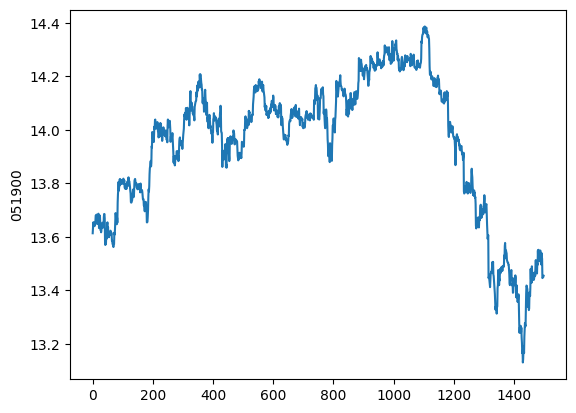

In [ ]:
sns.lineplot(df.iloc[:1500,67])

<Axes: ylabel='051900'>

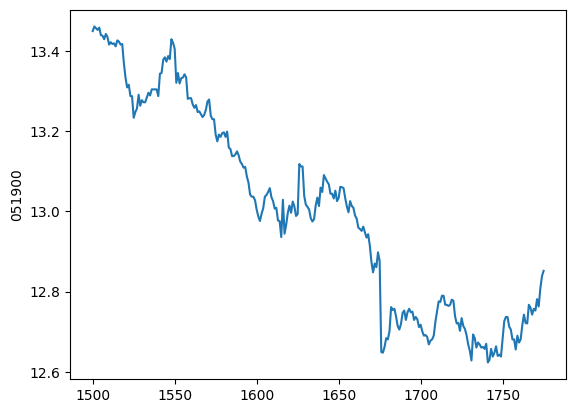

In [ ]:
sns.lineplot(df.iloc[1500:,67])